# Transformer Translation
---

#### environment setting

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [3]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!
import sentencepiece as spm


print(tf.__version__)

2.4.1


## Step 1. 데이터 다운로드
---

[jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)에서 한국어-영어 병렬 데이터를 다운로드 받는다.

- 다운로드 경로 지정

In [5]:
workspace_path = '/home/aiffel-dj1/workspace/aiffel-gd-nlp/GD10_transformer_translation'
data_path = '/home/aiffel-dj1/workspace/aiffel-gd-nlp/GD08_seq2seq_translation/data'

- 다운로드

In [5]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz -P $data_path

--2021-05-04 16:04:01--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 15.164.81.167
접속 github.com (github.com)|15.164.81.167|:443... 접속됨.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2021-05-04 16:04:01--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
접속 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘/home/aiffel-dj1/workspace/aiffel-gd-nlp/GD08_seq2seq_translation/data/korean

- 압축 풀기

In [6]:
!gzip -d $data_path/korean-english-park.train.tar.gz
!tar -xvf $data_path/korean-english-park.train.tar -C $data_path

gzip: /home/aiffel-dj1/workspace/aiffel-gd-nlp/GD08_seq2seq_translation/data/korean-english-park.train.tar already exists; do you wish to overwrite (y or n)? ^C
korean-english-park.train.en
korean-english-park.train.ko


In [7]:
!ls $data_path

korean-english-park.dev.en    korean-english-park.train.en
korean-english-park.dev.ko    korean-english-park.train.ko
korean-english-park.dev.tar   korean-english-park.train.tar
korean-english-park.test.en   korean-english-park.train.tar.gz
korean-english-park.test.ko   sp_train_corpus_en.temp
korean-english-park.test.tar  sp_train_corpus_ko.temp


## Step 2. 데이터 정제 및 토큰화
---

### A. 중복 제거

`set`을 활용하여 데이터의 중복을 제거한다.

In [6]:
def get_duplicated_index(raw):
    clear_set = set()
    removed_index = []
    cnt_old = 0
    
    for i, sen in enumerate(raw):
        clear_set.add(sen)
        cnt_new = len(clear_set)
        
        if cnt_new == cnt_old:
            removed_index.append(i)
        cnt_old = cnt_new
    
    return removed_index

In [7]:
def remove_by_indexs(raw, indexs):
    return [ sen for i, sen in enumerate(raw) if i not in indexs ]

In [8]:
kor_path = data_path + "/korean-english-park.train.ko"
eng_path = data_path + "/korean-english-park.train.en"

def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    removed_index = get_duplicated_index(kor)
    clean_corpus_ko = remove_by_indexs(kor, removed_index)
    clean_corpus_en = remove_by_indexs(eng, removed_index)
    
    removed_index = get_duplicated_index(clean_corpus_en)
    clean_corpus_en = remove_by_indexs(clean_corpus_en, removed_index)
    clean_corpus_ko = remove_by_indexs(clean_corpus_ko, removed_index)

    return clean_corpus_ko, clean_corpus_en

clean_corpus_ko, clean_corpus_en = clean_corpus(kor_path, eng_path)

- 데이터 확인

In [9]:
len(clean_corpus_ko), len(clean_corpus_en)

(74849, 74849)

In [12]:
idx = np.random.choice(len(clean_corpus_ko), 5)
for i in idx:
    print(f'{i}')
    print(f'ko >>> {clean_corpus_ko[i]}')
    print(f'en >>> {clean_corpus_en[i]}\n')

65803
ko >>> 공화당 연설에서 존 바라소 상원의원(와이오밍)은 백악관이 풍력, 태양력 에너지와 함께 사용될 수 있는 에너지 공급원을 도외시하고 있다고 주장했습니다.
en >>> ” In the Republican address, Wyoming Senator John Barrasso says the White House is ignoring an energy supply that could be used alongside wind and solar power:

70066
ko >>> 미국인 억만장자 칼 아이칸이 회사를 어떻게 운영해 나갈 것인지에 대해 담배제조회사(KT&G) 경영진과의 1년 여의 다툼에 종지부를 찍었다. 그가 KT&G의 보유 주식을 약 1450억원의 가격에 모두 매도한 이후, 다른 재력가들도 한국에서 철수하고 있다.
en >>> U.S. billionaire Carl Icahn sold most of his shares in KT&G taking about 145 billion won in estimated returns, ending a one-year battle with the tobacco maker's management over how the company should be run.

47781
ko >>> 호주 관리들은 여전히 스탤론 일행으로부터 압수한 물질을 조사하고 있으며 이에 대한 추가 조치 여부를 결정할 것이라고 이 신문은 전했다.
en >>> Officials are still examining substances collected from Stallone's entourage to determine whether further action would be taken, the newspaper reported.

72121
ko >>> 이명박 대통령은 이번 발사가 우주강국이 되고자 하는 한국의 야망에 디딤돌이 되기를 희망했다.
en >>> President Lee hoped that the event will be

### B. 데이터 정제

주어진 데이터를 다음의 조건에 맞추어 정제함수를 작성한다.
- 모든 입력을 소문자로 변환한다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거한다.
- 문장부호 양옆에 공백을 추가한다.
- 문장 앞뒤의 불필요한 공백을 제거한다.

In [13]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅣ가-힣?.!,]+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

### C. tokenizer

Sentencepiece를 활용하여 토큰화를 진행하며 tokenizer 생성 함수(generate_tokenizer)를 정의하고, 한국어와 영어 tokenizer를 생성한다.

생성 함수는 다음 조건을 따라 정의한다.

- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 한다. (기본: 20,000)
- 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환한다.
- 특수 토큰의 인덱스를 아래와 동일하게 지정한다.
    - `<PAD>` : 0
    - `<BOS>` : 1
    - `<EOS>` : 2
    - `<UNK>` : 3

In [14]:
model_path = workspace_path + '/model'

In [15]:
def generate_tokenizer(corpus,
                        vocab_size=20000,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    corpus_path = f'{data_path}/sp_train_corpus_{lang}.temp'
    with open(corpus_path, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')

    prefix = f'{model_path}/spm_{lang}'
    
    spm.SentencePieceTrainer.Train(
        f'--input={corpus_path} \
            --model_prefix={prefix} \
            --vocab_size={vocab_size} \
            --model_type=unigram \
            --pad_id={pad_id} \
            --bos_id={bos_id} \
            --eos_id={eos_id} \
            --unk_id={unk_id}')
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{prefix}.model')

    return tokenizer

In [16]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for k, e in zip(clean_corpus_ko, clean_corpus_en):
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

- kor tokenizer 테스트

In [17]:
examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

In [18]:
for sen in examples:
    sen = preprocess_sentence(sen)
    encoded = ko_tokenizer.EncodeAsIds(sen)
    decoded = ko_tokenizer.DecodeIds(encoded)
    print(f'raw data : {sen}')
    print(f'encoded : {encoded}')
    print(f'decoded : {decoded}\n')

raw data : 오바마는 대통령이다 .
encoded : [94, 7, 237, 28, 4]
decoded : 오바마는 대통령이다 .

raw data : 시민들은 도시 속에 산다 .
encoded : [2285, 9, 567, 2118, 663, 28, 4]
decoded : 시민들은 도시 속에 산다 .

raw data : 커피는 필요 없다 .
encoded : [3074, 7, 760, 216, 4]
decoded : 커피는 필요 없다 .

raw data : 일곱 명의 사망자가 발생했다 .
encoded : [23, 19875, 79, 637, 11, 430, 4]
decoded : 일곱 명의 사망자가 발생했다 .



- eng tokenizer 테스트


In [19]:
examples_en = [
    "Obama is President.",
    "Citizens live in cities.",
    "I don't need coffee.",
    "Seven people were killed."
]

In [20]:
for sen in examples_en:
    print(f'raw data : {sen}')
    sen = preprocess_sentence(sen)
    encoded = en_tokenizer.EncodeAsIds(sen)
    decoded = en_tokenizer.DecodeIds(encoded)
    print(f'encoded : {encoded}')
    print(f'decoded : {decoded}\n')

raw data : Obama is President.
encoded : [1, 144, 25, 52, 7, 2]
decoded : obama is president .

raw data : Citizens live in cities.
encoded : [1, 1360, 582, 13, 666, 50, 7, 2]
decoded : citizens live in cities .

raw data : I don't need coffee.
encoded : [1, 56, 407, 60, 247, 3021, 7, 2]
decoded : i don t need coffee .

raw data : Seven people were killed.
encoded : [1, 504, 55, 44, 165, 9, 7, 2]
decoded : seven people were killed .



### D. 토큰화

토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환한다.

In [21]:
from tqdm import tqdm_notebook

src_corpus = []
tgt_corpus = []
max_len = 50

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    ko_tokenized = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    en_tokenized = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(ko_tokenized) <= max_len and len(en_tokenized) <= max_len:
        src_corpus.append(ko_tokenized)
        tgt_corpus.append(en_tokenized)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/74849 [00:00<?, ?it/s]

- 데이터 확인

In [22]:
len(enc_train), len(dec_train)

(64260, 64260)

In [23]:
idx = np.random.choice(len(enc_train), 3)

In [24]:
for i in idx:
    print(i)
    print(f'ko encoded : {enc_train[i]}')
    print(f'ko decoded : {ko_tokenizer.DecodeIds(enc_train[i].tolist())}')
    print(f'en encoded : {dec_train[i]}')
    print(f'en decoded : {en_tokenizer.DecodeIds(dec_train[i].tolist())}\n')

37495
ko encoded : [  209  1289     8  2329   194   309   446  1117  4103   376     4     5
     8  2649     6 10101    15   687 10228     9     4     5     8  2649
     6  1299   554  8746     4     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
ko decoded : 프랑스 내무부의 집계에따르면 사코지는 투표에서 총 . 의 지지율을 얻었고 반면 로얄은 . 의 지지율을 얻는데 그쳤다 .
en encoded : [   1  123   10  257    5   32    6  517 1264  261   16    4    8 1017
 2011    9    7  117   12    6  341    5    4    8  185   31 1099  226
    7  117    7    2    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
en decoded : according to numbers from the french interior ministry , sarkozy earned . percent of the votes , while royal won . percent .

31769
ko encoded : [   86  4481    17   753    19   983     6 11448    74  5310     7  6814
  1387    11   343  8794  9028 12105 11244  3801 14779     9  1127     5
 18874  4692  1992 1661

## Step 3. 모델 설계
---

Transformer의 내부 모듈을 구현하고 이를 조립하여 모델을 설계하여 보자.

![transformer](https://paul-hyun.github.io/assets/2019-12-19/transformer-model-architecture.png)

### A. 내부 모듈 정의

#### Positional Encoding

In [90]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i, d_model):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position, d_model):
        return [cal_angle(position, i, d_model) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i, d_model) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

#### Multi-Head Attention

In [91]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        matmul_qk = tf.matmul(Q, K, transpose_b=True)
        dk = tf.cast(K.shape[-1], tf.float32)
        scaled_qk = matmul_qk / tf.math.sqrt(dk)
        
#         print('scaled_dot_product_attention')
#         print(f'Q.shape : {Q.shape}')
#         print(f'K.shape : {K.shape}')
#         print(f'V.shape : {V.shape}')
#         print(f'mask.shape : {mask.shape}')
#         print(f'scaled_qk.shape : {scaled_qk.shape}')
        if mask is not None: 
            scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
#         print(f'attentions.shape : {attentions.shape}')
        out = tf.matmul(attentions, V)
#         print(f'out.shape : {out.shape}\n')

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

#### Position-wise Feed-Forward Network

In [92]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### B. Encoder/Decoder  정의

#### Encoder Layer

In [93]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

#### Encoder

In [94]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

#### Decoder Layer

In [95]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

#### Decoder

In [96]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### C. Transformer 정의

In [97]:
class Transformer(tf.keras.Model):
    def __init__(self,
                n_layers,
                d_model,
                n_heads,
                d_ff,
                src_vocab_size,
                tgt_vocab_size,
                pos_len,
                dropout=0.2,
                shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
            self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

### D. Masking

In [62]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask


### E. Learning Rate Scheduler

In [98]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

## Step 4. 훈련하기
---

### A. Transformer

In [38]:
transformer = Transformer(n_layers=2, 
                          d_model=512, 
                          n_heads=8, 
                          d_ff=2048, 
                          src_vocab_size=SRC_VOCAB_SIZE, 
                          tgt_vocab_size=TGT_VOCAB_SIZE, 
                          pos_len=256, 
                          dropout=0.1)

### B. Optimizer

![optimizer](https://i.ibb.co/0Gr6Nqj/2021-05-04-09-02-14.png)

In [64]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### C. Loss function

In [99]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### D. Train step

In [100]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### E. Train

In [101]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=True, cbar_kws={"shrink": .5},
                        ax=ax,
                        xticklabels=x,
                        yticklabels=y,
                        cmap='GnBu')
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [102]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    ids = []
    
    output = tf.convert_to_tensor([tgt_tokenizer.bos_id()] + [tgt_tokenizer.pad_id()] * (enc_train.shape[-1] - 1), tf.int64)
    output = tf.expand_dims(output, 0)
#     output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
            _input, output)
        
        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, 
                                                                 output,
                                                                 enc_padding_mask,
                                                                 combined_mask,
                                                                 dec_padding_mask)
        
        predictions = predictions[:, -1:, :]
        predicted_id = tf.argmax(predictions, axis=-1).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.convert_to_tensor([tgt_tokenizer.bos_id()] +
                                      ids + 
                                      [tgt_tokenizer.pad_id()] * (enc_train.shape[-1] - 1 - len(ids)), 
                                      tf.int64)
        output = tf.expand_dims(output, 0)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [103]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
        evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('🇰🇷 : %s' % (sentence))
    print('🇺🇸 : {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [104]:
# 학습
from tqdm.notebook import tqdm

BATCH_SIZE = 256
EPOCHS = 20

examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

In [105]:
def train(transformer, optimizer, enc_train, dec_train, 
          enc_tokenizer, dec_tokenizer,
          examples, EPOCHS=20, BATCH_SIZE=128):
    
    losses = []
    
    for epoch in range(EPOCHS):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(
                enc_train[idx:idx+BATCH_SIZE],
                dec_train[idx:idx+BATCH_SIZE],
                transformer,
                optimizer)

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            
        print(f'[EPOCH = {epoch+1}]')
        for i, example in enumerate(examples):
            if (epoch + 1) % 10 == 0 and i == 0:
                translate(example, transformer, enc_tokenizer, dec_tokenizer, plot_attention=True)
            else:
                translate(example, transformer, enc_tokenizer, dec_tokenizer)
            
            
        losses.append(total_loss)
        
    return losses

In [106]:
def show_train_loss(losses):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(losses)
    ax.set_title('Traina loss', fontsize=15)
    plt.show()

#### [TRY] EPOCHS = 20

  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : the obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : the the the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the the the the the the the the saturday . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the the the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : the the  the  the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the the the the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : it it it it no it . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : cnn cnn cnn a . monda . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president president president president president president president president president president president president president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee coffee coffee coffee coffee coffee . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : cnn cnn cnn  cnn cnn  cnn  cnn cnn a police sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president president president president president president president president obama president obama president obama president obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the urban is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : need need no need need no need . no . . . . . . . . no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the the the the the the the the the . the . the . . . the . . . . . . . the . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee coffee . coffee . coffee . coffee coffee . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday a sunday sunday sunday sunday sunday


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama president president obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : urban cit cit cit urban cit cit cit cit . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee coffee coffee coffee coffee coffee no
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Encoder Layer 1


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


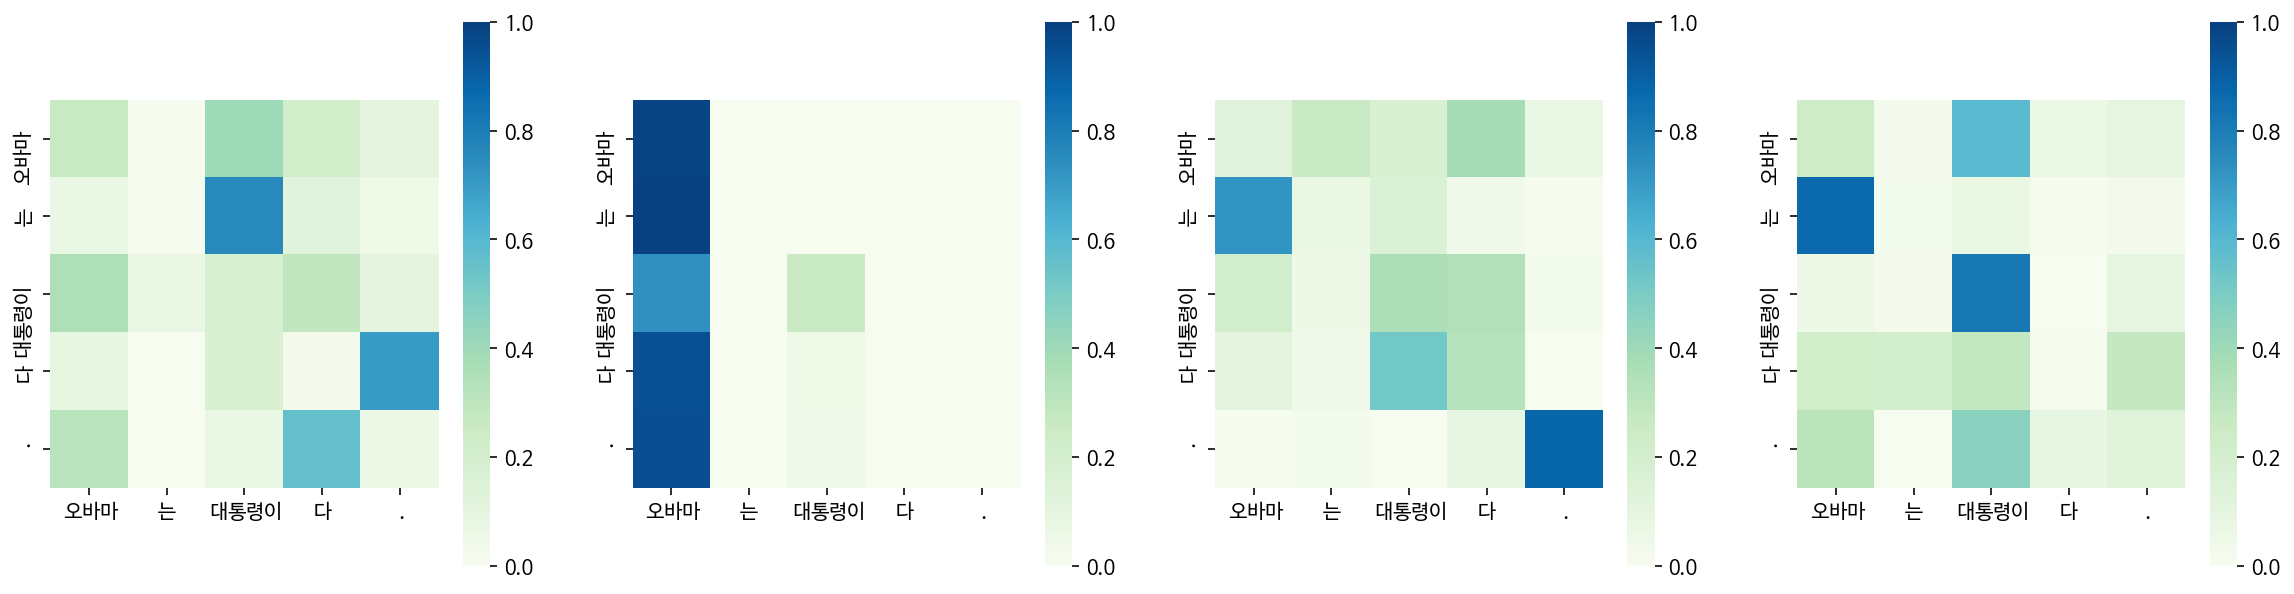

Encoder Layer 2


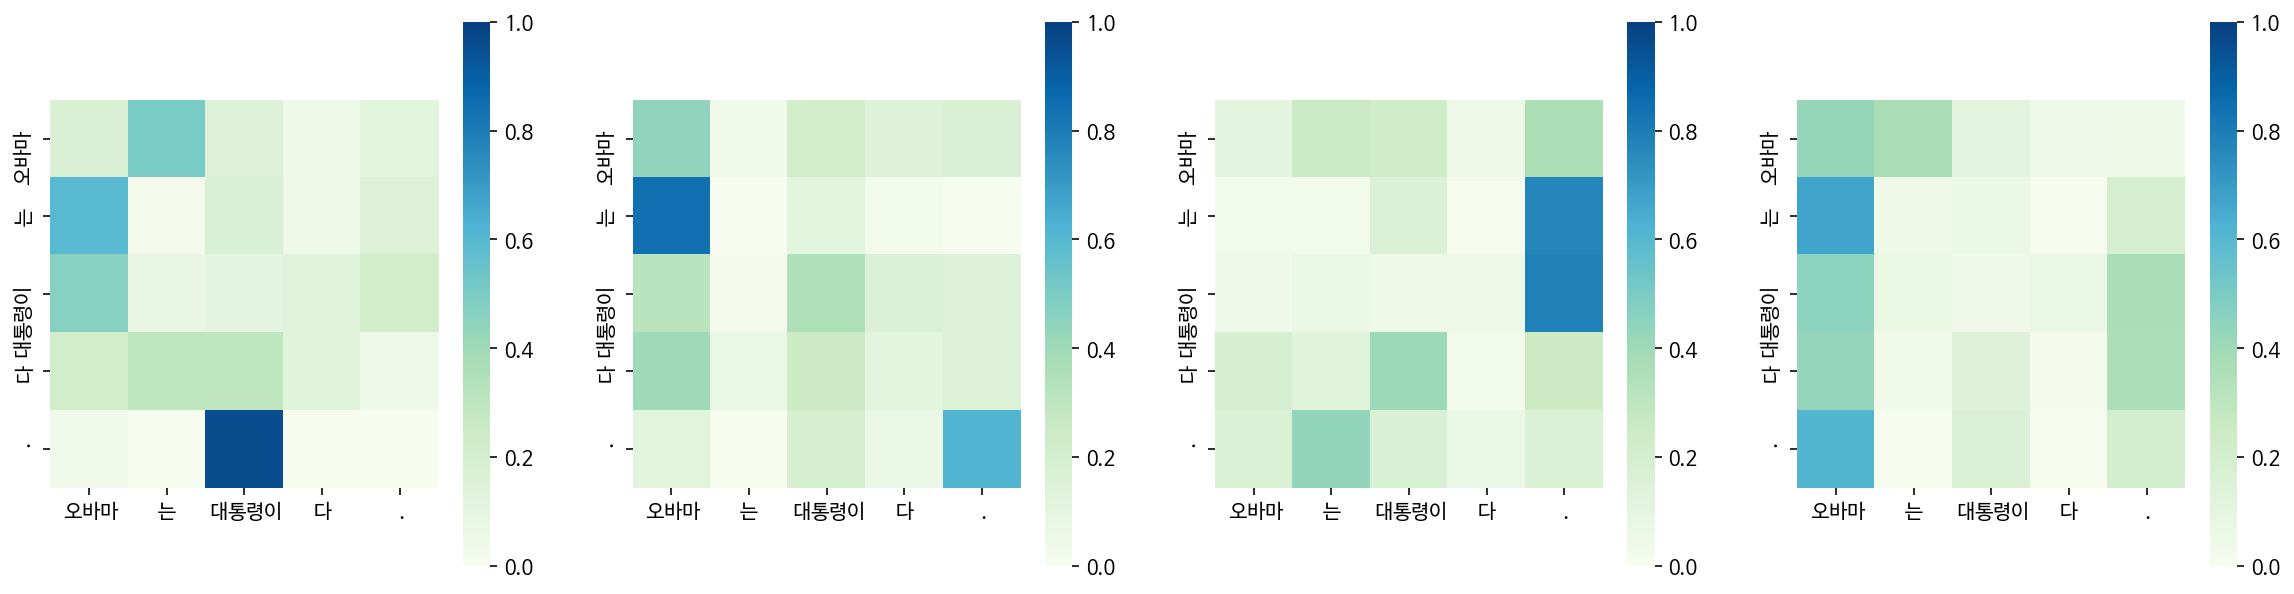

Decoder Self Layer 1


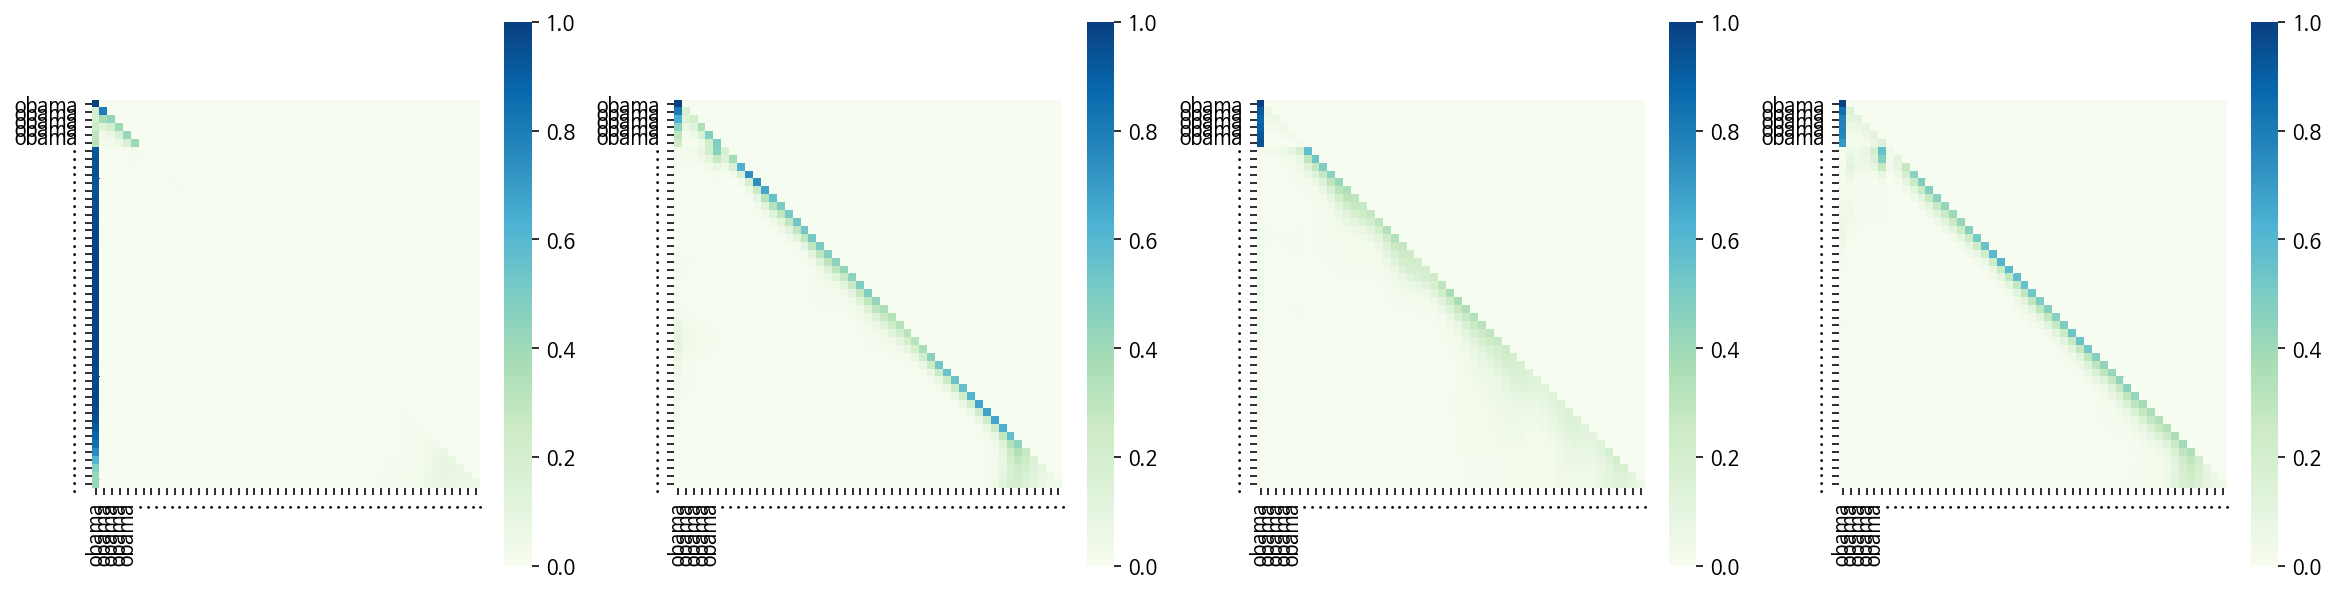

Decoder Src Layer 1


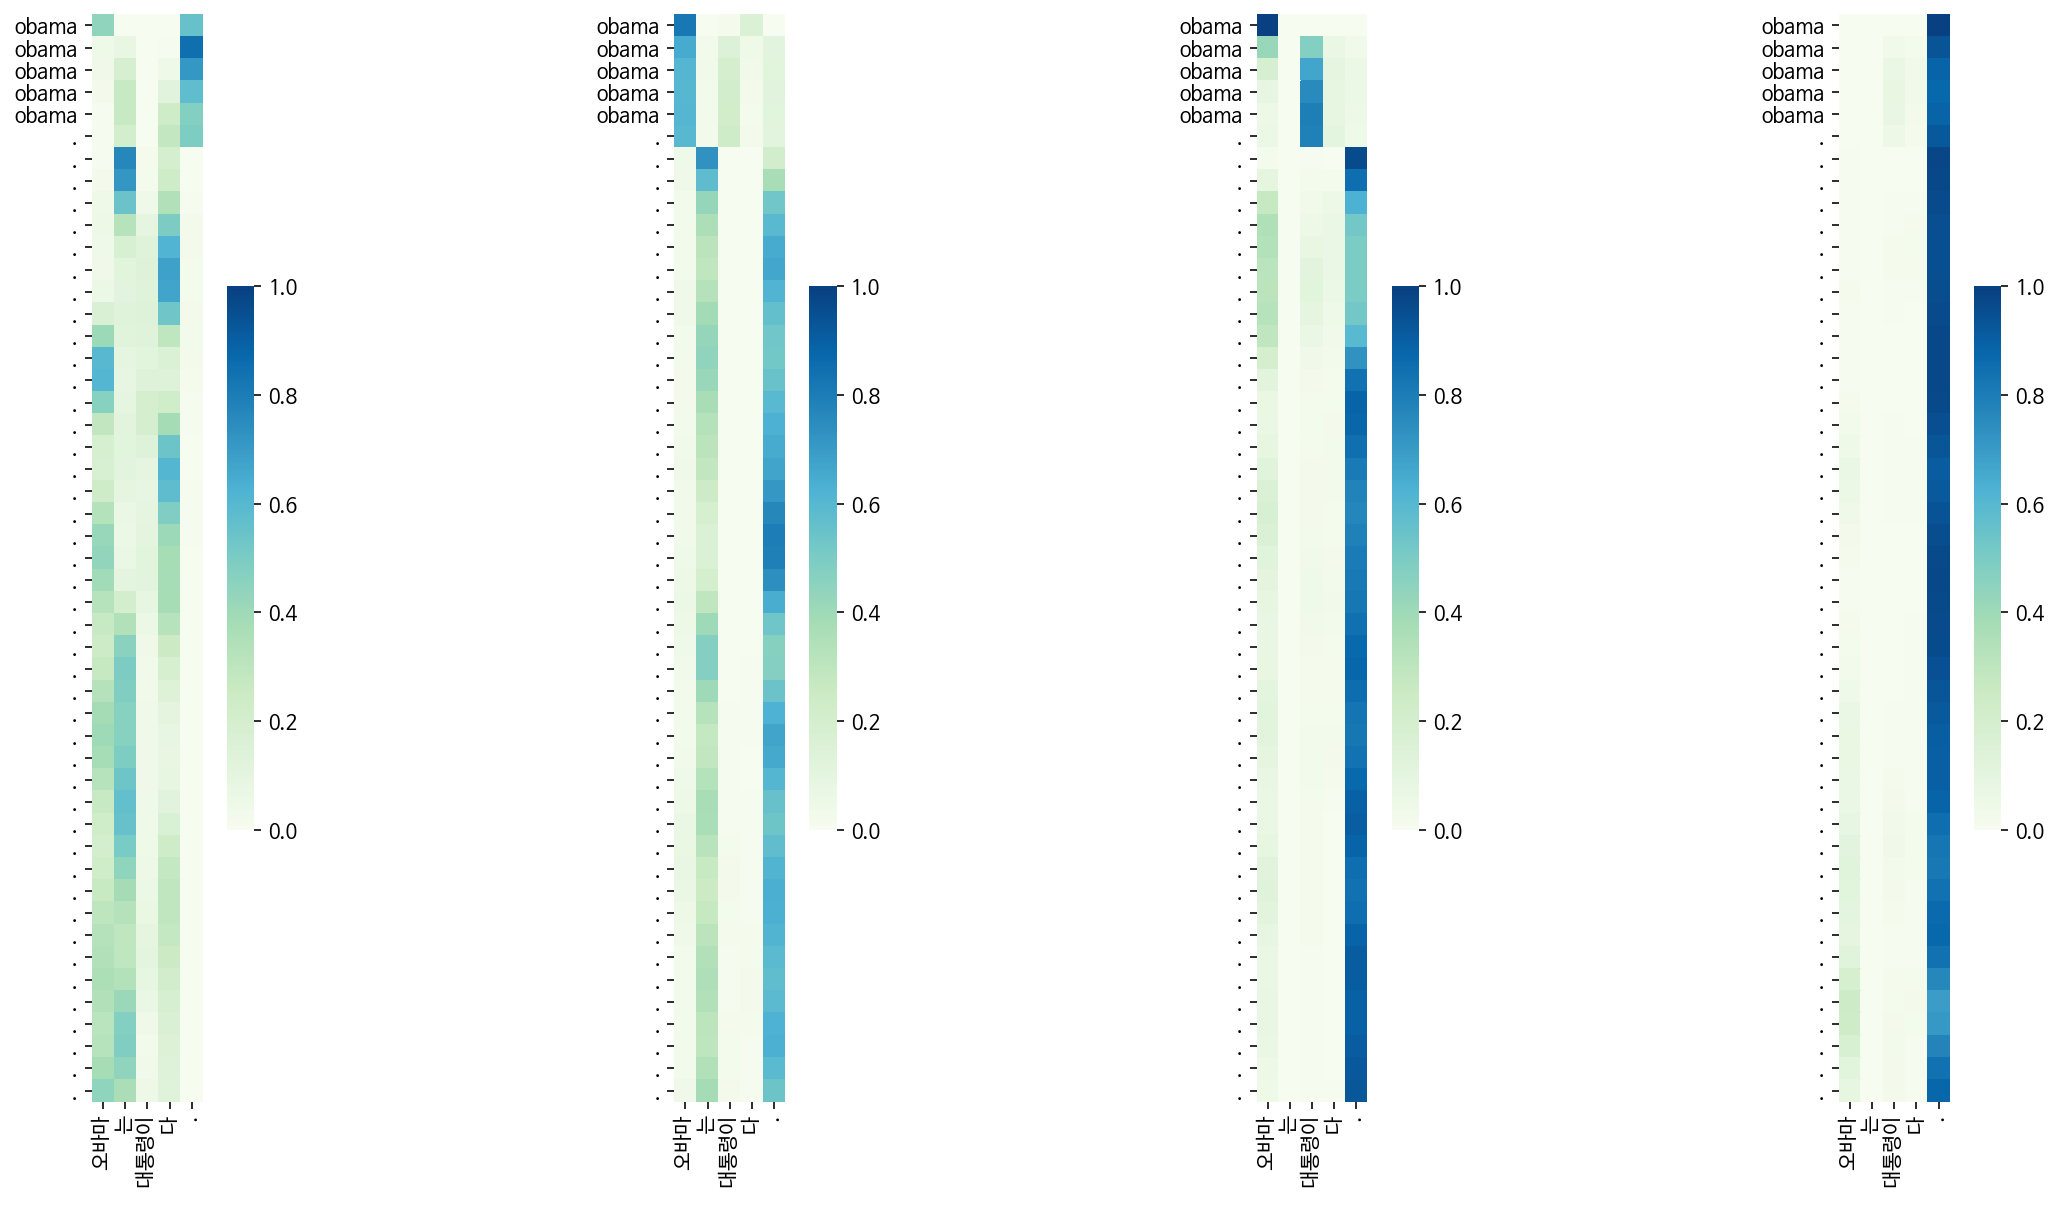

Decoder Self Layer 2


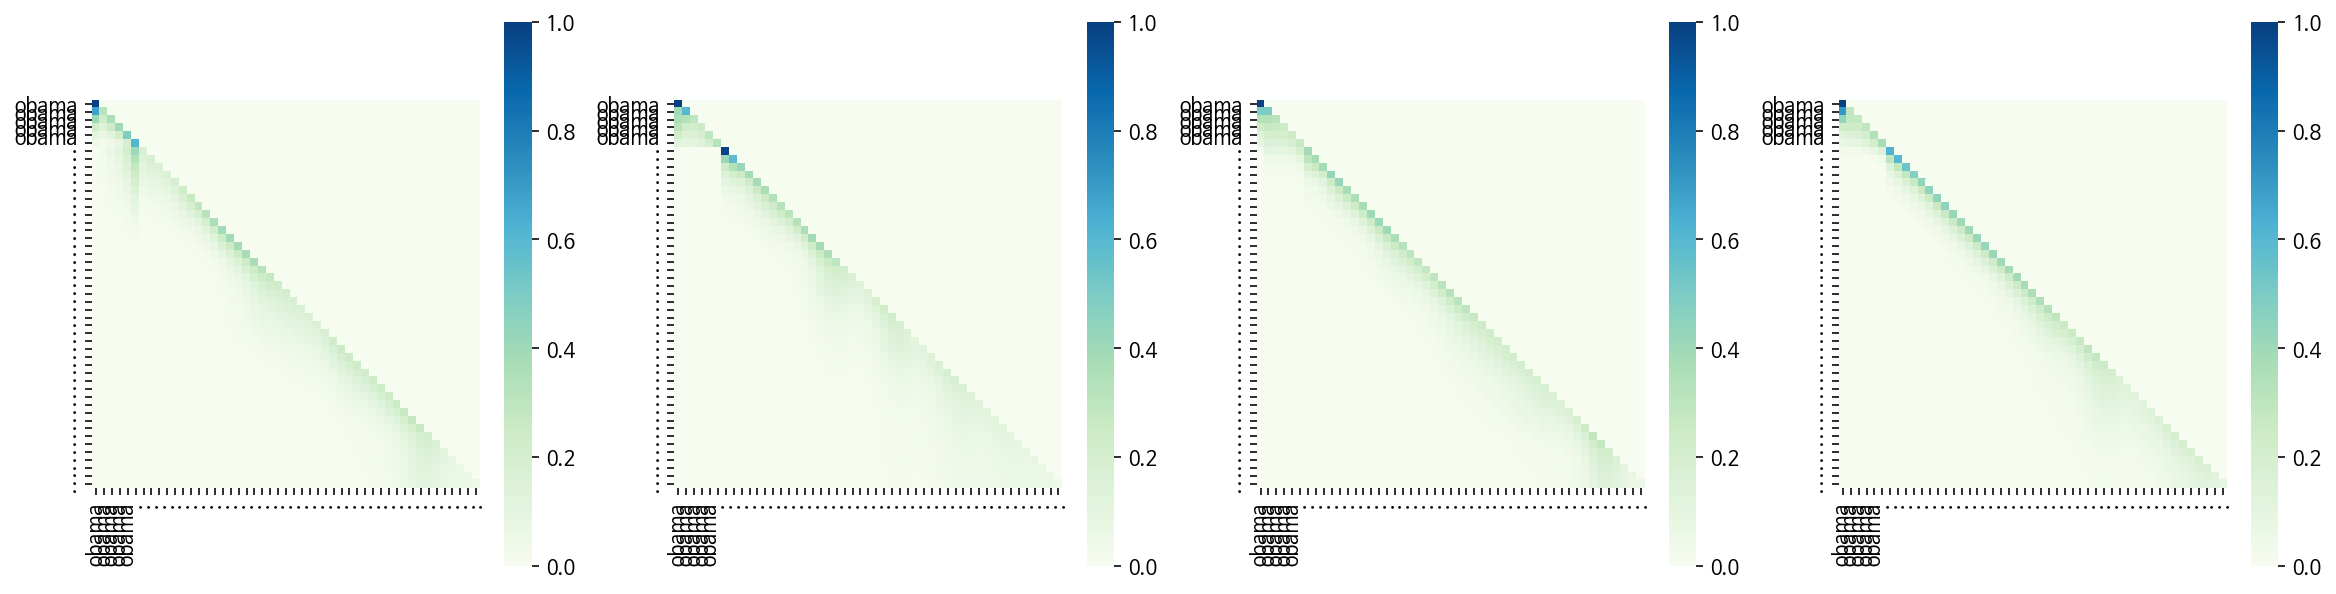

Decoder Src Layer 2


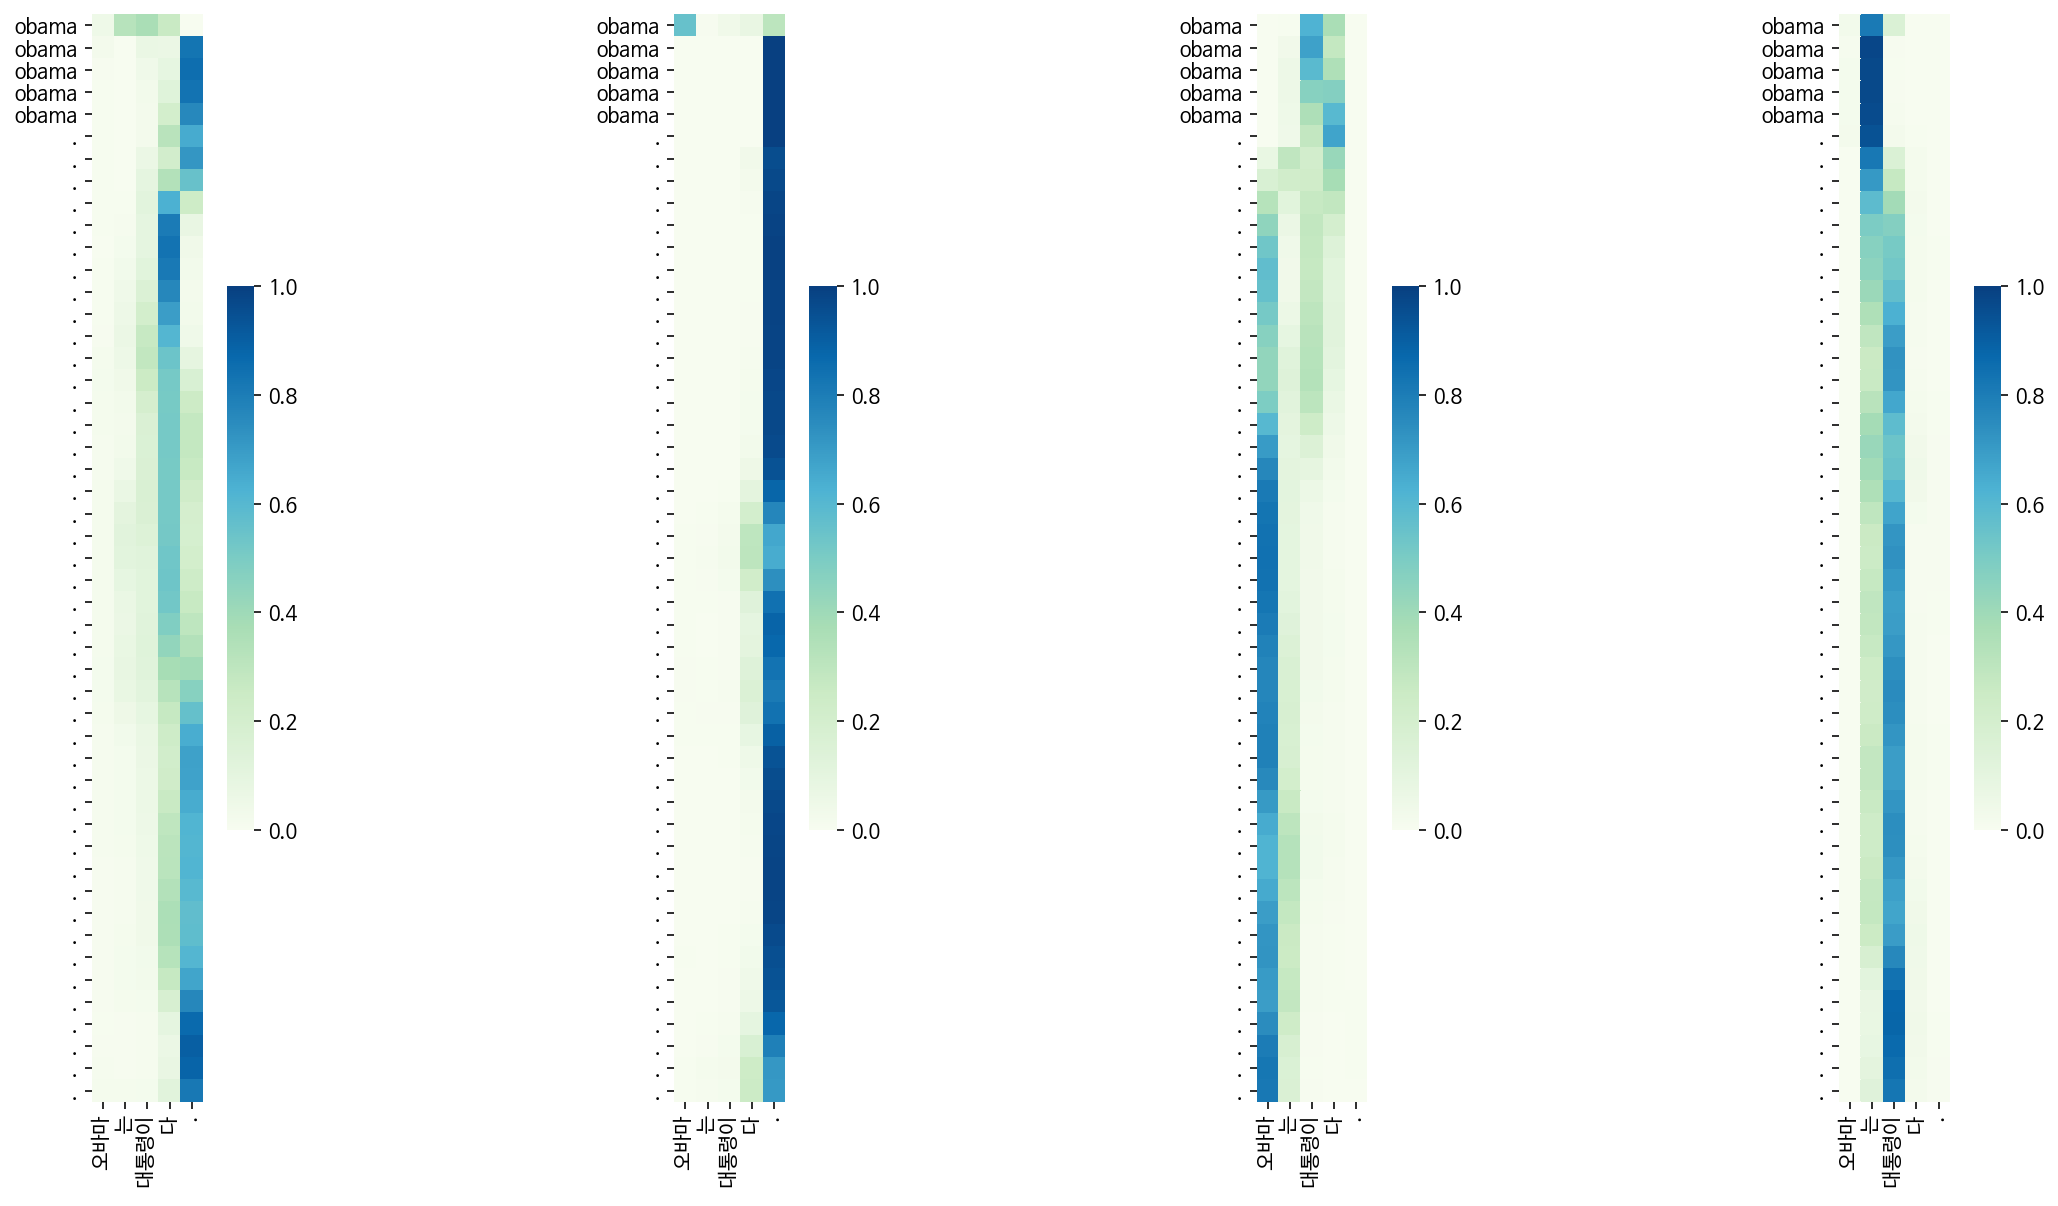

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the cit cit towns the the the the the is . . . . . . . . the . . . . . . the . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : you need need need need need need need need no need
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : sunday sunday sunday sunday sunday sunday sunday sunday sunday


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama obama obama obama obama . obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : cit cit cit cit cit cit cit cit the cit cit cit this this city this . cit cit cit this cit
🇰🇷 : 커피는 필요 없다.
🇺🇸 : need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need need
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven thursday thursday cnn seven cnn seven seven thursday thursday


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama transition transition . obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : urban urban urban urban urban urban urban . the psychological psychological
🇰🇷 : 커피는 필요 없다.
🇺🇸 : any need need need need need need need need need or need need need need need need need to need need need need need need need need need need need need need need need need need need to need need need . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : sunday all them them thes . them . all them them the deads


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama campaign . obama obama obama . . . . . . . . . . . . . . obama . . . . . . . . . . . . . . . is . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : cit cit cit cit cit cit cit cit the is . the the the . the is . . . . . . the the . . . . there there is . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : any any any any coffee need need need need . no to
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the . all dead fatalit fatalits fatalitss and them them them them a them them them them them . them them them them them them . them . . . them . . the haveed themed . them . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama obama obama obama obama obama obama obama obama obama obama . is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : city city city city city city city city city city city city . city city city city city city city . . . the . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : any any any need need need . need for need need need need need . must need for need need need need need need need need . for need need need need need need . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : a .          .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : are . to to . . . . . . to . . . . . . . every . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee coffee coffee coffee coffee . coffee . coffee . coffee . . . . coffee . . . . . . . . . . . coffee . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven and injur were dead later injur . injur . injur      . . . . .s ands injurssss .s .s . . and them deadss . .s . . them . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . obama . . . . . . . . . obama . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : cit cit cit cit cit cit cit cit urban cit cit cit cit urban . mountain mountain is . . . . one . one one one one . is . . . . . . . in . . . . isr . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : any any necessar coffee . is . not . not . . entry . . entry . . . entry . . . . . . entry . . . . . . . . . . . not
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven were dead  cnn cnn .  cnn dead cnn injur cnn injur injur cnns have dead deadss .ss        to   . . . temblor ofsed


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : urban is . . . . . . . . . . . . . to . . . . . . . town slide slide slide slide slide slide slide slide . . . .r is . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : don need need need need to need to need need to don need need . don need to need to don don . don don need to need . . cup . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven dead were sunday                        cnn


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people urban of urban of urban of . urban of urban .ss . . . . ofs . i . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : don sound sound sound sound sound sound sound sound destination application application application application application application application application application ifs application application application applications applications application applications . application application application applications
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven and . seven seven . . . seven . . seven . . . . . . . . . . . . . . . people haveed dead . .s . . .s .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people over schools schools schools . this this are . . . . . . of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no . . . . . . . . . . . don . . . . . . . . drink coffee . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven and . seven seven seven seven seven seven and . . . dead . . . . dead . . . . . . dead . dead . . dead and them dead . them . . . them . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama over president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Encoder Layer 1


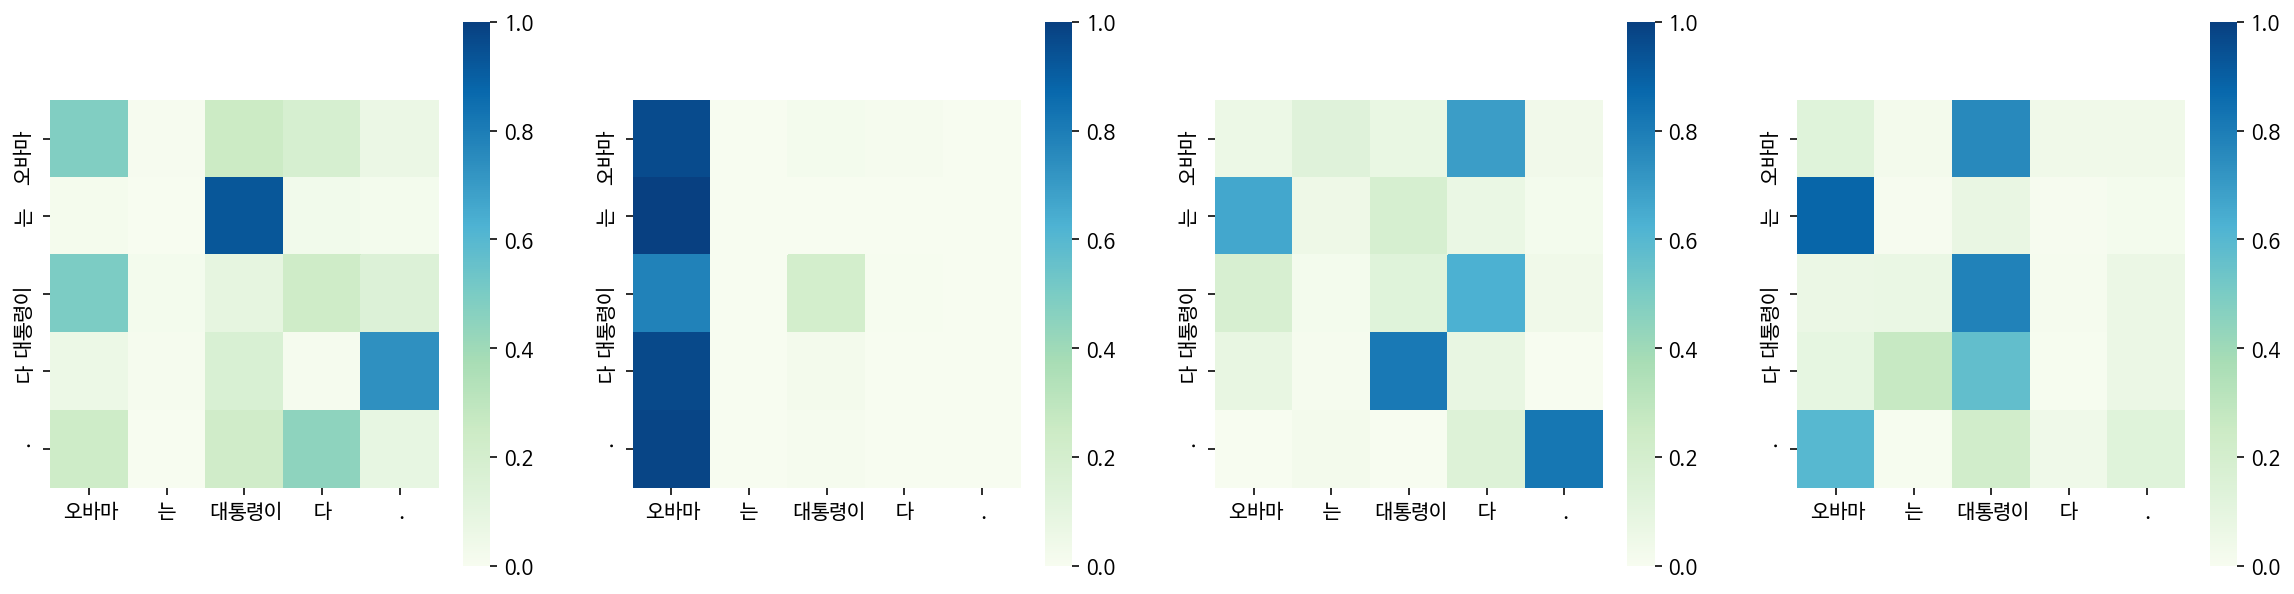

Encoder Layer 2


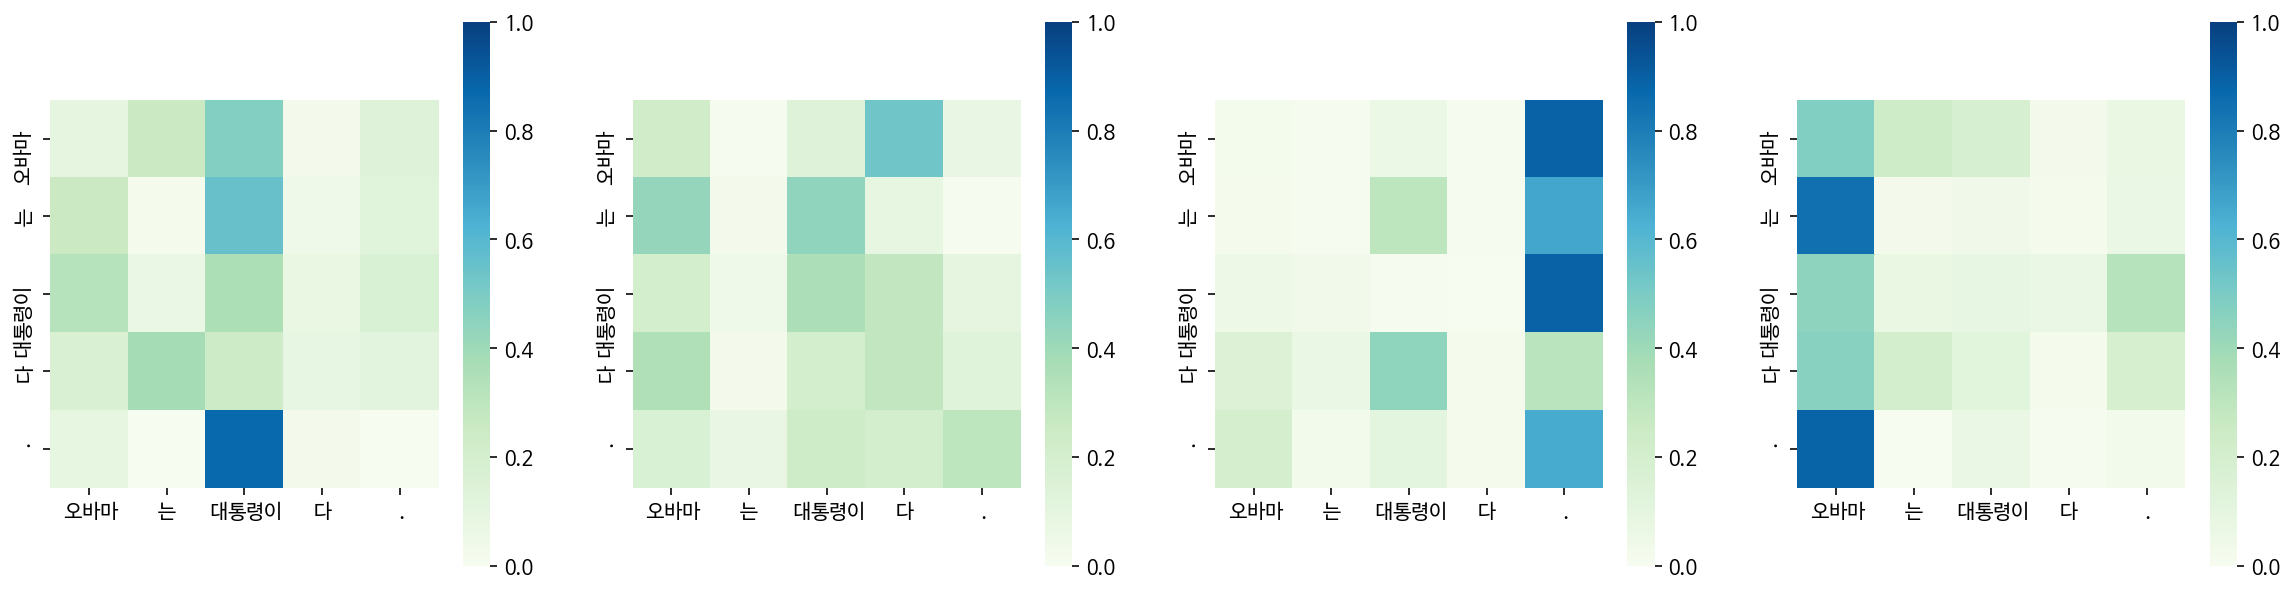

Decoder Self Layer 1


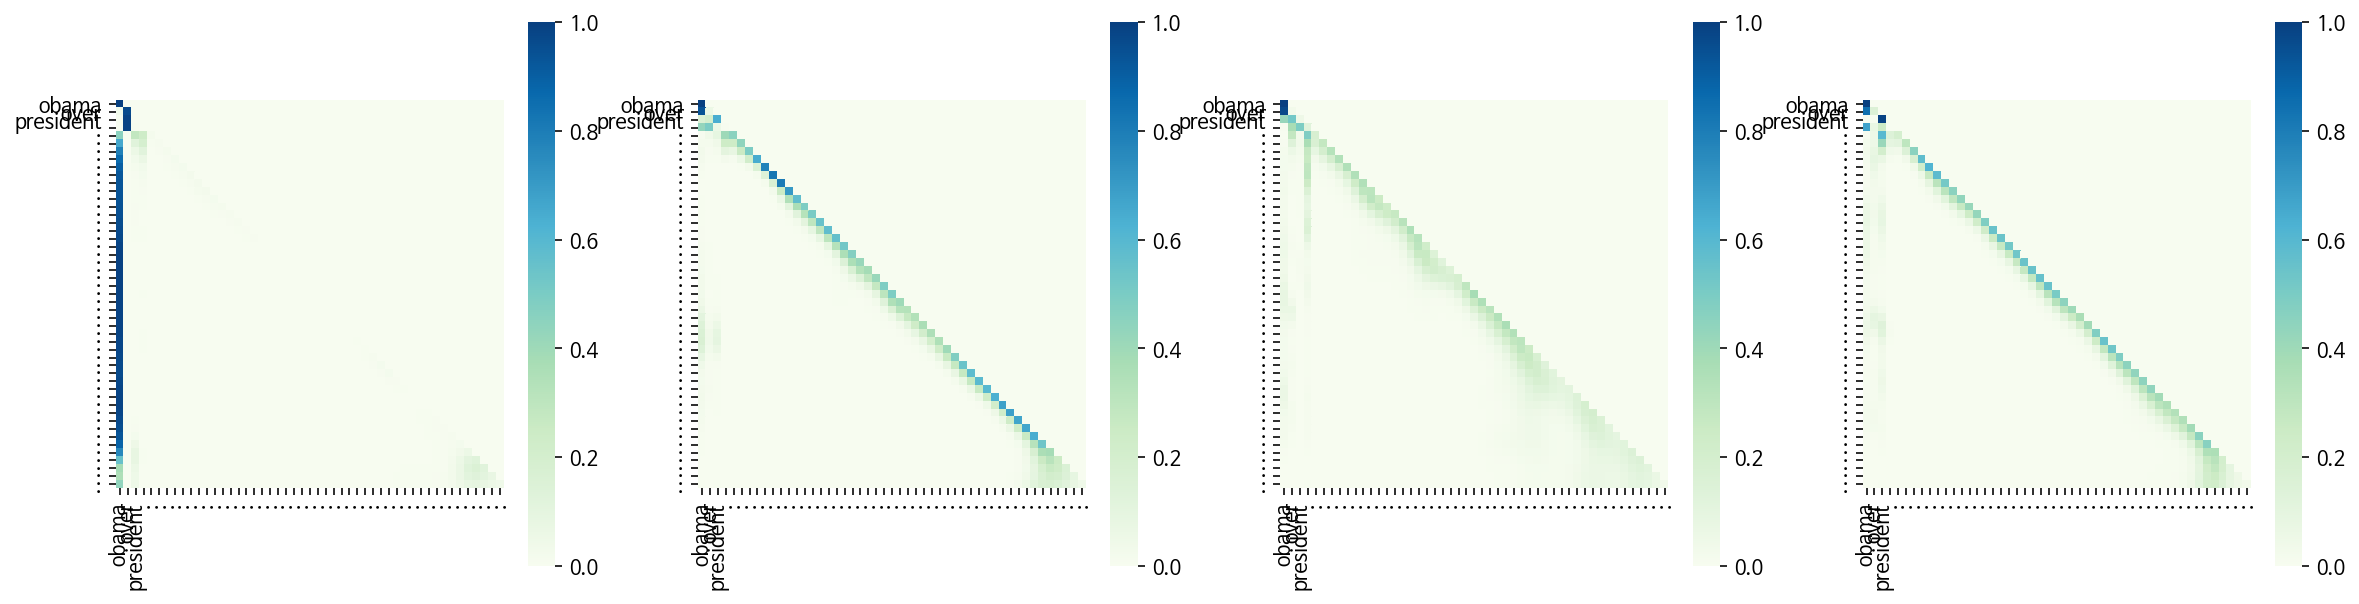

Decoder Src Layer 1


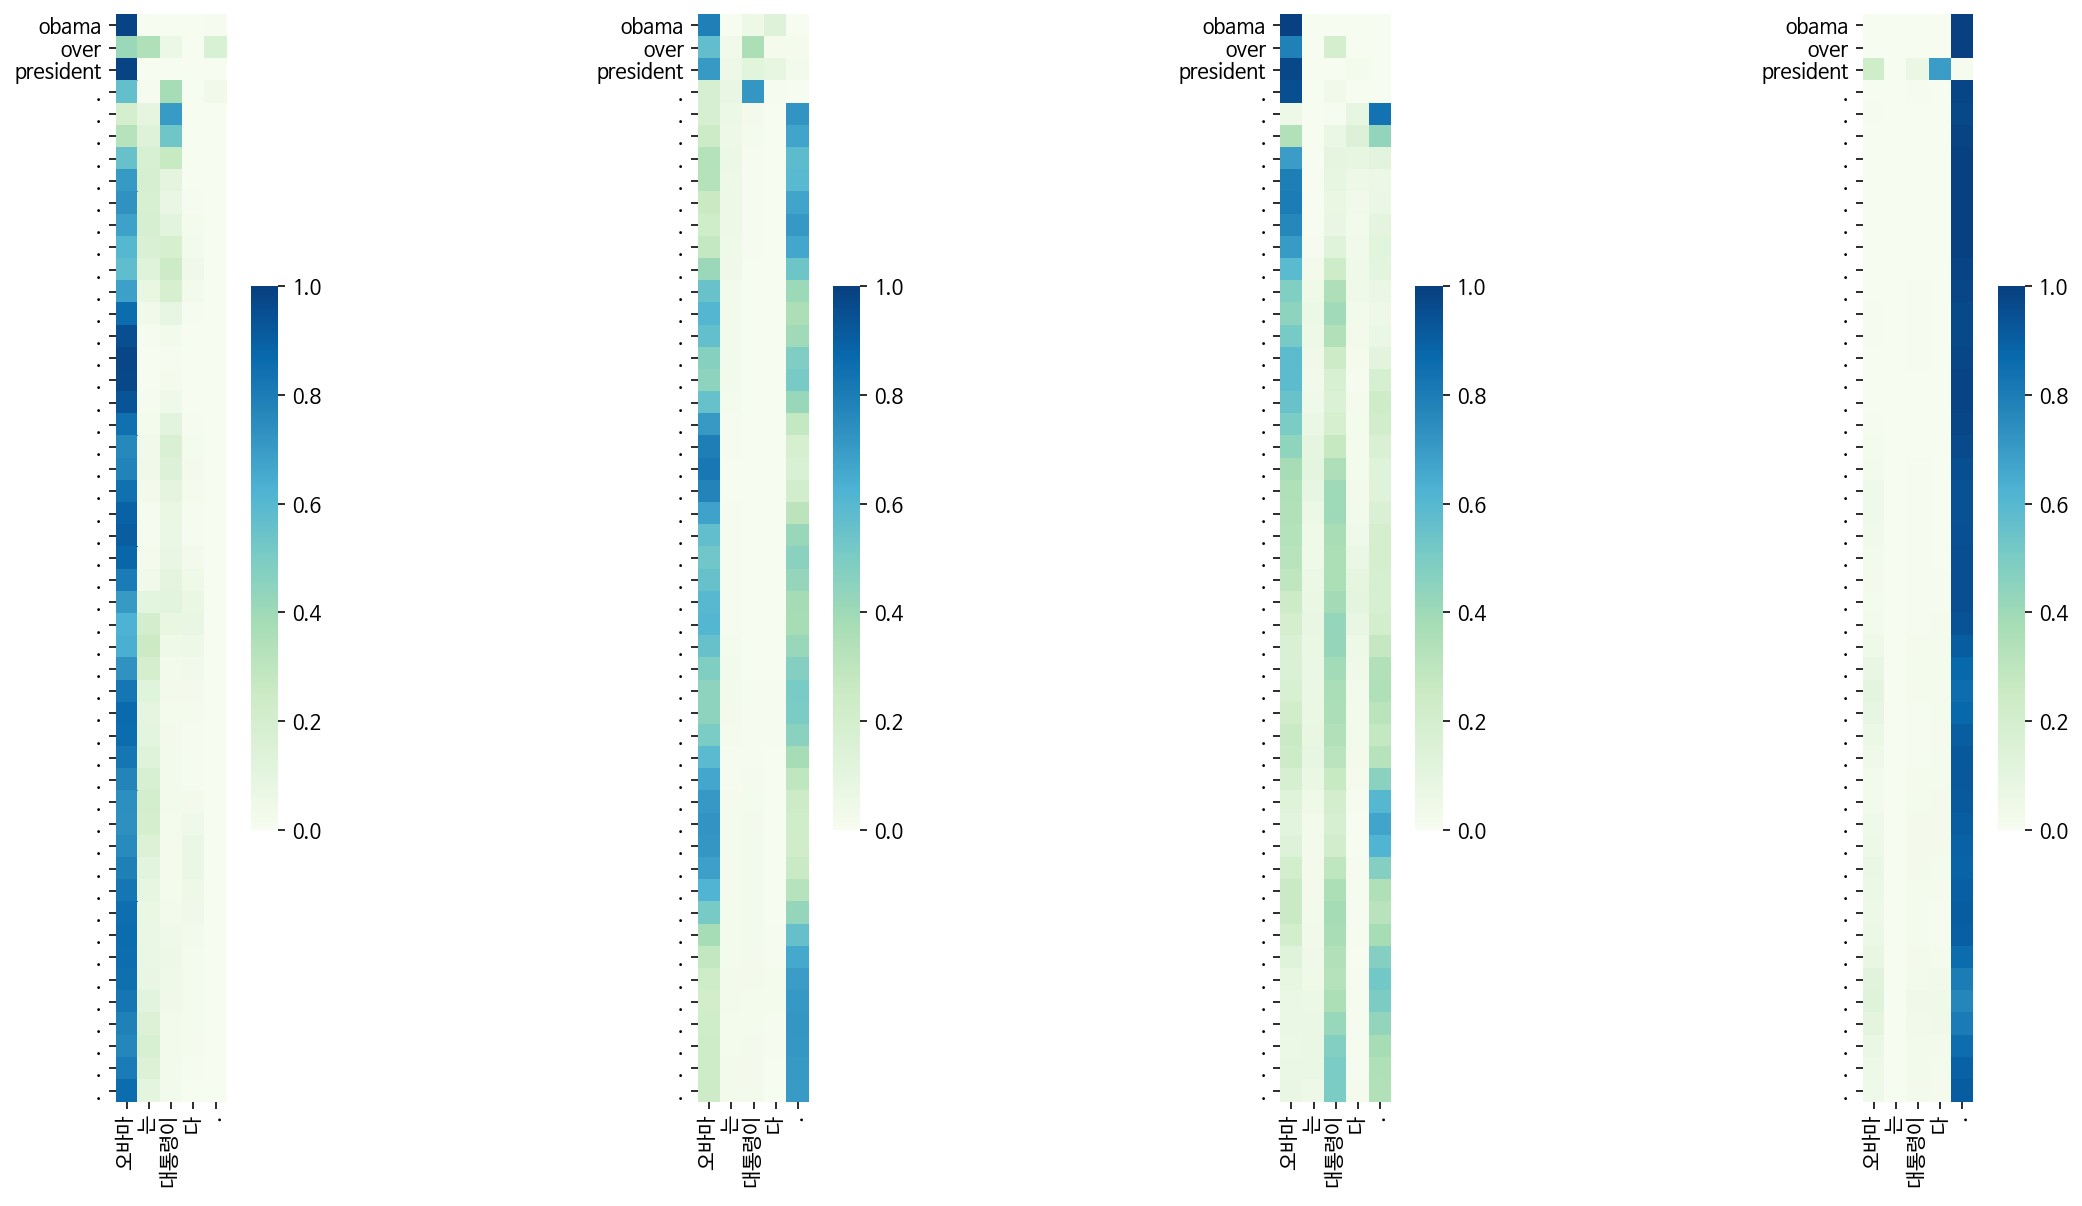

Decoder Self Layer 2


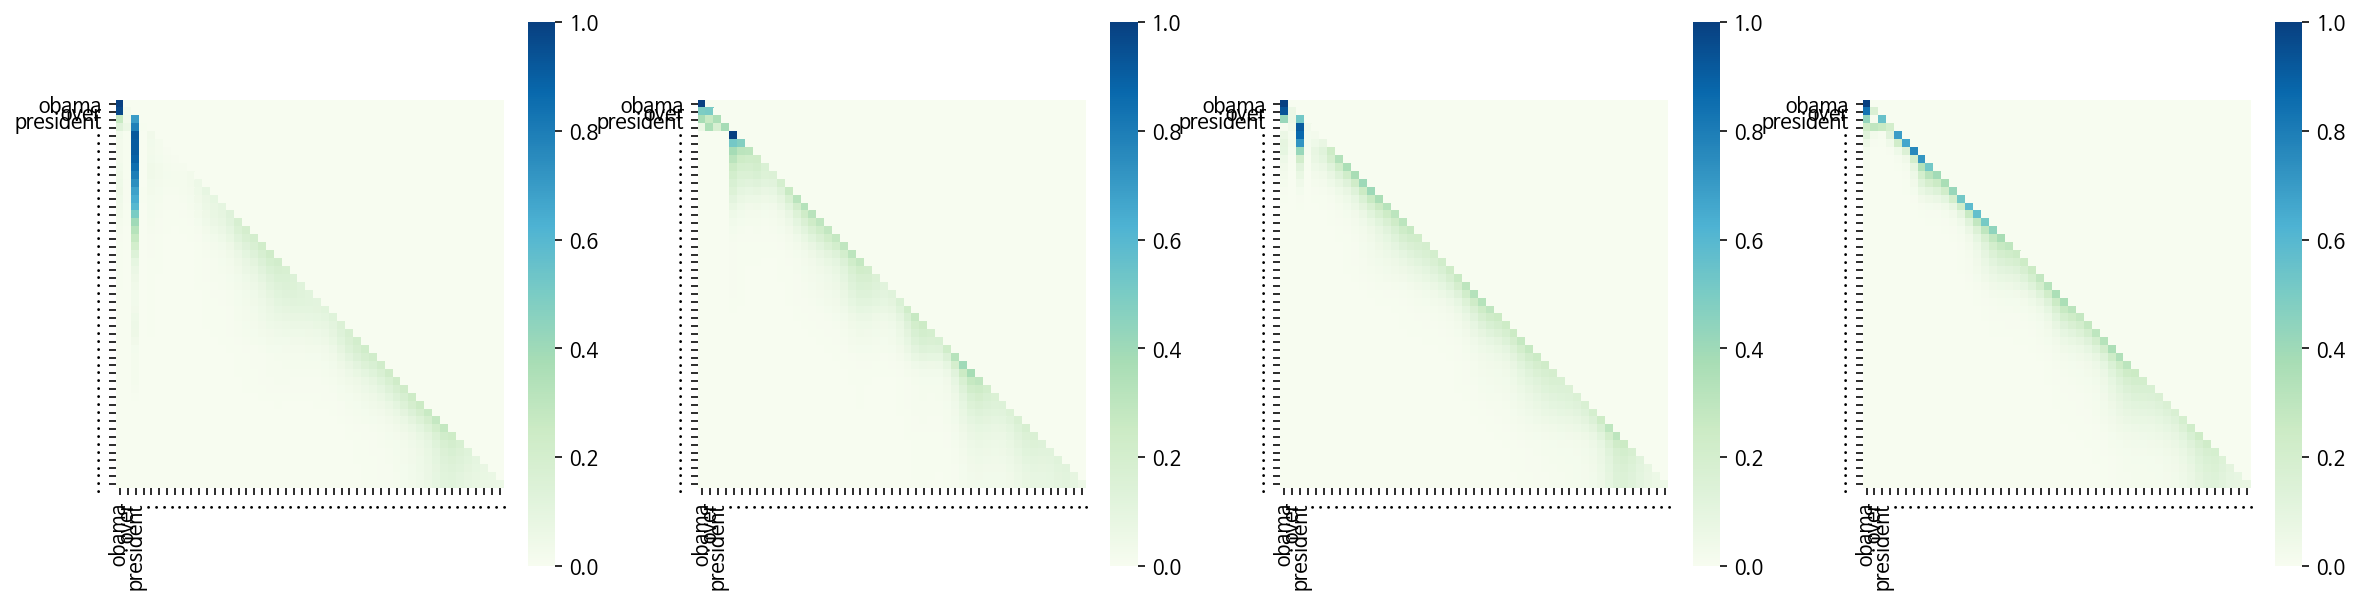

Decoder Src Layer 2


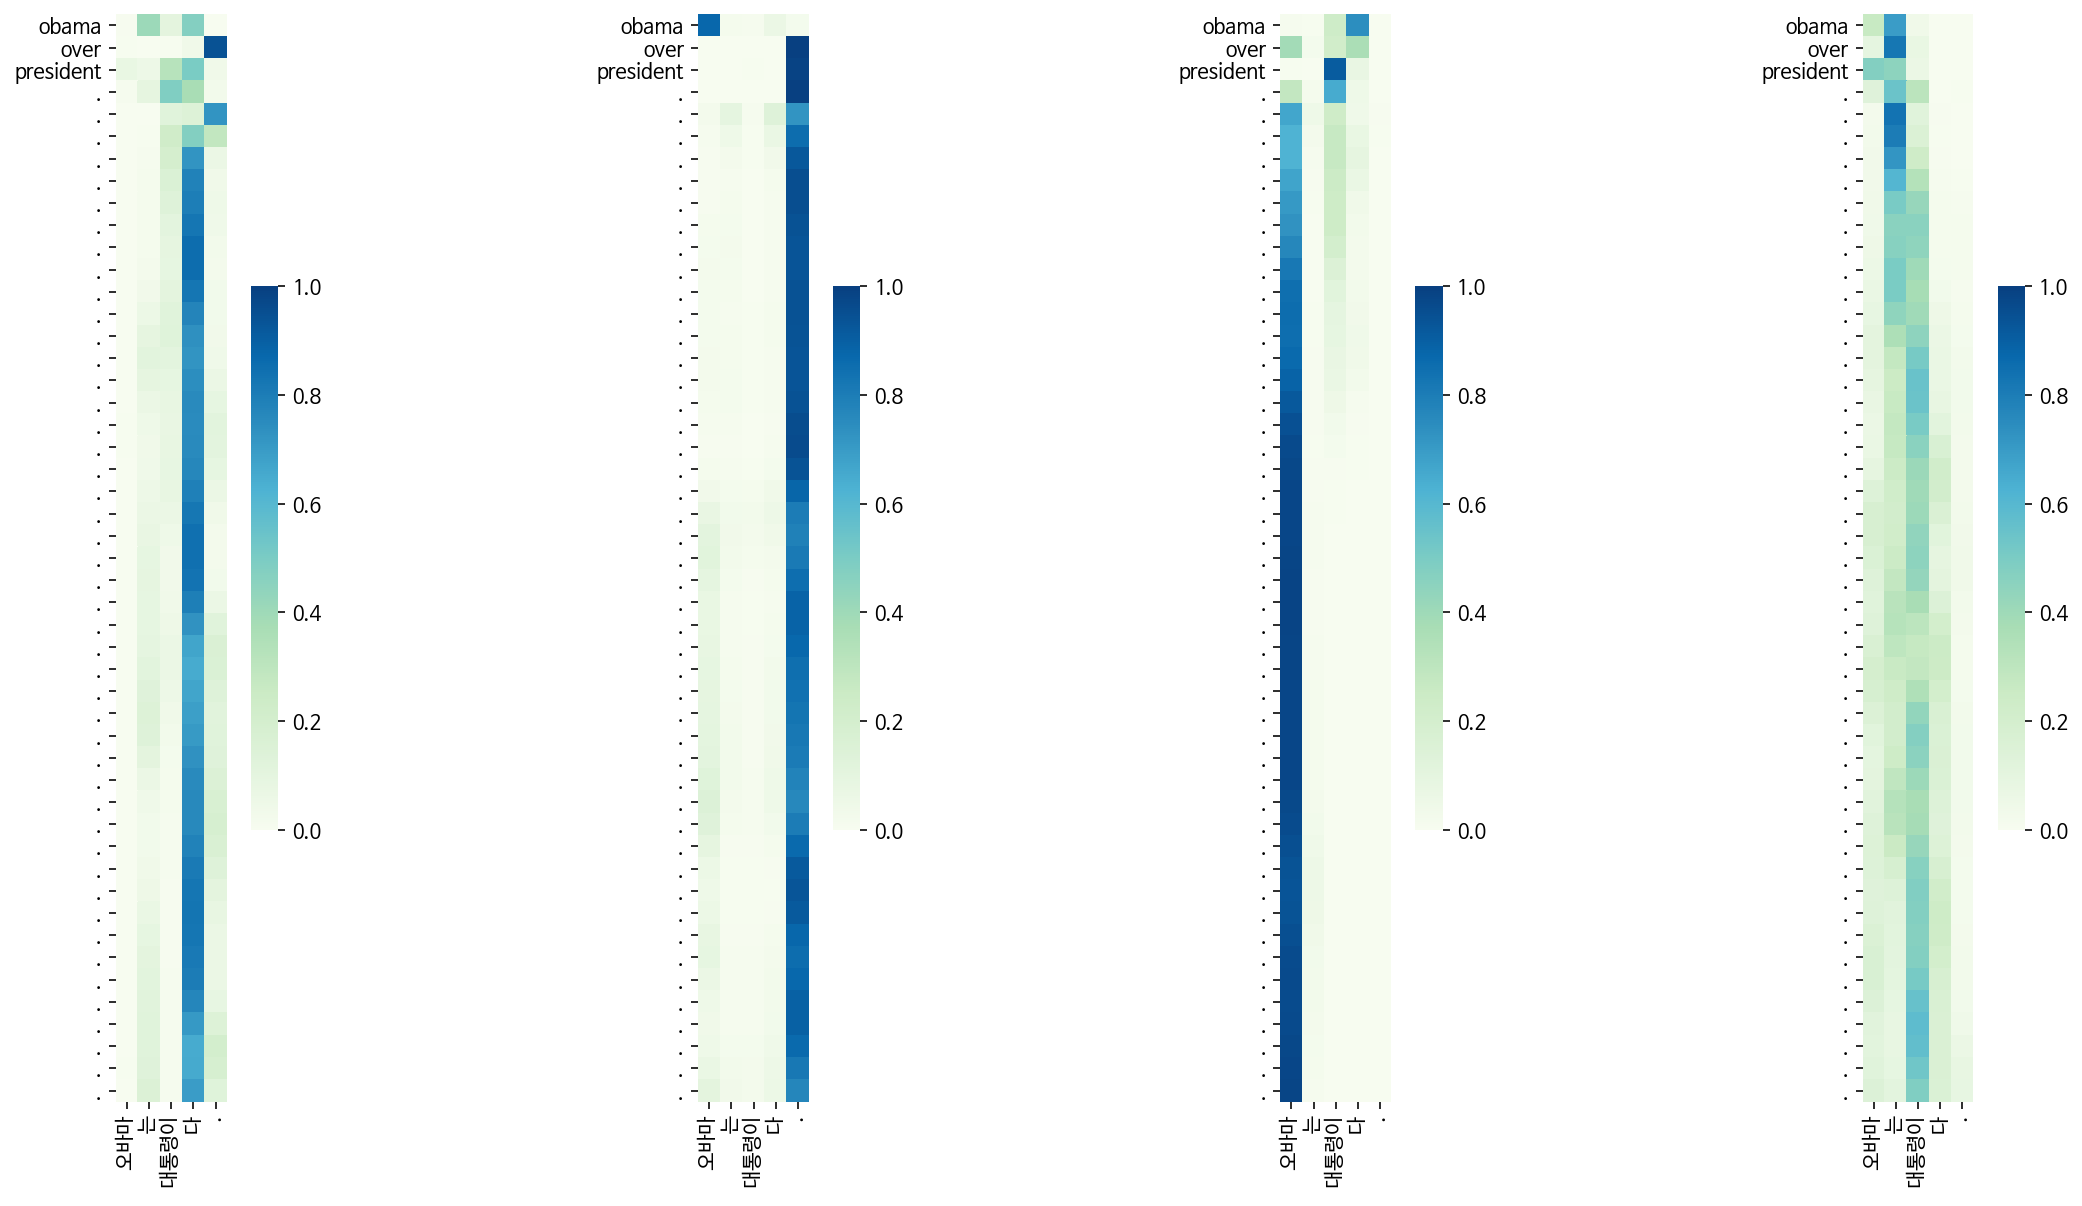

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people over the of of of of of the over . the of of people are . . . . . . . . . of to . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : don any any any coffee no is . no coffee coffee coffee . is not . not coffee . no is . no . . no . . . . coffee is . . . no . . . no . is . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven and people dead seven dead seven and dead were . . and . . . . . . . dead . . deads .s .ss .


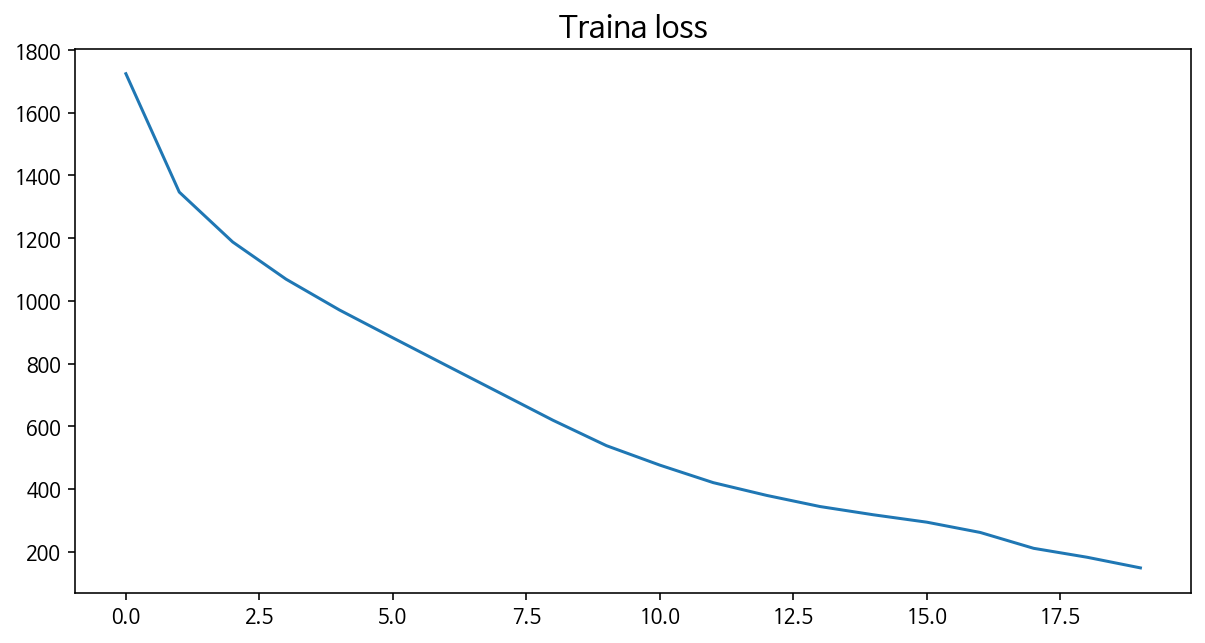

In [306]:
losses = train(transformer, optimizer, enc_train, dec_train, 
               ko_tokenizer, en_tokenizer, examples, 20, 256)
show_train_loss(losses)

#### [TRY2] EPOCHS = 40

  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=0 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president president president president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people .   har well  . . well . . . . . are . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no coffee drink drink coffeess coffeess coffee .s drink coffee coffee coffee . is . . . . . . . . coffee . does . . . . . drink coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven . seven seven seven seven seven . seven seven . seven . seven . . . . . . . . . . . . . . seven . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=1 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : city people are . . .  .   to   in this  town . this are . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : decaf wear decaf decaf decaf decaf decaf coffee coffee need coffee coffee is . need . application coffee . coffee . is . . . . . . . . is . . . . . . is . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven . seven . . seven . seven and . . and have dead . . . . . . . . . . . and . . . all it . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=2 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama call .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people in regulate urban . are . . . . . . . . . . . are . . . . . . . . . . . . . . . say .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee does coffee need need need need need . coffee coffee . application application application coffee . is . . . . . . . . . coffee . is . . . . . . . . coffee . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven . people seven seven seven seven seven seven seven . seven seven . . seven . . . . . . . . et


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=3 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are well to to to .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee does coffee does cup cup cup cup cup cup cup coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven were                  thursday . dozen


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=4 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people over say are . are are are are are . are are are are are . . are are . . are . are . say . are . . . are . . are . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee does not not coffee . not
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven . seven seven seven . . . seven . . . . . seven . . . . . . and   . . . said admitted admitted admitted admitted admitted .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=5 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people violent urban are . to . . to . . to . . . . of
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee does coffee coffee coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven . seven seven . seven . . . . . . dead . . . . . . . . . . . . . . . . dead were . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=6 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama                 . . . . . . obama . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people and are to to to well to urban . the the the the  . . . . in  . . the . . . . . . the . . . . . . is . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee does . . does . cup . . . cup . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven . were . .      .   . seven people ing . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=7 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : city urban the city urban the in city city the i there urban the . the the the is . . . . . . . . . . . . in . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee does not coffee coffee coffee not cup cup
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven were                    and all were . dead . . . .  thed . . 


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=8 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : are in in to every key . say are . in . are . . . . say . are . . . . . . . . say areant . areant . . . are . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : decaf standing standing
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven were seven . . . . . . seven . . . seven . . . . . . . . . . . . all seven seven and seven . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=9 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Encoder Layer 1


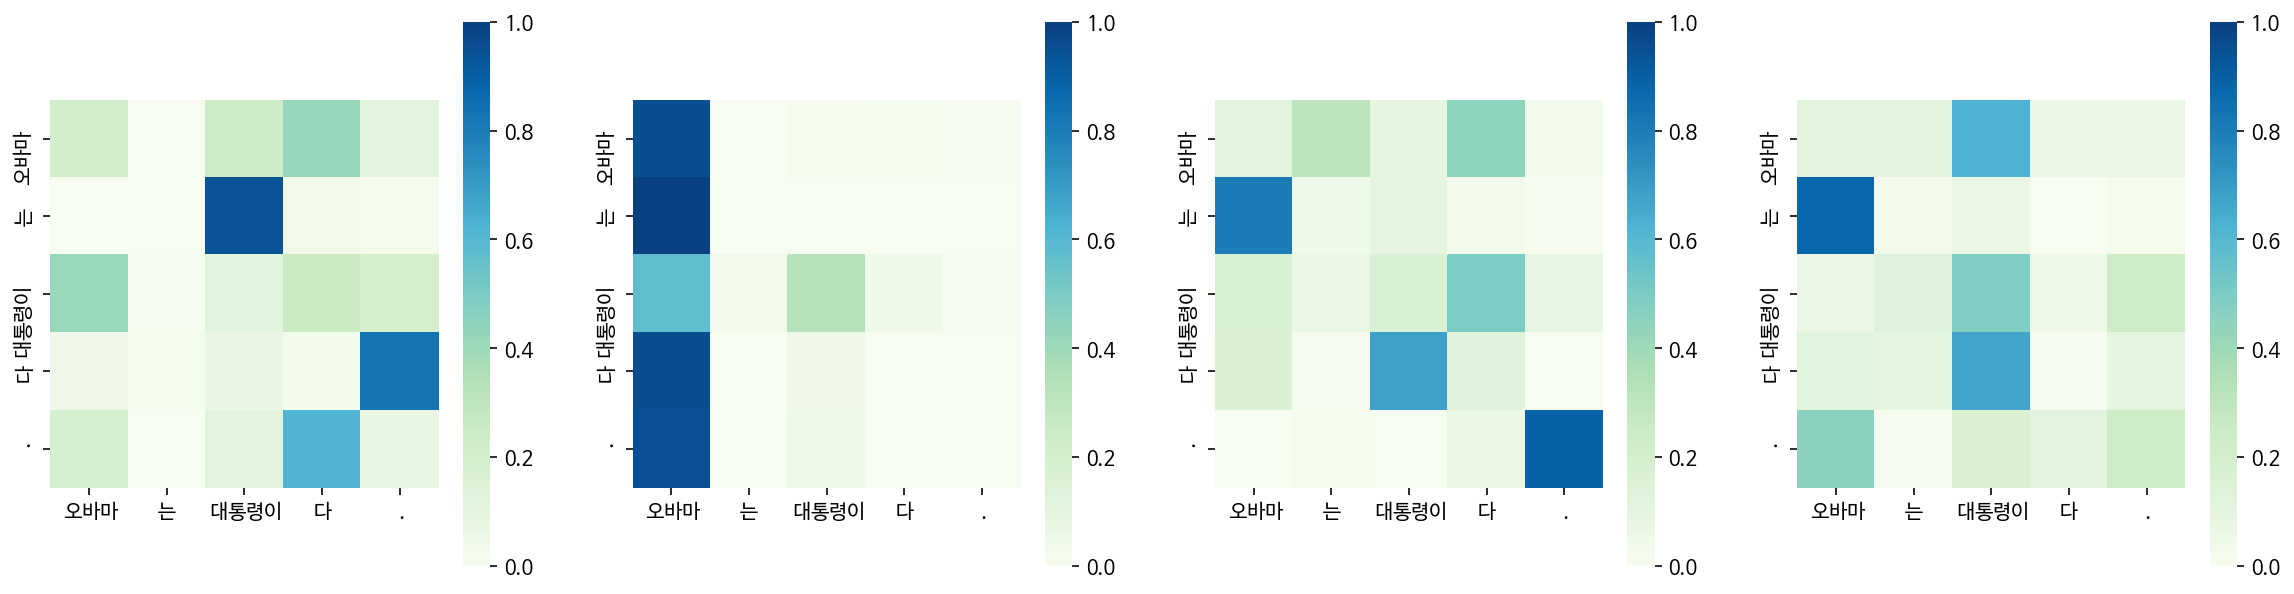

Encoder Layer 2


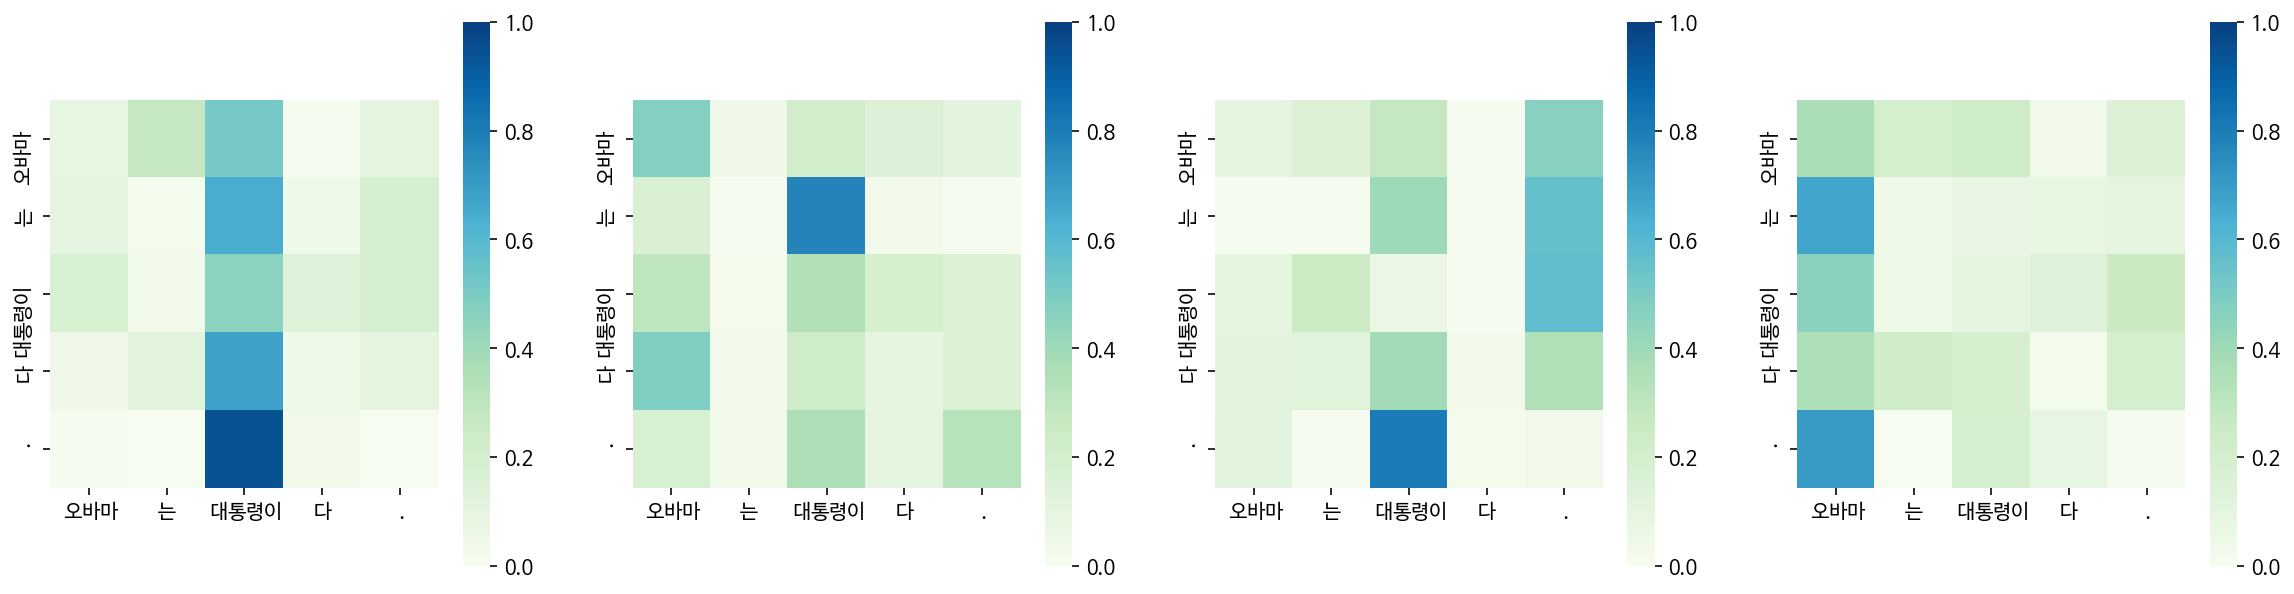

Decoder Self Layer 1


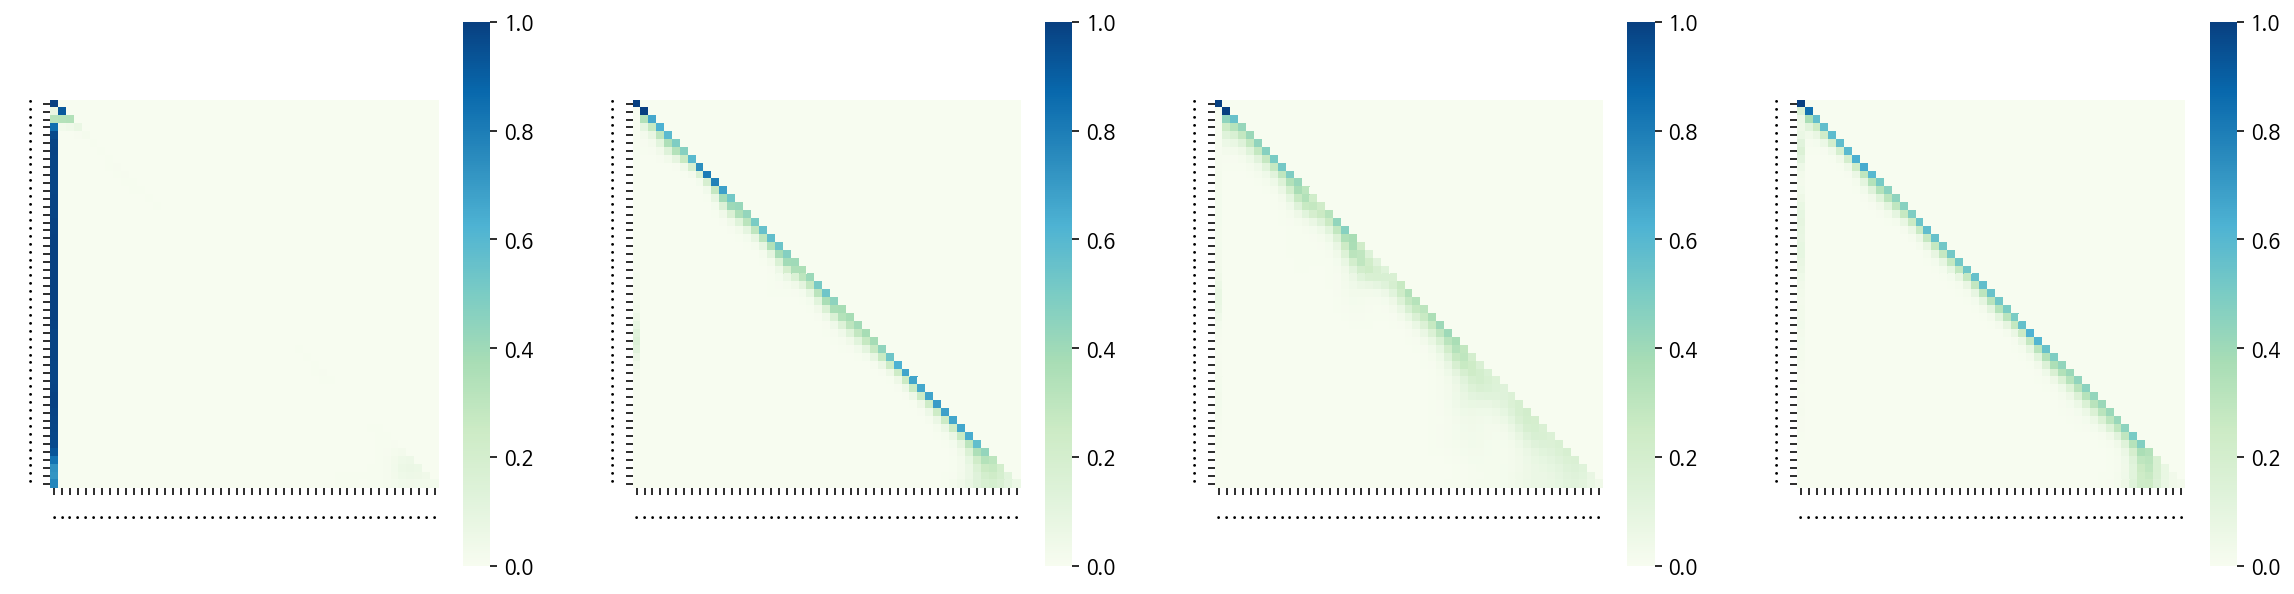

Decoder Src Layer 1


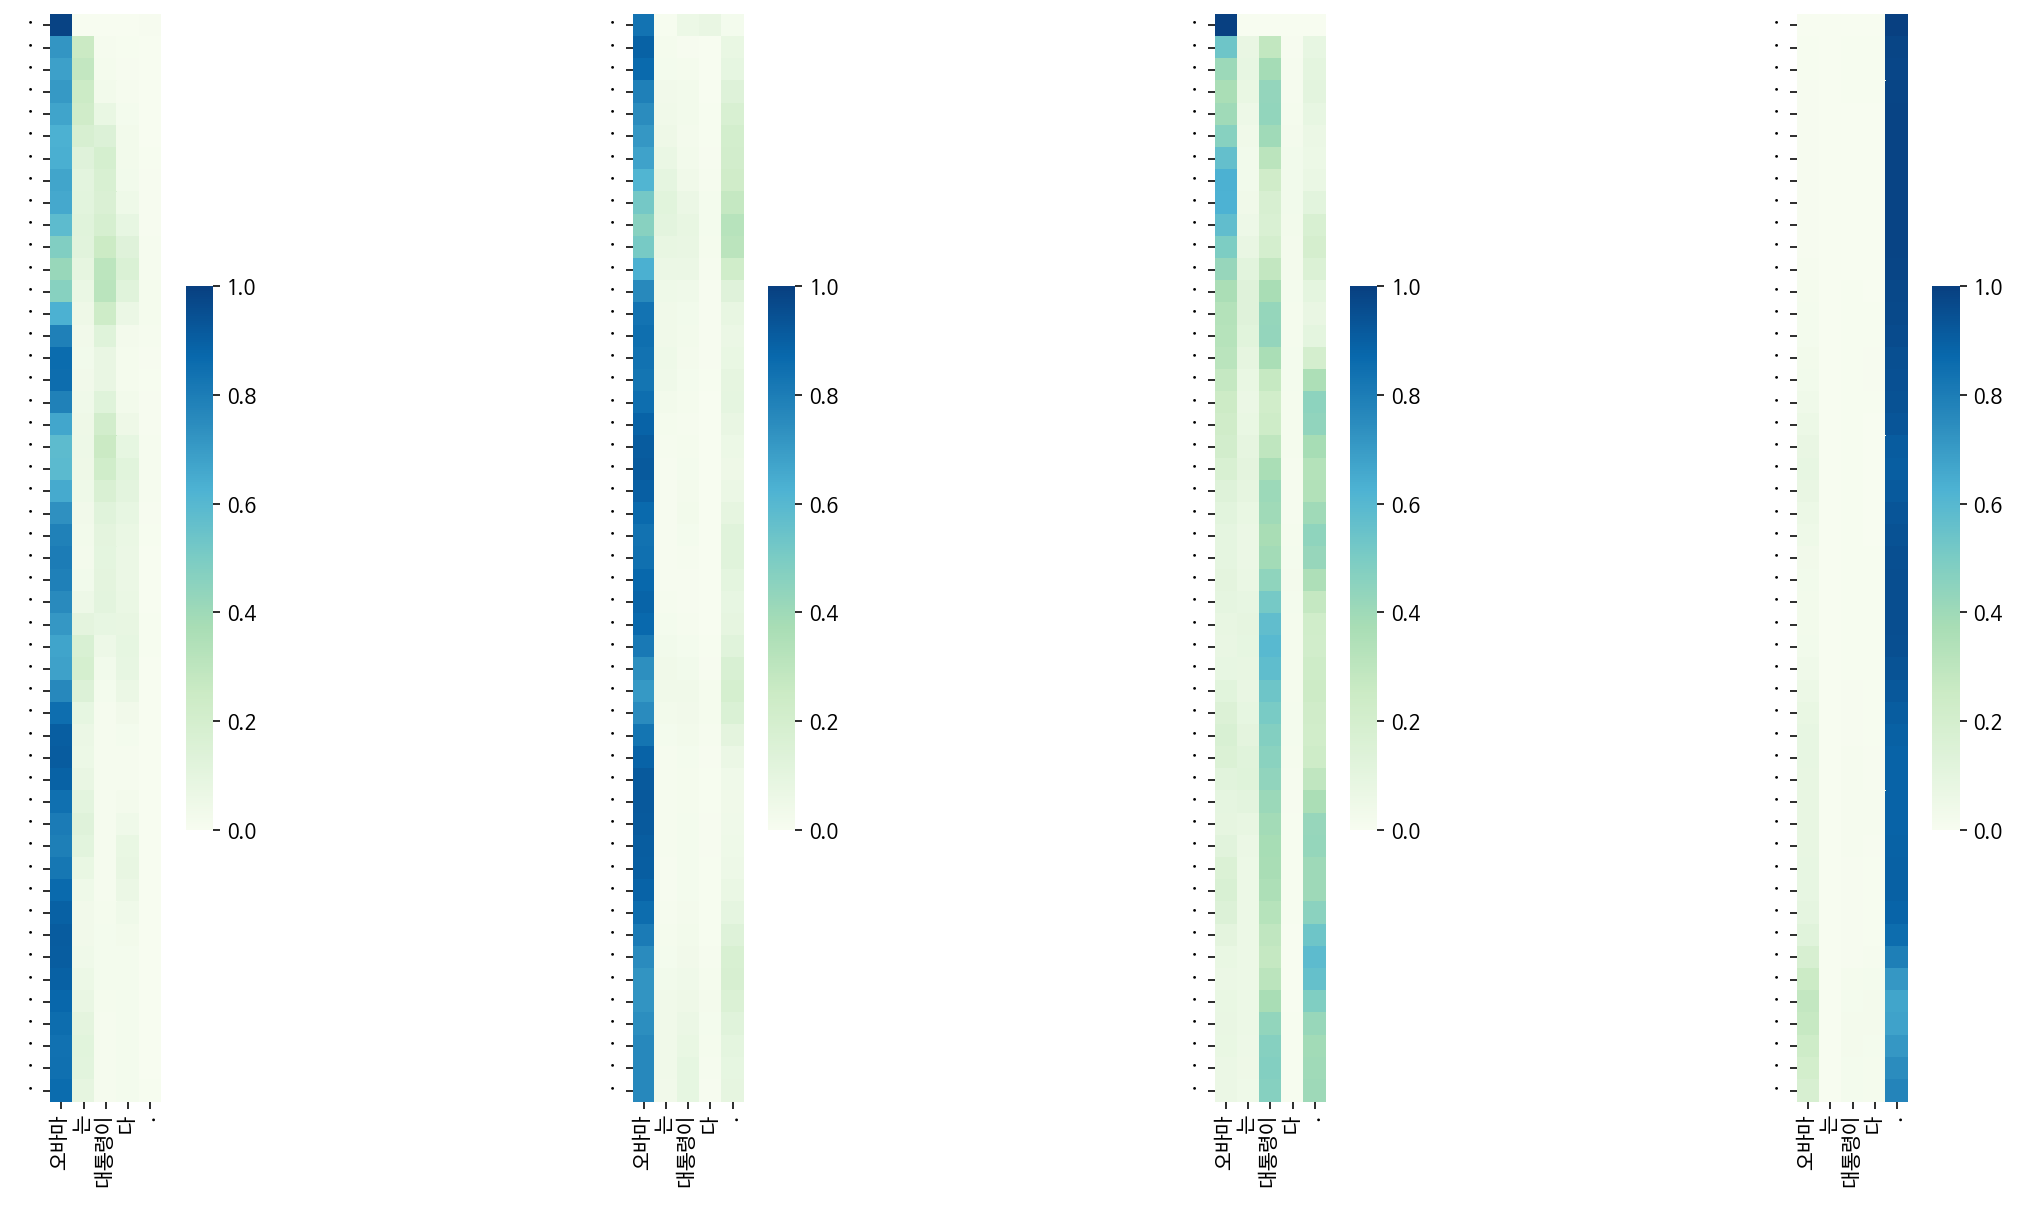

Decoder Self Layer 2


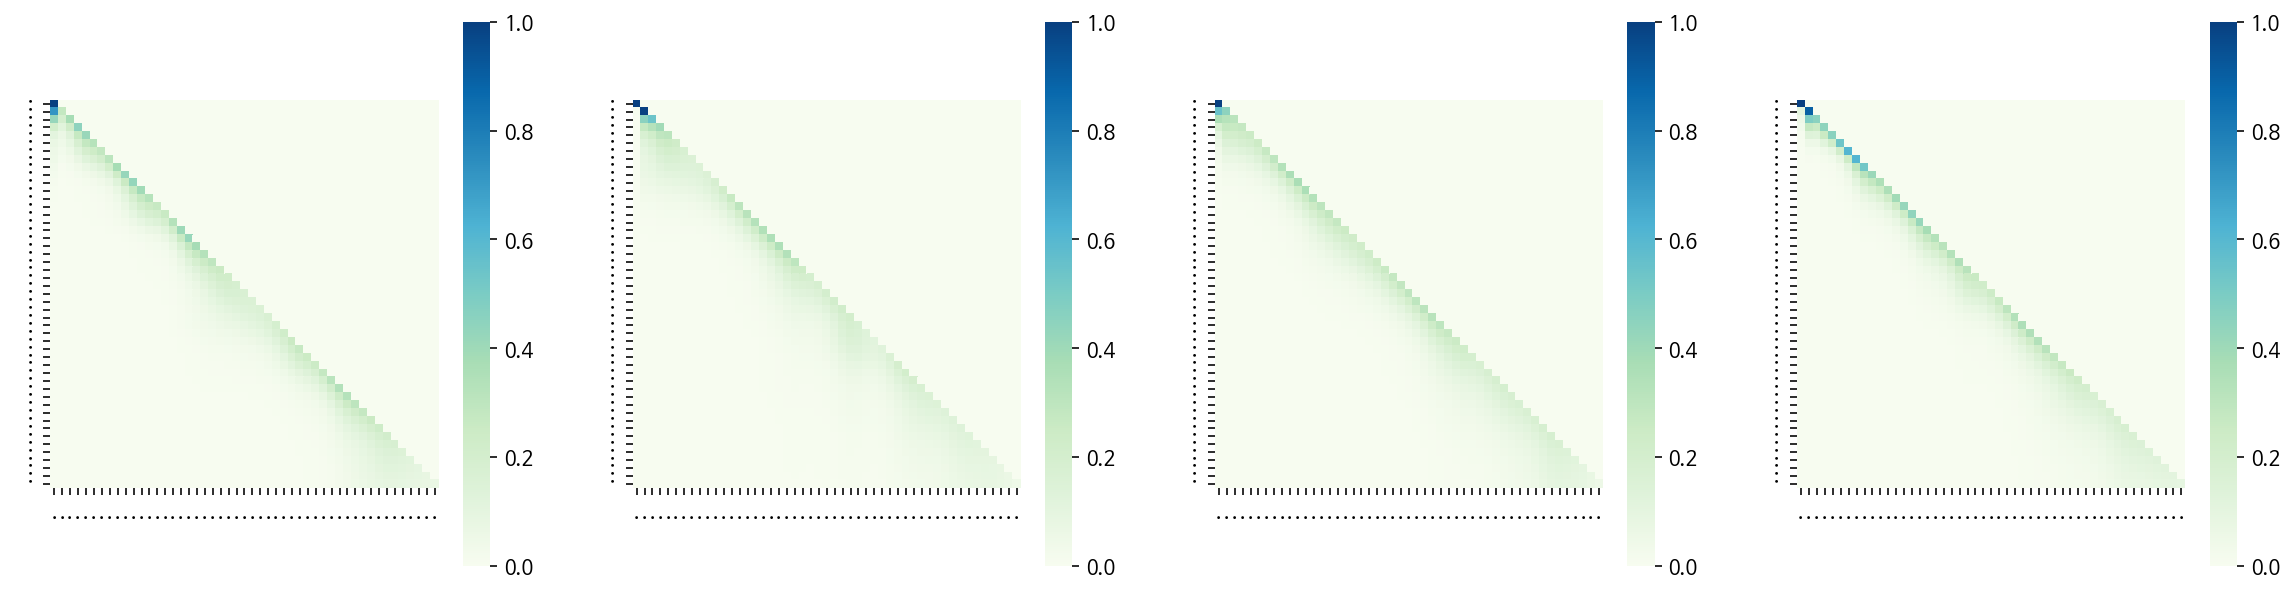

Decoder Src Layer 2


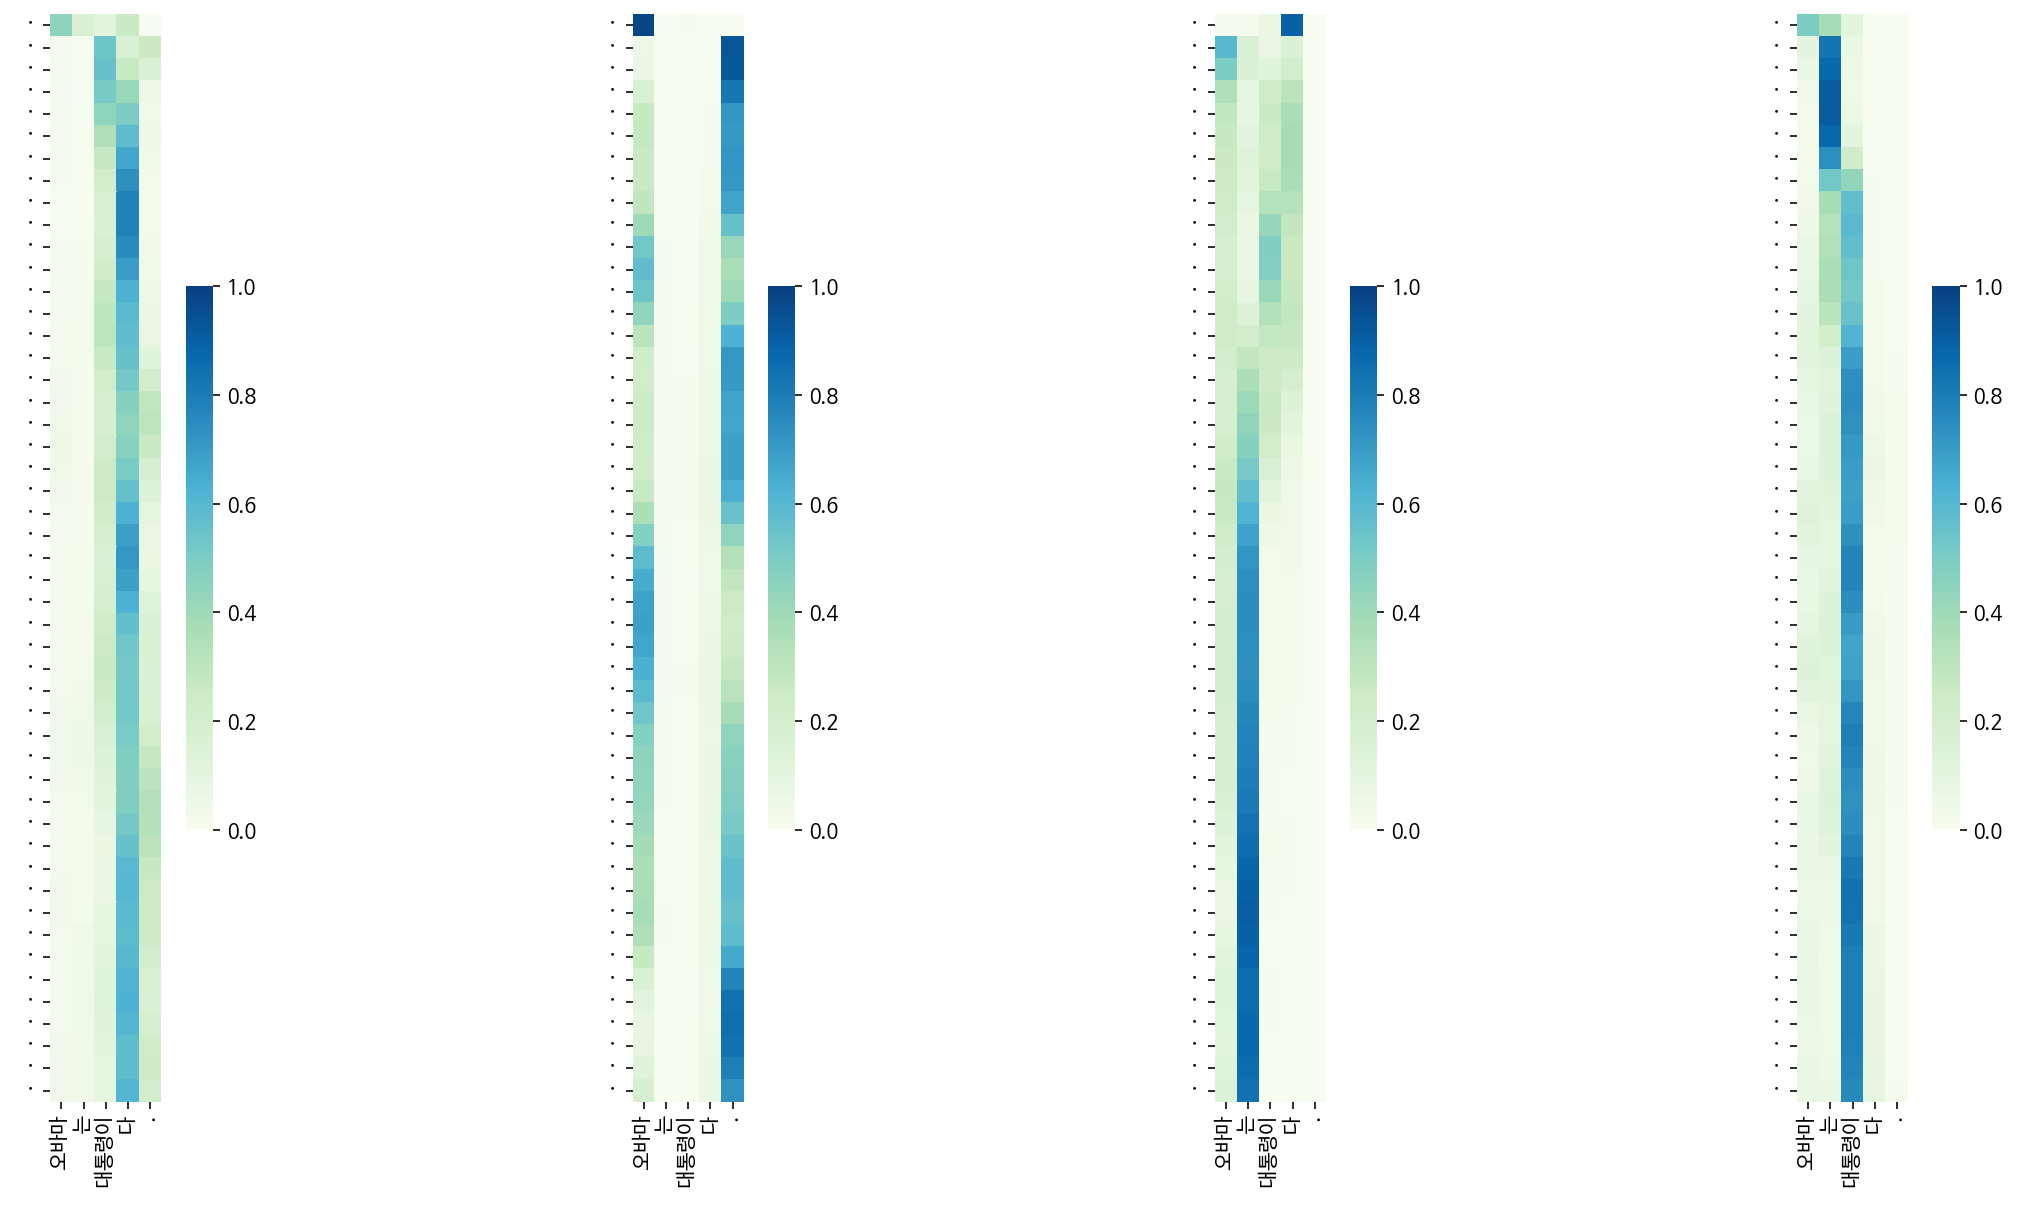

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are well . . urban .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee coffee coffee coffee does coffee coffee . coffee coffee coffee coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven were . . thursday . . seven . . . . seven . them . dead . . dead dead dead dead dead . dead . dead dead . every . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=10 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : urban says overs ben . sayssss are . . . . in say . ben is . . say say are . . . . . said ben
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee does . does coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven . were . .   . .      . seven . . . . seven . seven . seven . said


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=11 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : city the near are the overflow city city overflow
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee coffee coffee coffee does
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven and seven seven after seven and seven . seven . . . . seven . . . seven . . . . . . dead . . . dead . or . . . the have picked . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=12 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . god . . . . . . . . . . god . . . . . . . . . . . . o
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : cit cit cit cit cit urban say stands downs
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no no coffee does . coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven were dead . . . . . . . . . you .s .s . you . you seven . . . every . . . . . every . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=13 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . being . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : cit cit cit urban in urban people to urbans over . are . . . . . in . . . . ⁇  are . . . . are . . . . in . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no no coffee need
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : nine were           thursdaydddd   . thursdayddrrr    d   d and slamm . . .ed . . . . . . every .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=14 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : city the people the and the the in the the city the every . the city . the every . . . . . . say . . . . is . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven and people at the the nine and nine the and the nine and the the . you the the and you the all you it the sound it


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=15 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people in brita brita brita
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven them seven and them you and . them them them seven . died . . . . . . . . you . seven . . . . . . . dead and    said . number number . died . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=16 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people brita brita brita people in
🇰🇷 : 커피는 필요 없다.
🇺🇸 : don coffee no no
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven people . . nine seven . . . seven . and seven . . . seven . . seven . seven . . seven . . . seven . . . seven . . seven . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=17 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama barack as . . as . as . as . as . as . . obama . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are . in . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no does
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven them and them them he them . them them them he and temblor . . . . . . . . . . . . . . . . . . . . . . nine . . .s . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=18 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : are . to every in
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no is . need need need need to coffee . coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven . seven seven seven . . seven . seven . . . . . . . seven . . seven . . seven . . . . . seven . . . . seven . . seven . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[ EPOCH=19 ]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . ⁇  . . . . . . . . . .
Encoder Layer 1


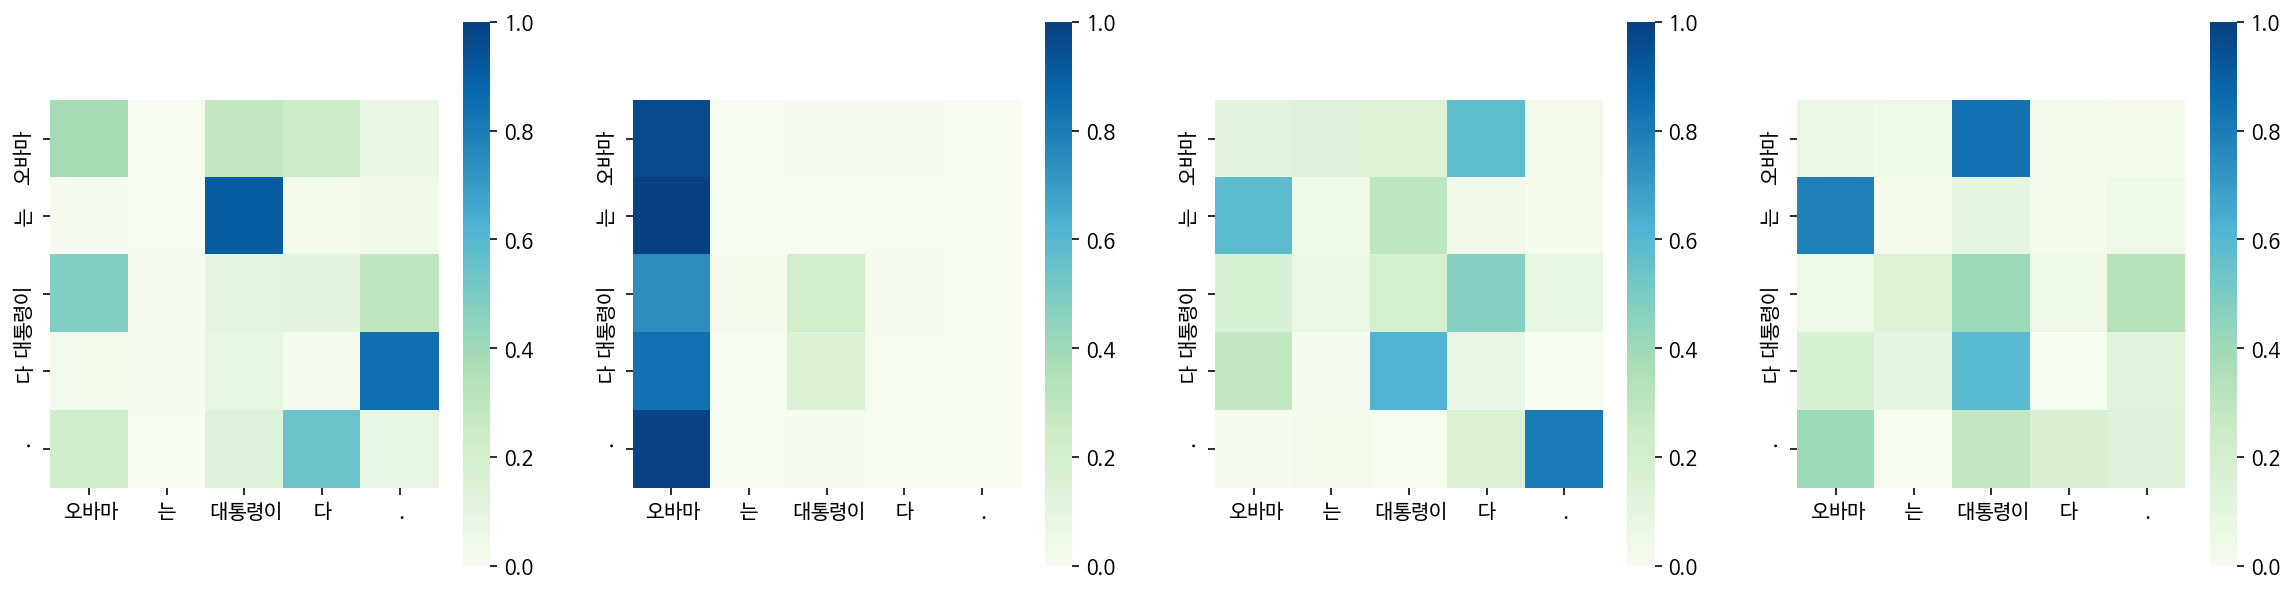

Encoder Layer 2


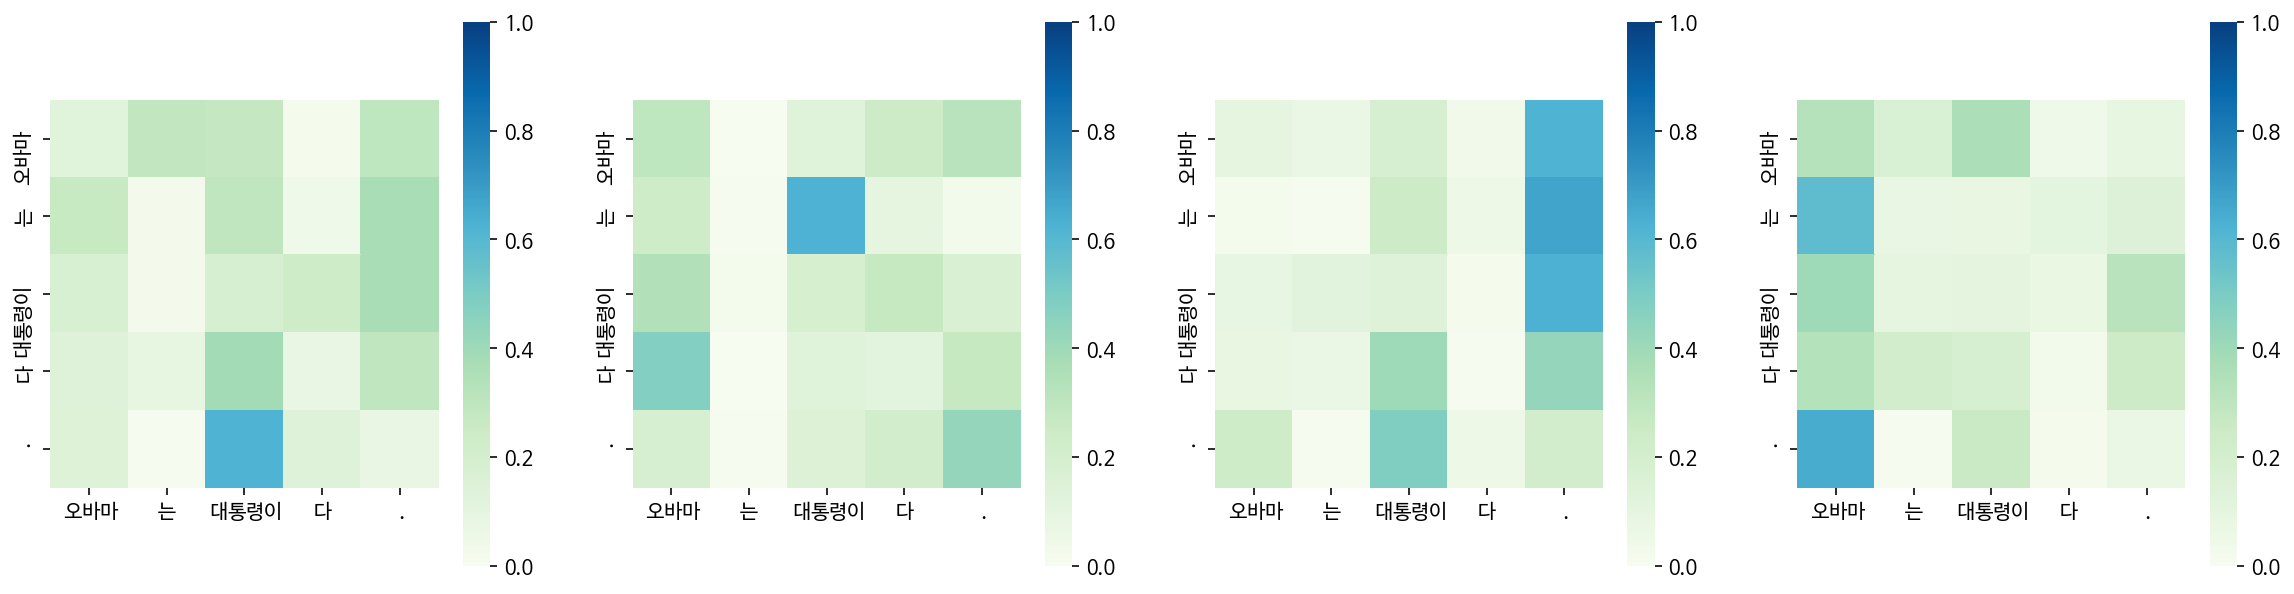

Decoder Self Layer 1


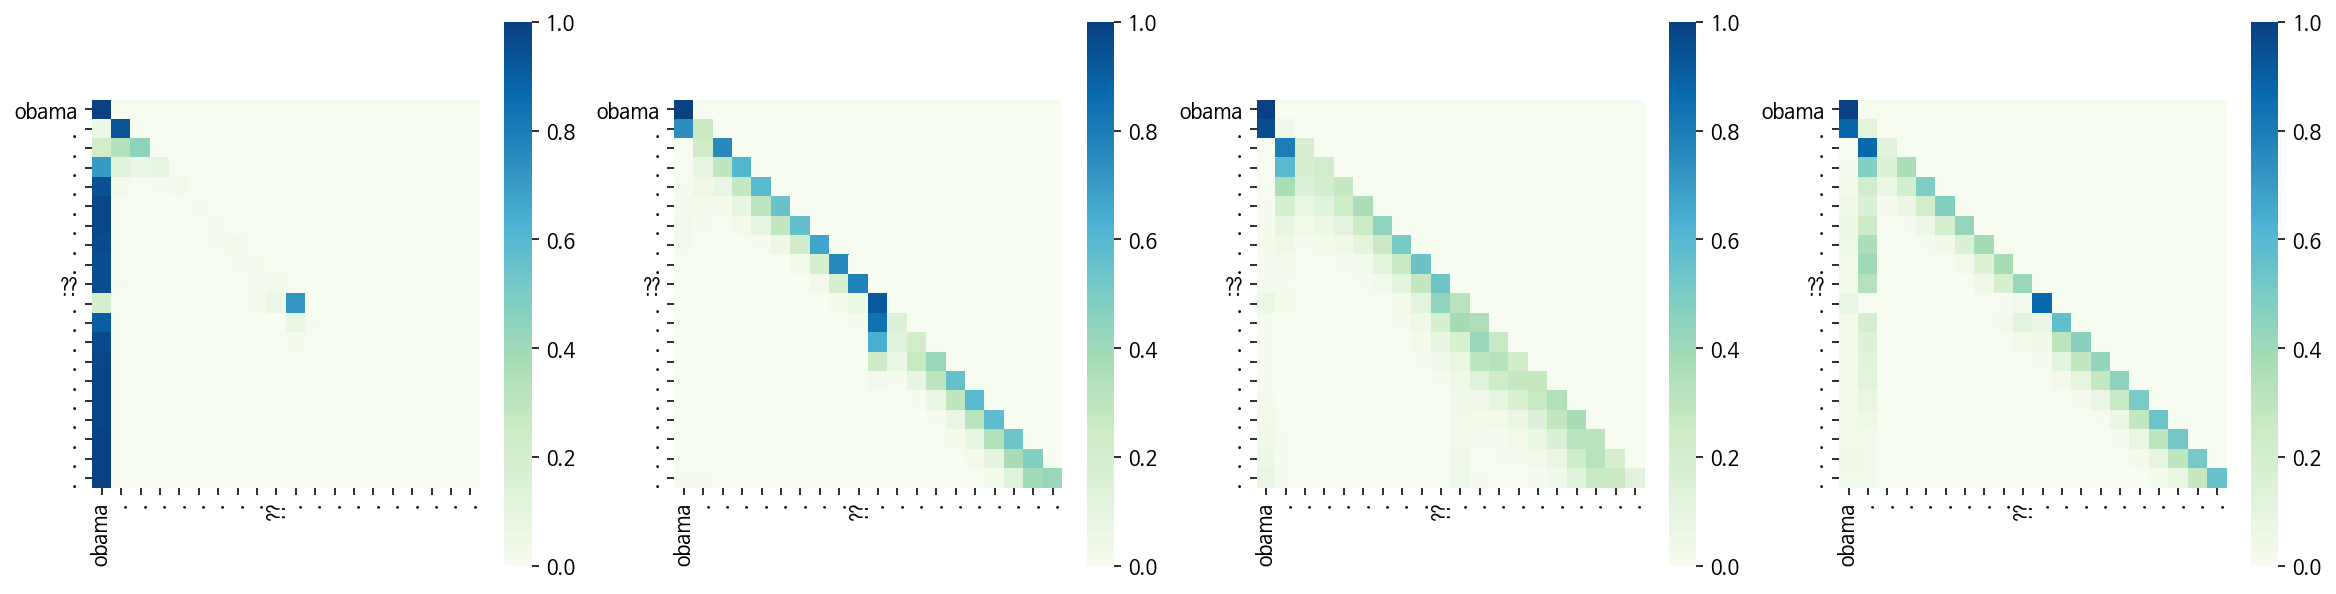

Decoder Src Layer 1


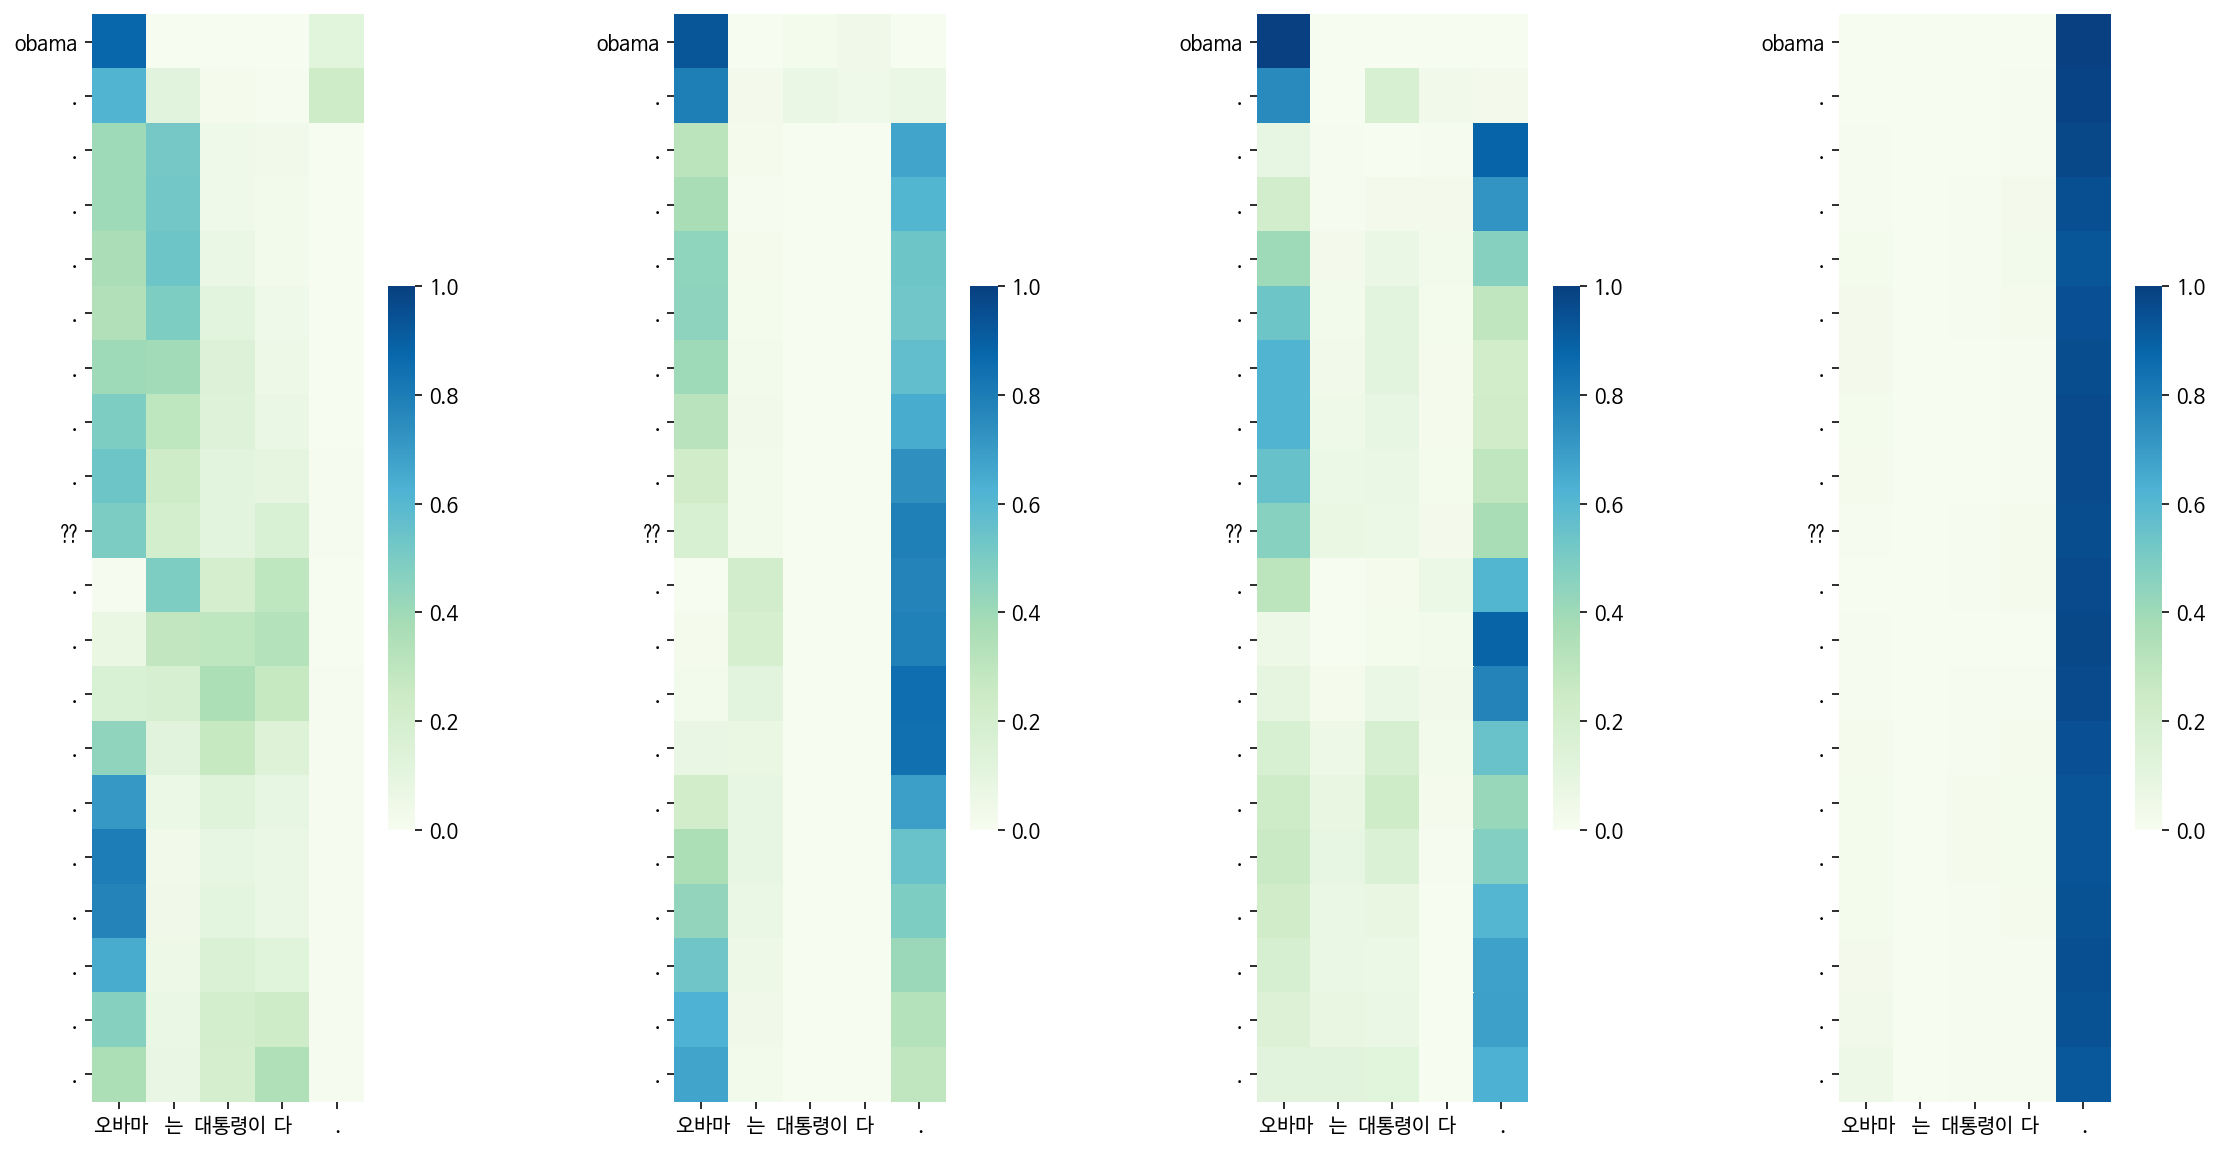

Decoder Self Layer 2


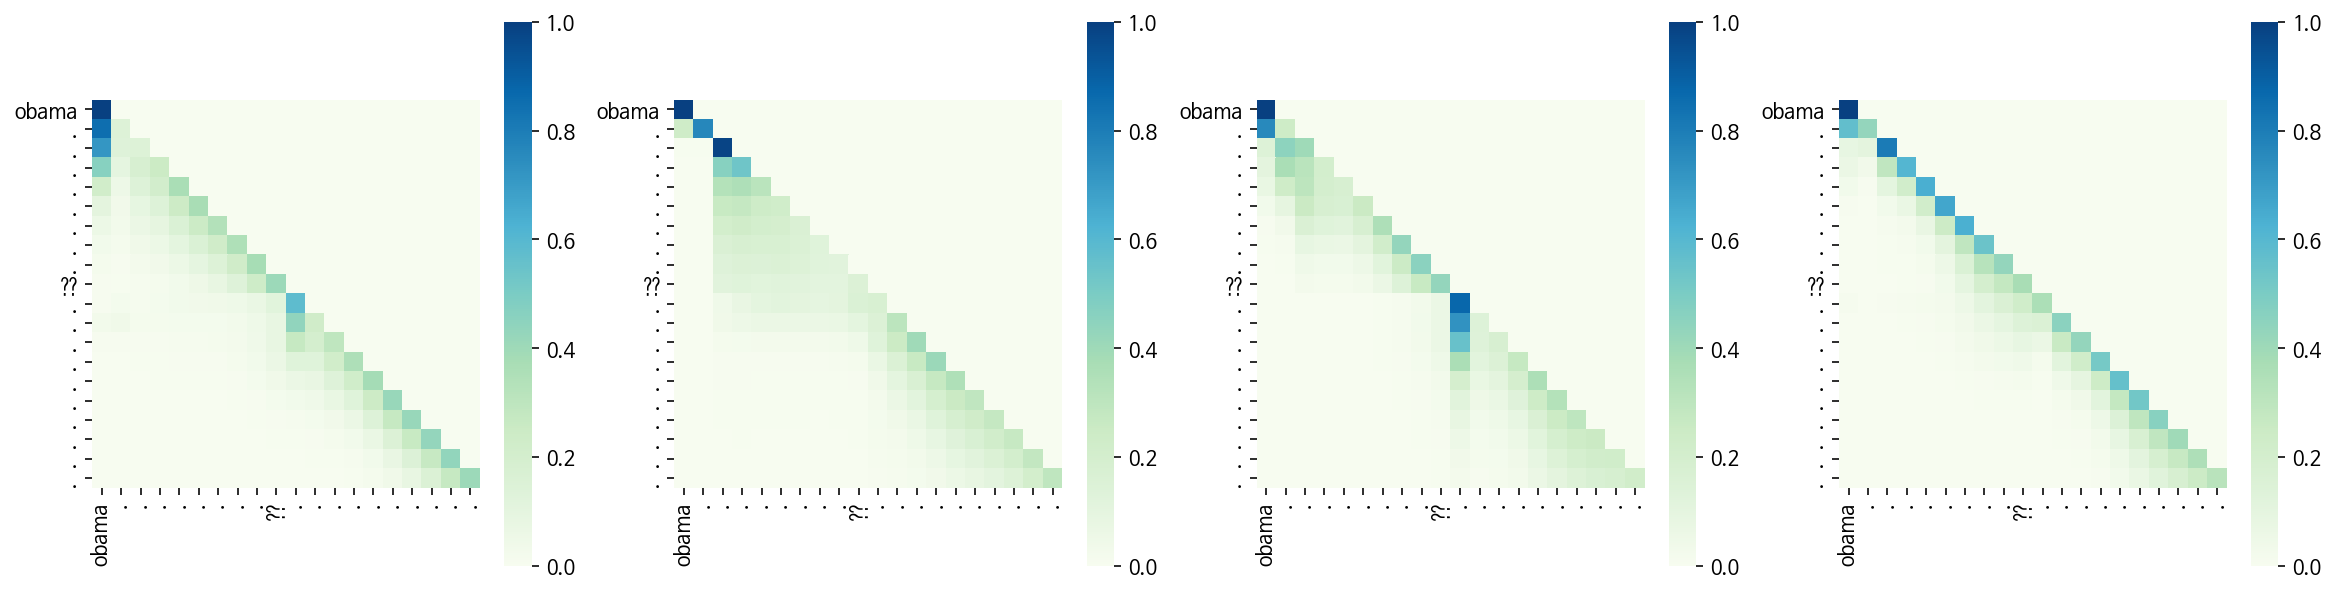

Decoder Src Layer 2


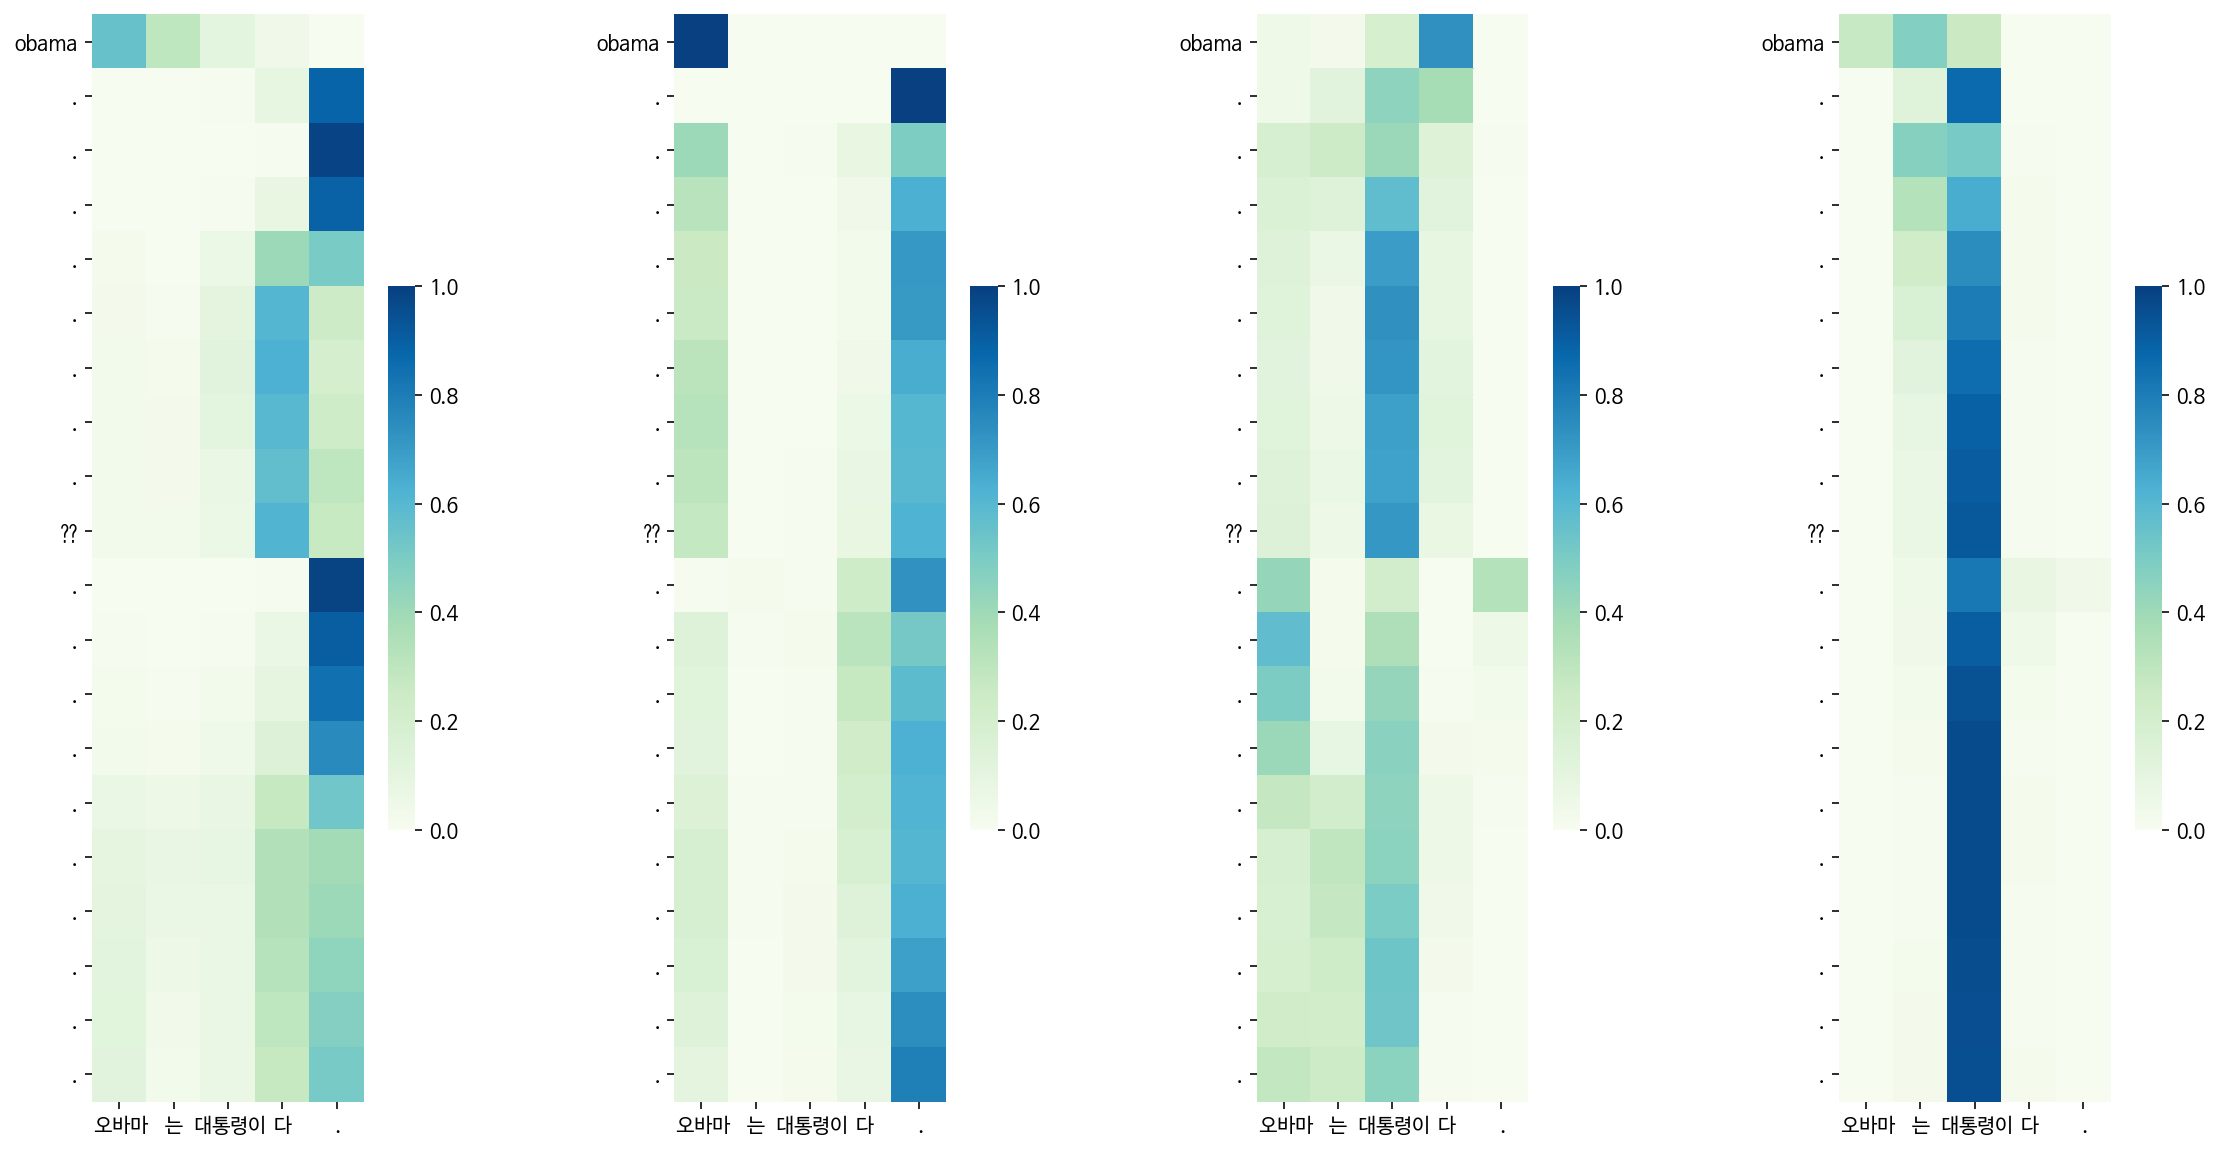

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : urban to among i urban people are . the the are . . . the . . . . the mountain has are . . . . . . . . . are . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no does .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven nine seven seven seven seven seven seven . seven seven . seven . seven . . seven . . seven . seven . . seven . . . . . seven . . . haveeded dead .


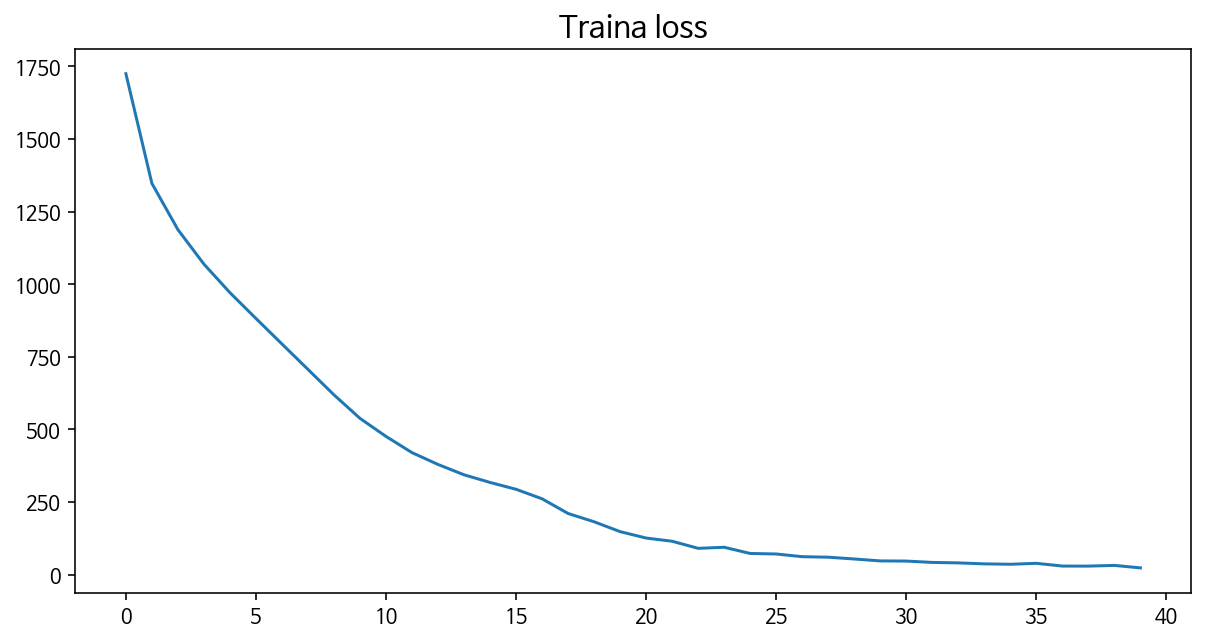

In [308]:
losses_40 = train(transformer, optimizer, enc_train, dec_train, 
                   ko_tokenizer, en_tokenizer, examples, 20, 256)
show_train_loss(losses + losses_40)

#### [TRY3] EPOCHS = 60

  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 1]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . over barack . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are . . . . . there are . . . every . . . every . . . . every . . . . . . . . . . . . . every . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no . does .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven . died . . . . . . . . . . . seven . . . . . . every . . . . . . . . . the died . . said .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 2]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . as . ⁇  . . . as . . . obama . . . is . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are . the . the . the . . to the . . . every . every . in every . . the . . . every . . . . every . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no does coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven . seven seven . seven them seven them . . . . . . we . we  .  . seven . said .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 3]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama over  president   . . .    as as as . as as as . as as . as . as as as . as . as as . as as . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the church citizens citizens are . . . . . . . . are . . . . . . . . . . . . . . . . . . . . . . every .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no is . . . need
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven and were         secur and . and and   . nine . and seven . . . . secur . . and . . secur and   seven . seven . . . . . . et . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 4]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : are . in every . every . in . . in every . . . in . are . . . . . . . . . . . . . . . . . . are . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee does . does does . does need need need coffee . need . coffee . . does . . need . . . . . . is . . . . . . . . . coffee . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven have and nine nine have nine nine nine nine the have on . talks . have   and and . seven . . . . . . . and have . seven . . . seven . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 5]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are . . . . . . in there are . . . every . in . . . . . . . in . . . . . . . in
🇰🇷 : 커피는 필요 없다.
🇺🇸 : don need need need need or need coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven and . . . . seven . seven seven seven . seven . seven seven seven seven . seven seven . seven . . . . .ing . seven . seven . . said


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 6]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : brita people are are in there the the the are there the the the are in . the th she say . are . . . are . . . . . . say . . are . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : don wear round need need need need and no . no .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven and seven seven seven . seven seven seven seven seven seven seven seven seven seven . seven seven seven seven seven seven seven seven . seven seven seven . seven seven . people . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 7]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . he . . . . . . . . .     obama . . . . . . . . . is . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : church urban help urban are . spot . spot .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : nothings . need no need need need
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven and seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven . seven seven seven peopleing andinginging . bettered . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 8]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : brita people know th th th th th th are . every in every . every . know know are . . . . . are . . . . . . . . . . . every . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : no . . don . don need need to need to to
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven . seven seven seven from seven seven seven seven . seven seven seven . seven . from seven . seven . seven . . said


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 9]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are spot . spot . say spot spot spot spot spot
🇰🇷 : 커피는 필요 없다.
🇺🇸 : . no . . . . don . . don . . . . don . don need need to need
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven were . .    . . . . . . . seven . . . . . . . seven . . . . . . . . seven . . seven . . said


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 10]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . barack . . . . . .
Encoder Layer 1


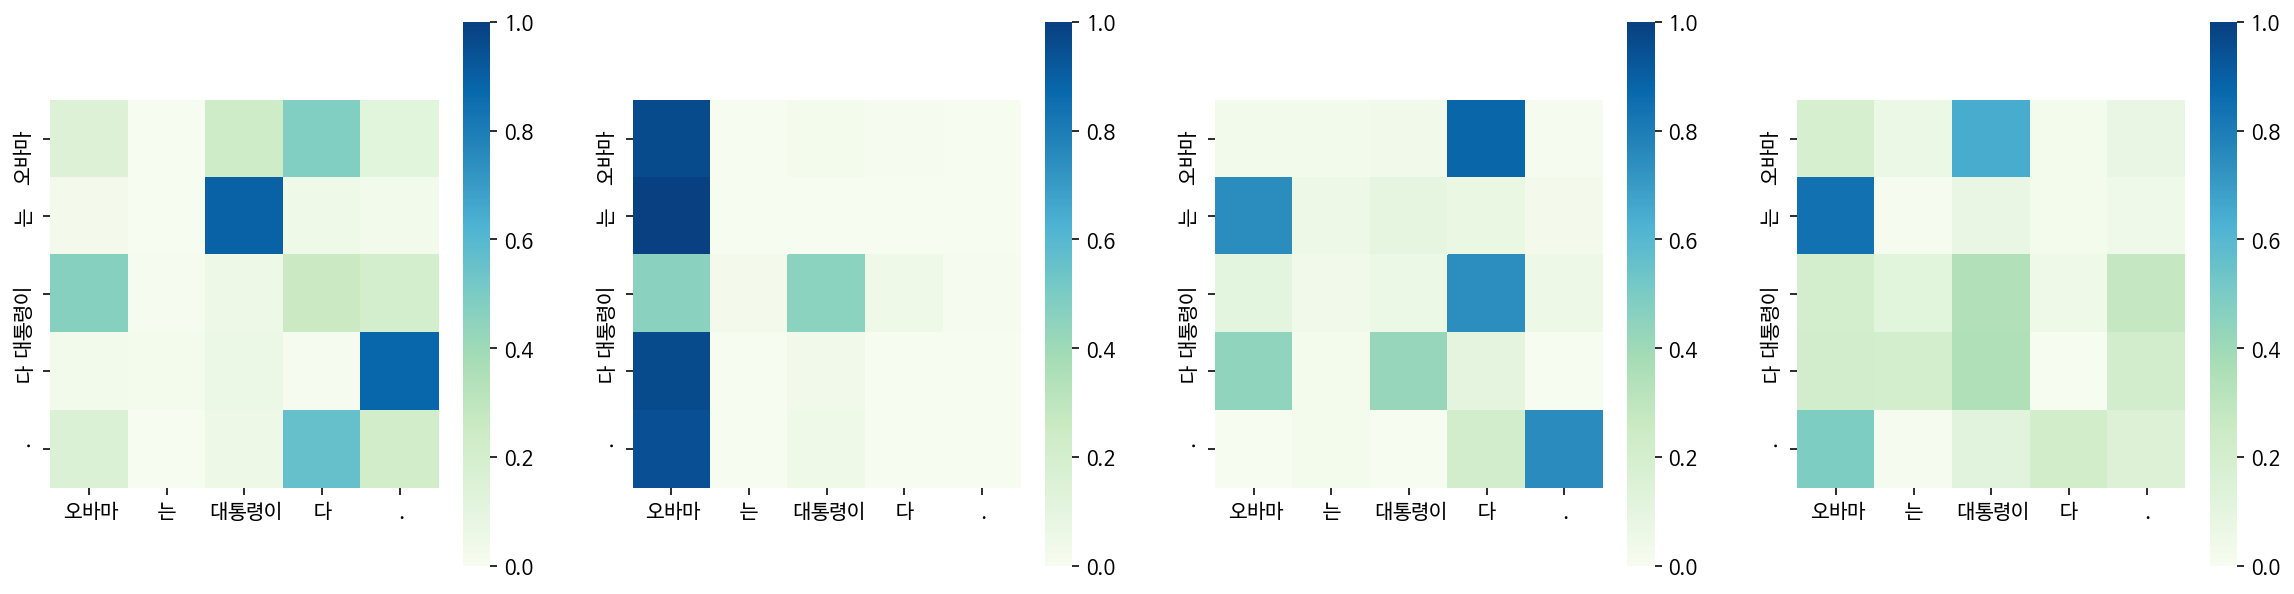

Encoder Layer 2


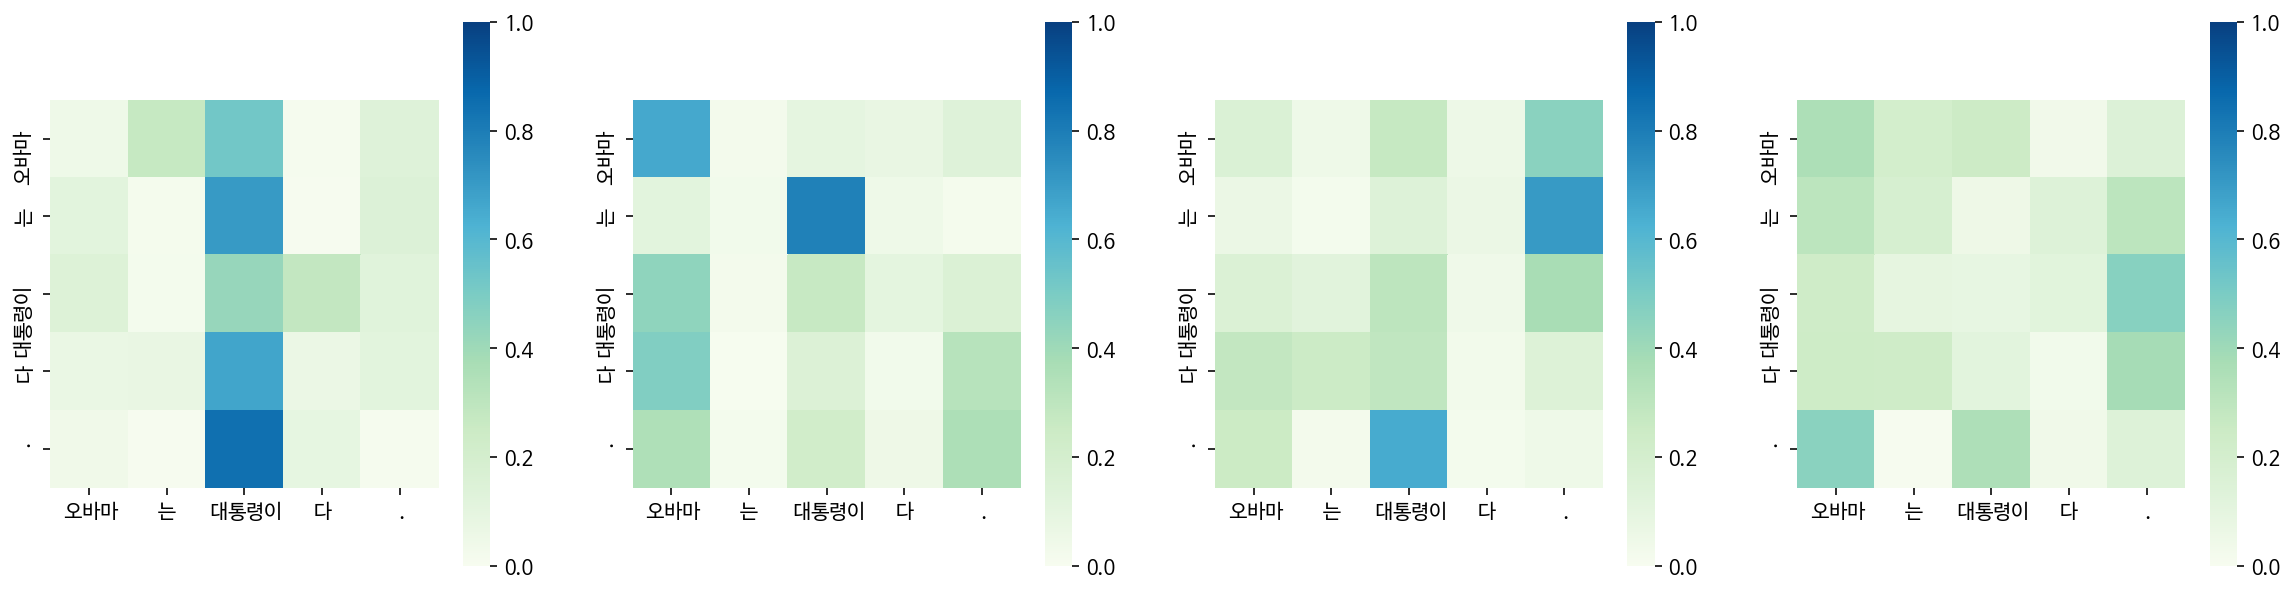

Decoder Self Layer 1


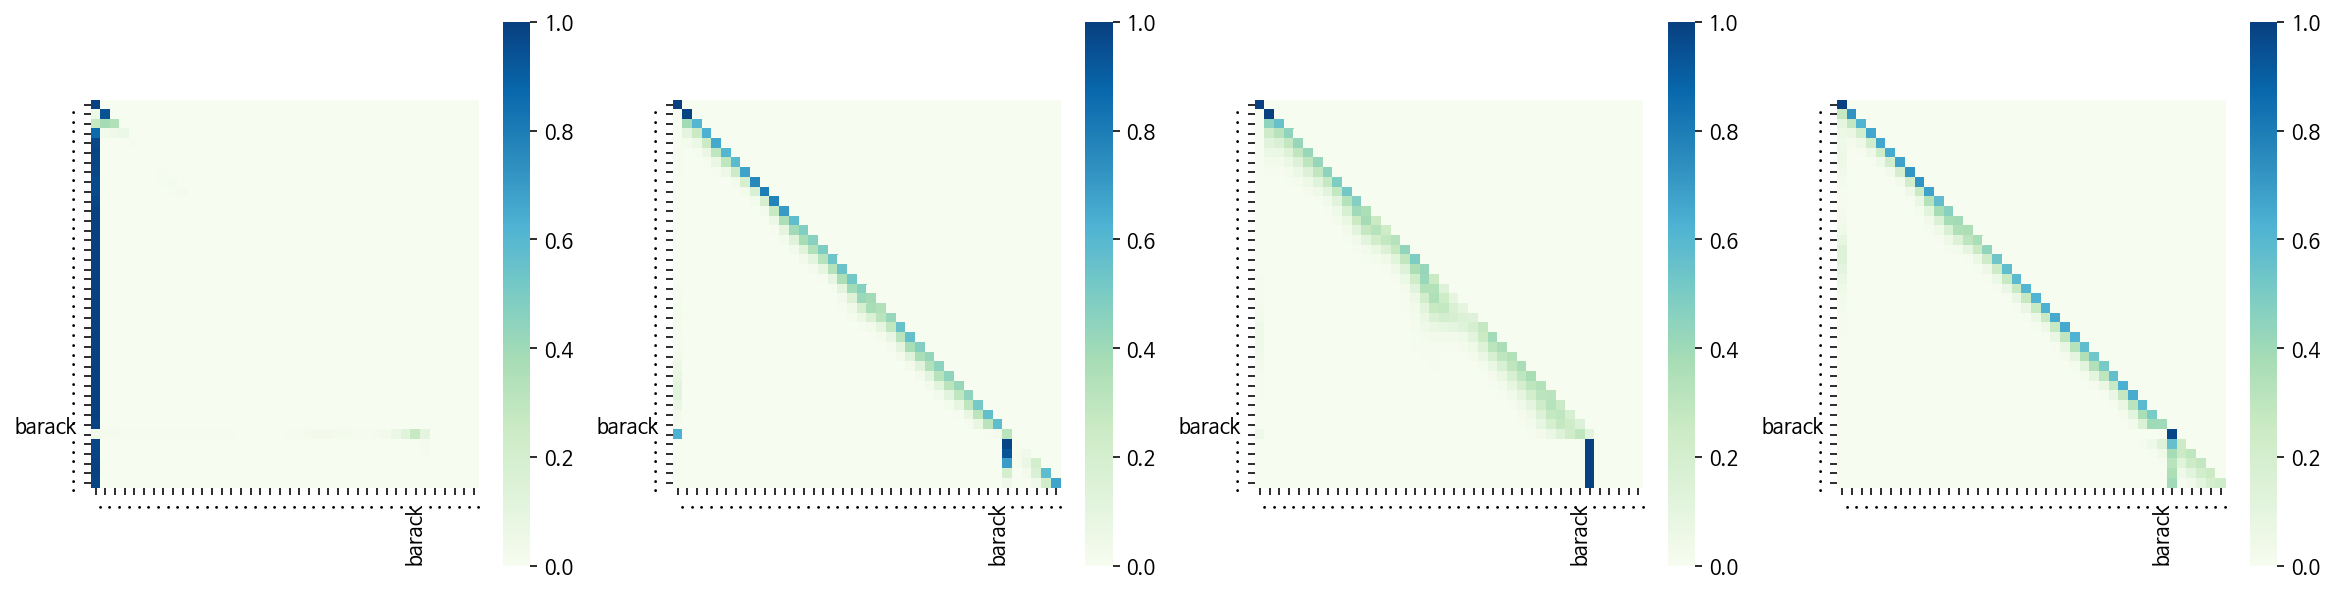

Decoder Src Layer 1


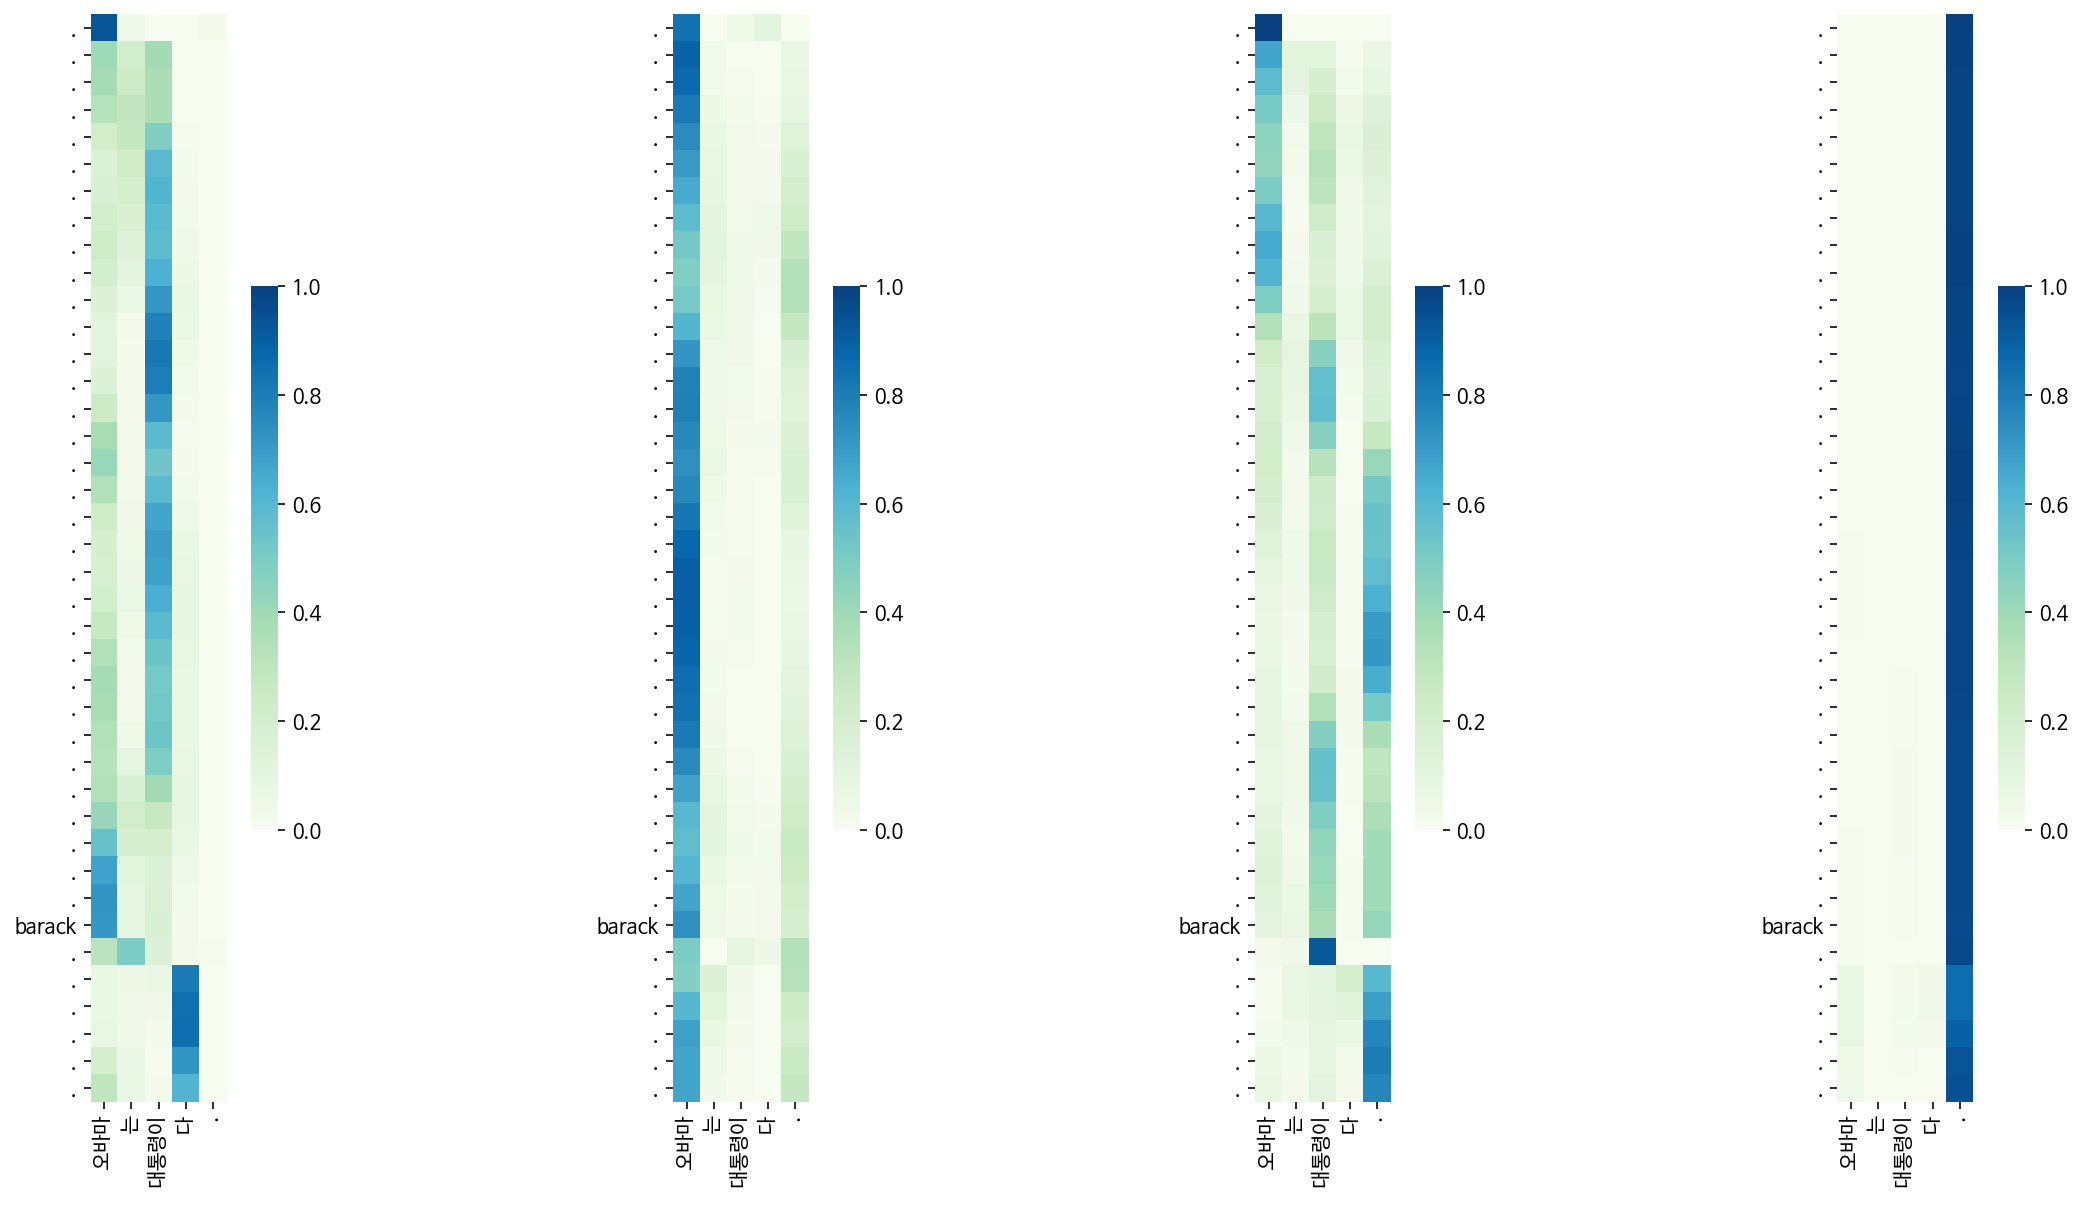

Decoder Self Layer 2


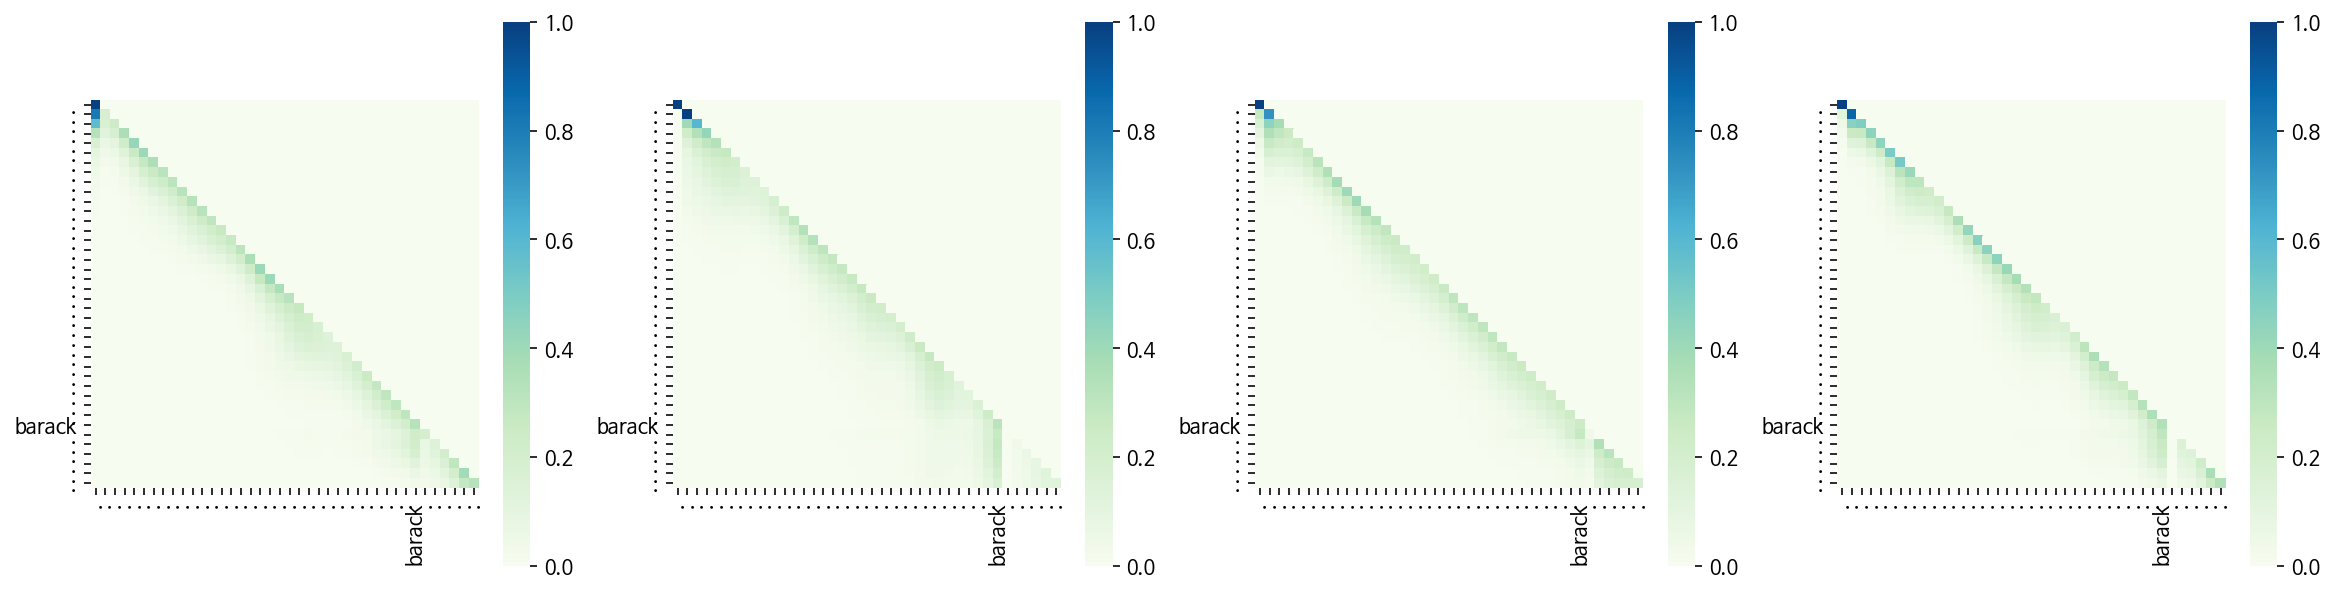

Decoder Src Layer 2


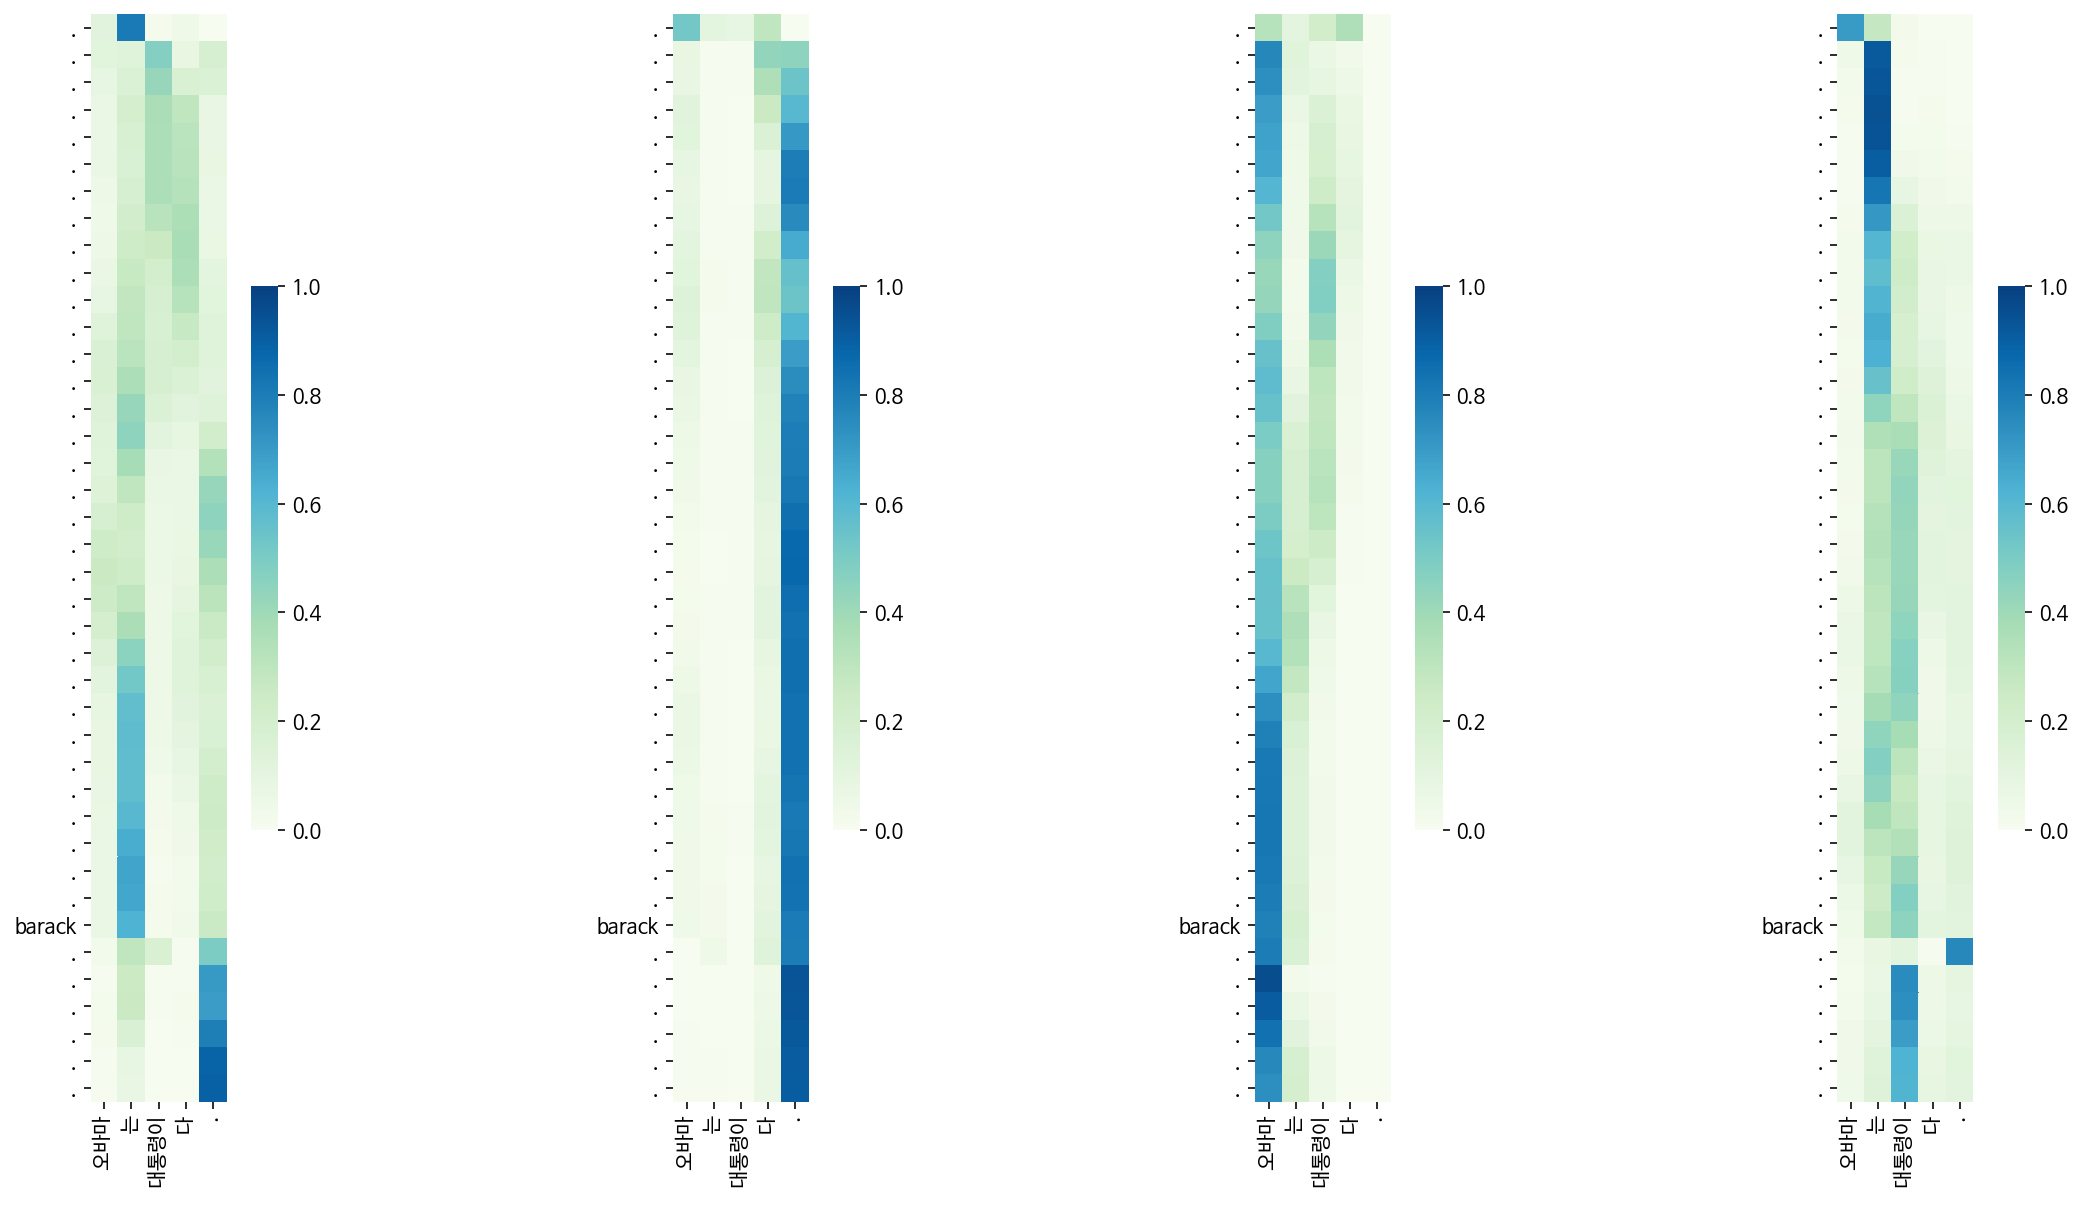

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : spot city spot spot spot say . people th th . are spot . . in spot . are . . . . . . . . . . . . . . . . . . every . . is . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : is . . . . . . . . . . . . knock . . . . . . . . . . . . coffee . . . . . . . . . . coffee . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven . seven seven . seven seven . seven . seven seven . seven . seven . . . seven . . . seven . . seven people . . . said


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 11]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . barack . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are spot the in spot spot the spot spot . there well . are . . . . . . . . . . . . . . . . . . know are . . . . . . . pregnan . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : is . . knock no . . . knock no . . . . knock clean . . . . . . . . coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven were  and .        . .   . seven .  . seven .  seven . and  .   . seven . seven people . said .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 12]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : brita people brita s is there . every well . . . . . i every . every . . . . t . . this . . . every . . . . every . . . is . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : no . . . . no . . no . . . . no . . coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven . seven from seven . . came seven seven seven . seven seven . seven . . . . . . . . . . . seven . . seven . . said


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 13]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . ⁇  are . . . obama . just . . . . obama . . obama are . . . . . . . . just . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are . are are . reported . . . . . . . reported . . . . . . . . . . . . . . . . . . . . . . every . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no need no is . . . . . . . . . . . no coffee coffee coffee . is . . . . . . . . . . . no . coffee does need . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven from were .      and .    from seven seven . seven . . seven seven . . seven . . . . seven . . . seven . . seven . said .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 14]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are reported . . this . . this mountain . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . grant
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven were thursday  reported . .  . . .ed .ed .ed .ed control afterededededededed seven after seven seven . aftering reach . . seven . . said .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 15]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . we . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are . . . . . . . . . . . . know . . . are . . . . . . . . . . . know . . . . are . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : is . . . . . . . . . . . . need need to . knock down . . . . . . . . . . coffee . . down . . . . . is . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven from after and seven seven seven seven . seven from and came stable . from and . . . and . came from . . and . . . . number  . . seven . seven .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 16]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . he . . . . . . . . . . he . . . . . . . he . . . . . . . . . . . . . . he . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are . spot spot spot . . . . well . . . know . . . . . . . . . . . . . . . . . are . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : is . . . not . knock . . . . . . not . knock . . . . . . . . . . does coffee . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven . . . seven . . seven . . seven . . seven . . . . seven . . . . . . . seven . . seven . . . said


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 17]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . he . . . . . . . . . . . . . . . . . . . . . . he . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : urban the people are . . . . . . . in this urban . . the . . has to . . . . . . . . . . . are . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : is . . . . not . knock . . . . . . . . . . . . . . not nothing . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven were              seven after     seven seven  seven . seven . . . . .  . seven . . seven . seven . said .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 18]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president obama he . . he . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : church stands stands citizens are . . every . there there there urban in there there urban . . . in . there every . every . . . in . . . in . . know . . is . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : is . not . or . . . knock . . . . . . . . . . . . . . not
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven after seven seven seven seven seven seven . seven came . after seven seven seven seven came . . . came . . . . . . . . . came . . .s . . said


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 19]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people brita are . . . there . there in every every . every . . every . . every . . . . in every . . . . . . . . . . . pregnan .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : is . not any or . . coffee . . . . . . . does coffee . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven were employee after      seven . . . . seven . . came . . from . . . . control seven seven seven and after control anded control seven . seven seven . . on . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 20]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . .
Encoder Layer 1


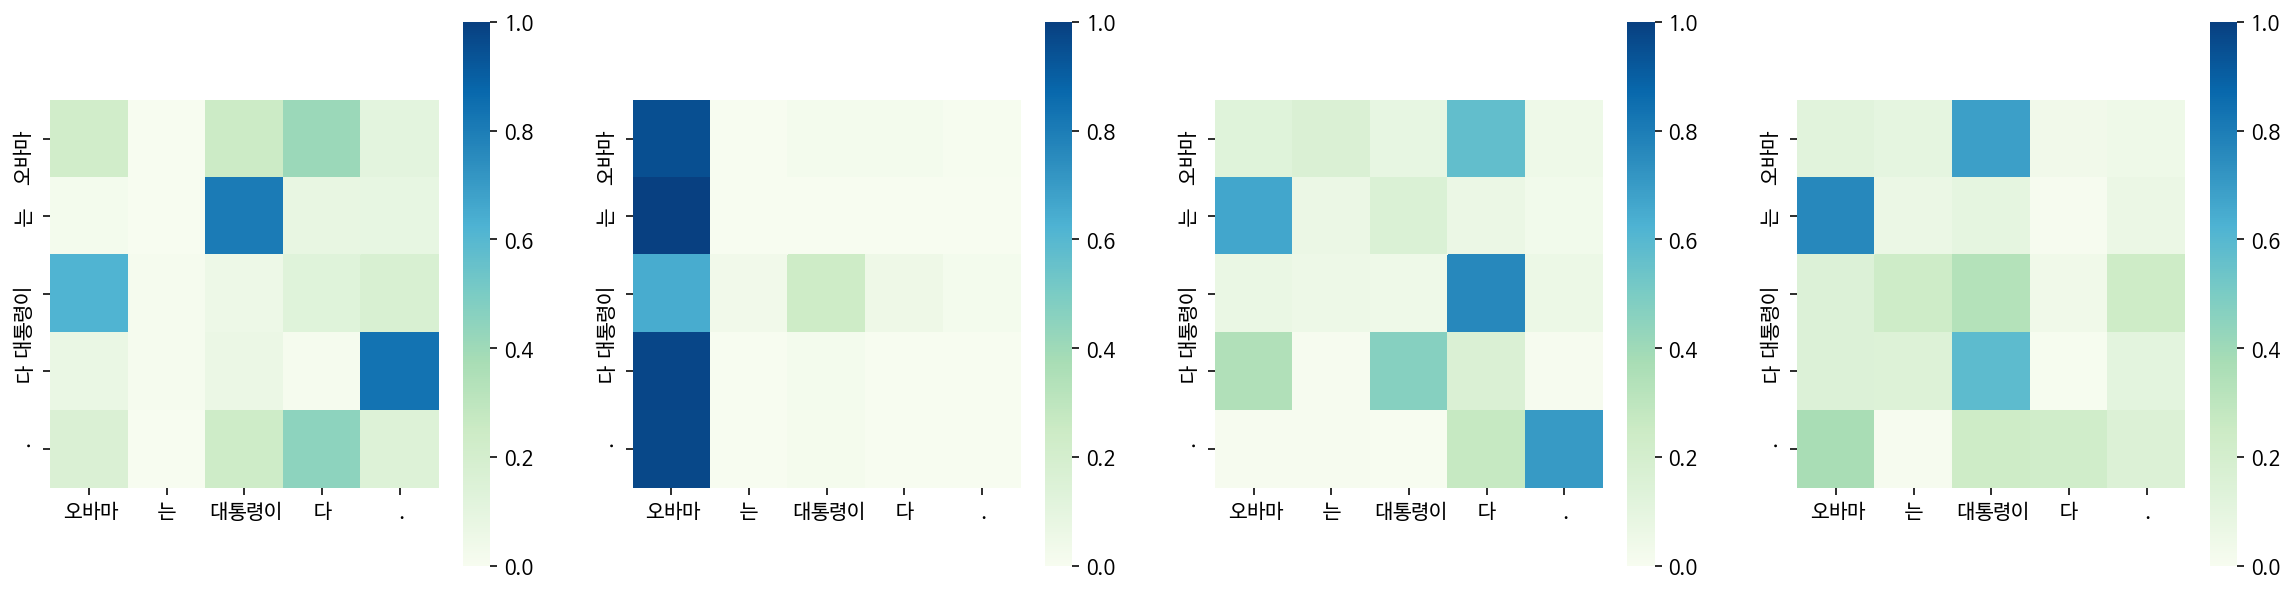

Encoder Layer 2


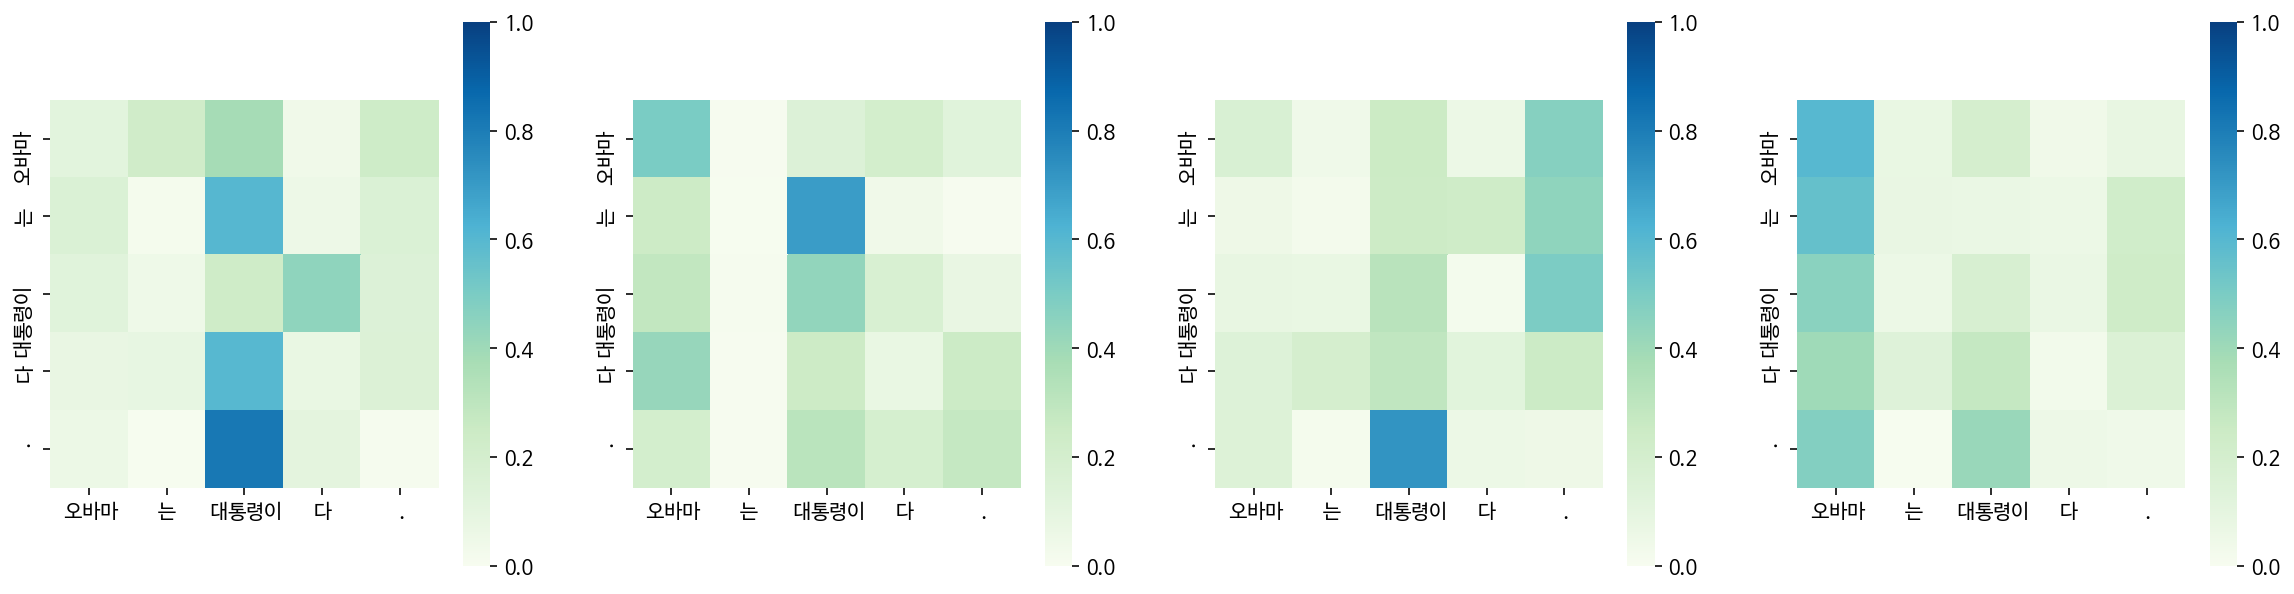

Decoder Self Layer 1


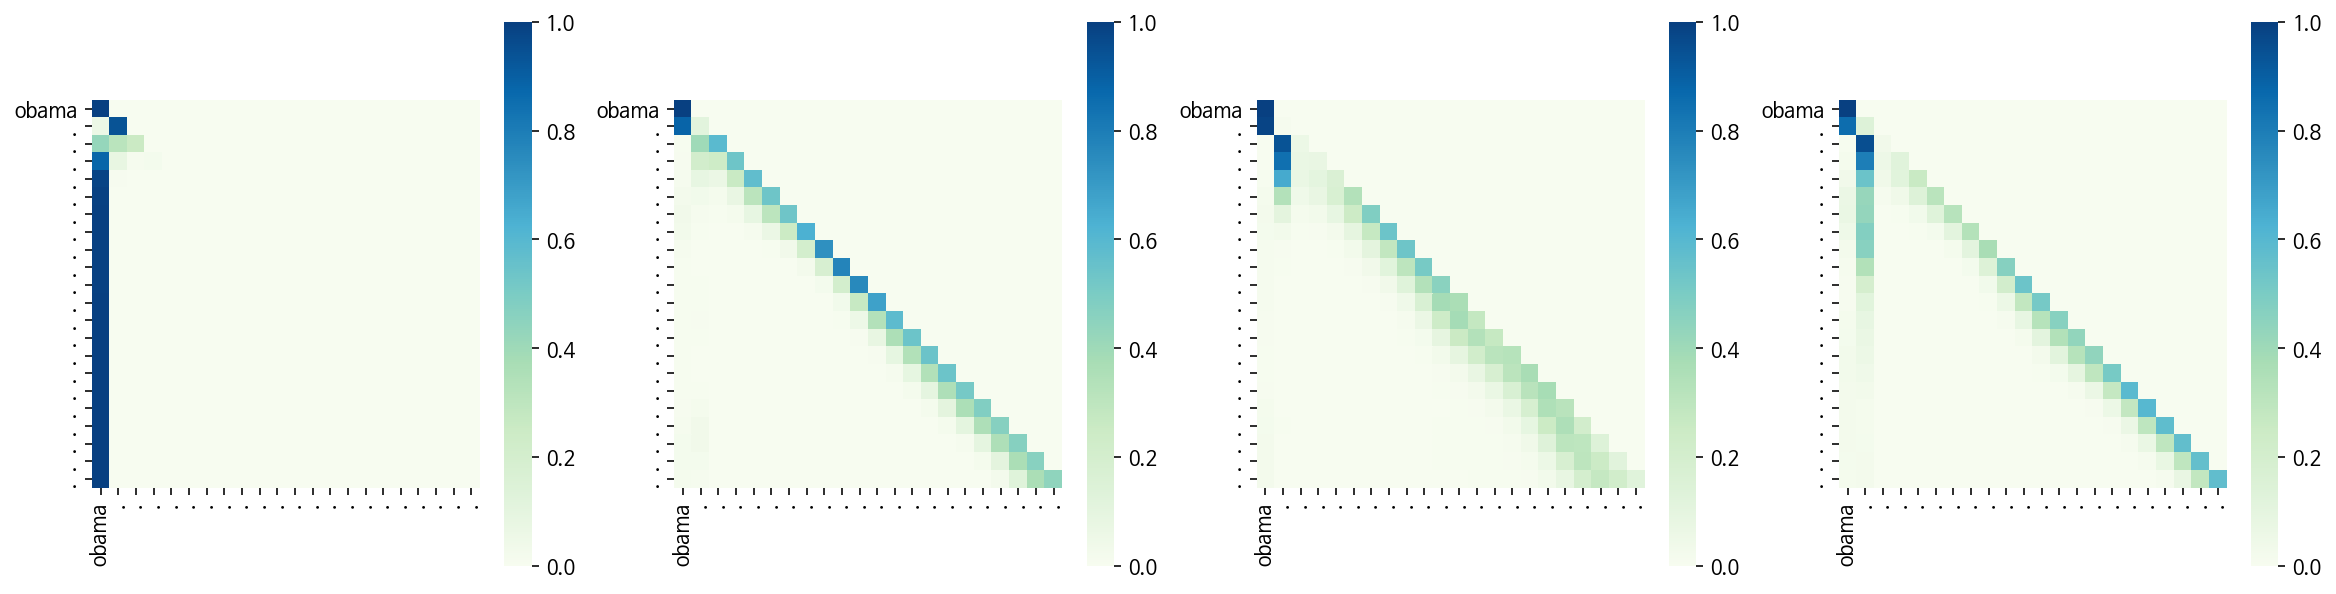

Decoder Src Layer 1


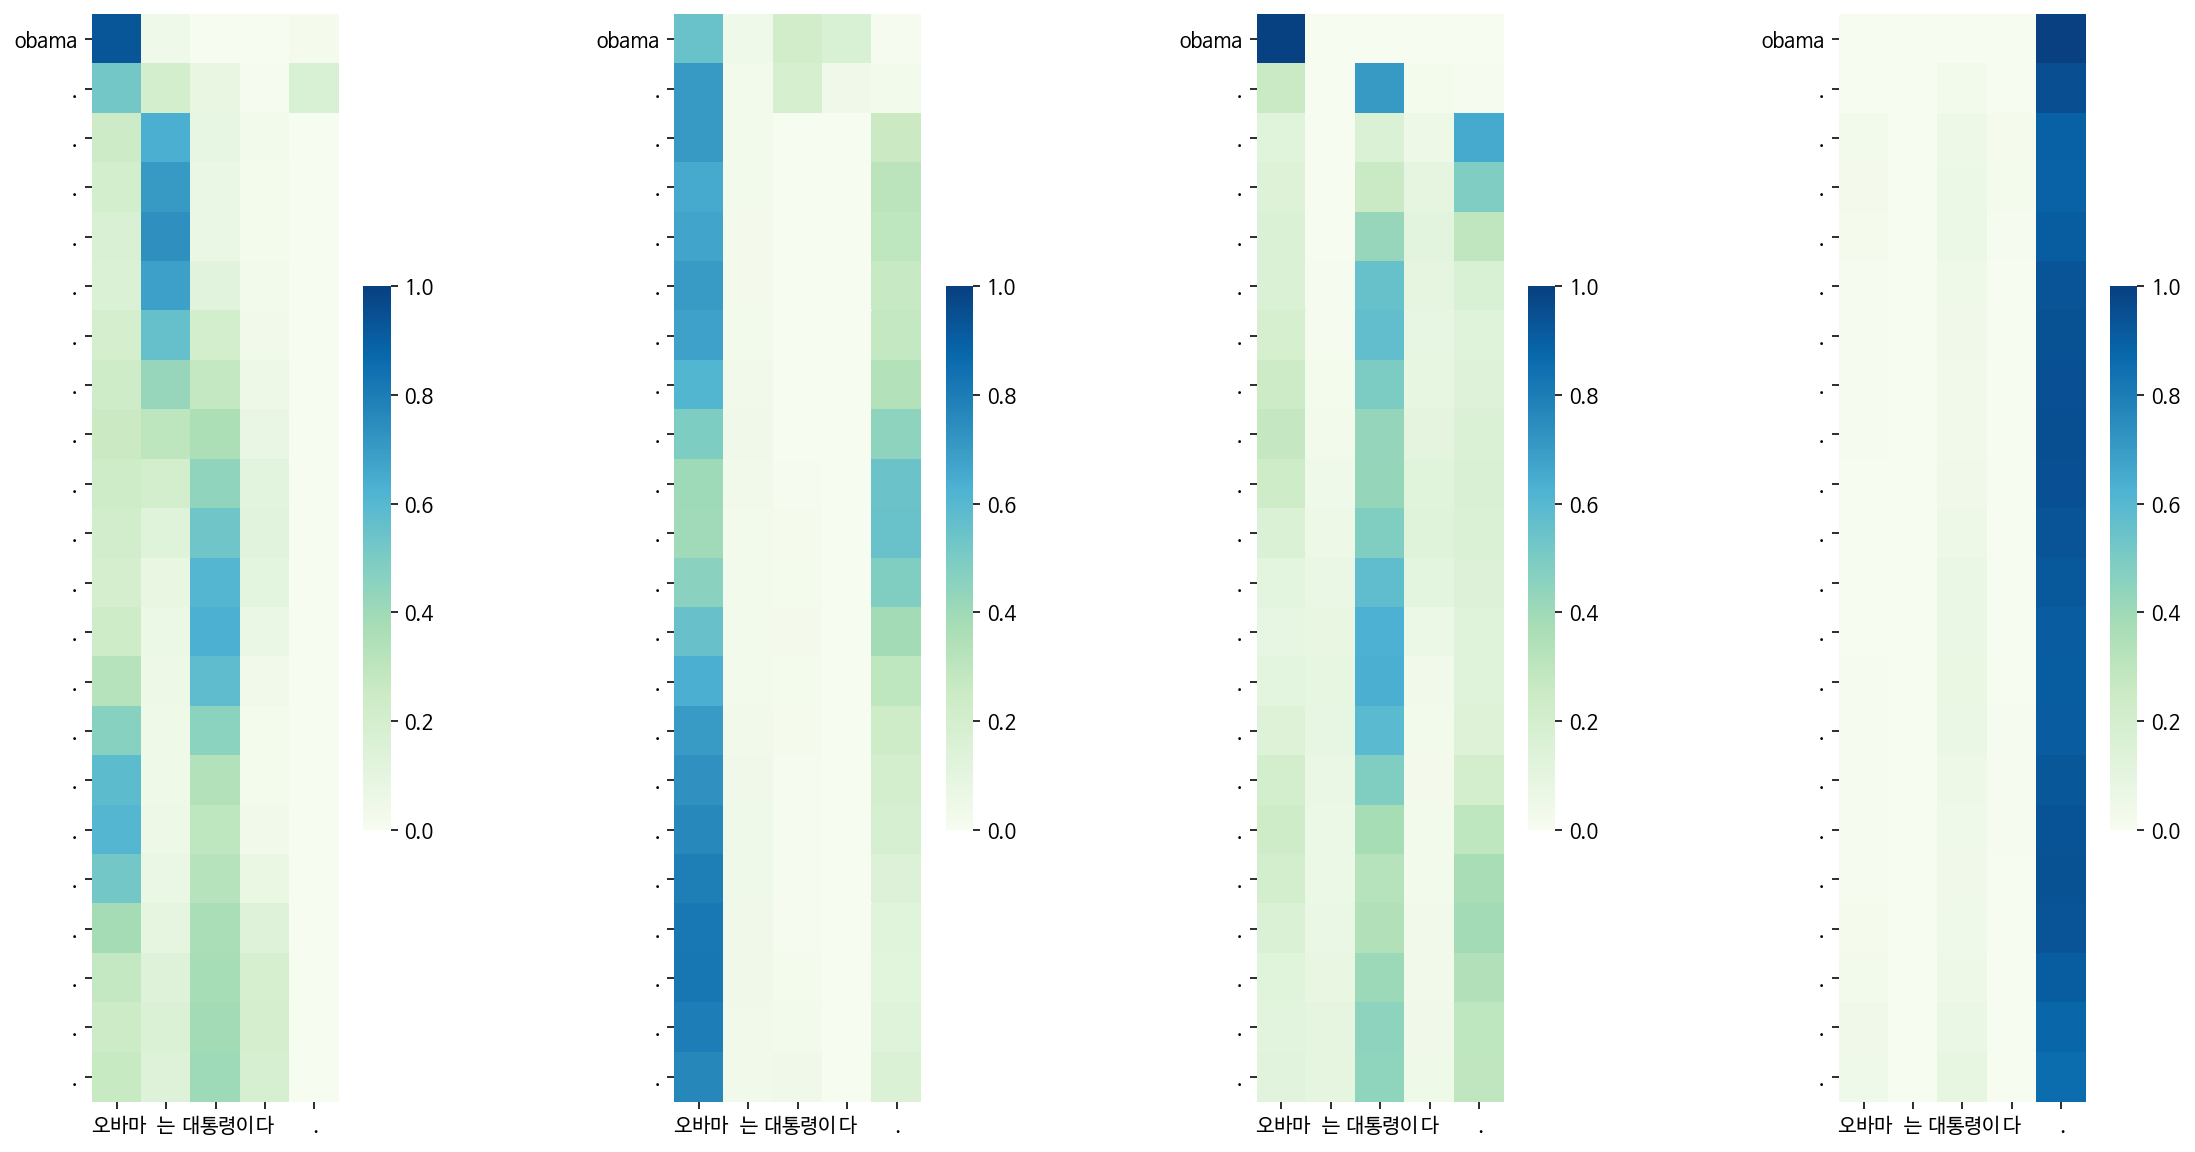

Decoder Self Layer 2


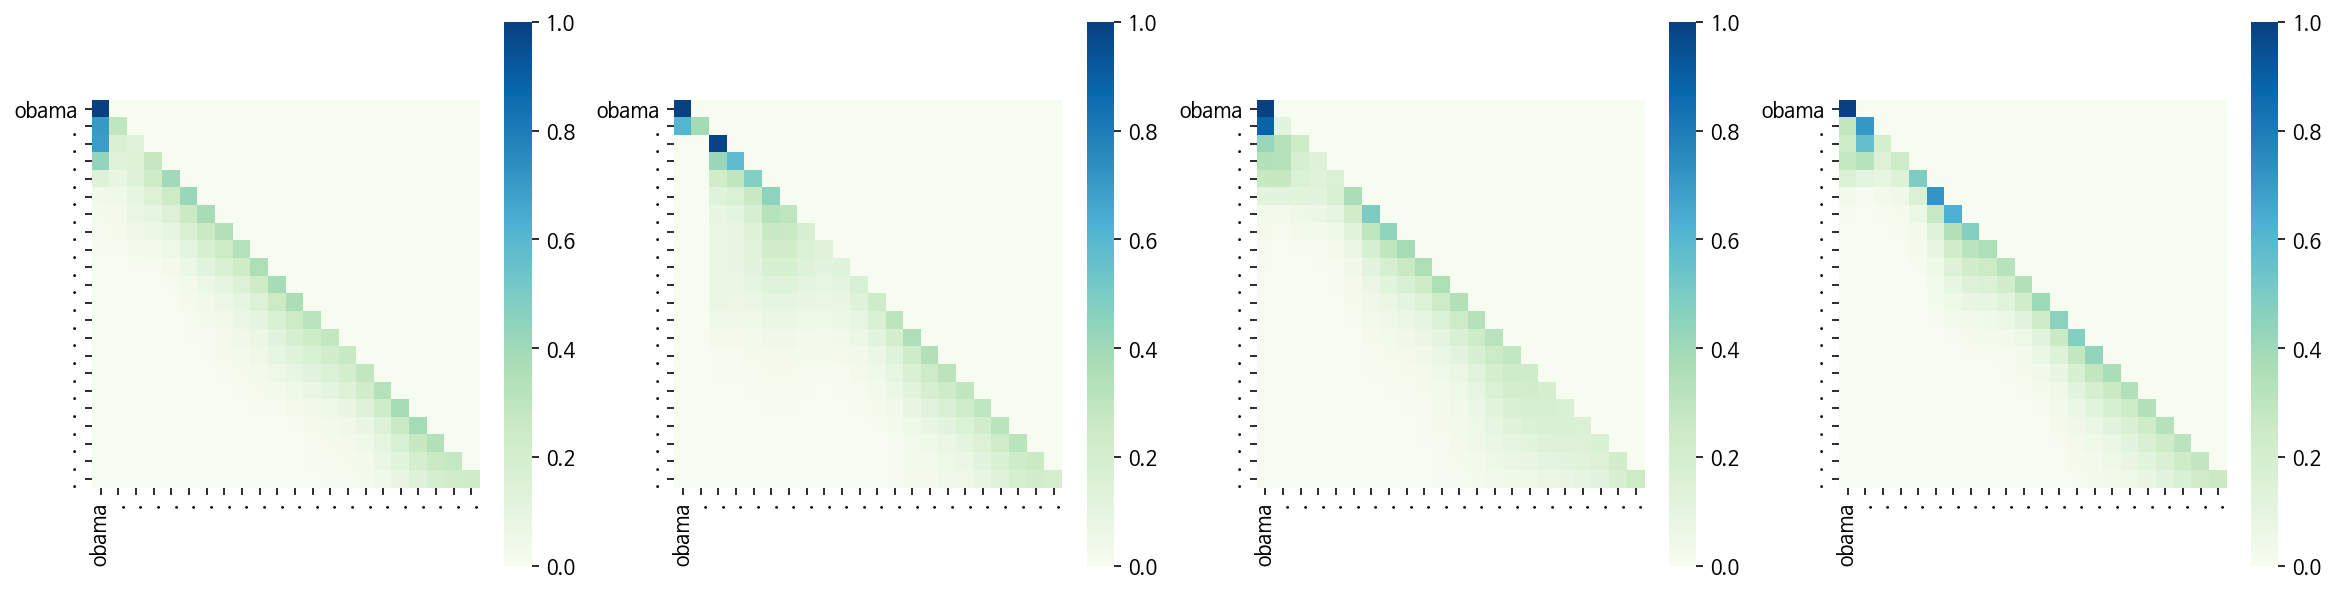

Decoder Src Layer 2


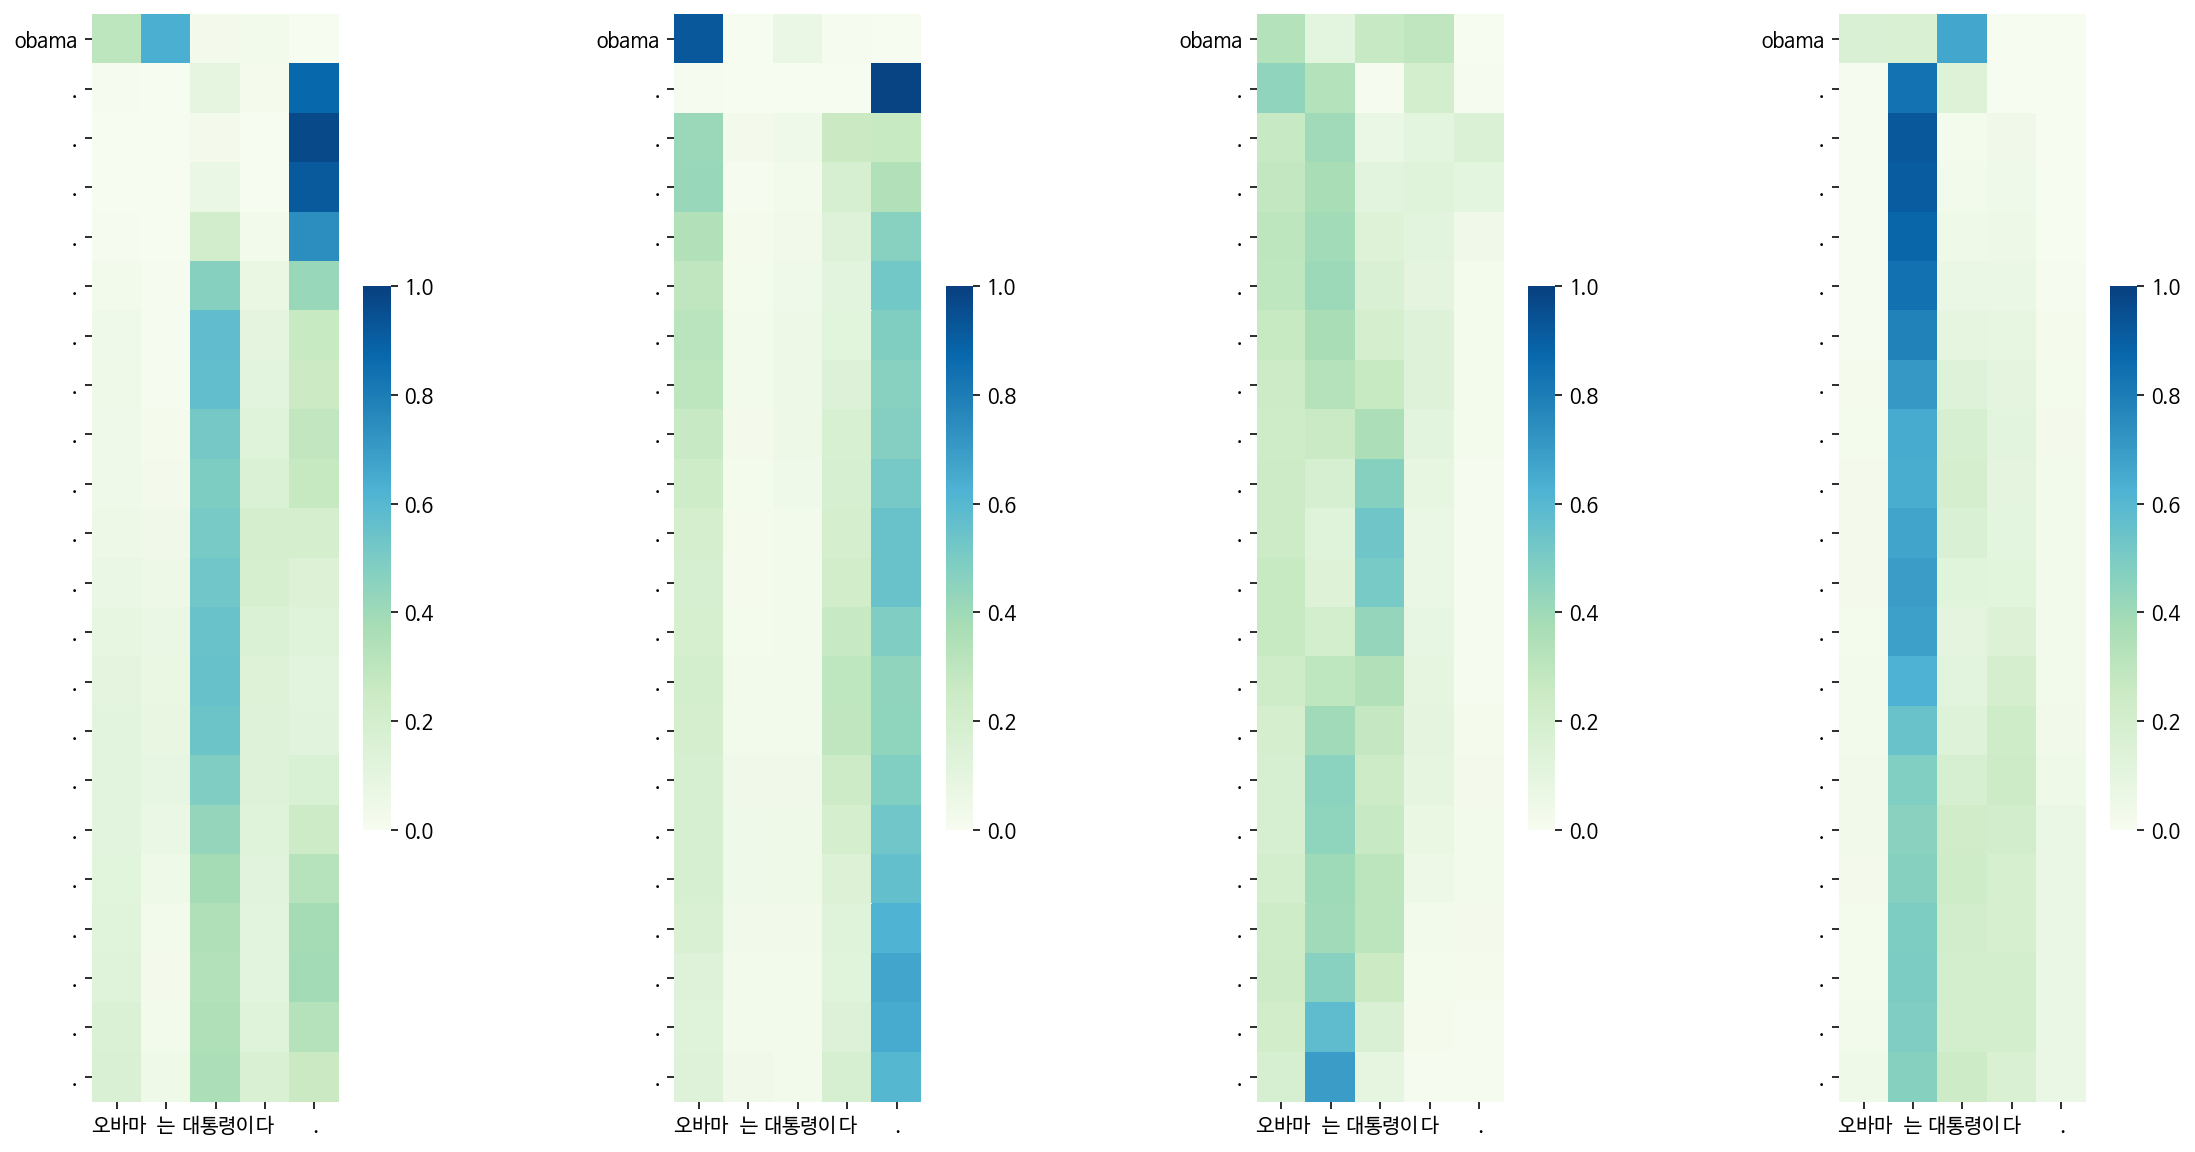

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people church citizens citizens citizens citizens citizens citizens to . urban are . . . in . . every . . . . in . . . . . . in urban . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : no . is . . . . if any . . . . . . . knock coffee coffee . . . . . . . . . . . . . . . . coffee . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven afterfire the . sevenfire killing . . . we seven . we the we we we the we we seven . died . . . . . . . . . . weed . dead . number troop . . . . . . .


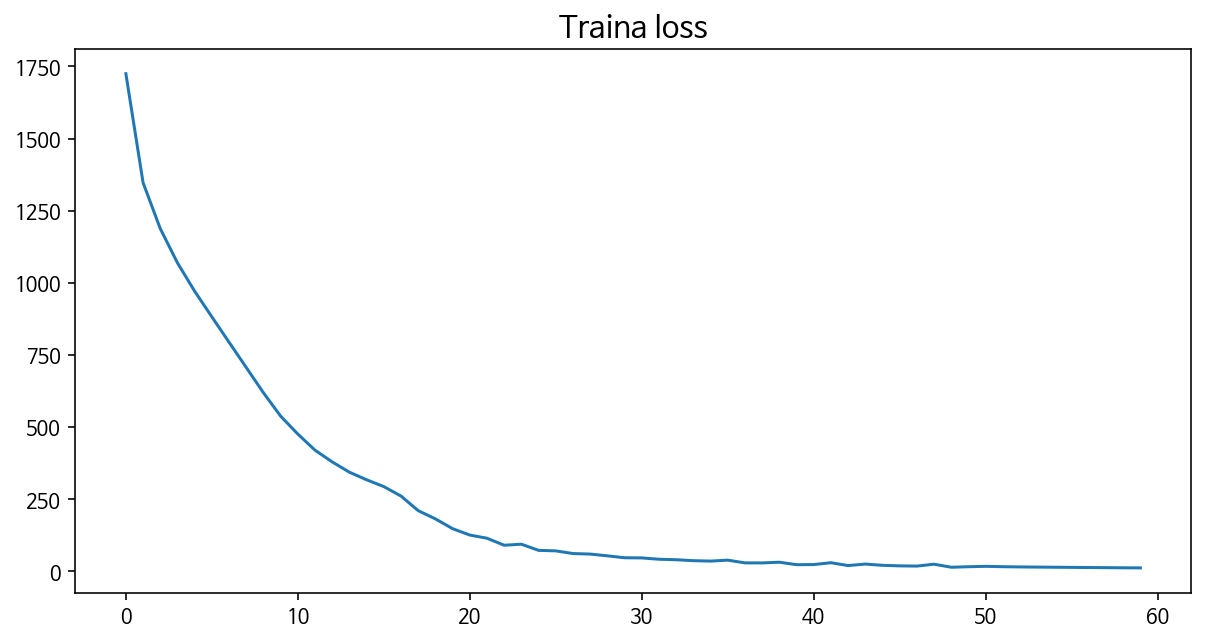

In [310]:
losses_60 = train(transformer, optimizer, enc_train, dec_train, 
                   ko_tokenizer, en_tokenizer, examples, 20, 256)
show_train_loss(losses + losses_40 + losses_60)

#### [TRY4] EPOCHS = 100

  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 1]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama . . . . obama . . . . obama . . obama . . . obama . . . obama . . . . just . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people church citizens stands citizens in stands . stands are . . . . . in . social . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee . is . . . . . . . . . . . . . . coffee . . . . . . . . . . . . . . coffee . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven were saturday .             . . . . dead . . seven . . . . . . . . . . dead  . seven . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 2]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama he he he . he obama he . he . . obama . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people the church are . in in . in say . are . . . in are . . . . in . . . . . in . . . are . . . . know . are .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is . . . . . . . . . . . . . coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven . seven seven . seven . seven . . . seven . . seven . . seven . . . . . seven . . . seven . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 3]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are . . . . are . . . . . . . in every . . . . . . . every . . . . in know . . . are . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : is . . . knock . no . . abandon abandon abandon abandon coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven were .   seven  seven seven seven .    . seven . . . . . . . seven . . . . . . . . seven . . . seven . seven .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 4]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . he . . . . . . . . . . . . . obama . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are . . . . there the the the there well . know . . know . . . . know . . . . know are . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : no . . abandon . any . coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven were   seven  seven seven seven . seven seven seven . seven . seven . seven . seven . seven . . . seven . . . seven . . seven . seven . seven . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 5]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . obama . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : church says are . . . . . social . . . . are . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : nothing . need need need coffee coffee need need
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven employee seven seven seven seven seven . seven . . . seven . . seven . seven . . . seven . . seven . . . . . . seven . . . seven . seven . . seven . said


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 6]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama . just . . obama . . . . . . . just . obama . . . . . . obama . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : standss are . key . . . . . key . are . . . . . . . . . . . . . . . . . . . . . . are
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no . is .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven were .      seven seven seven .   . . seven . . . . . seven . . . . seven . . . seven . seven . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 7]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . obama . . . . obama . . . . obama . . . obama . . obama . . . . . obama . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : s over the citizens citizens . the every the the . this has . is . . . . . . . . . . . . . . . . . . . . . is .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : no . is . . . any . . . . . . . no .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven . seven seven seven . seven seven seven . seven . seven . seven . seven . . seven . seven . seven . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 8]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . say . obama . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people zimbabwe is . key key key key key key key key . is . . . . . . . . . . . . . . . . . . . . . is . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : nothing . no . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven . seven seven . seven . seven . . . seven . . . . . . . seven . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 9]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . obama . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : peopleround are . . . . . . . every . . . . every . . . . . . . . . . . . . . . . . are . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : any . is . . . . . . . . . not . any
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven since were . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 10]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . obama . . . . . . . . jobs . just . . . .
Encoder Layer 1


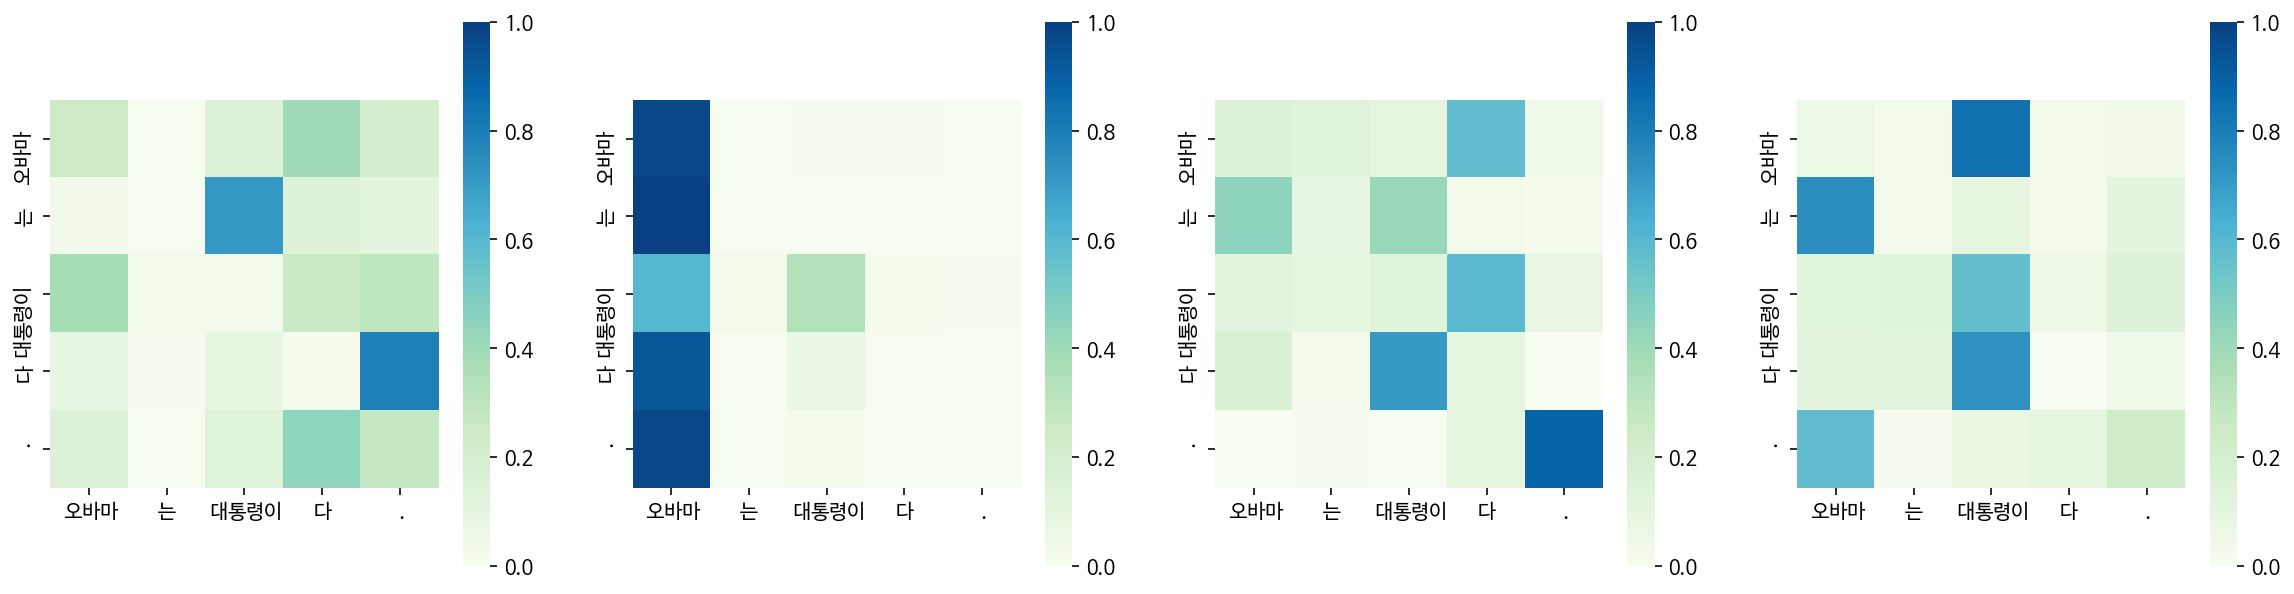

Encoder Layer 2


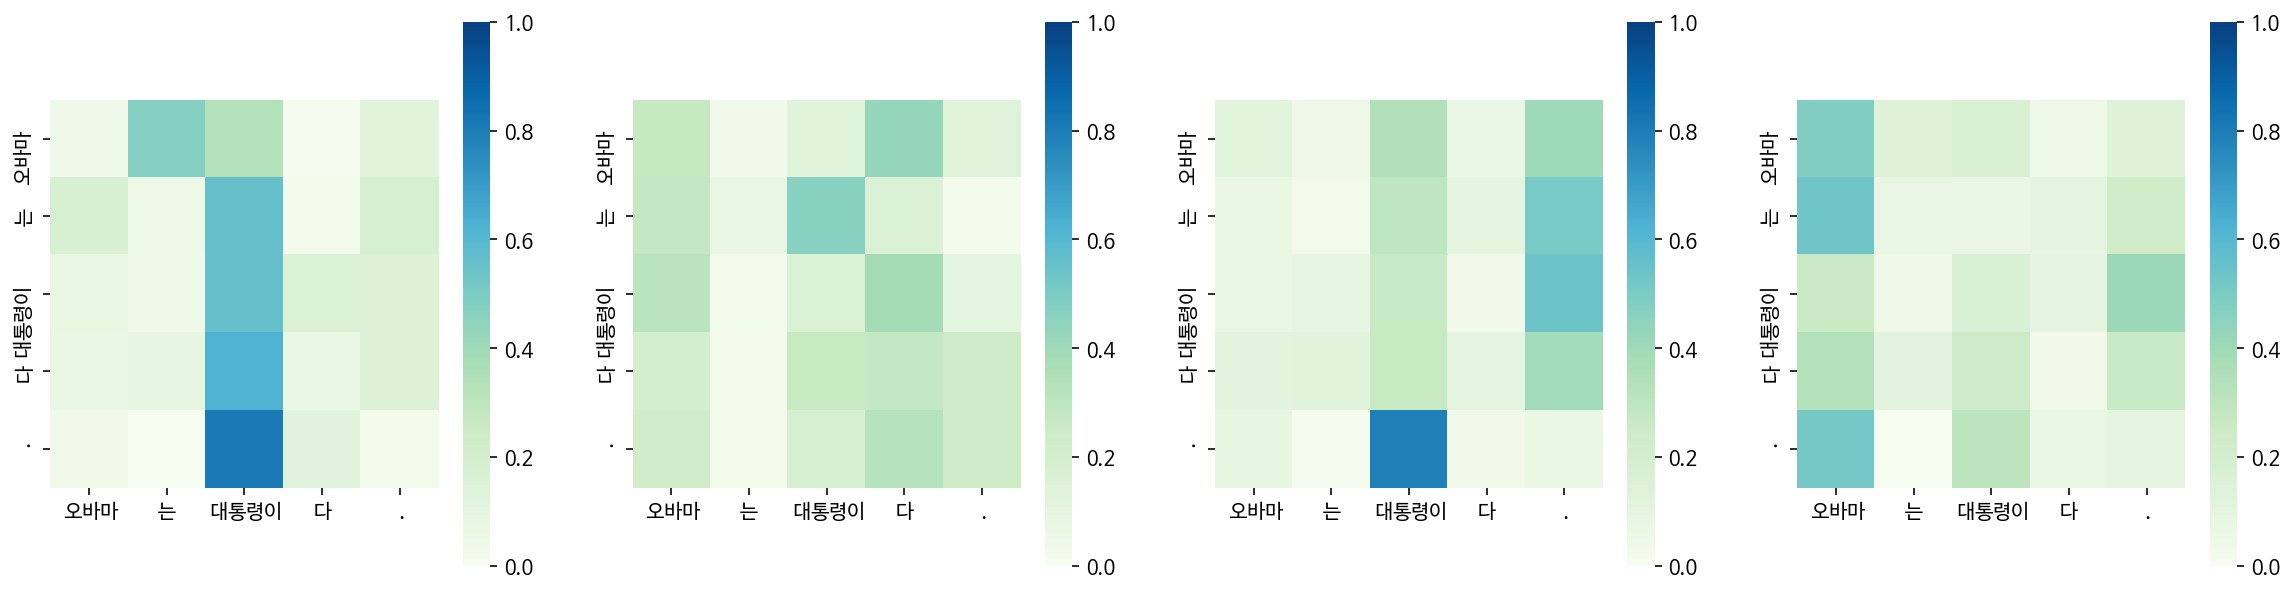

Decoder Self Layer 1


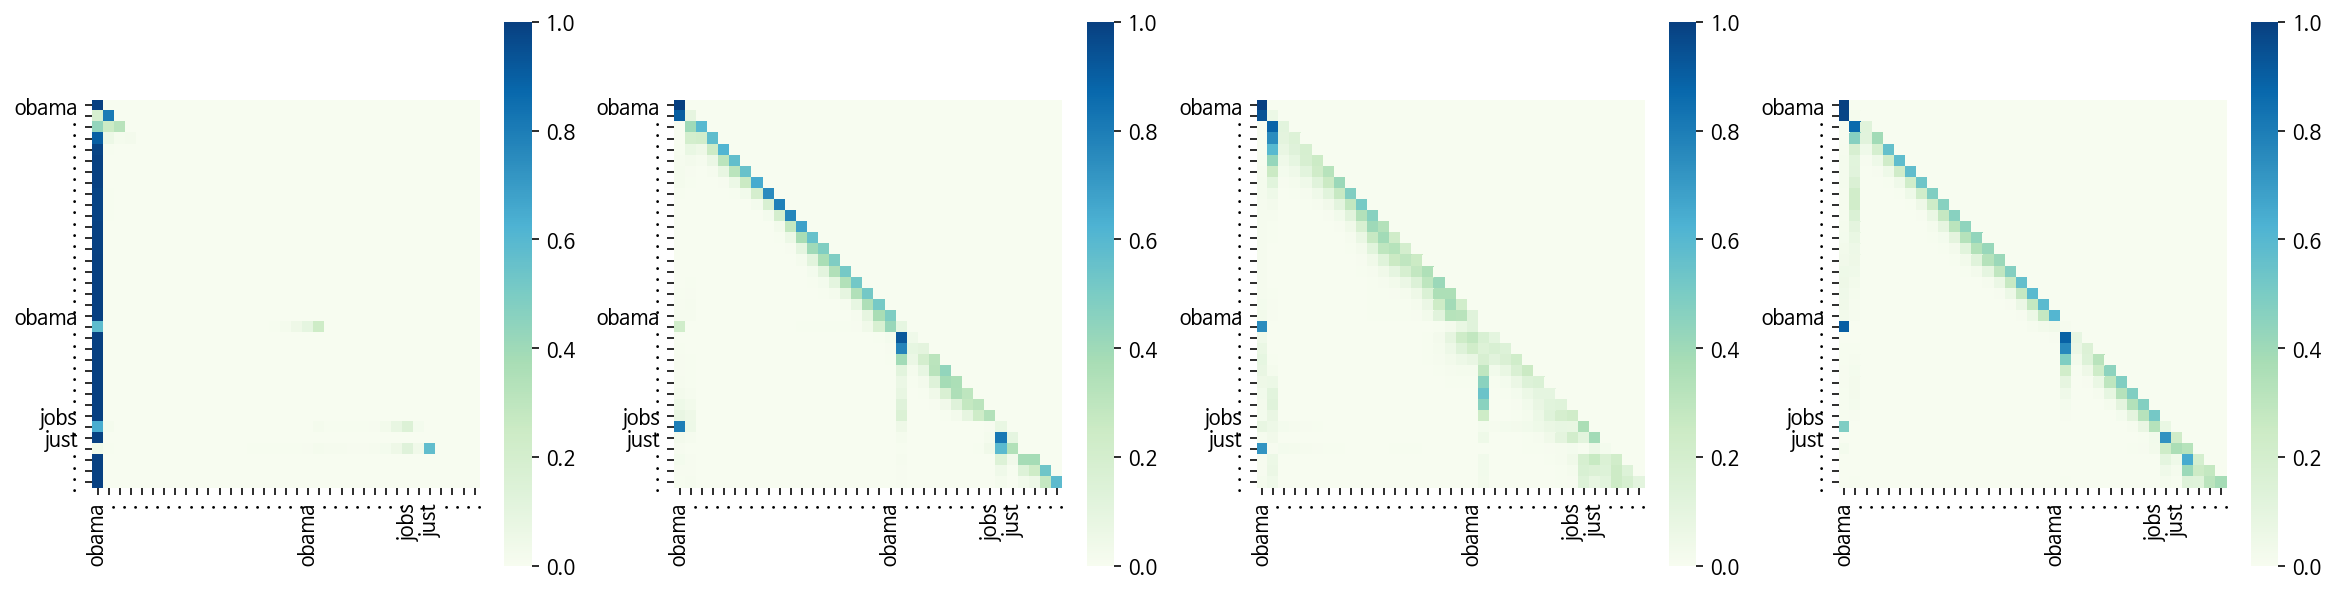

Decoder Src Layer 1


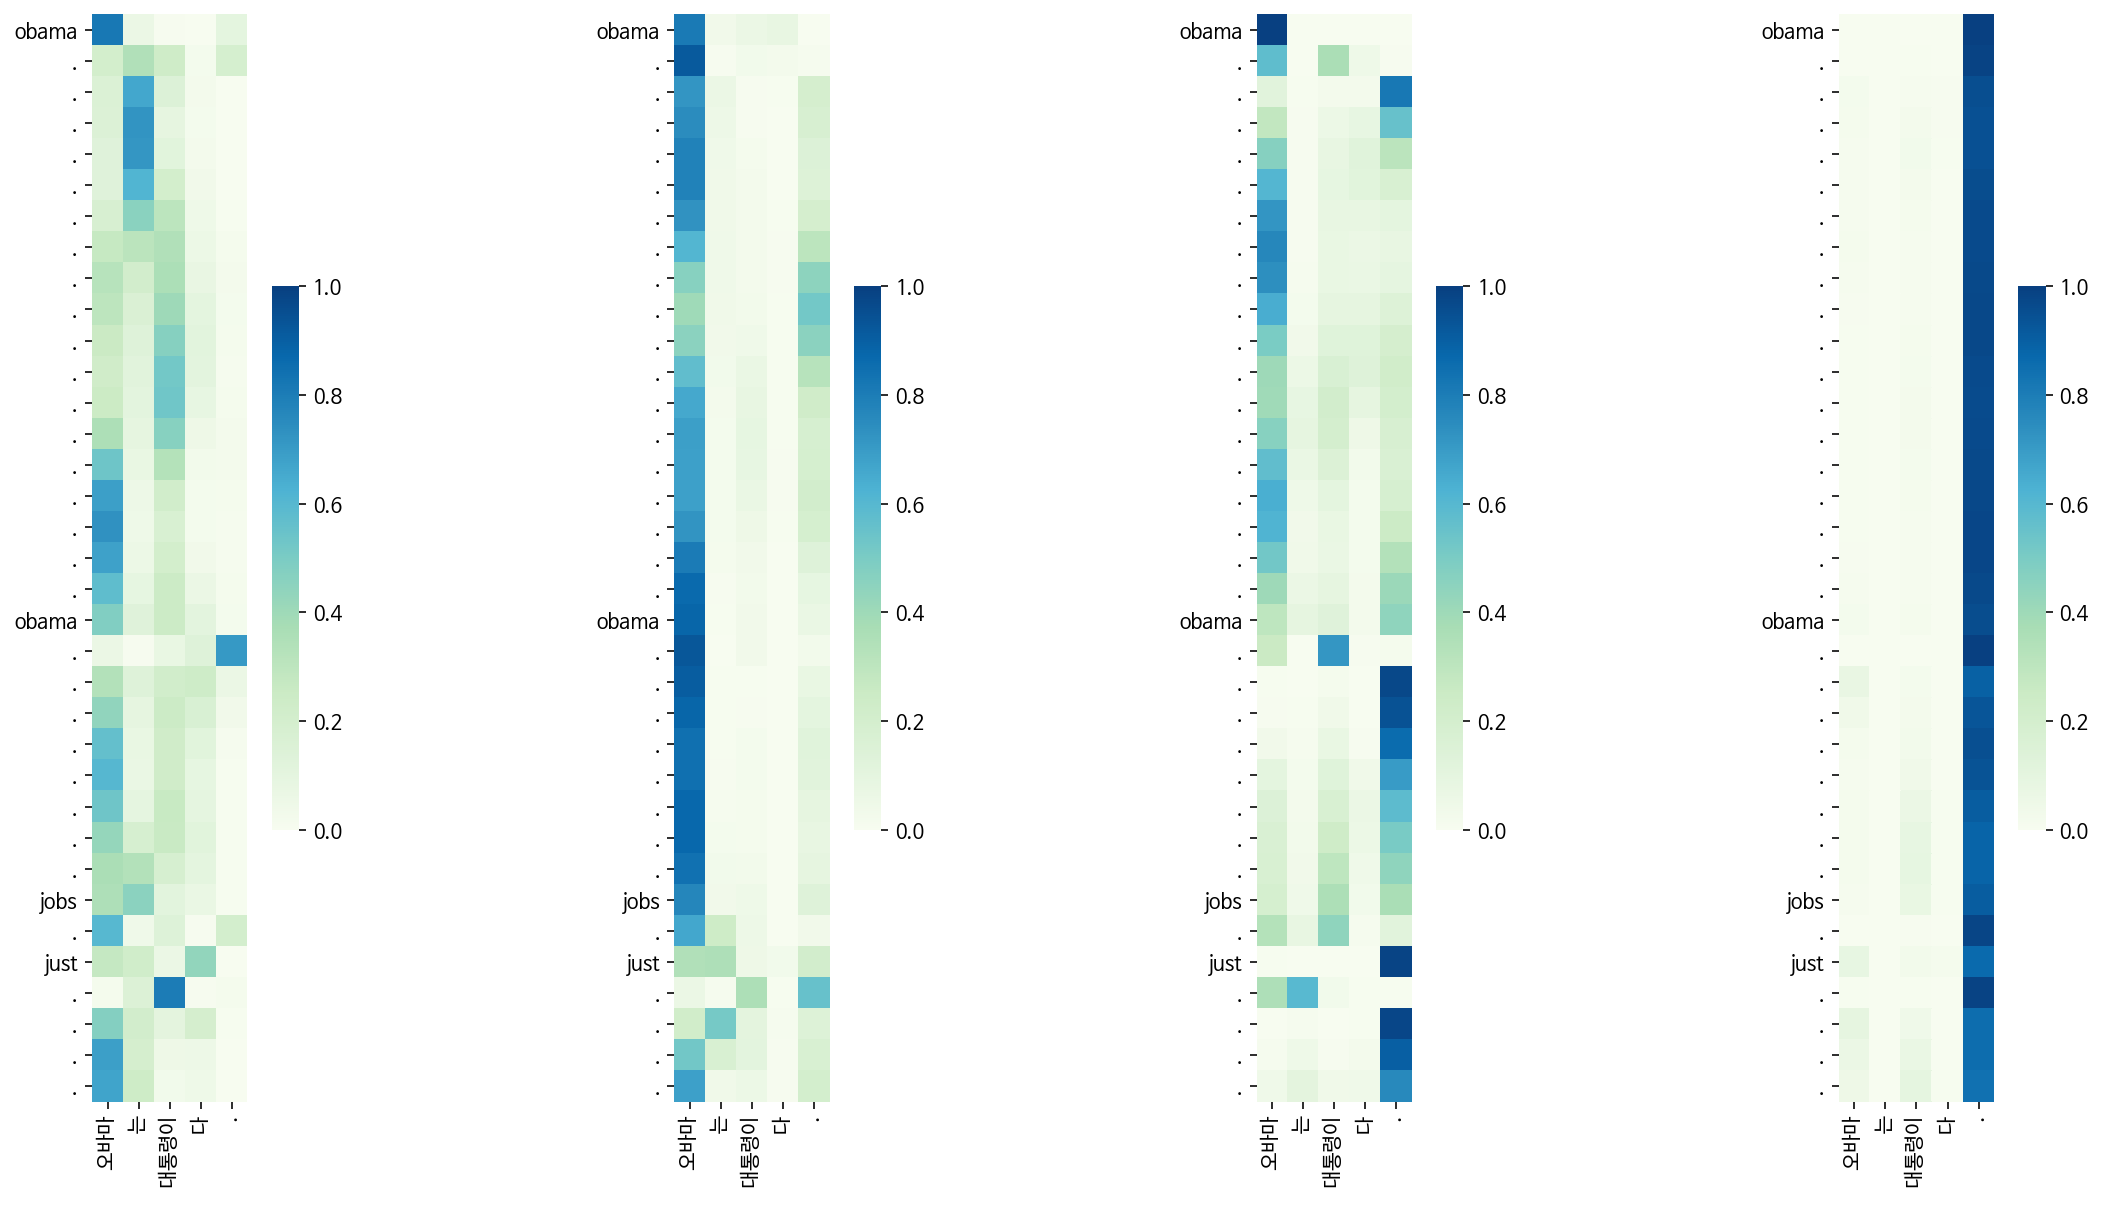

Decoder Self Layer 2


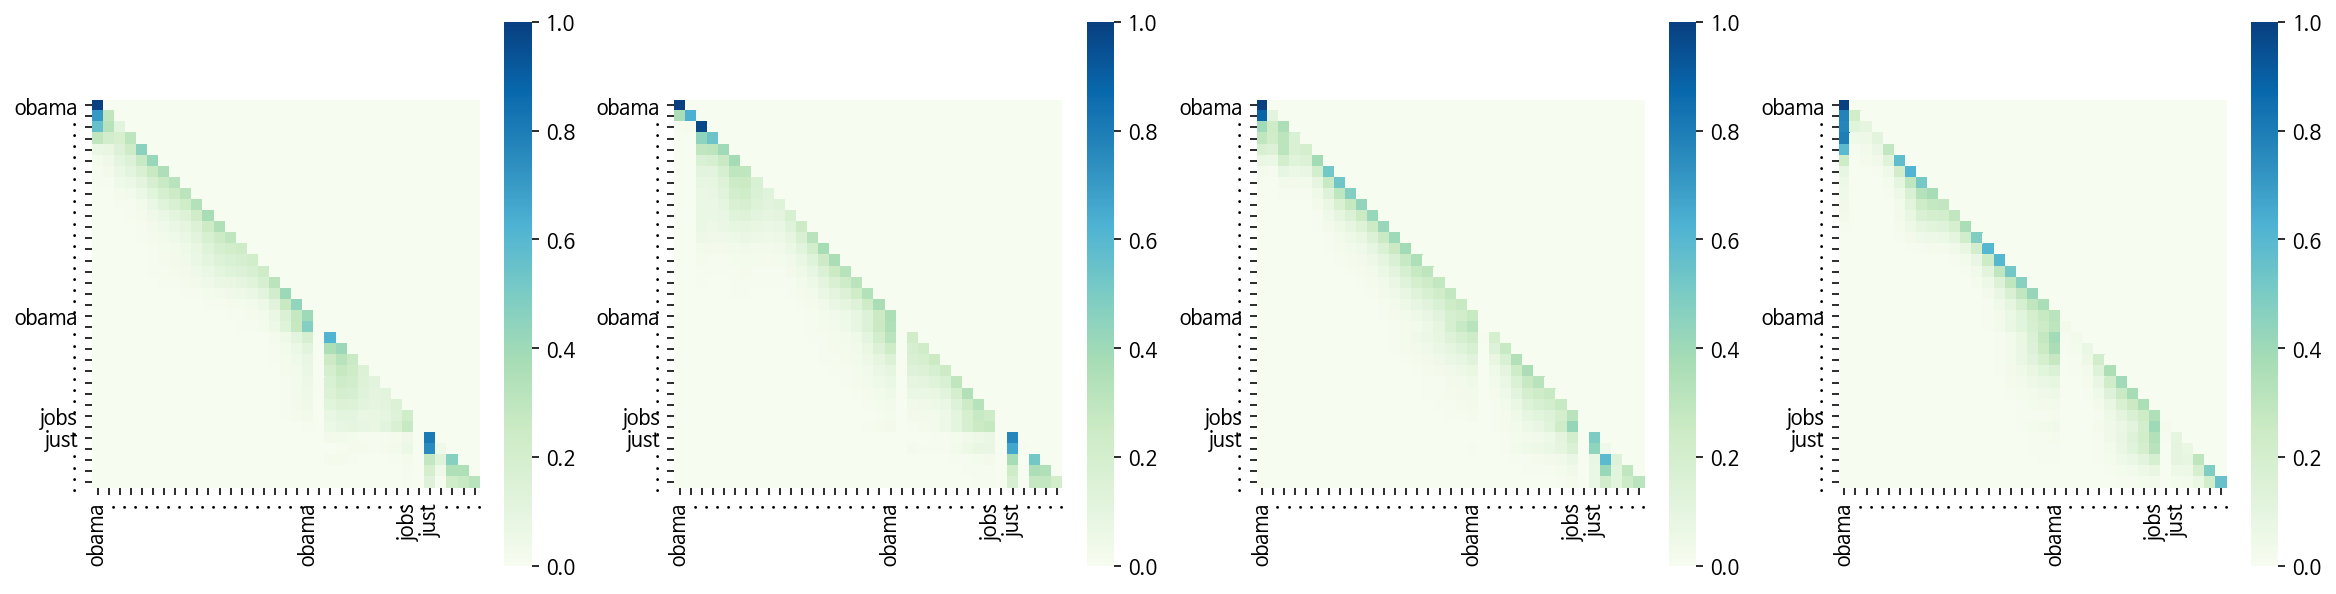

Decoder Src Layer 2


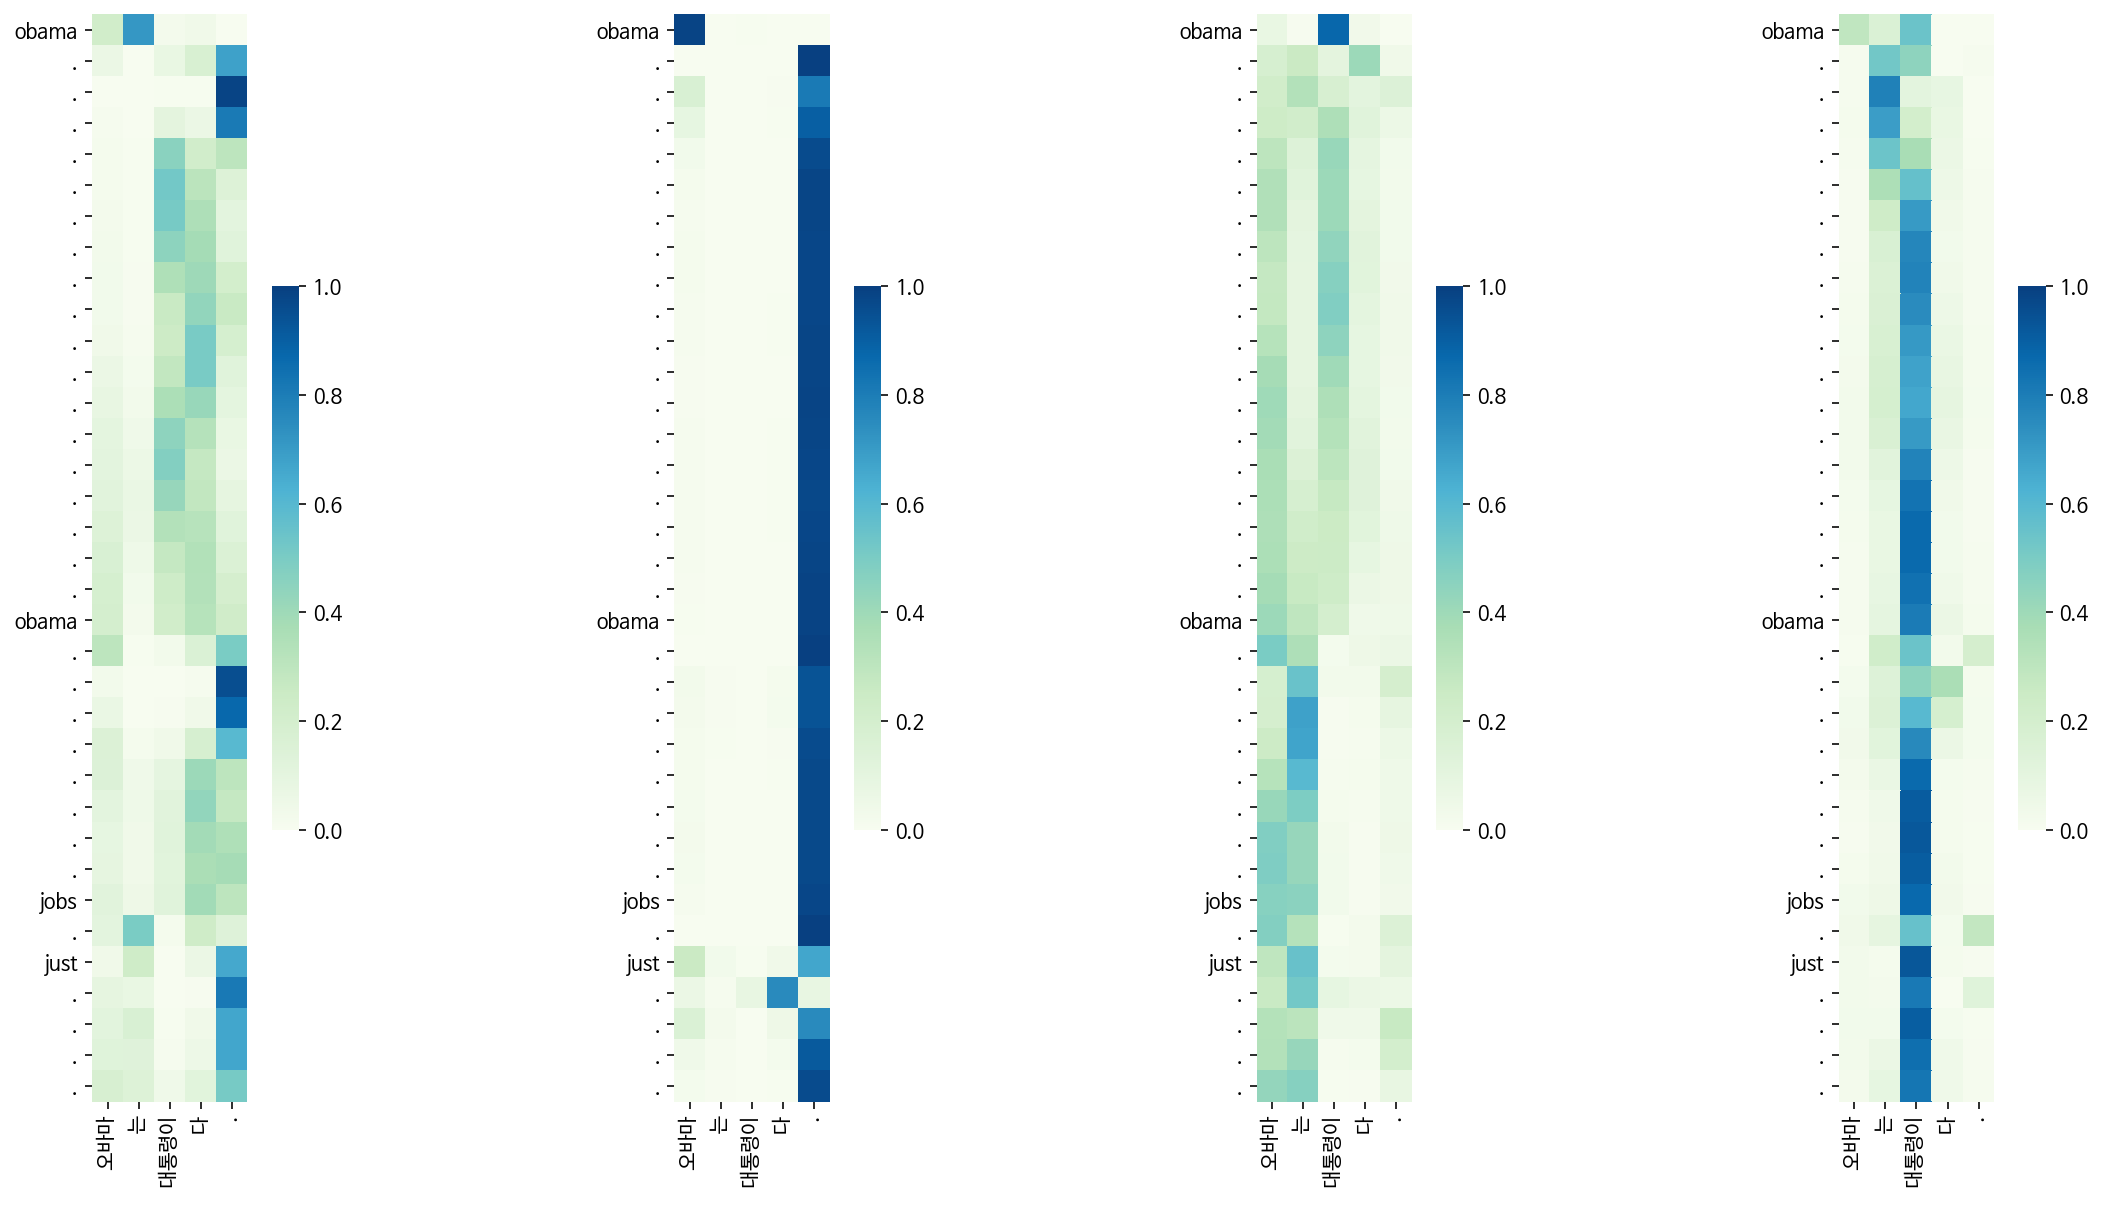

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people church the say are . inside inside are . . inside . . . are . . . . . . . there there there know . are . . . . . . . well . . are . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is . not . any .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven since . . seven . . . . . . . . . . seven . . . . . and  seven . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 11]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . jobs . obama . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : church people well the well . is . . . . . . . . the is . . . . . . . . . . . . . . . . . . . . is . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is . . . . . . . . . . . . . . . . . . . . . . . is . . . . . . . . . . coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven . seven seven . seven . . . . . seven . . . . . . . . seven . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 12]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : stands stands flow bys are . . . in . . . . . . . are . . . . . . . . . . . . . . . . . . . is . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no is . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven were                  thursday . seven seven . . . . . . . . . . . seven . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 13]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . as . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : church say stands citizens are over . . . . in . well   a . . say . a is . . . . . . . . . . . . . is . . . . . . et
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no is . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven were stable wed wed wed wed . seven . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 14]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . as . . . . . . . . . . . . . . . . . . . . . obama . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people church the citizens citizens citizens and well the spot spot spot spot . well well . . . . . . . . . . . . . . . . . . . . is . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no is . . . no . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven were    thursday            thursday . seven seven . . . . . . . . .   . seven .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 15]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as as president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : s are . in stands key .round . a a a . stands . . . . . . . . . . . . . . . . . . . . is . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven on seven seven seven seven seven seven seven seven seven seven . seven seven seven seven seven . seven . cames seven seven seven seven came . cames and came .s . said . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 16]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : sss over thes the people  . a     . is . . . . . . . . . . . . . . . . . . . every . . is . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is . . . . . . . . . . . . . . . . . . . . . . . coffee . . . . . . . . . . did . take . . . . did . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven on seven seven seven seven were . seven seven . seven . . seven . . . . seven . . . . seven . . . . . . seven . . . seven .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 17]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people flow in s inspir spiral spiral . urban s .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven on seven were .        and seven seven . seven seven . seven . seven . . . seven . . . . seven . . seven . . seven . seven seven people .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 18]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people in brita say s say s bitter has . has a a . in . say . it is . . . a . . . . . . . . . say . . is . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : no . any any is . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven it the seven seven seven the seven the seven . it the seven seven . it the we . it it the has it the    seven seven . . . the cames .s . said .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 19]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : bitter bitter on bitter bitter severa severa and bitter severa severa severa severa on every bitter in bitter . bitter severa . dramassssssss .s are . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : is . not . . not .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven on seveniya the seven seven seven seven were . seven seven . seven . . seven . . . . . . . seven . . . . . . . seven . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 20]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . .
Encoder Layer 1


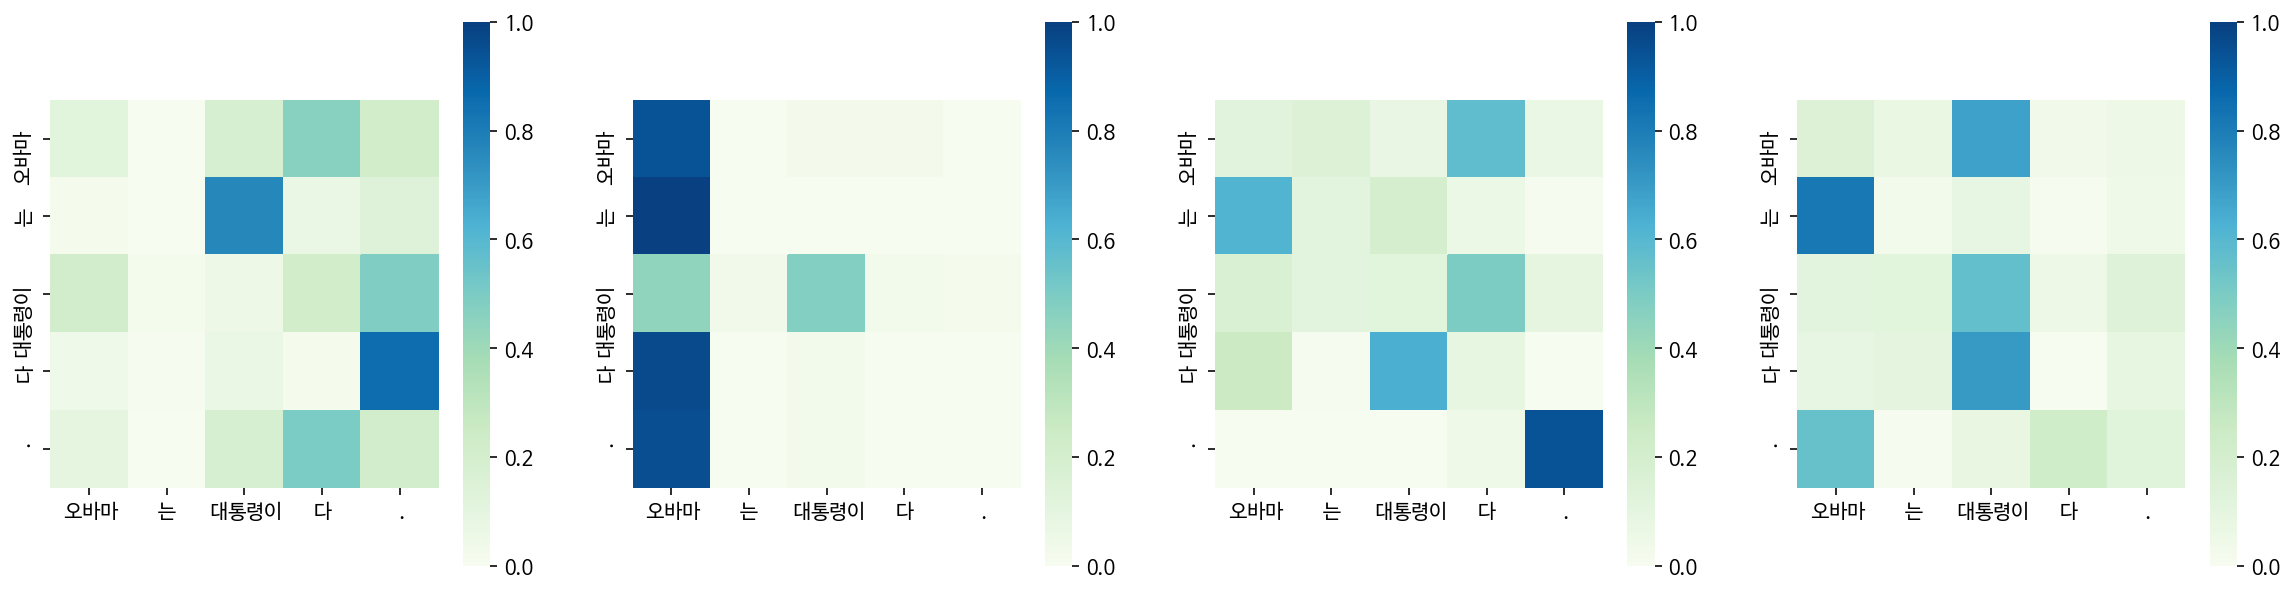

Encoder Layer 2


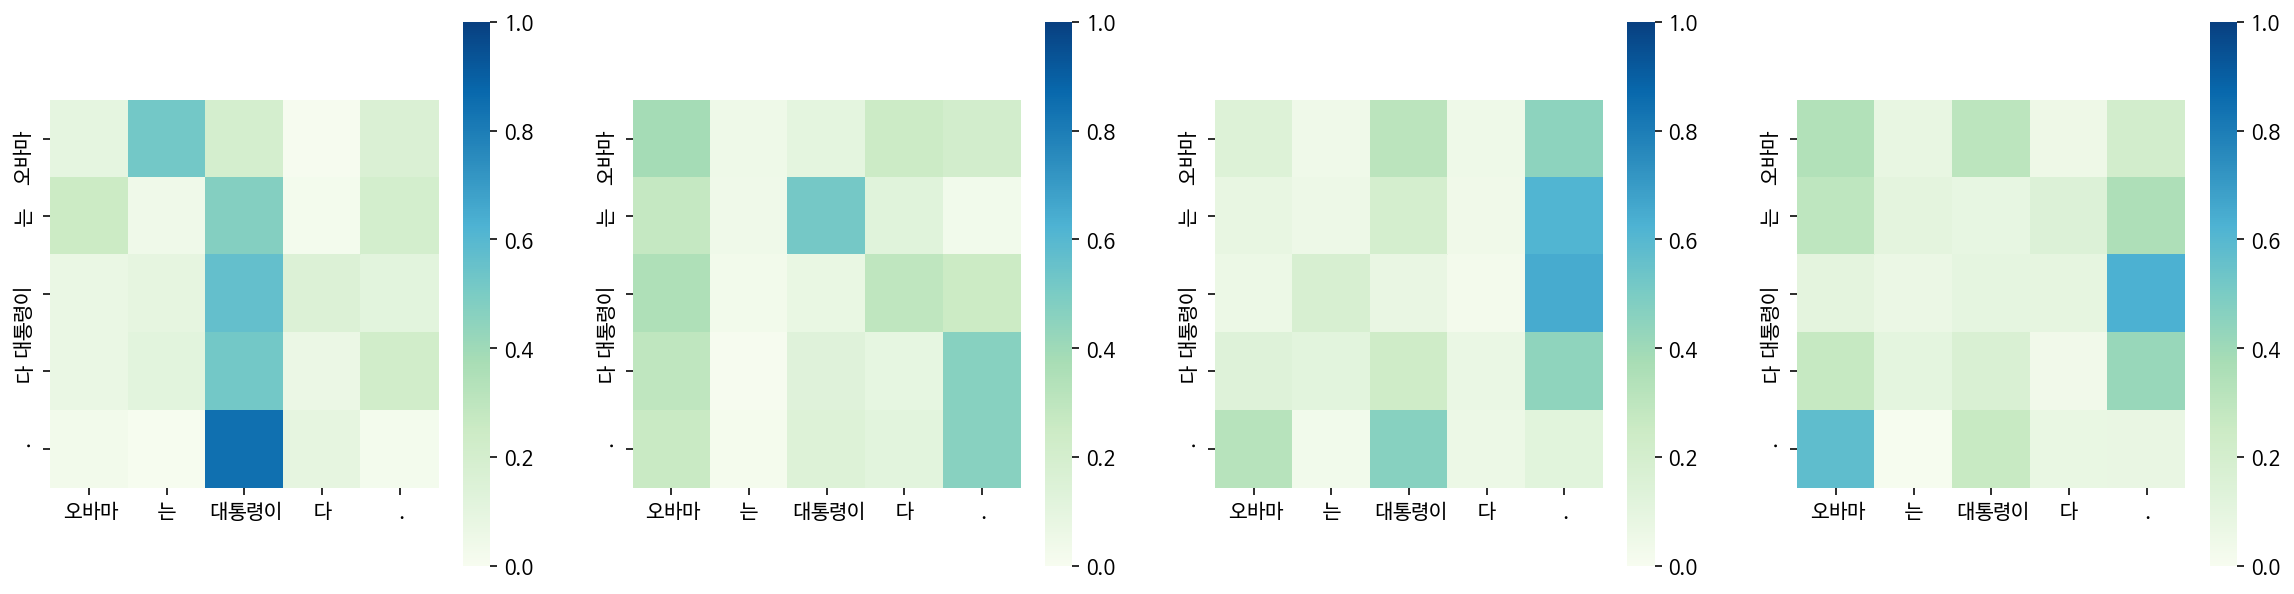

Decoder Self Layer 1


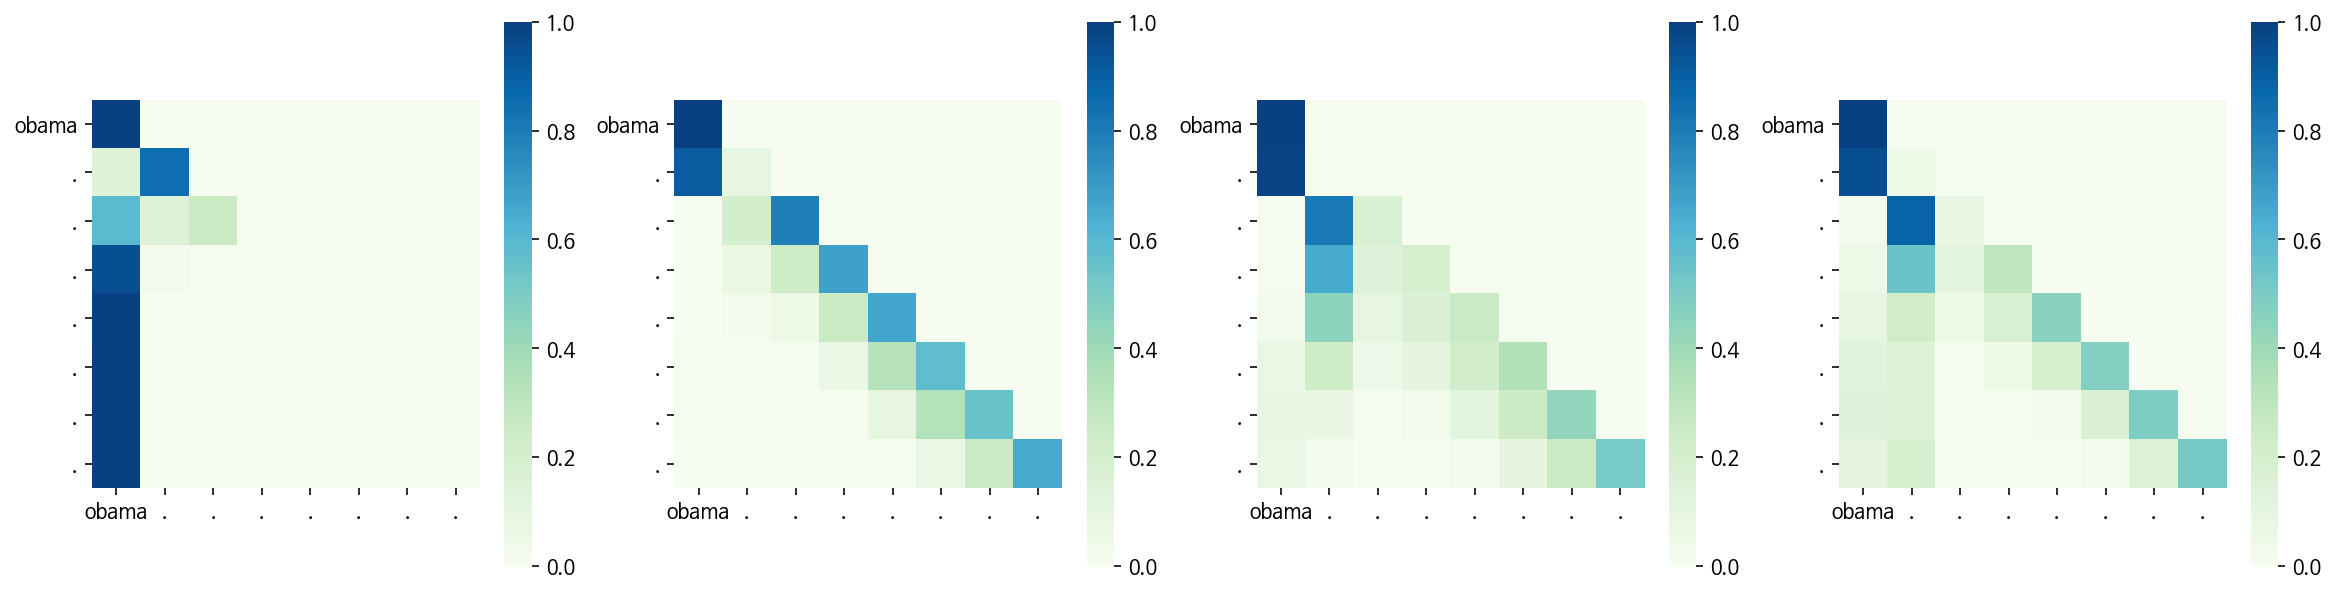

Decoder Src Layer 1


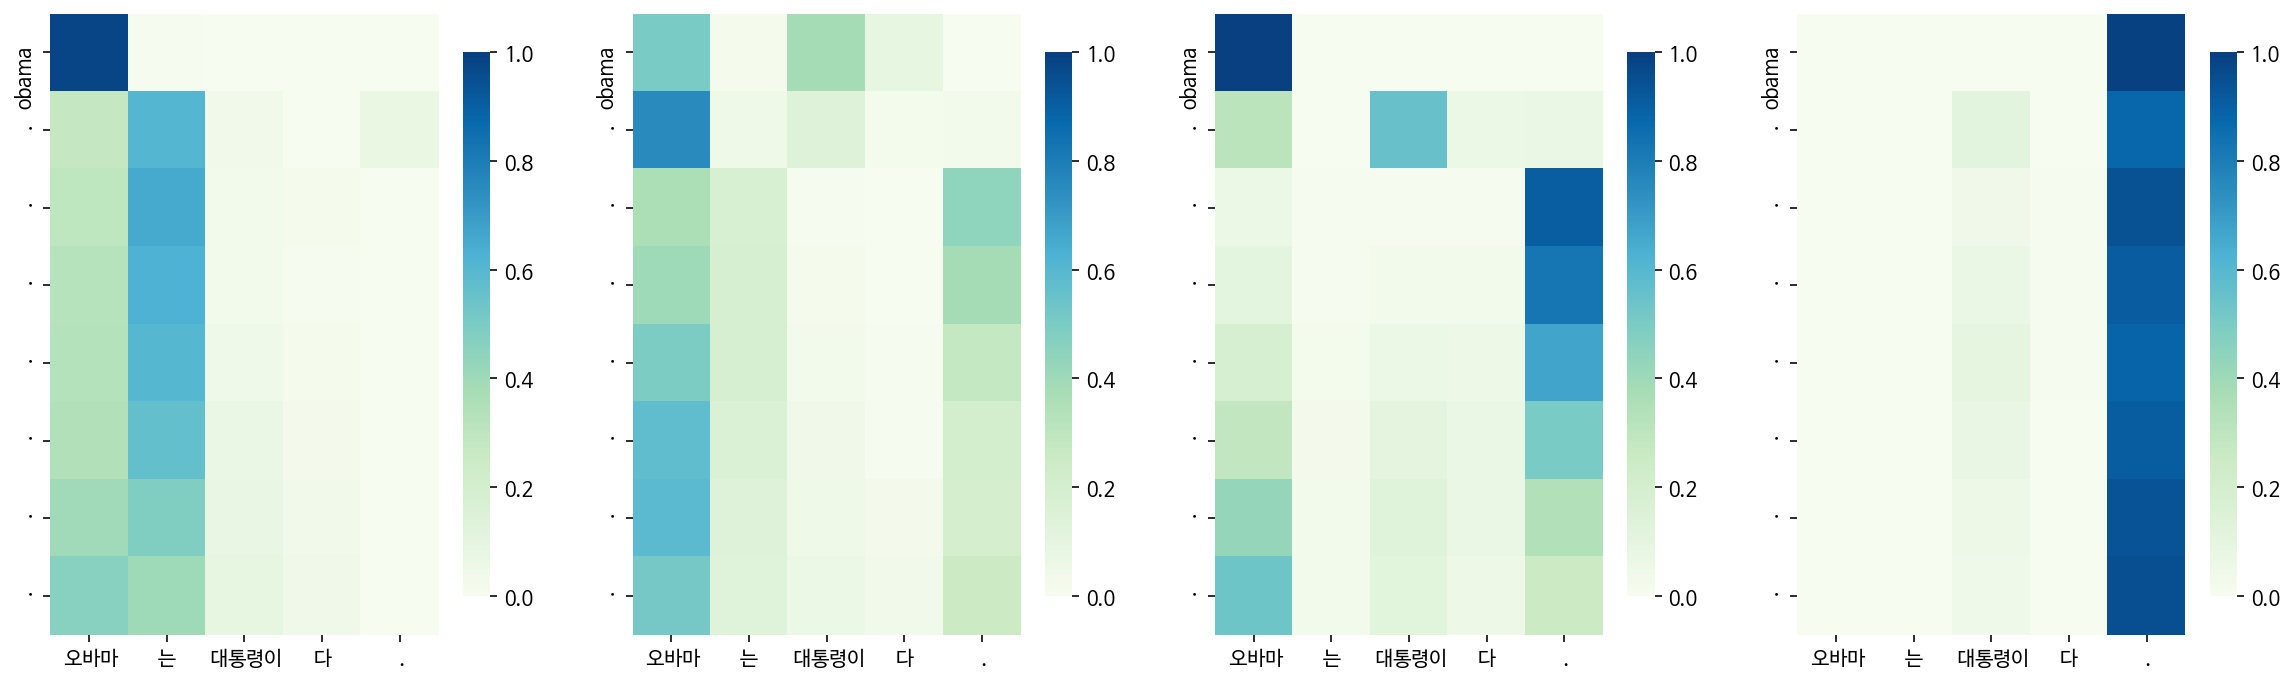

Decoder Self Layer 2


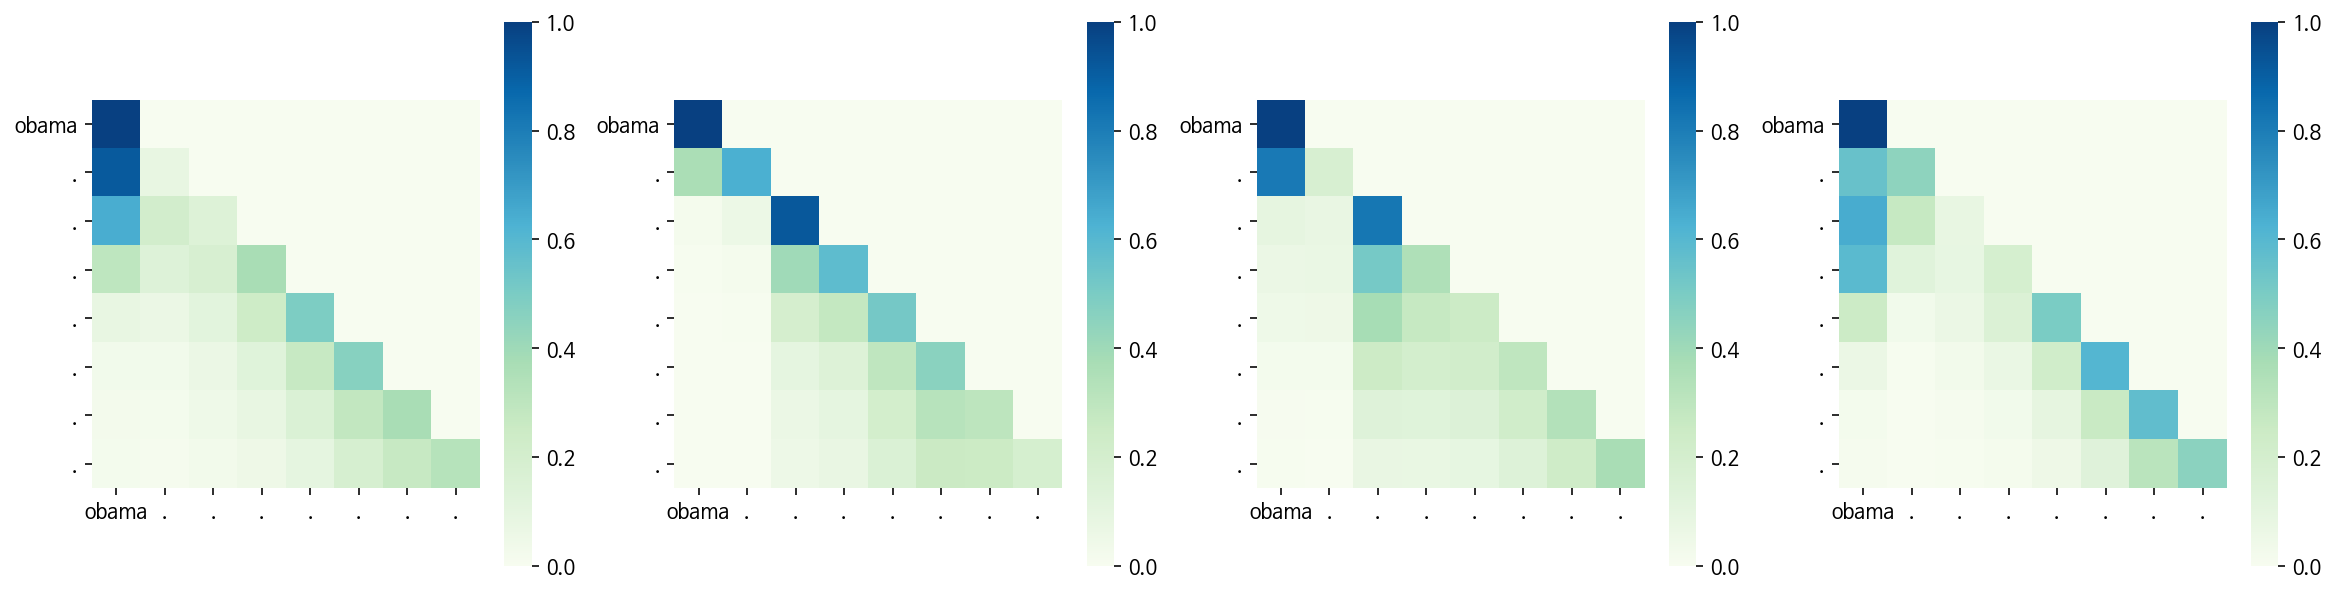

Decoder Src Layer 2


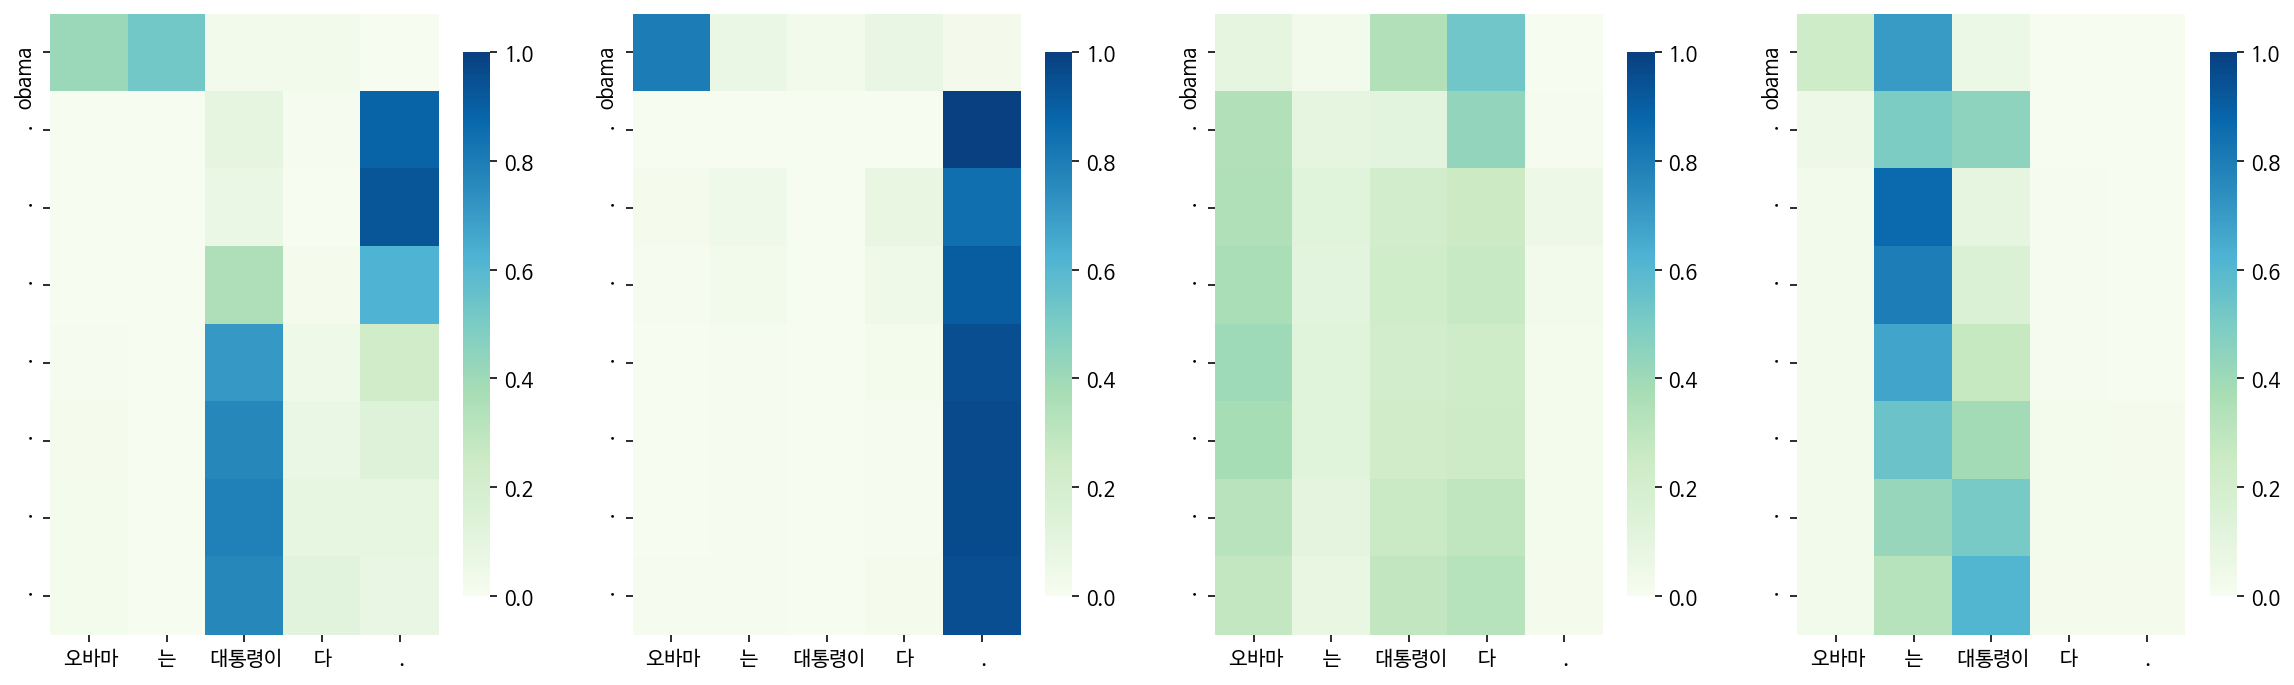

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : every in urban urbans urban . i a a know . is . . . . . . . . . . . . . . . . . . . . . . well . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : . coffee is . . . . not . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven were seven seven seven . the the dead the seven . . has     . seven dead . . . . dead the . . has   seven . . . dead injur .y  . said admitted admitted admitted admitted admitted admitted .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 21]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : urban the in stands the th stands know she in s     to say s . s . know . s s s . . . know . . s . . know . . is . . well . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : is . . . . . not . . . . . . . . . . . . . . . . . . not .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven were . the better availab . we the we has the . . . we . this this . . . . . . . . . . . . the said admitted admitted admitted monda . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 22]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama over obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : every in urban urban urban know . know know . s . know . . . are . . . . . . . . . . . . . . . . . . . know . . is . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is . . not . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven were among dead the . the the the seven . . . seven . . dead . the . . seven . . . dead . the . .ed .ed . theed .ed . numbered . said


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 23]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . just . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : townss are every in every every . every every in every . city accompani in on on the
🇰🇷 : 커피는 필요 없다.
🇺🇸 : is . . . not . . . . . . . . . . not
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven were . dead . . seven . seven . . seven . . seven . . . dead . . . . . seven . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 24]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : s are well . . . well . . . . . . . . .lylylylylylylylylylyly .lylylyly . . . every . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : is not . . . not . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven . seven seven seven from seven seven . seven seven . from central central central central central andother . occurreded .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 25]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : every in urban towns towns towns reported . the . . . . . . . . . . . . . . . . . . . . . . . . . are .n .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is . not . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven were . . seven . seven . . . seven . . . . . . seven . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 26]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . he . . . . . . . . . . . . . . . . . . obama . . . . . . . . . . . . . just . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : every urban in towns towns every towns city
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so . is not . . not any any . . . . not not or
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven were . seven . seven seven . seven . seven . . seven . . seven . . . seven . . . . . . . . . seven . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 27]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : every well . pa is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . is t .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : . not any any . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven were among .menmen seven seven . . seven . . has . from seven seven . . . . . . dead . . . seven . . . reported . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 28]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . obama . . . . . . . . . just . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : t refus people are . . . . t on . t there know know know strange .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven . seven seven seven seven seven from delegatessss centrals seven from central hall central .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 29]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . just . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people are . . t . t . . t . . t . . t . . t . . . t . . know . well . . . . . . . . is .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven . seven seven seven from seven . seven seven . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 30]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : . obama . . . . . . . . . . . . . . . . . . . . .
Encoder Layer 1


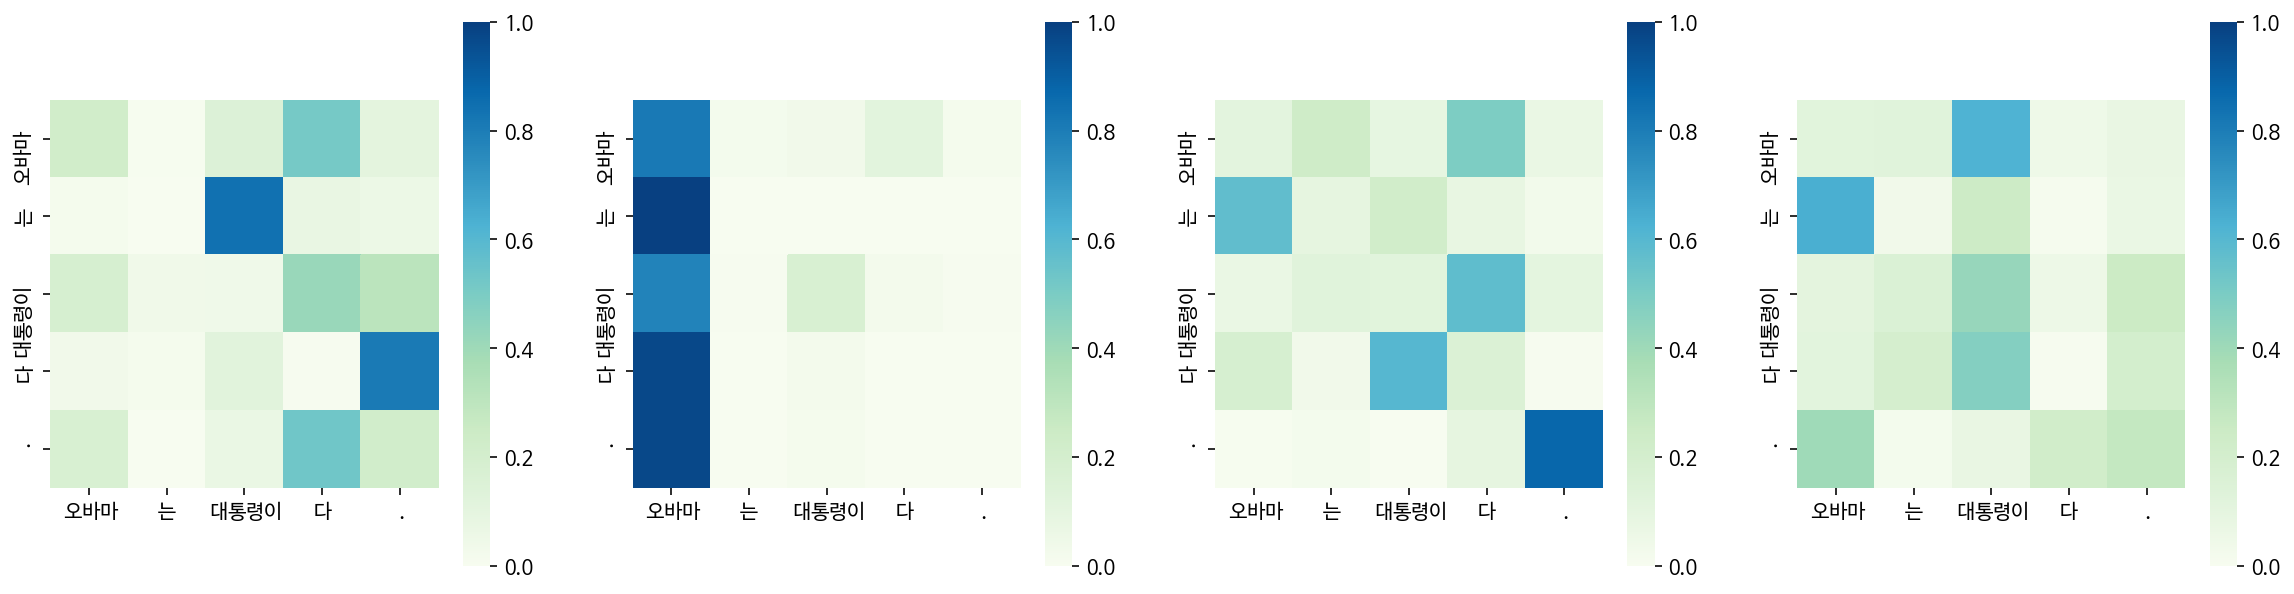

Encoder Layer 2


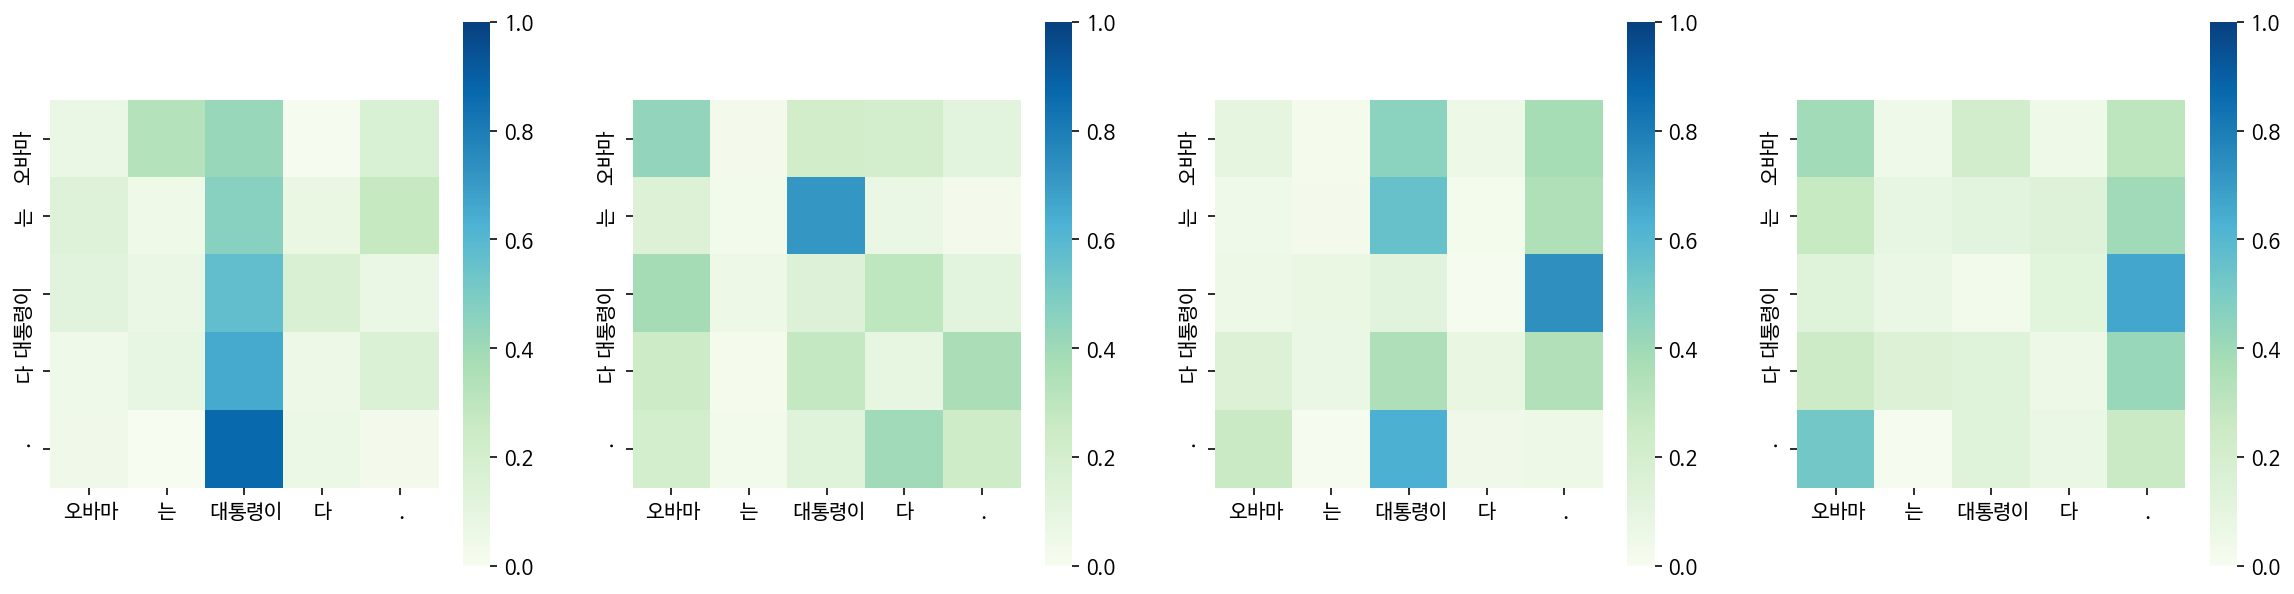

Decoder Self Layer 1


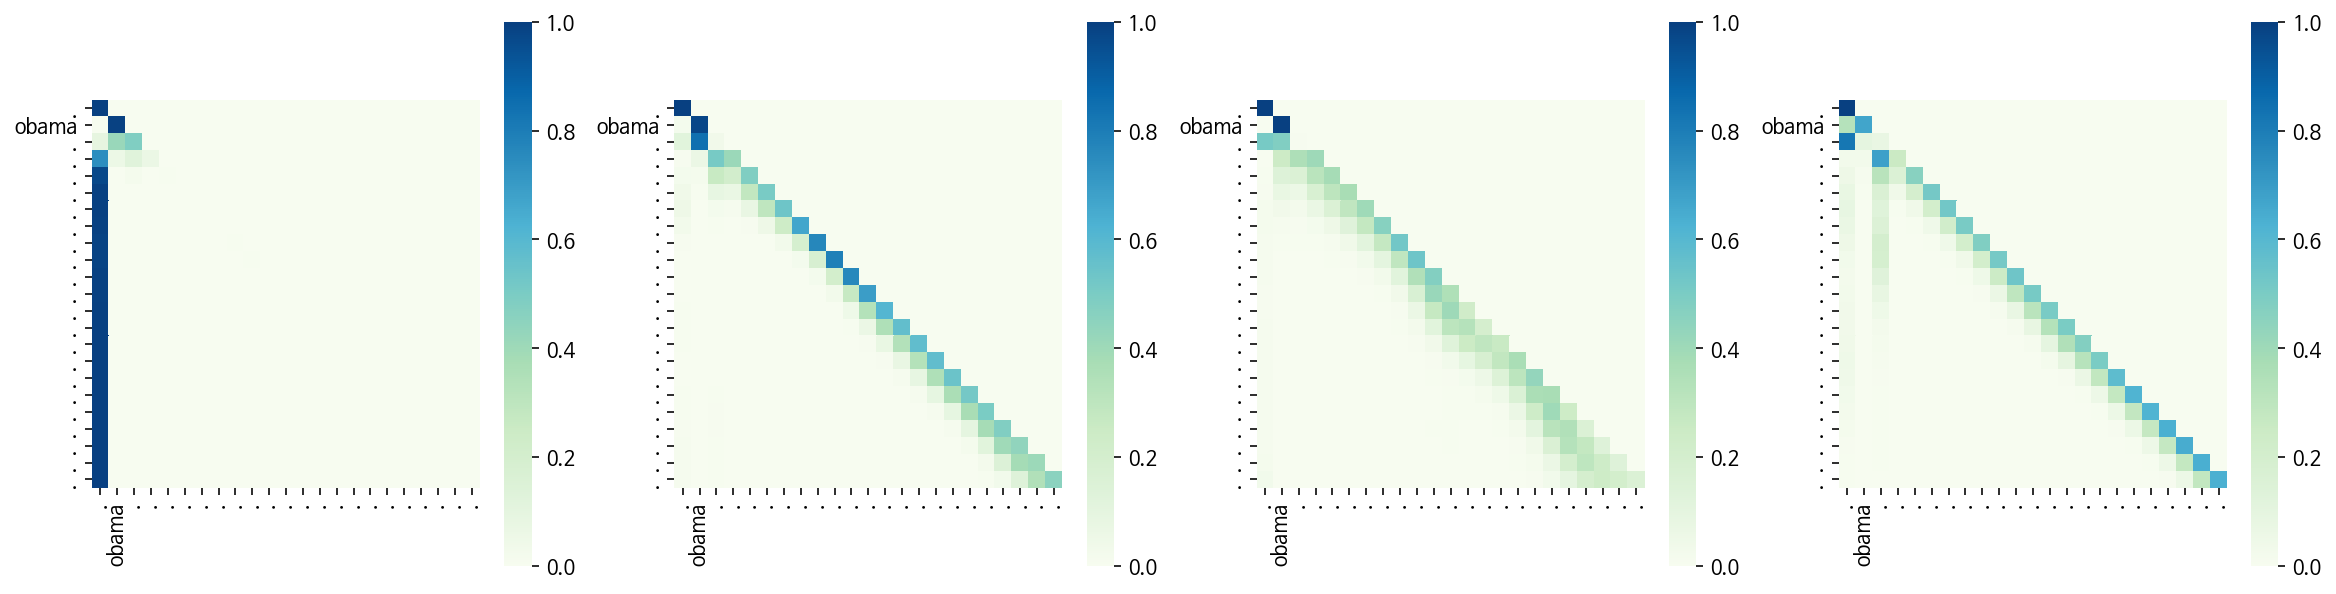

Decoder Src Layer 1


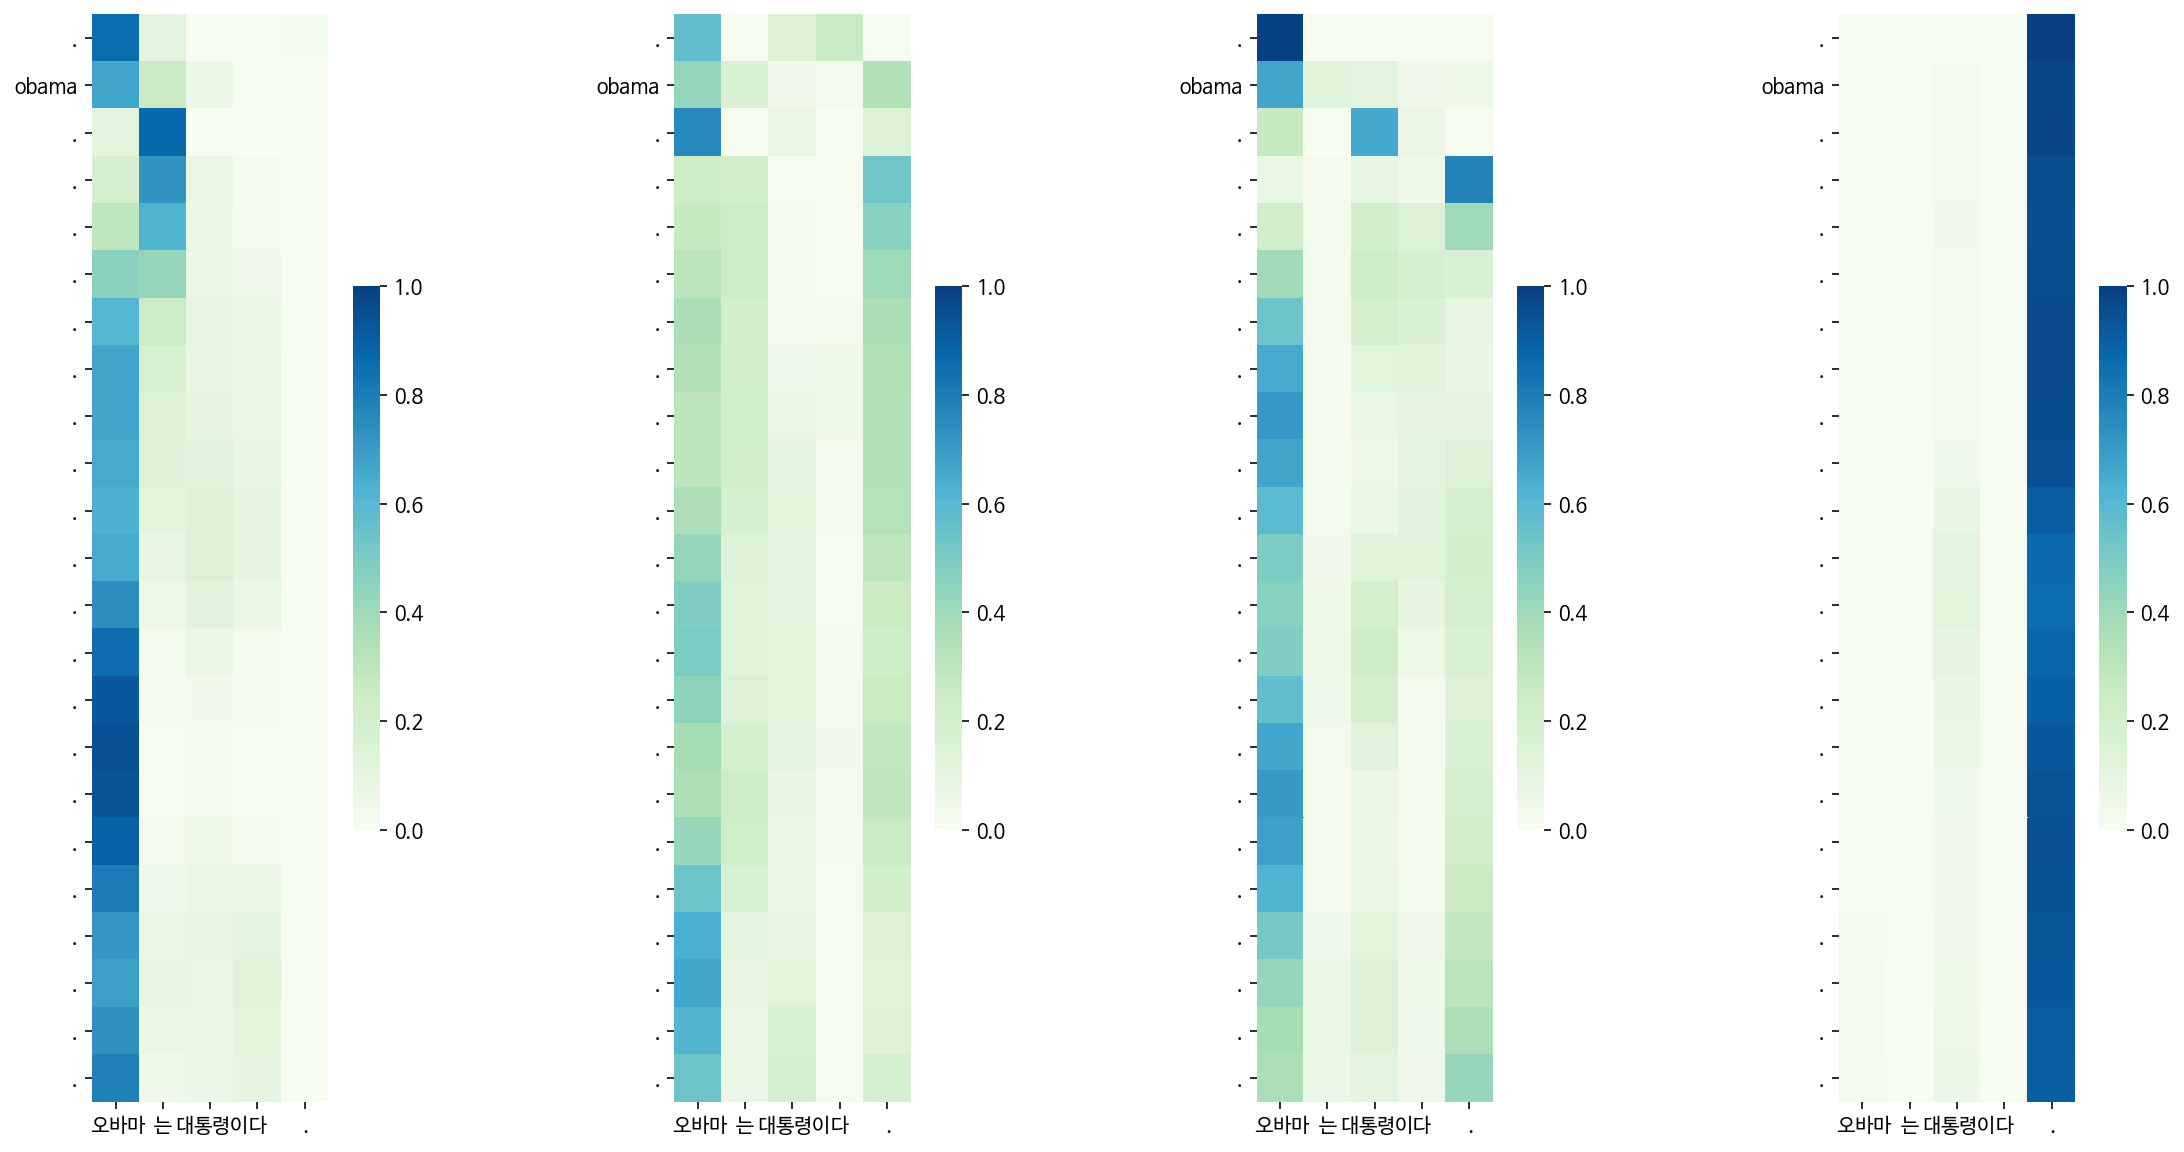

Decoder Self Layer 2


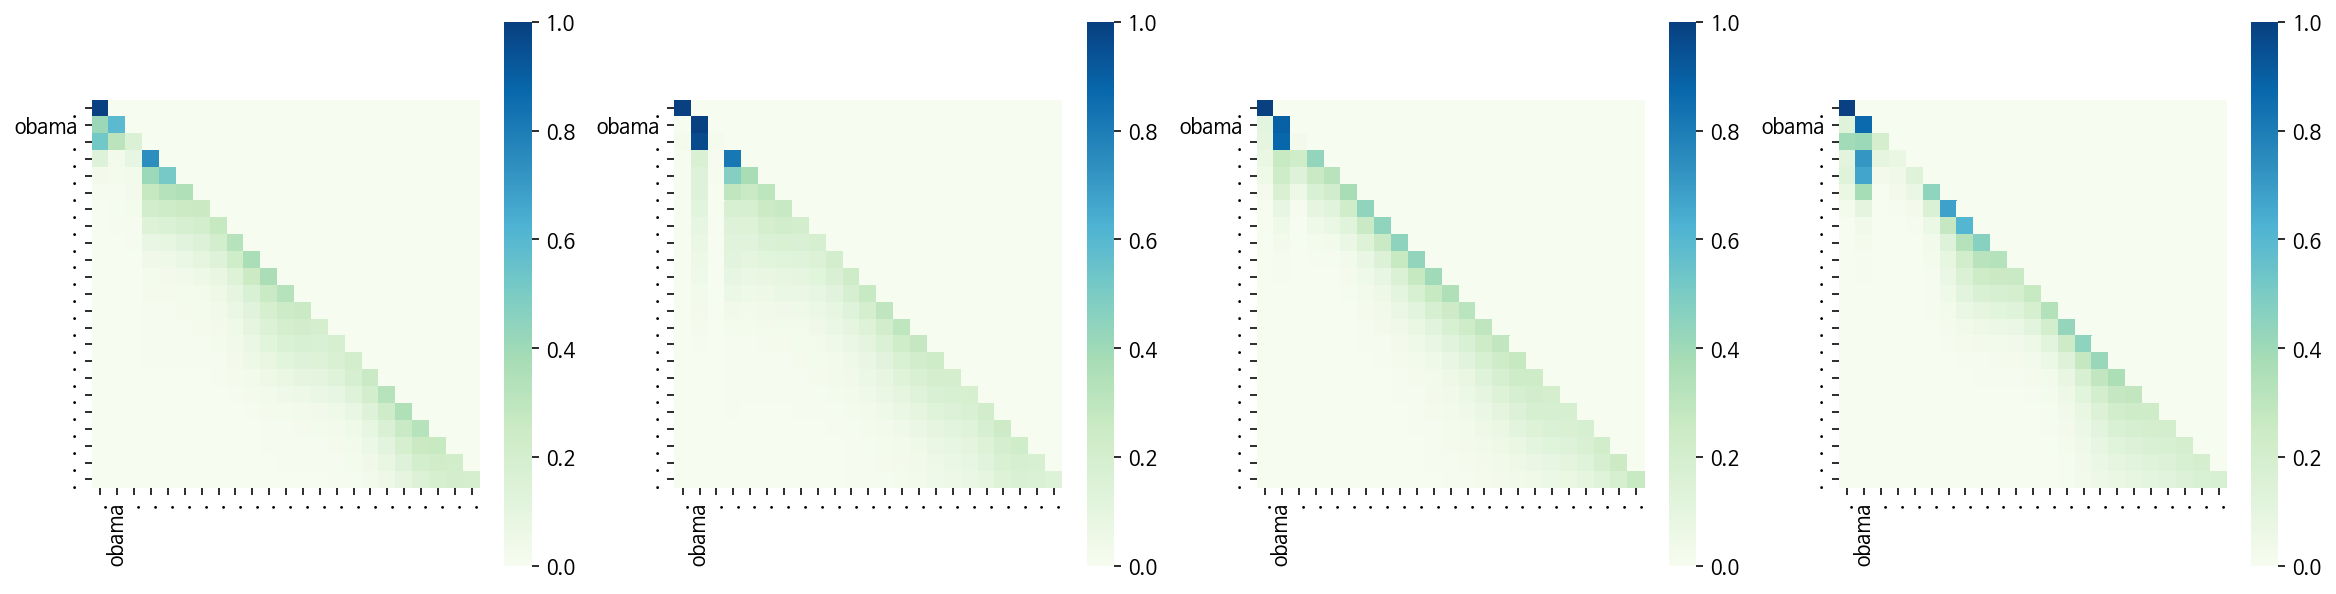

Decoder Src Layer 2


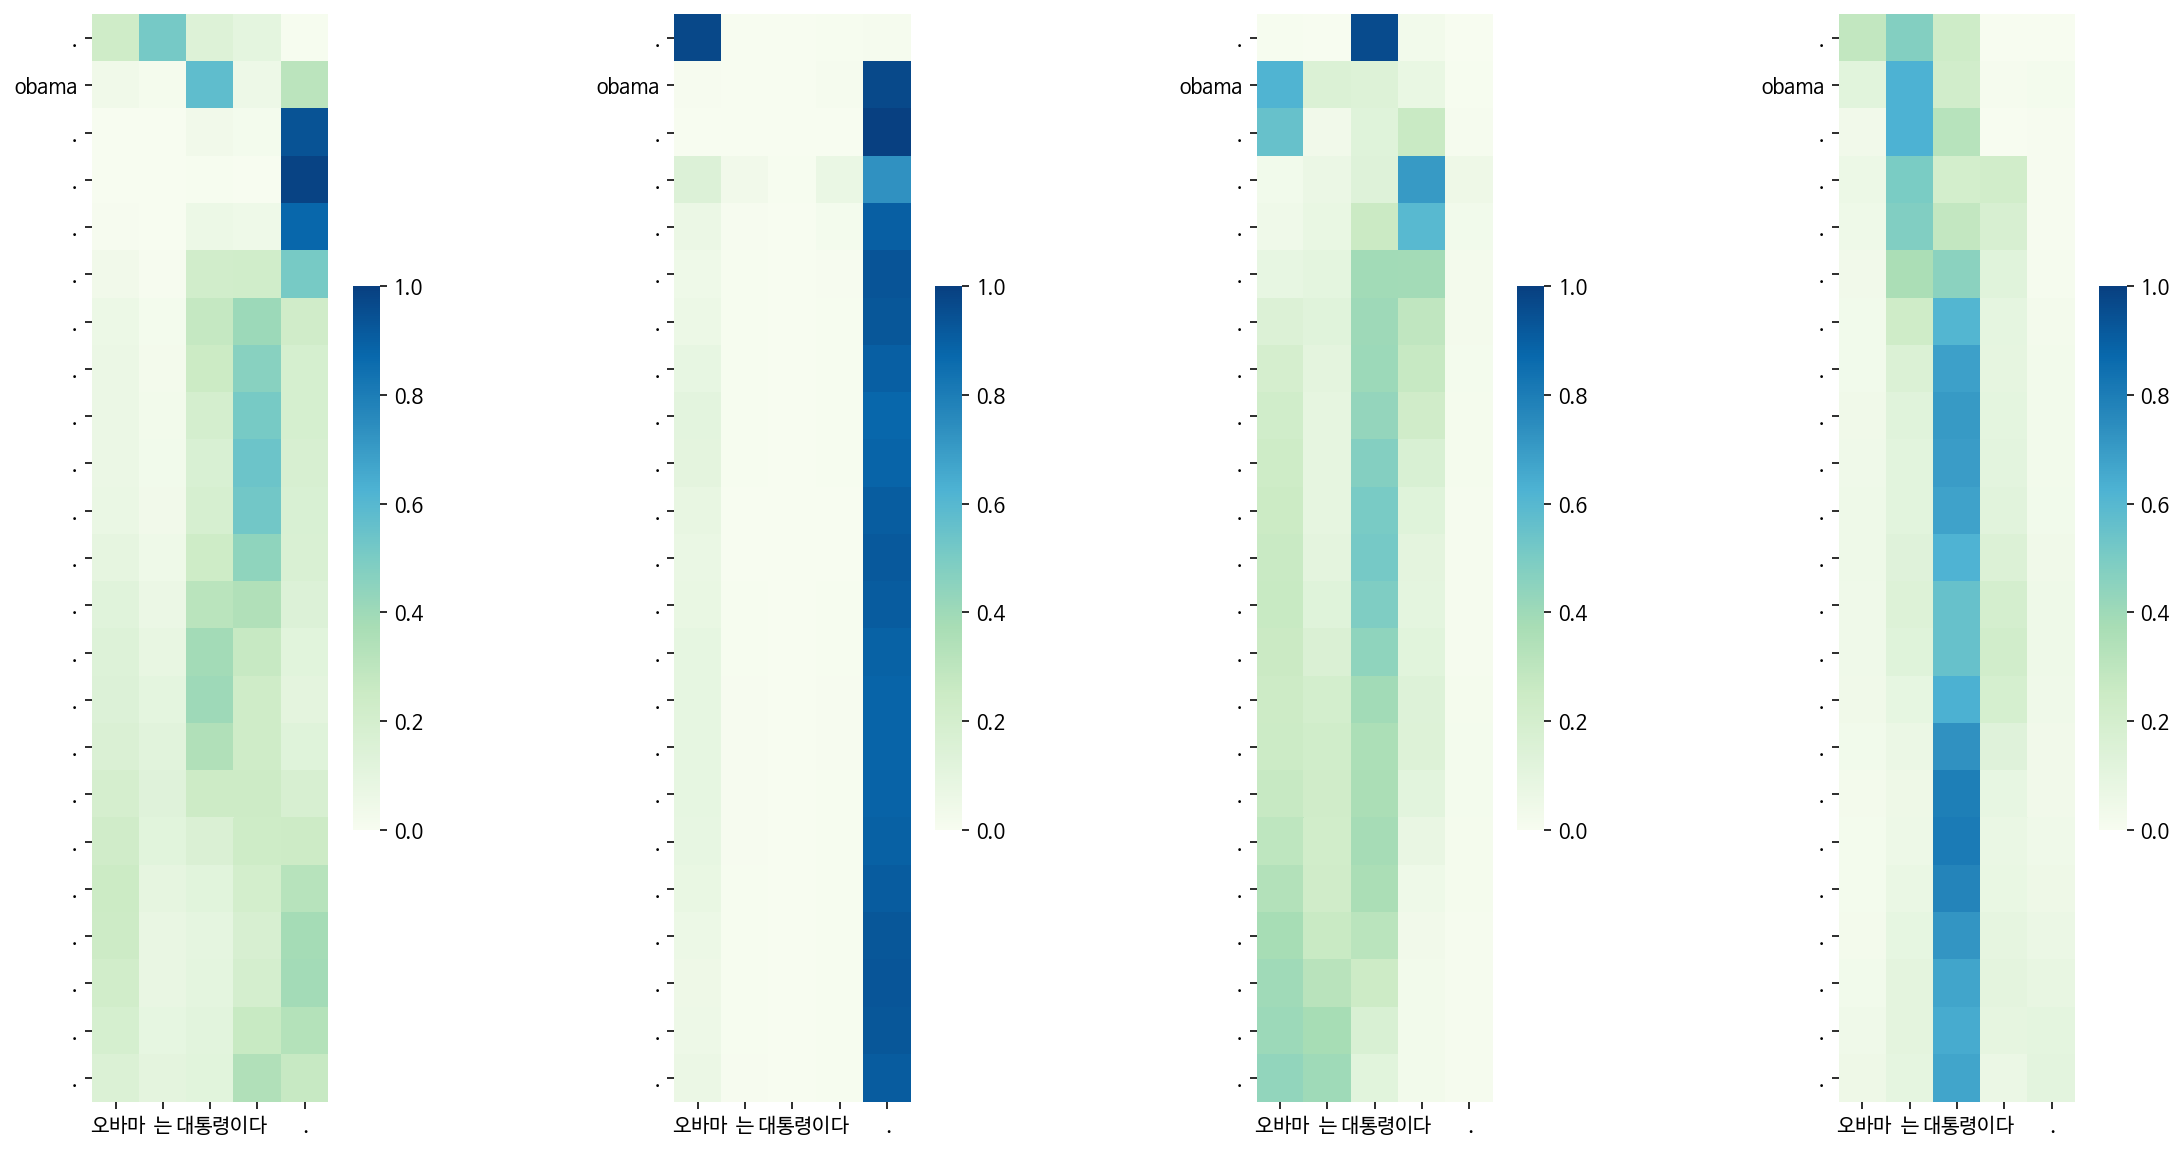

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : stands every . brita city . . i is . . . . . . . . . . . . . . . . . . . . . . . . . i t t . know . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : . coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven sevens were .   . . . . .  . .  .  . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 31]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . .        . . . . . . . . . . . . . . . . . just . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : people brita the are in . say say . stands inin every . on . . people . . . . . . . . are . . . . . . . . . . say . s
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no . does .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven sevens were the among the the seven seven seven seven seven . seven . seven  . seven . the . . seven . . . seven .  . the  seven . . seven . people ed dead  . said


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 32]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : violen mexicans every every every every year . is . . are . . . . . . . . . . . . . . . . . . . . are . . . said
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee . is . knock . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven were among dead thursday the reported . the the mount . pick the the mount the mount mount mount . the pick the the the the the the the killeded recognieds .eds .  said


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 33]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . as as . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : violen every in every city c brita in over in  in  brita in over in
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee . does . is . . need need need need need need need down . down
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven were in since  seven seven seven seven seven seven . seven . seven . . . . .  . . .  seven be . . . .n  .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 34]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : stands violen every in every this every every in this every this . has over . well . . . . . . . . . . . . . . . . . . s . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee . . . . . is . . . . . . . . . . . . . . . . . . . . . . . . . . . . coffee . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven were thursday     .   .   . . . .  . . . . . . . . . . . . seven . .  . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 35]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : in every city every city every are . . . . . . . . . . . . . . . . . . . . . . . . . . in . s .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : no . . . . . don . not . . . . . . coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven were among .         . . .  . that seven . . . . . . . . . .  . 


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 36]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . just . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : violen every every year city every stands every every in every city . are . . . . . . . . . . . . . . . . . . . . . . every . . . is .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is . . . . . . . . . . . . . . no . . . . . . . does . . . . . . . . . . . coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven employee seven seven seven seven seven seven seven seven seven seven seven seven seven were be . kill thursdayed thursdayed thursdayeded .ed . .ed .ed .ed . .ed


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 37]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . say . obama as as as . . as as as as as as as as as as . as as as as as as as as as as . as as as as as as as as as as as . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : violen in every in stands in every city every every in every . city stands in . are . . . . . . . . . . . . . . . . . every . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee does . . . does . . . . . . . no . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven employee seven seven seven seven seven seven seven seven seven were since saturday start . split  saturday  saturday care . . . . .ed . . . .ed . . . theed saturday . said


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 38]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : violen every in every in city every stands in every every every in   city   brita s s . i is . . . . . . . . . . . every . . . every . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : no . . . coffee . no . no . . . . . . . coffee . is . . . . . . . . . . . . . . . coffee . . . . is .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven seven seven seven seven seven seven seven seven seven freighter be and . thats be from . . . . . . . . saturday mounted mounted . came . numbers . said number number cat . mount mount mount ever


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 39]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . just . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : violen in every in year c city the people the every in the   to  the  .   . in       .  . in . . s
🇰🇷 : 커피는 필요 없다.
🇺🇸 : . no . . . . . coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven the and seven seven were in . the the the  .  . .  . . . . . .  . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 40]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama he . he . . . . . . . . . . . . . . .
Encoder Layer 1


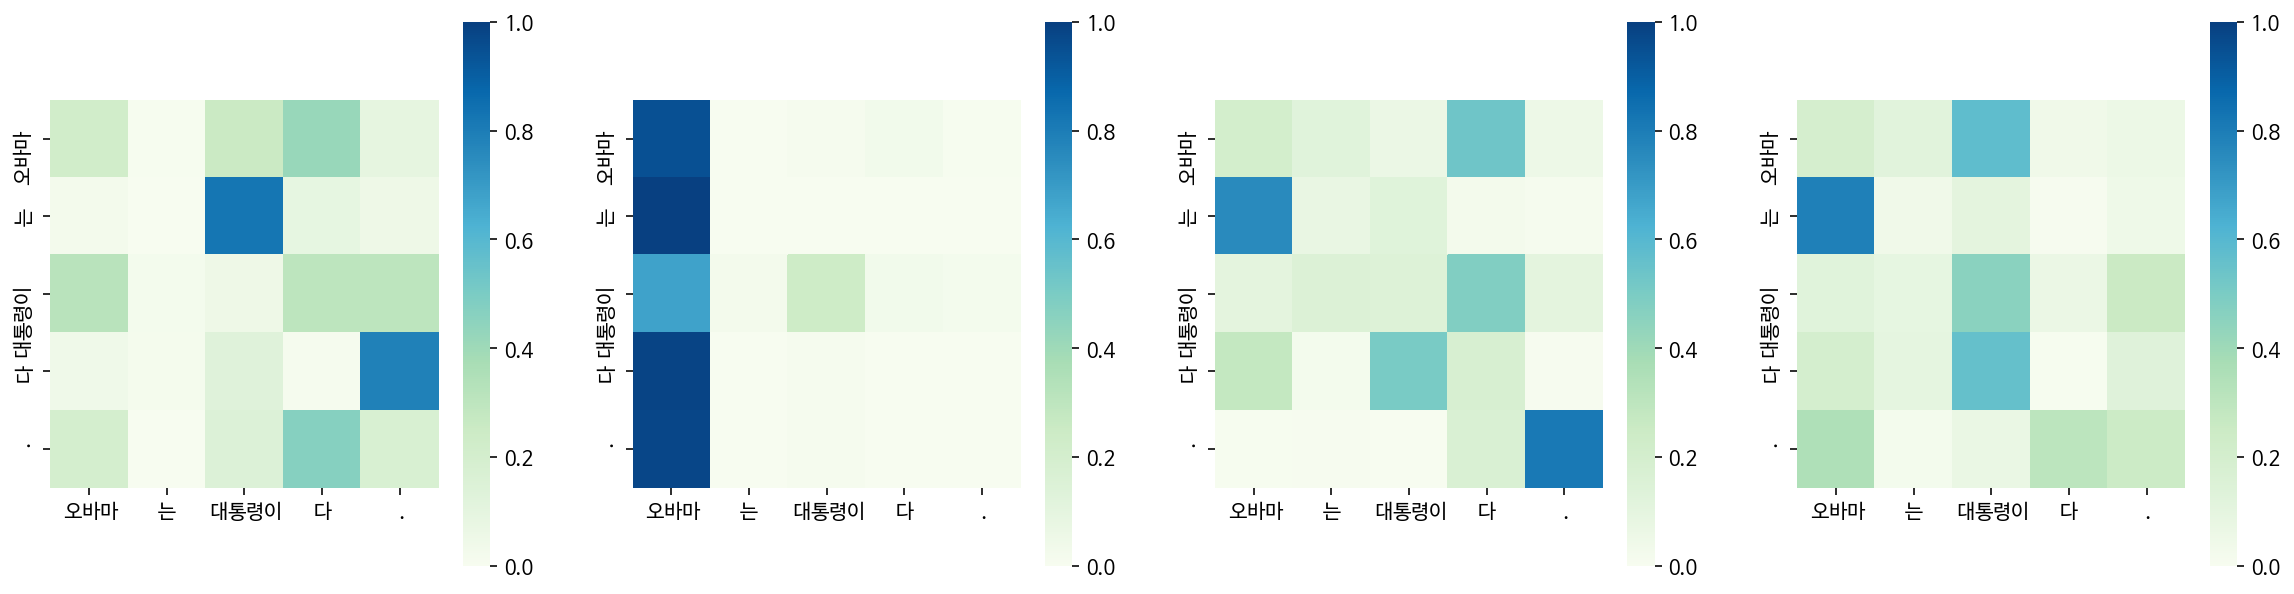

Encoder Layer 2


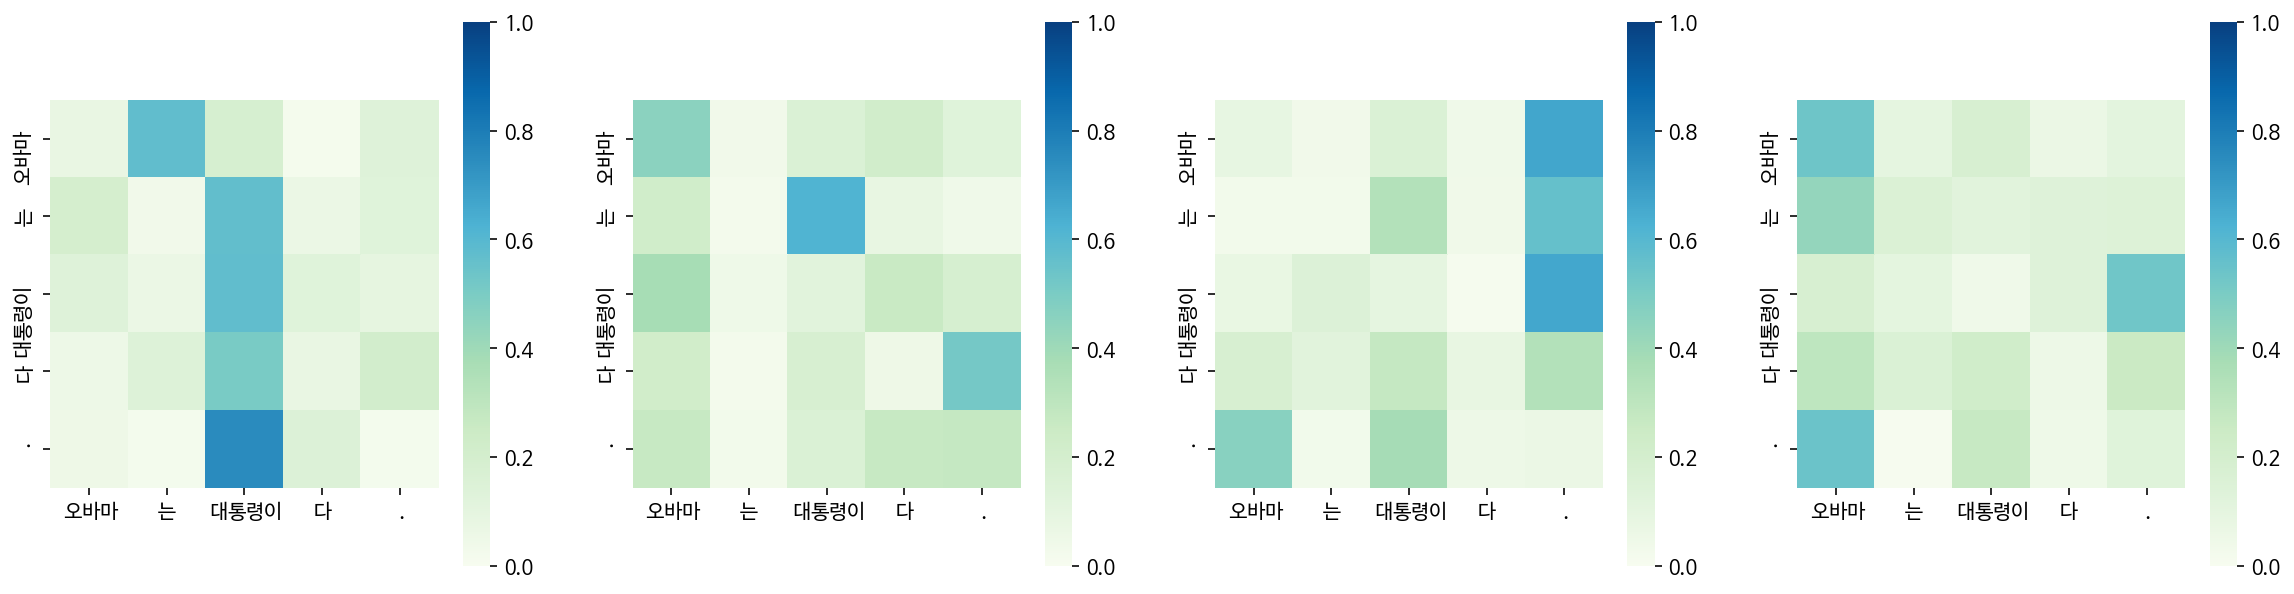

Decoder Self Layer 1


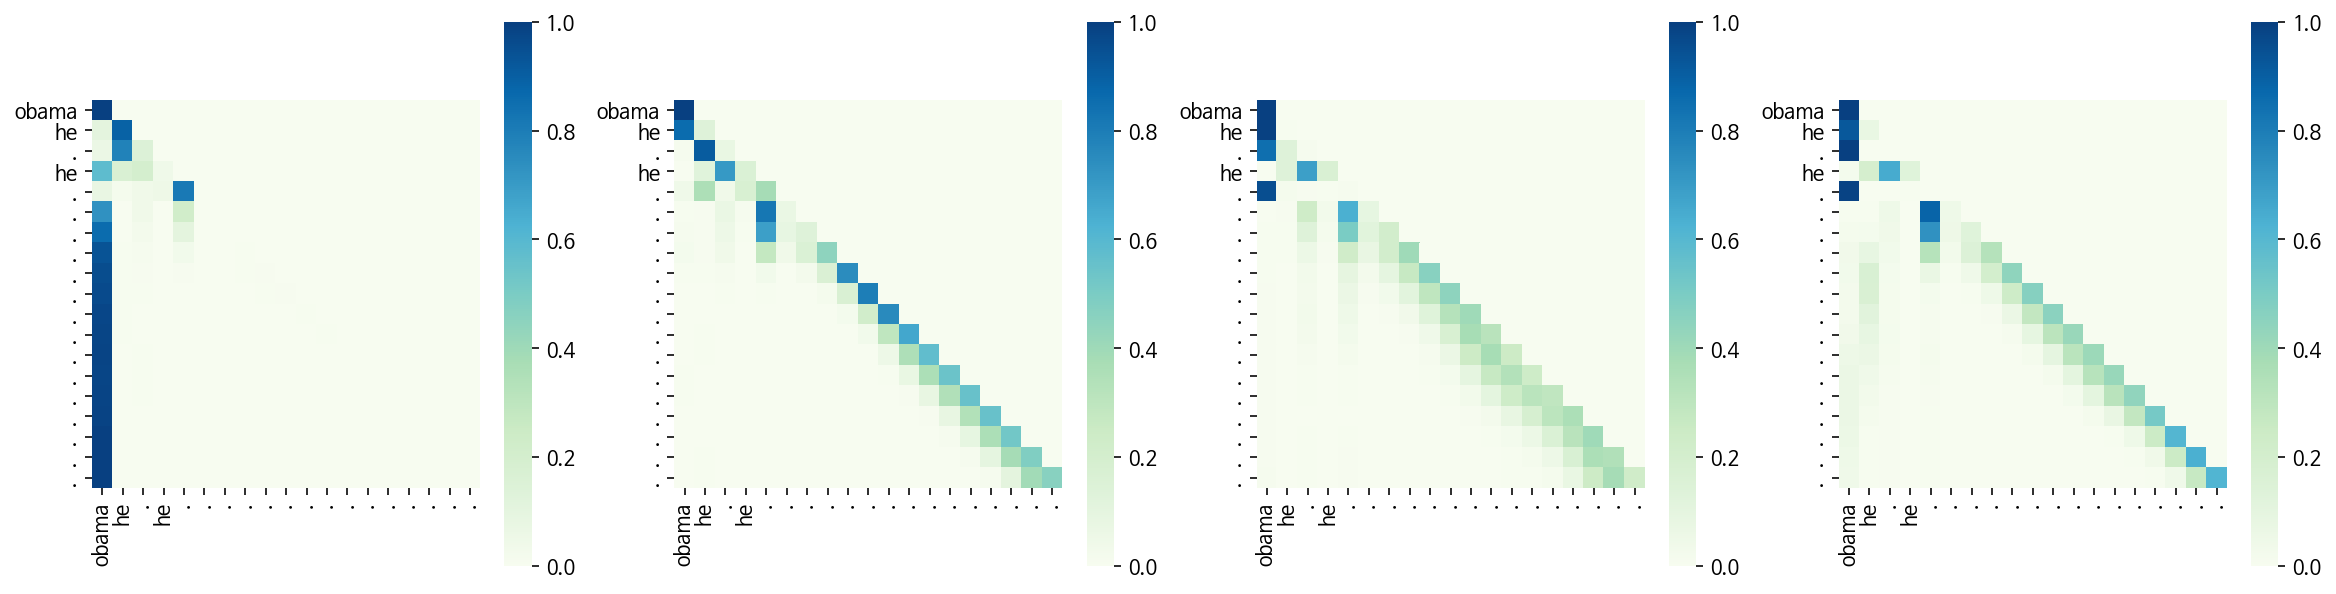

Decoder Src Layer 1


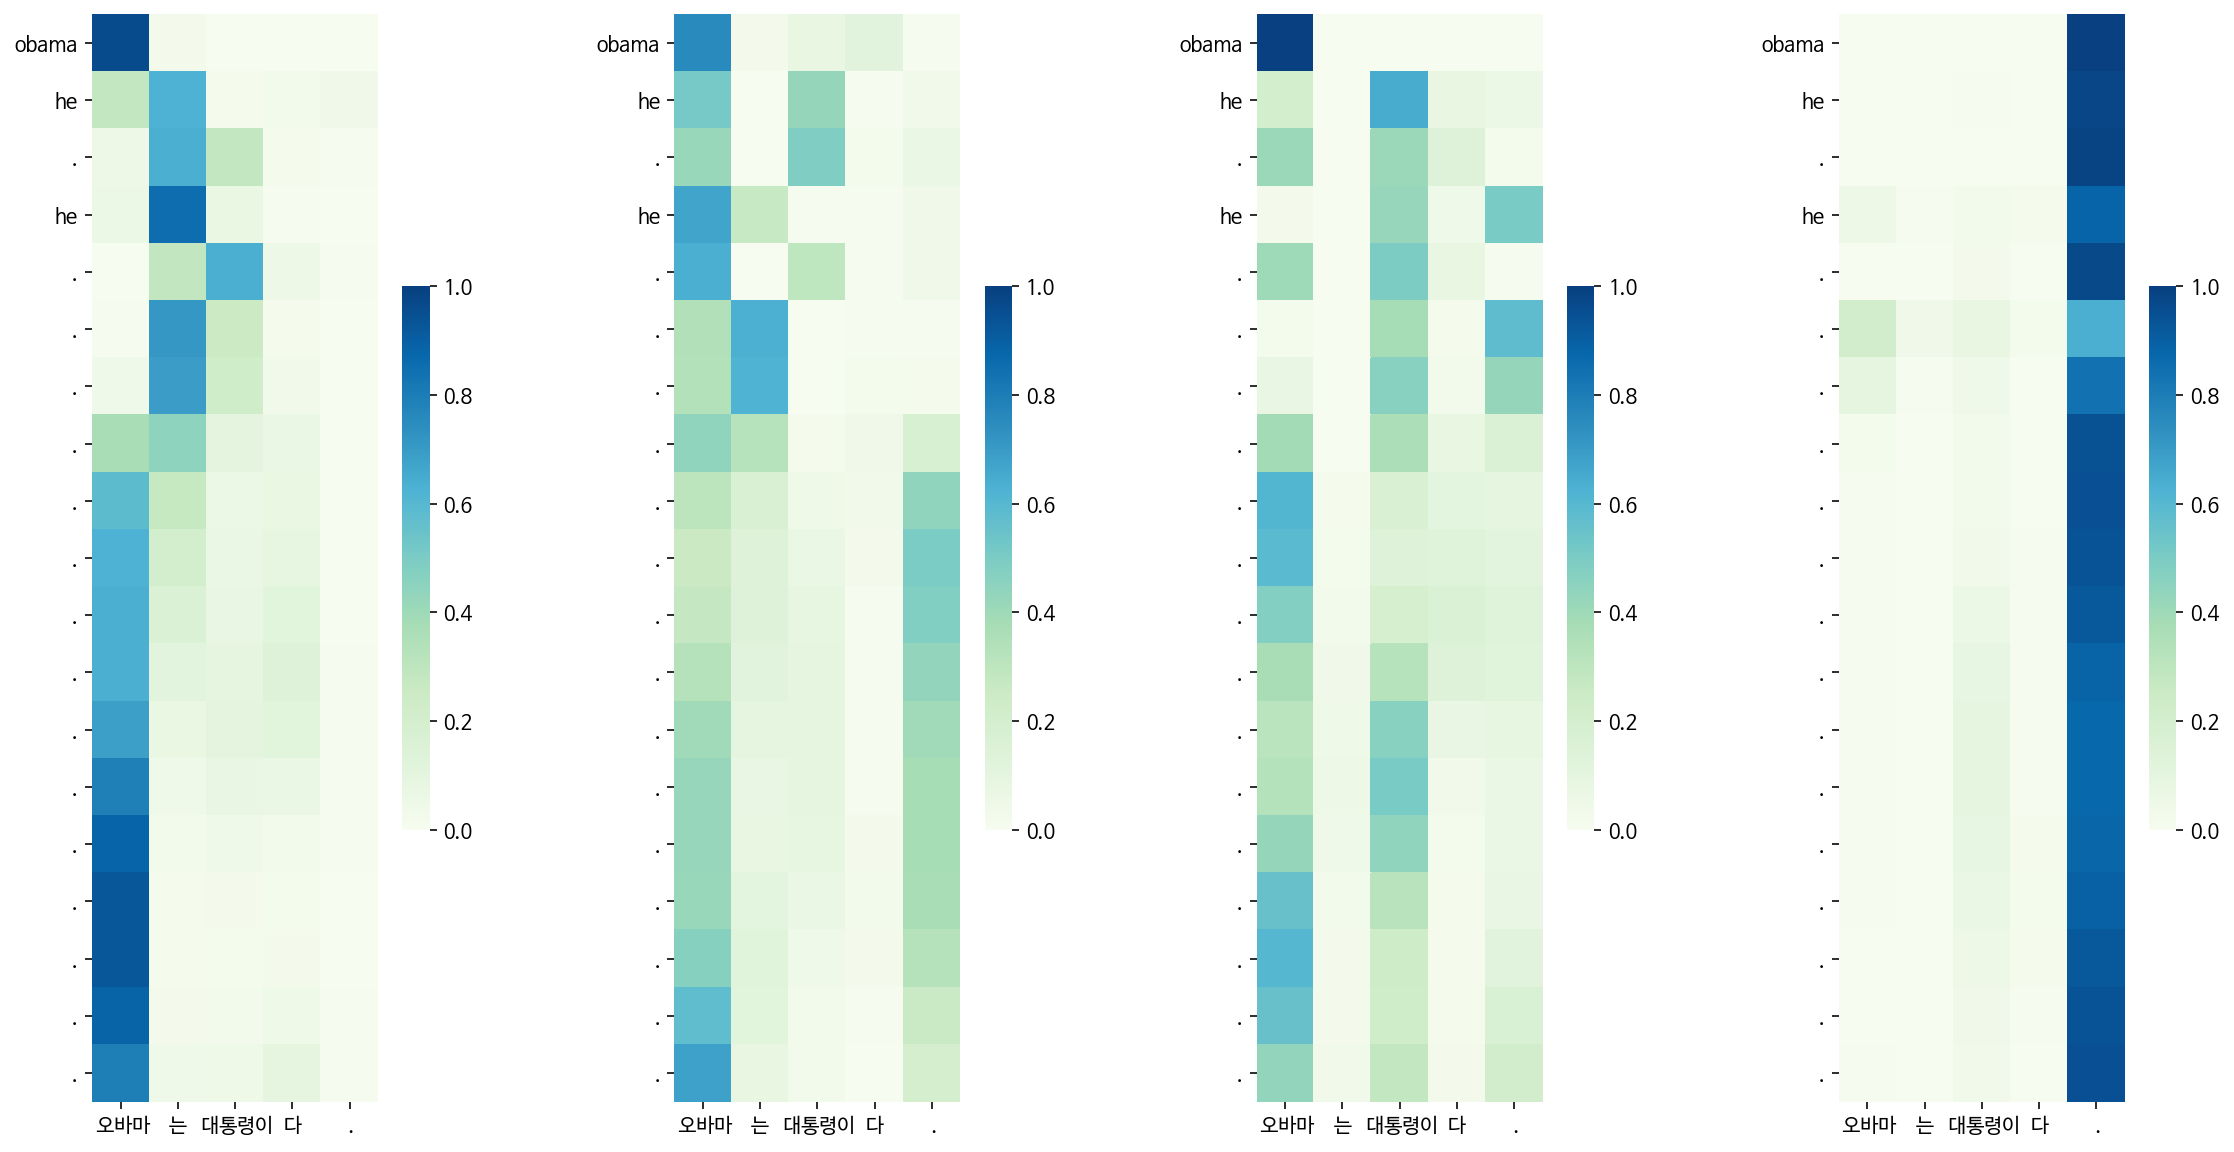

Decoder Self Layer 2


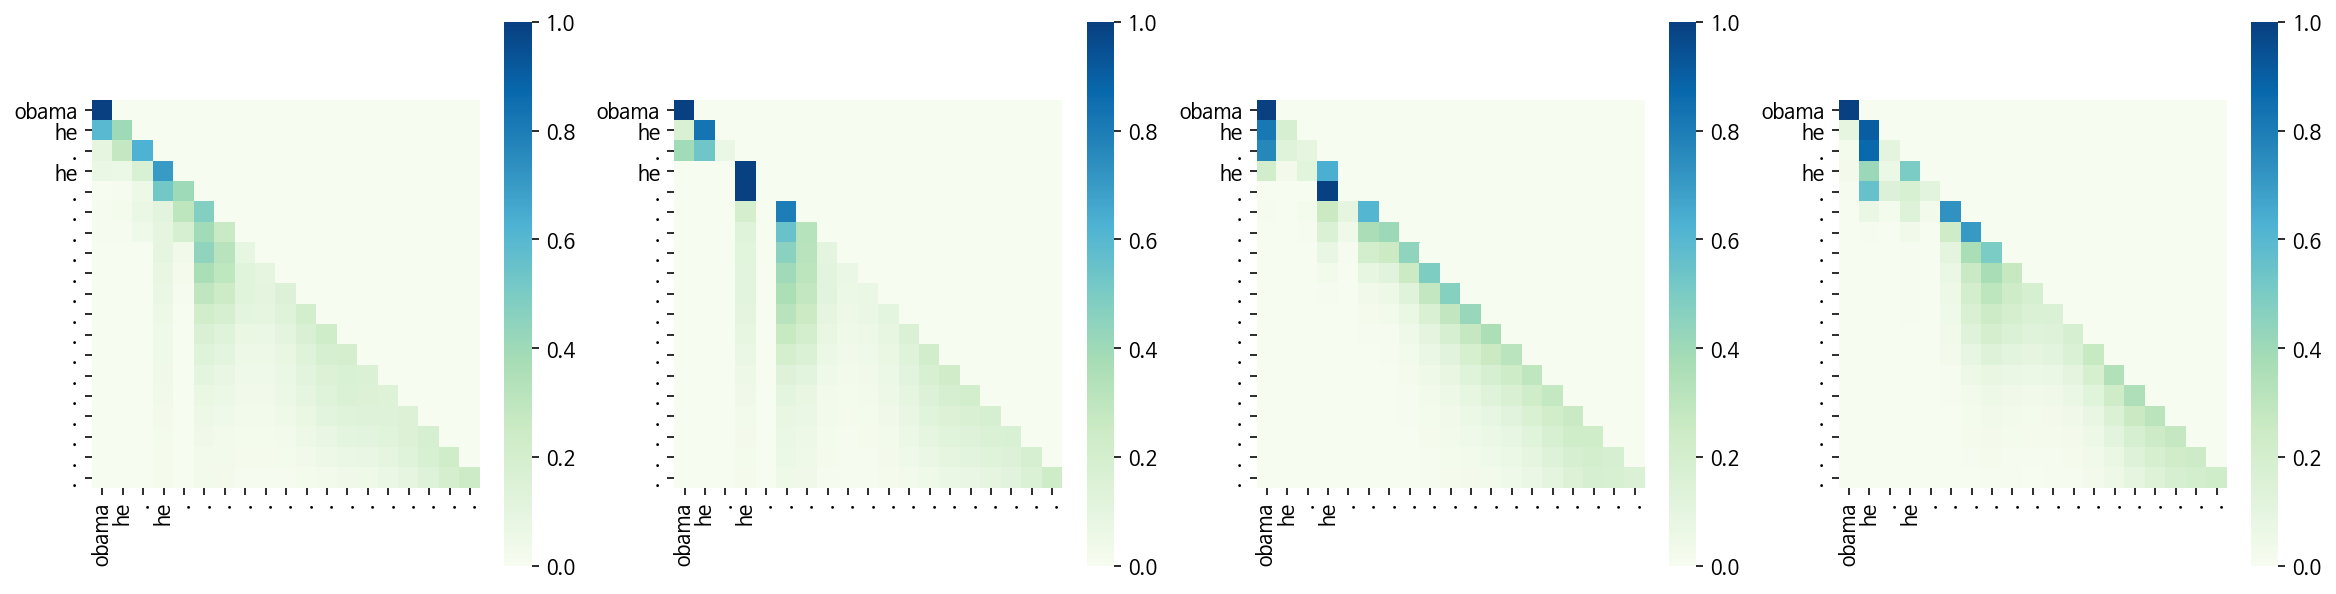

Decoder Src Layer 2


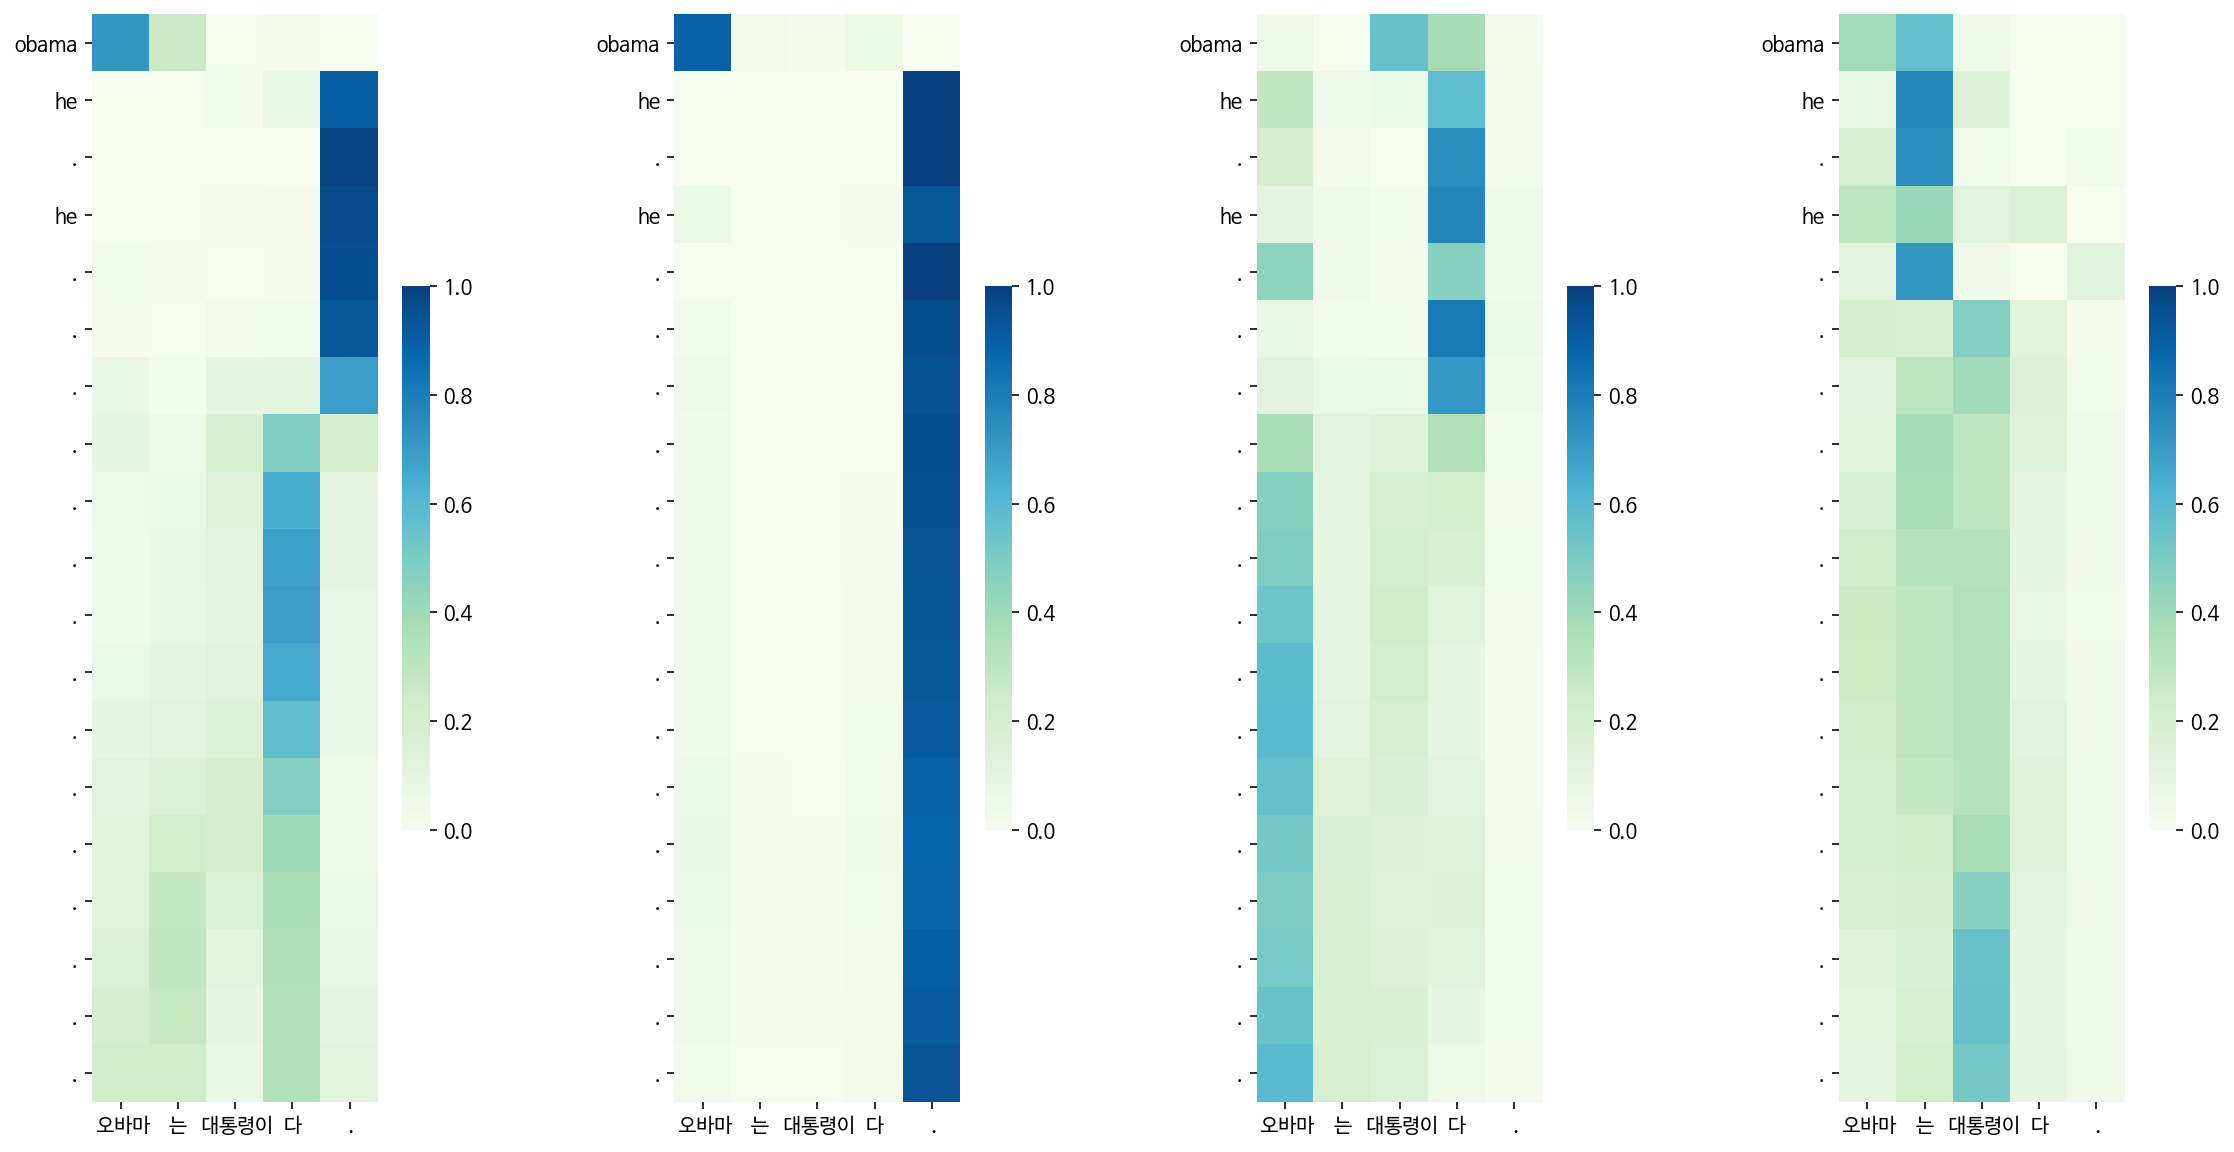

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : brita people s are . . . every . every . . people know . know . know . . . . know . . . . . . . . . . i know . . . . is . every . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : . no . . . . . . . . . . . . . . . . . . coffee . . . . . . . . . . coffee . . . . . coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven seven seven seven seven and were the . the  the           .      control and .     .


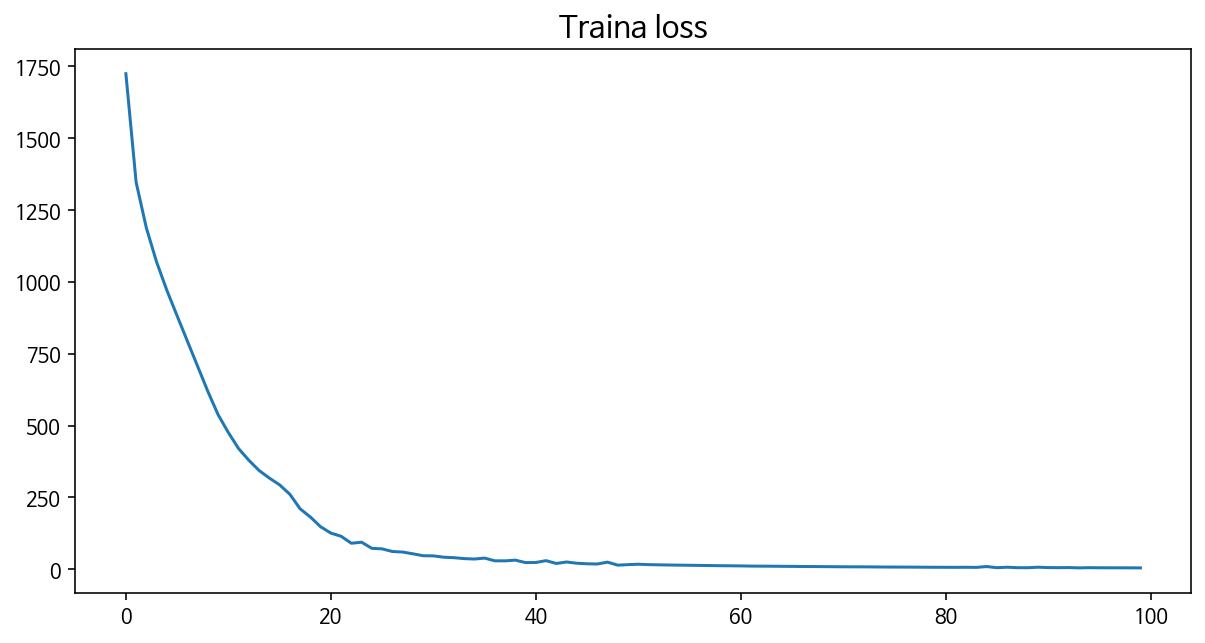

In [312]:
losses_100 = train(transformer, optimizer, enc_train, dec_train, 
                   ko_tokenizer, en_tokenizer, examples, 40, 256)
show_train_loss(losses + losses_40 + losses_60 + losses_100)

#### 결과

In [47]:
def print_result(model, src_tokenizer, tgt_tokenizer, sentences,
                n_layers=2, d_model=512, n_heads=8, d_ff=2048, dropout=0.1):
    
    print("Translations")
    for i, sentence in enumerate(sentences):
        pieces, result, enc_attns, dec_attns, dec_enc_attns = \
            evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
        print(f"> {i+1}. {result}")
    
    print()
    print('Hyperparameters')
    print(f'> n_layers: {n_layers}')
    print(f'> d_model: {d_model}')
    print(f'> n_heads: {n_heads}')
    print(f'> d_ff: {d_ff}')
    print(f'> dropout: {dropout}')

In [314]:
print_result(transformer, ko_tokenizer, en_tokenizer, examples,
             n_layers=2, d_model=512, n_heads=8, d_ff=2048, dropout=0.1)

Translations
> 1. obama he . he . . . . . . . . . . . . . . .
> 2. brita people s are . . . every . every . . people know . know . know . . . . know . . . . . . . . . . i know . . . . is . every . . . . . . .
> 3. . no . . . . . . . . . . . . . . . . . . coffee . . . . . . . . . . coffee . . . . . coffee
> 4. seven seven seven seven seven and were the . the  the           .      control and .     .

Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.1


각 문장의 대표적인 단어들(obama, people, coffee, seven)은 번역이 이루어졌으나, 대부분의 문장이 `.`으로 채워진 불완정한 상태이다.

## Step 5. 추가실험
---

### A. 파라미터 개선

동일한 모델에 파라미터를 개선하여 실험을 진행해보았다. 해당 파라미터는 논문의 결과표를 참고하였다.

In [73]:
hyperparameters_2 = {
    'n_layers' : 4,
    'd_model' : 512,
    'n_heads' : 8,
    'd_ff' : 2048,
    'dropout' : 0.3
}

transformer_2 = Transformer(n_layers=hyperparameters_2['n_layers'], 
                          d_model=hyperparameters_2['d_model'], 
                          n_heads=hyperparameters_2['n_heads'], 
                          d_ff=hyperparameters_2['d_ff'], 
                          src_vocab_size=SRC_VOCAB_SIZE, 
                          tgt_vocab_size=TGT_VOCAB_SIZE, 
                          pos_len=50, 
                          dropout=hyperparameters_2['dropout'])

In [74]:
learning_rate = LearningRateScheduler(hyperparameters_2['d_model'])
optimizer_2 = tf.keras.optimizers.Adam(learning_rate,
                                      beta_1=0.9,
                                      beta_2=0.98, 
                                      epsilon=1e-9)

In [75]:
losses_2 = train(transformer_2, optimizer_2, enc_train, dec_train, 
               ko_tokenizer, en_tokenizer, examples, 20, 256)
show_train_loss(losses_2)

  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 1]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : is is is . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : ssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : ssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 2]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s s s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : ssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : . was   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : sssssssssssssssssssssssssssssssss . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 3]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama .ss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : ssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : . .ss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : onsssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 4]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : ss  .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : . .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : on       of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 5]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : or or .  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : on on      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 6]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the .s live .s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : or or . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : on on peopless . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 7]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama obama president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : .  cit  of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee coffee coffee . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : sunday at  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/252 [00:00<?, ?it/s]

KeyboardInterrupt: 

몇 번의 epoch를 확인해 보았는데, 이전 시도와 큰 차이가 없는 학습 양상을 보였다.<br>
파라미터의 문제가 아니라 모델의 문제점을 한번 확인해보아야 할 듯하다.

### B. 모델 개선

기존에 사용하던 evaluation 코드에서는 모델의 입력값 중 하나인 output 데이터를 `bos` 토큰으로 시작하며 나머지가 `pad` 토큰으로 채워진 길이가 max_len인 배열로 구성하였다. 이렇게 구성을 하여도 padding mask의 효과로`pad`가 채워진 부분은 무시가 가능할 것이라 생각하였다.<br>
하지만 실험결과 무의한 단어(`.`)로 채워진 문장들이 연달아 생성되었고 이는 output 변수의 영향이 없다 할 수는 없을 것이다. 이를 개선하기 위하여 output을`bos`로 시작하며 예측 결과들로만 이루어지는 가변길이의 배열로 구성하고자 코드를 수정하였다.<br>
이 경우 문제가 되는 부분은 `MultiHeadAttention`의 `scaled_dot_product_attention` 메서드이다. 메서드의 파라미터가 되는 Q, K, V는 모두 동일한 상(shape)을 가지고 상이 달라질 수 있는 것은 mask이다. 기존 코드에서 mask가 `decoder padding mask`일 경우 input과 output의 길이에 상이 영향을 받게 된다. tensorflow에서 Tensor간의 연산은 결과는 상이 더 큰 쪽을 따라는 경향이 있다. 따라서 output 길이가 1인 경우, input의 상은 max_len을 따르기 때문에 input의 상이 output의 상보다 값이 크게 되고 mask의 상 역시 input의 상을 따라가게 된다. 이 경우 아래의 scaled_dot_product_attention의 7번째 줄의 연산을 거쳤을 때의 `scaled_qk`의 상은 4번째 줄의 `scaled_qk`의 상과 다른 모습을 보이면, 결과적으로 `attentions`와 `V`의 상 차이로 인하여 `tf.matmul` 연산이 불가능한 상화에 놓이게 된다.

```python
    def scaled_dot_product_attention(self, Q, K, V, mask):
        matmul_qk = tf.matmul(Q, K, transpose_b=True)
        dk = tf.cast(K.shape[-1], tf.float32)
        scaled_qk = matmul_qk / tf.math.sqrt(dk)

        if mask is not None: 
            scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
```

이 점을 개선하고자 `evaluate` 함수와 `generate_masks`  함수를 아래와 같이 수정하였고 이 작업은 아래의 코드를 참고하여 이루어졌다.

- 참고 코드
> https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb

In [109]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
            _input, output)
        
        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, 
                                                                 output,
                                                                 enc_padding_mask,
                                                                 combined_mask,
                                                                 dec_padding_mask)
        
        predictions = predictions[:, -1:, :]
        predicted_id = tf.argmax(predictions, axis=-1).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [107]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [108]:
def generate_masks(inp, tar):
  # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [110]:
hyperparameters_3 = {
    'n_layers' : 2,
    'd_model' : 512,
    'n_heads' : 8,
    'd_ff' : 2048,
    'dropout' : 0.3
}

transformer_3 = Transformer(n_layers=hyperparameters_3['n_layers'], 
                          d_model=hyperparameters_3['d_model'], 
                          n_heads=hyperparameters_3['n_heads'], 
                          d_ff=hyperparameters_3['d_ff'], 
                          src_vocab_size=SRC_VOCAB_SIZE, 
                          tgt_vocab_size=TGT_VOCAB_SIZE, 
                          pos_len=50, 
                          dropout=hyperparameters_3['dropout'])

In [111]:
learning_rate = LearningRateScheduler(hyperparameters_3['d_model'])
optimizer_3 = tf.keras.optimizers.Adam (learning_rate,
                                       beta_1=0.9,
                                       beta_2=0.98, 
                                       epsilon=1e-9)

#### [TRY1] EPOCHS=50

  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 1]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is obama , obama says obama say obama
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is the city of the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : the company is about , and you needs .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the death toll was killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 2]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is obama s president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is , the city is , where the city is , is expected to be .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : if you need to be , or , or .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the magnitude . s death toll was reported .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 3]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is obama s president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is also a city of water .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee , or coffee , or coffee , or coffee d .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : they were killed in the death toll .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 4]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is about .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee or coffee , or coffee  ⁇ 
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the dead were killed in the country .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 5]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president obama has a president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is urban city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee coffee coffee coffee coffee coffee coffee coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : sunday s death toll was hurt .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 6]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president obama is obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is , citing tourists .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee , or coffee . . . . coffee coffee coffee coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the dead were announced .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 7]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is for .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : need need need need need need need need need need need need need .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the dead were killed in the dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 8]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , obama said .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is not the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : need to be need , or so need to be need .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 9]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama he said he president obama s president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city s richest is in urban structure .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : overall , need need for coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed in the dead wednesday , the official said .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 10]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president also obama has president obama .
Encoder Layer 1


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


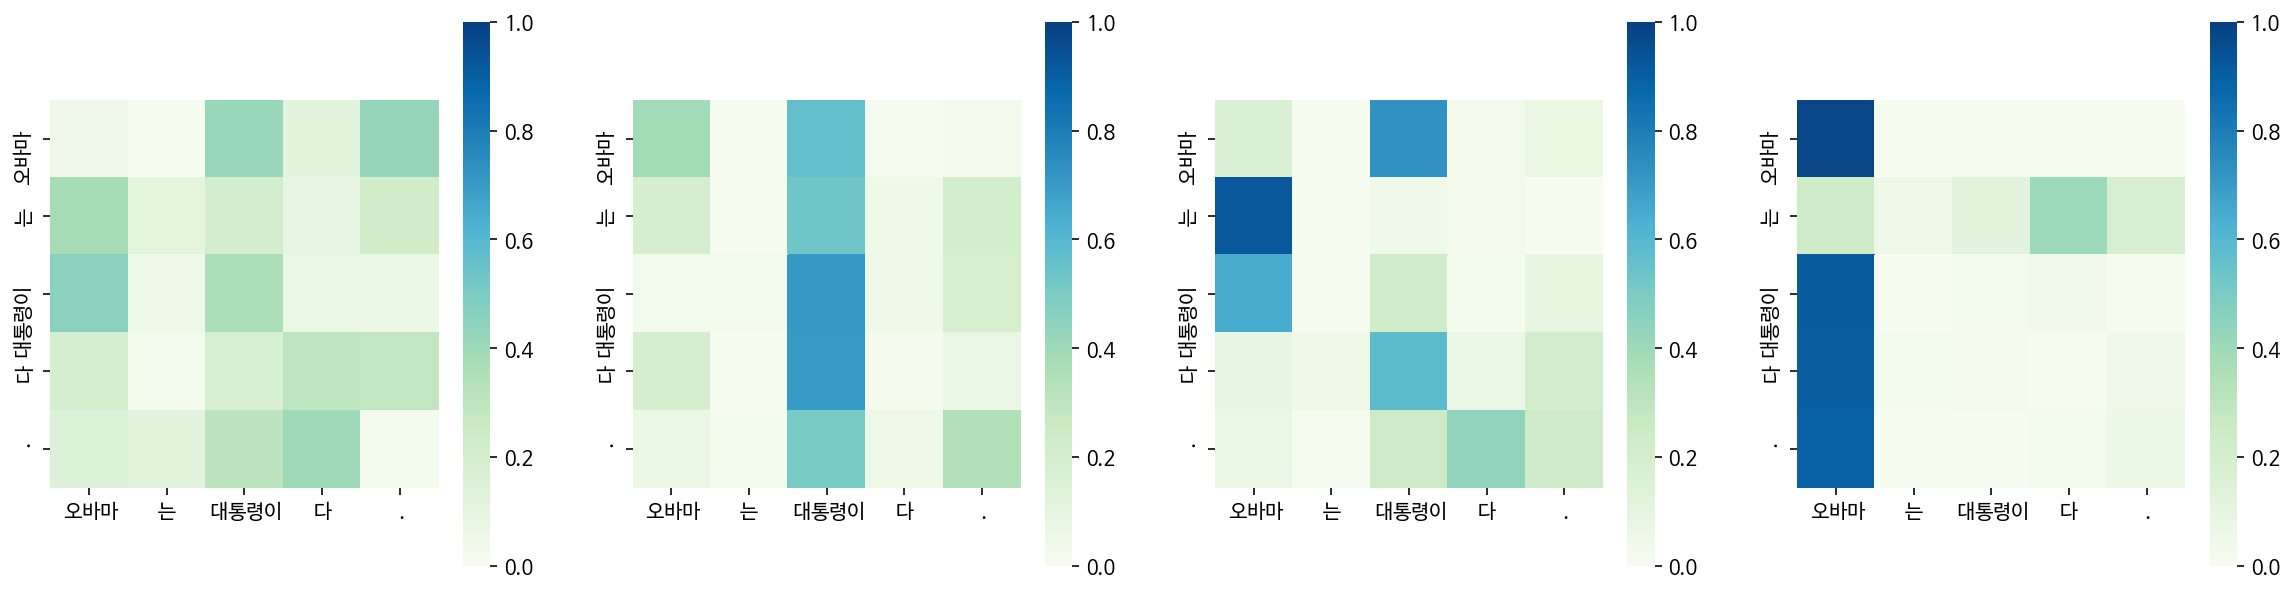

Encoder Layer 2


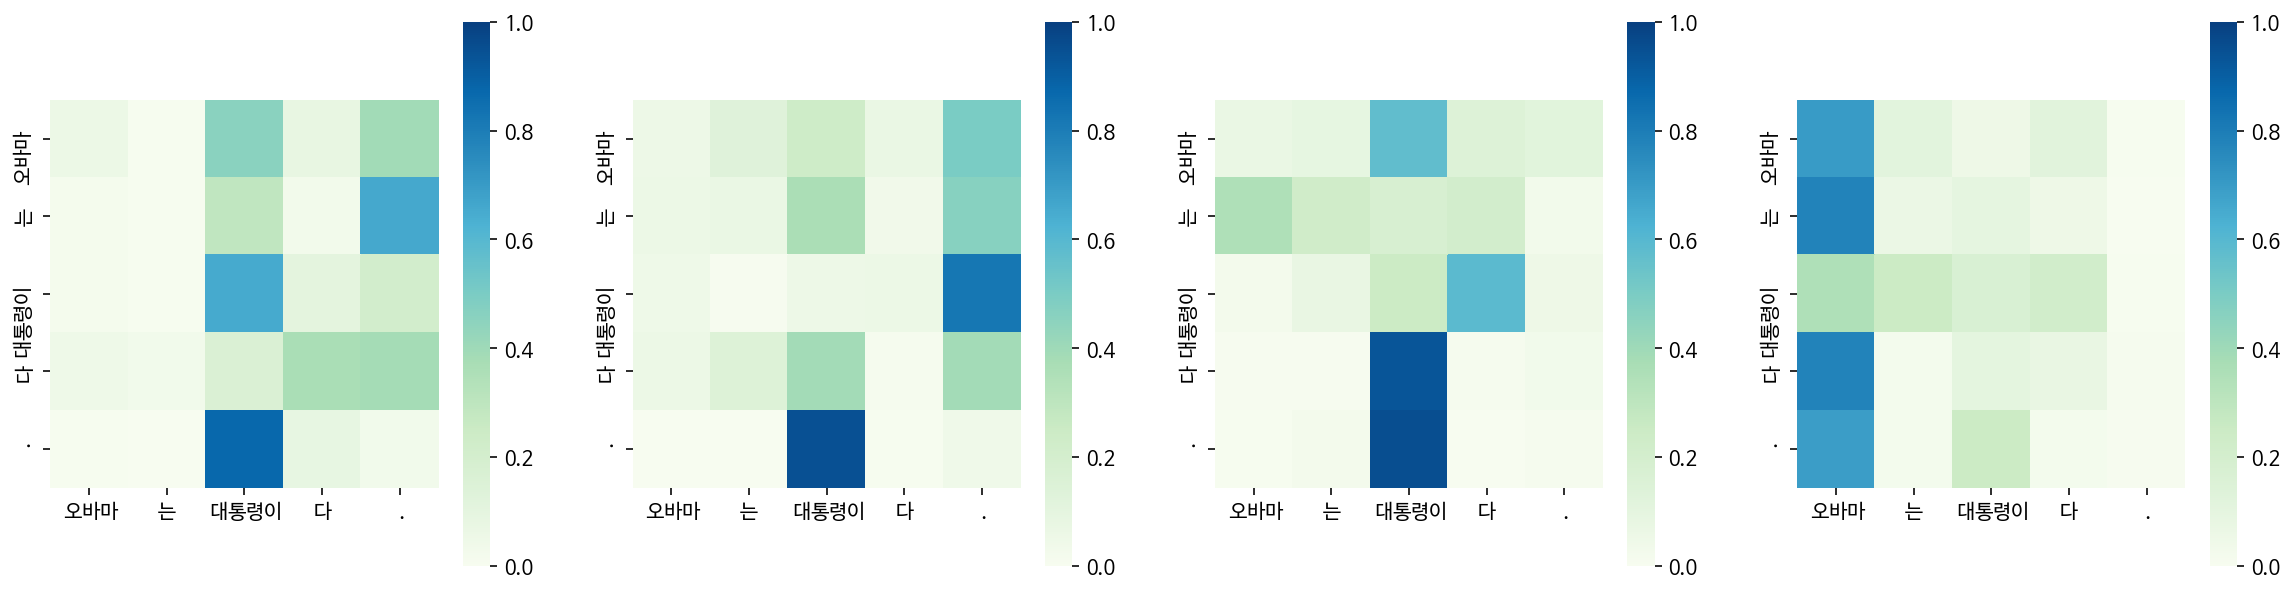

Decoder Self Layer 1


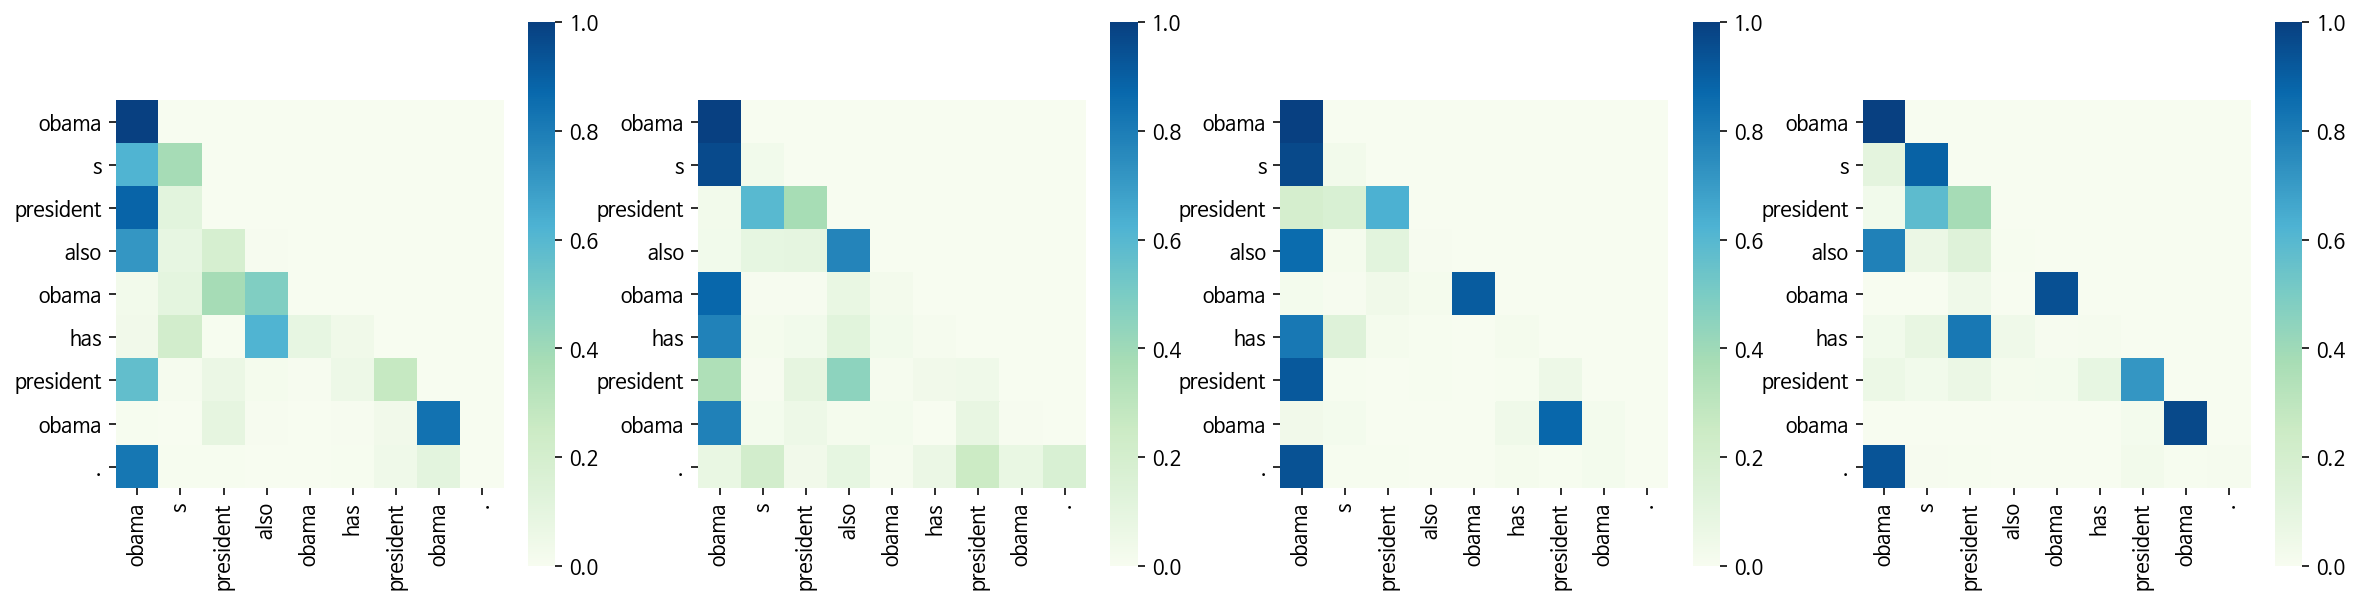

Decoder Src Layer 1


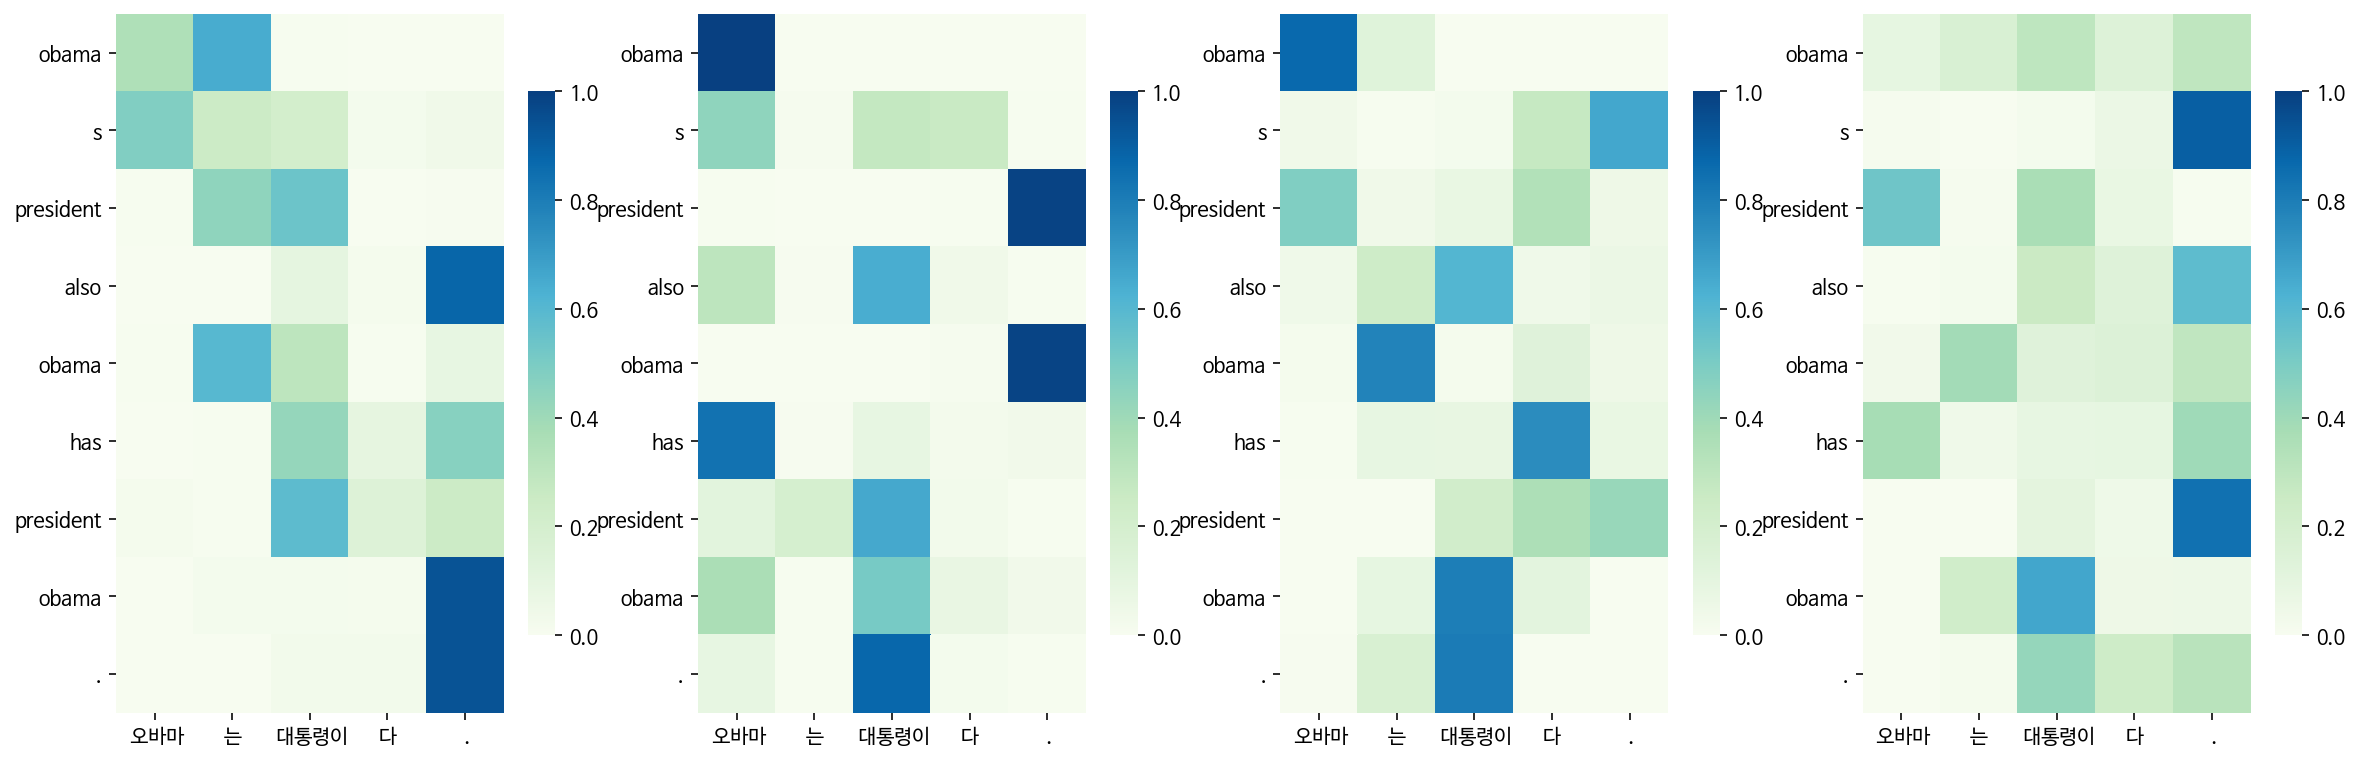

Decoder Self Layer 2


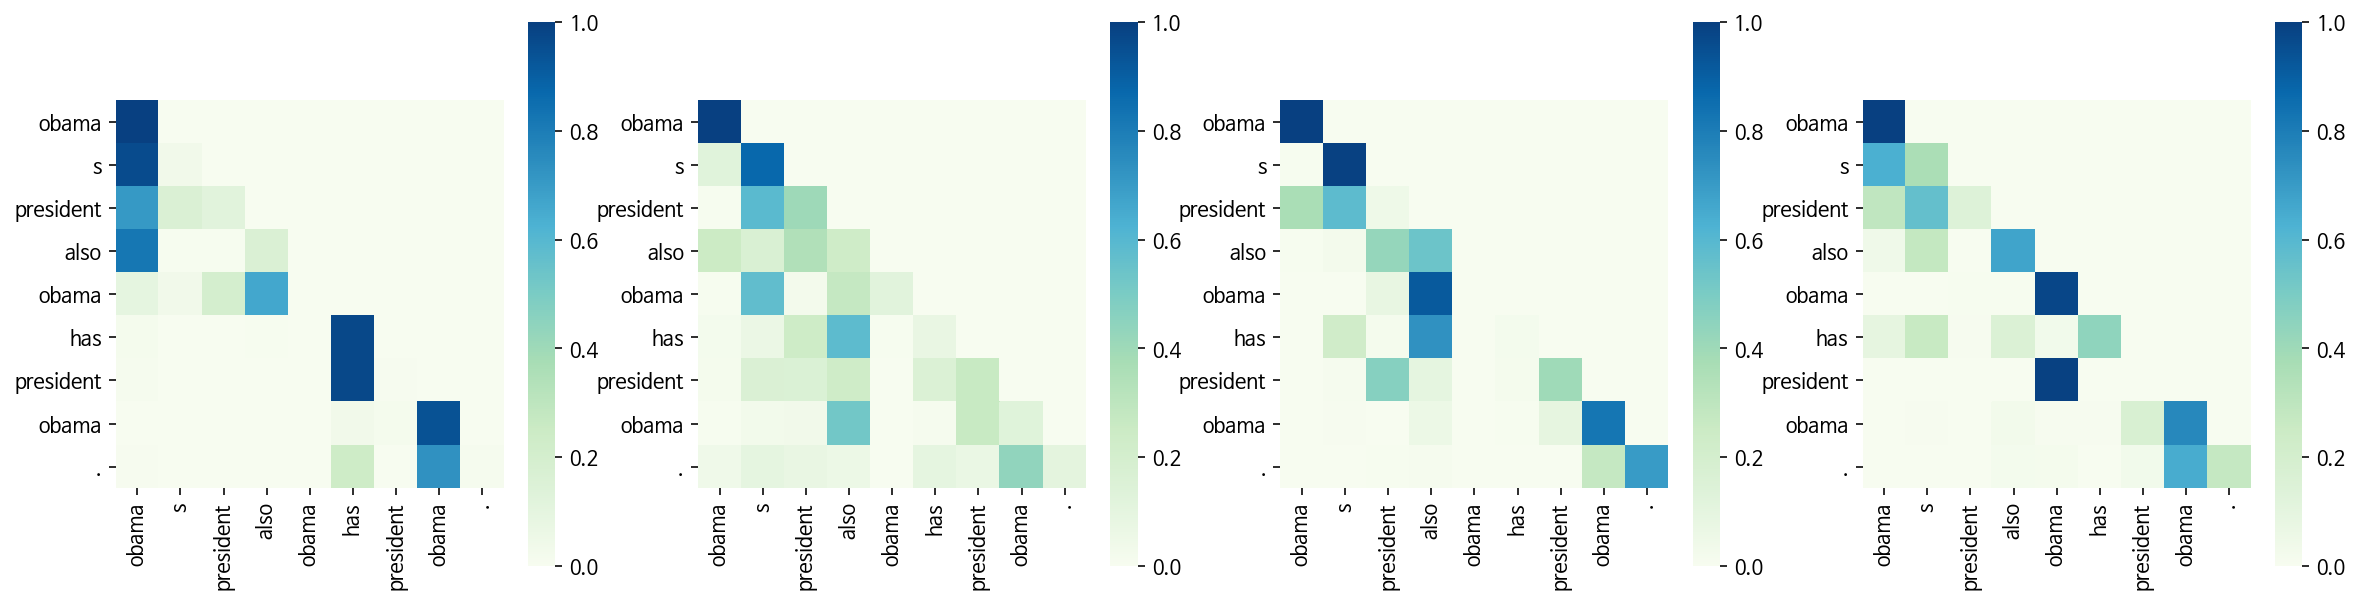

Decoder Src Layer 2


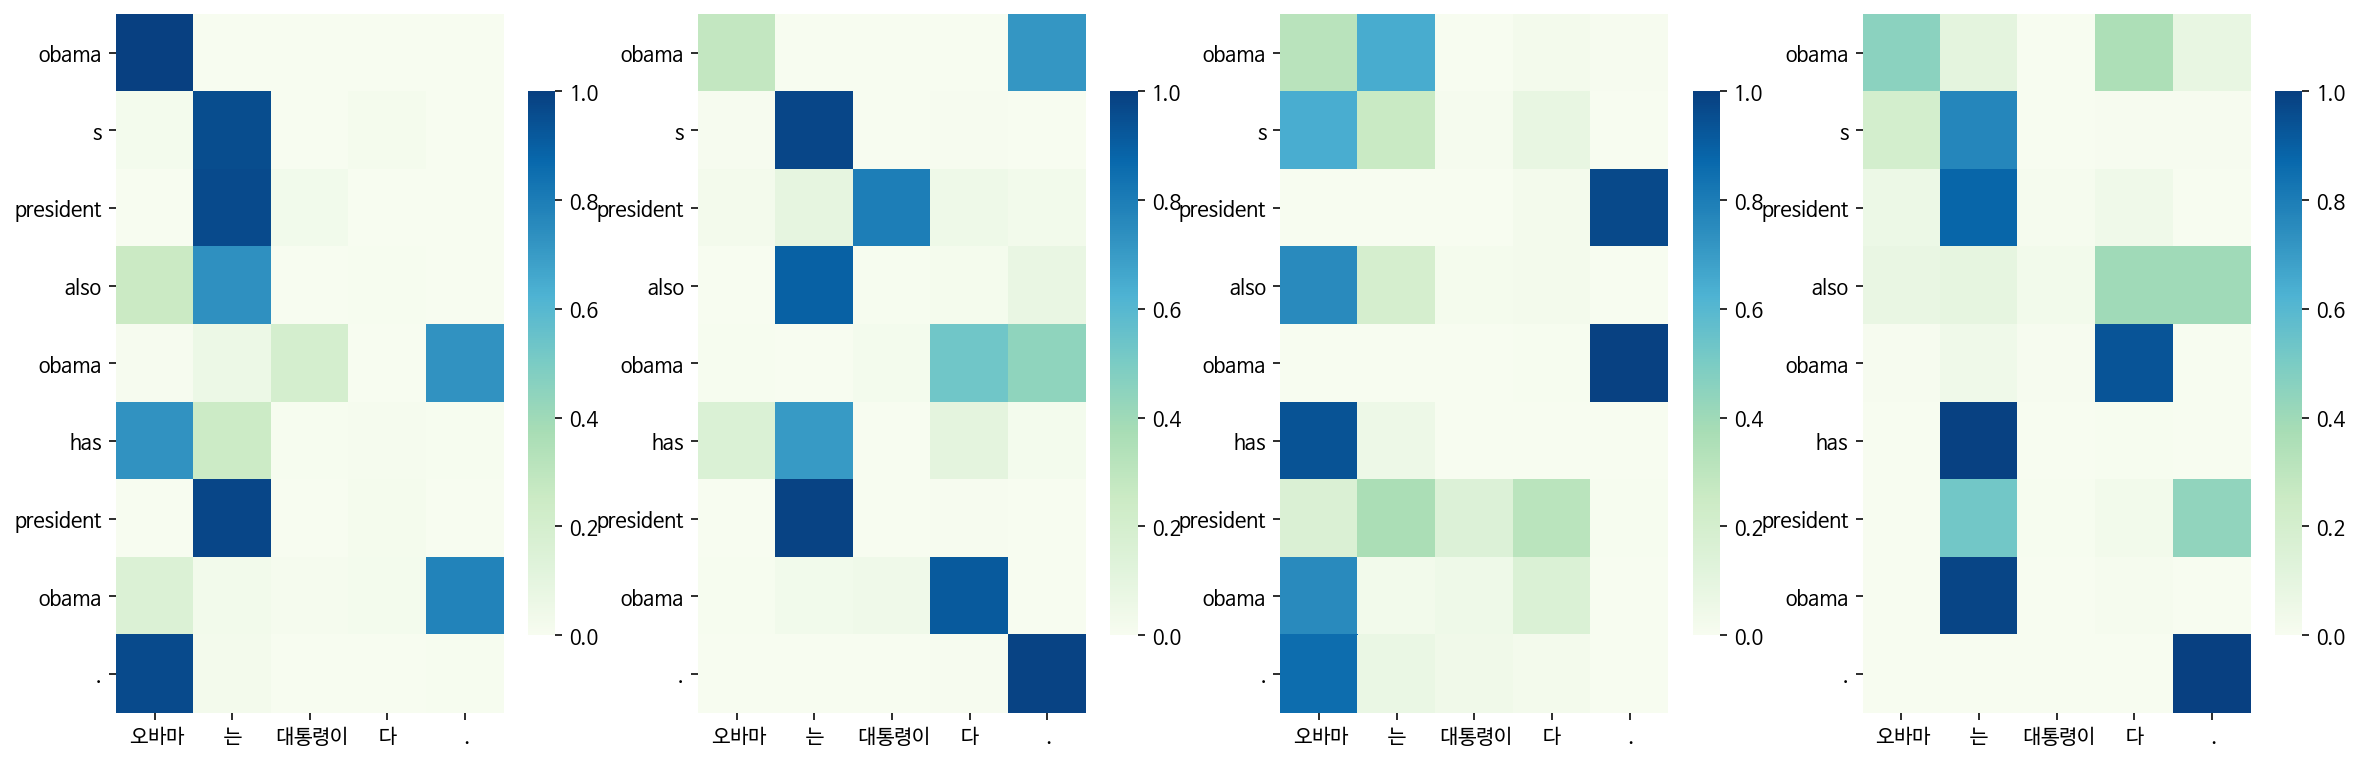

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is the water
🇰🇷 : 커피는 필요 없다.
🇺🇸 : that need for people or need for drinking coffee or
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the death toll of the people watched watch on saturday , were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 11]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is president obama in the president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is acid driven in the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee needs need for no need . coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed in the city of twelve people .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 12]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama to president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city s city cited van .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so that needed for people a drink .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 13]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama president obama is a president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the operation is for the water , though .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : gaz need or need to be needed .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 14]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is , .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the american was to go urban .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : for coffee is , for coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of seven people were killed only .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 15]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama president obama s president was the president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the cult is to fly over the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so need for so so so  need for help .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 16]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , barack obama is .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is urbanta  ⁇ 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so what need so need to be need .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven percent of seven people were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 17]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama president , obama won .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is urbanization .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so  need to be needed .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of seven people were killed , about percent of the dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 18]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama would make president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : conditions are handing over to the mainland .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so  need to take coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were acknowledged about a dozen dead and a minor injury .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 19]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receive the president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is over the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : need coffee need so need to do so .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were the dead daily soldiers and another reported now .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 20]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , obama is the president .
Encoder Layer 1


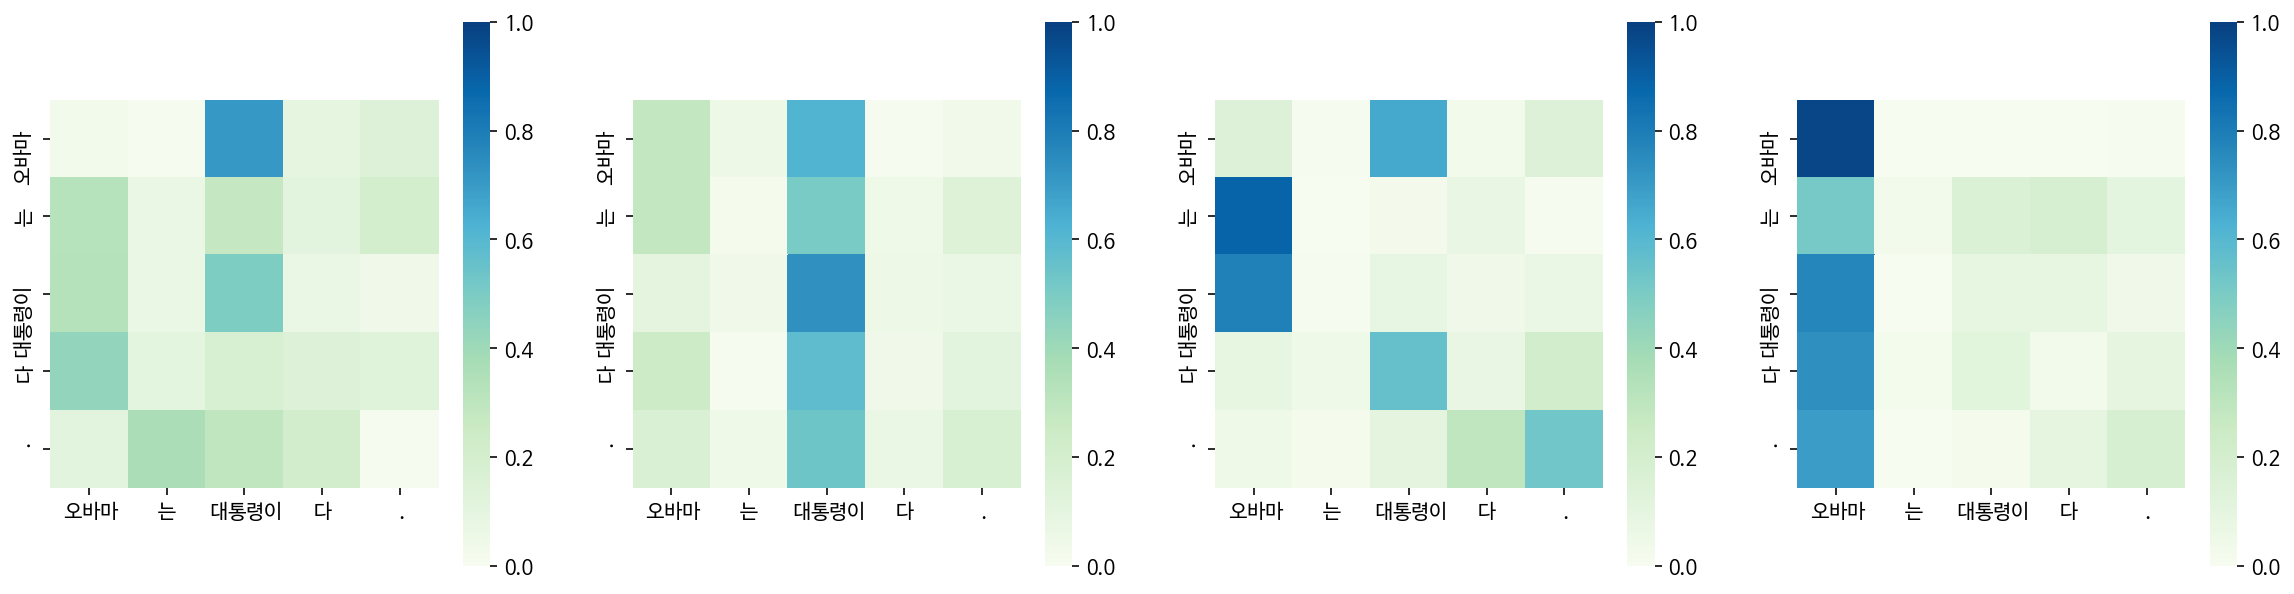

Encoder Layer 2


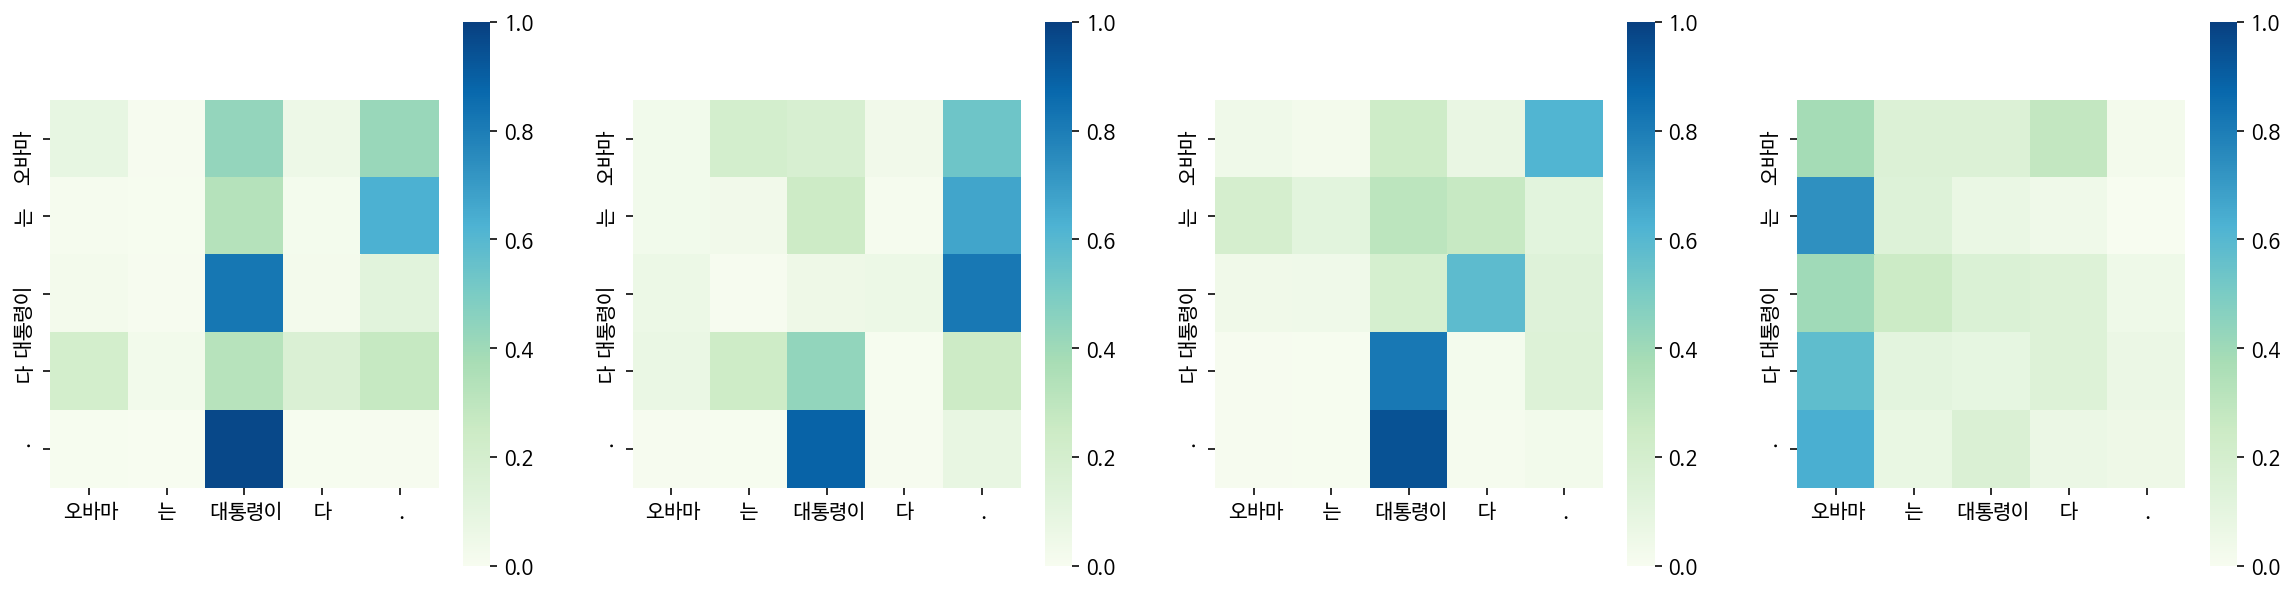

Decoder Self Layer 1


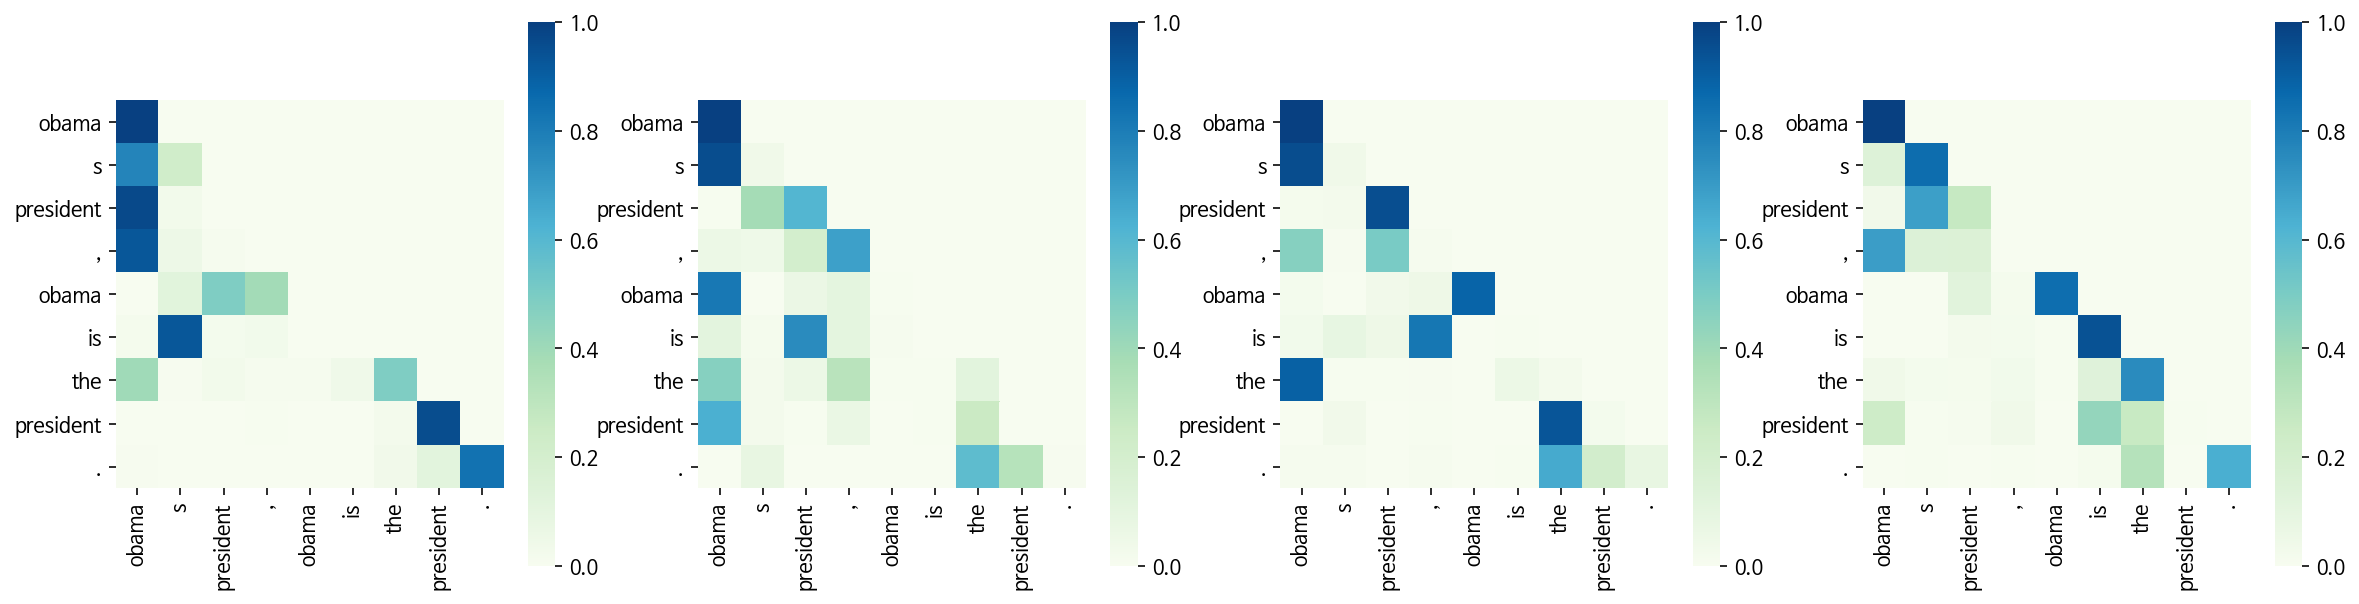

Decoder Src Layer 1


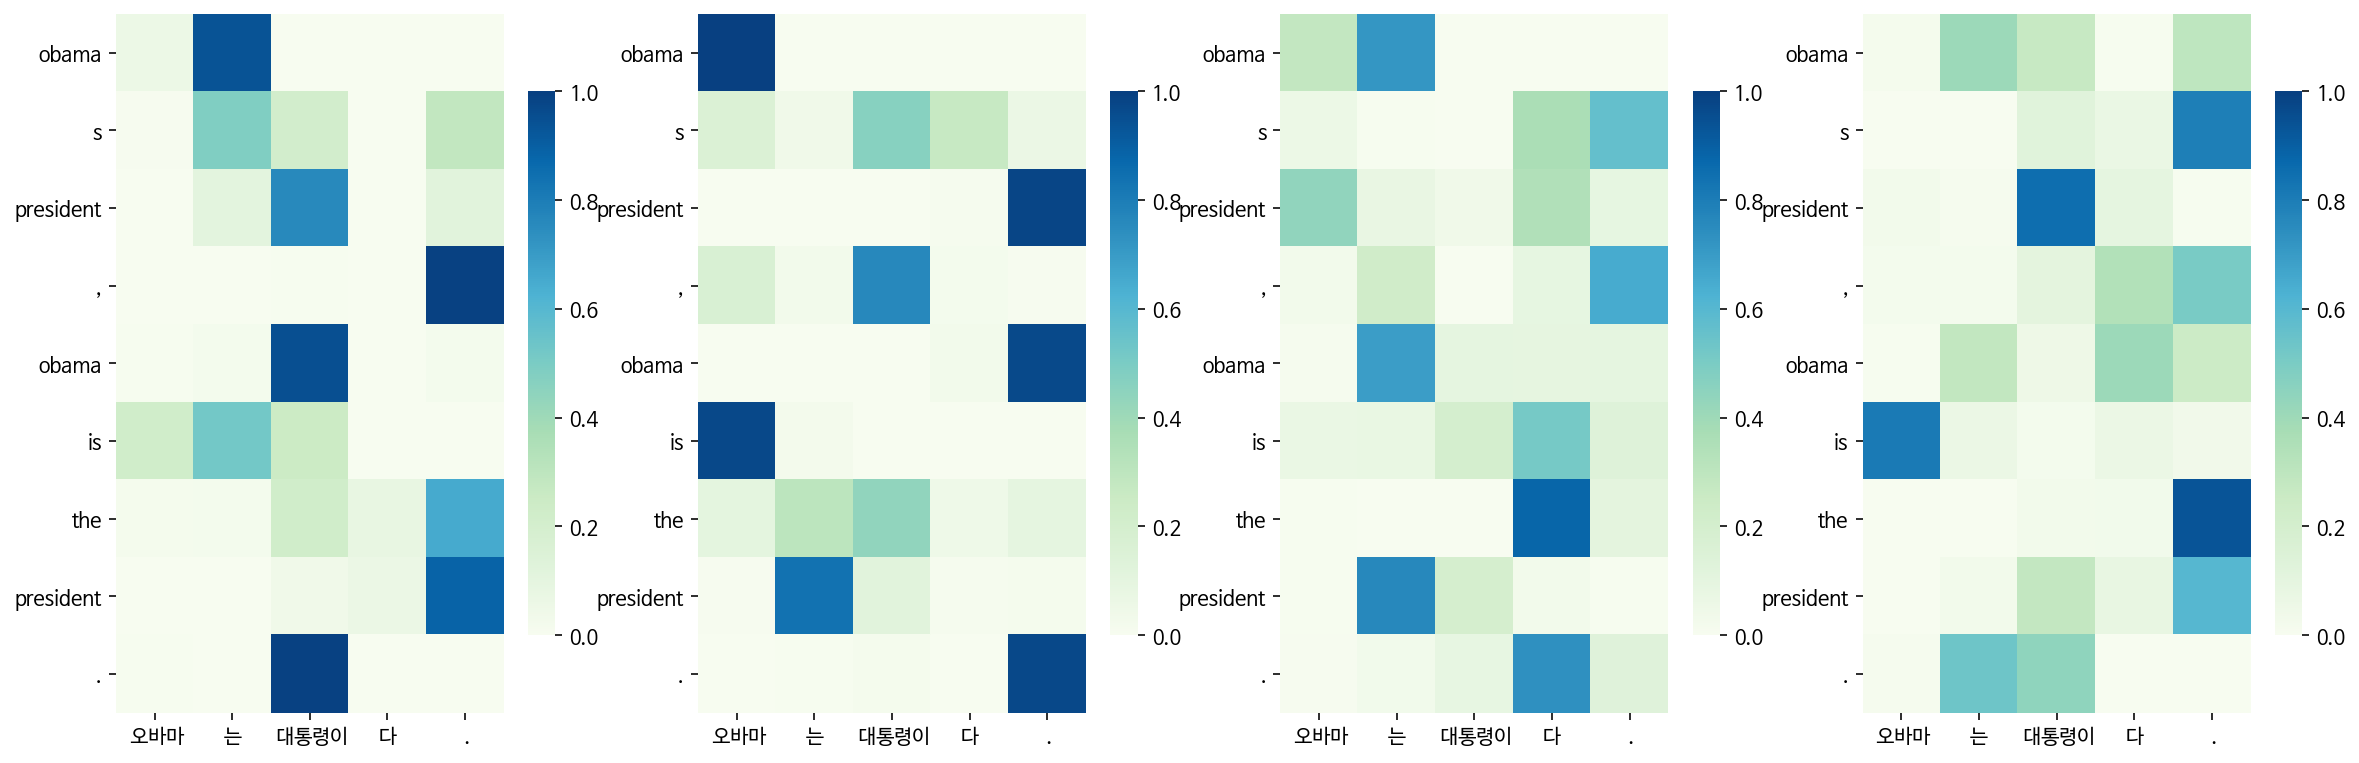

Decoder Self Layer 2


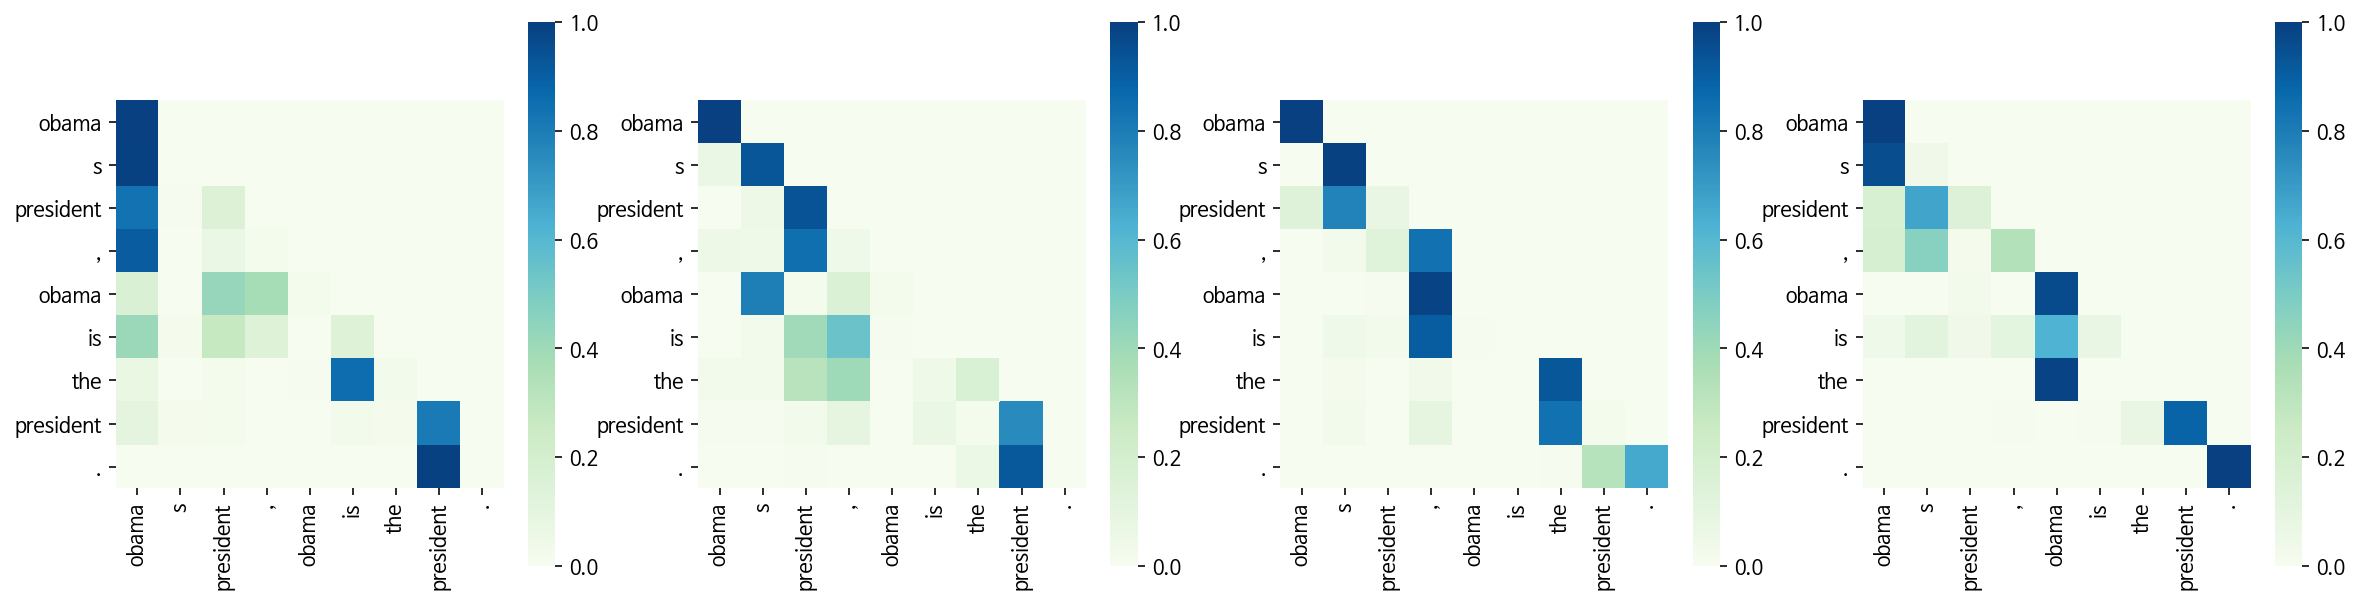

Decoder Src Layer 2


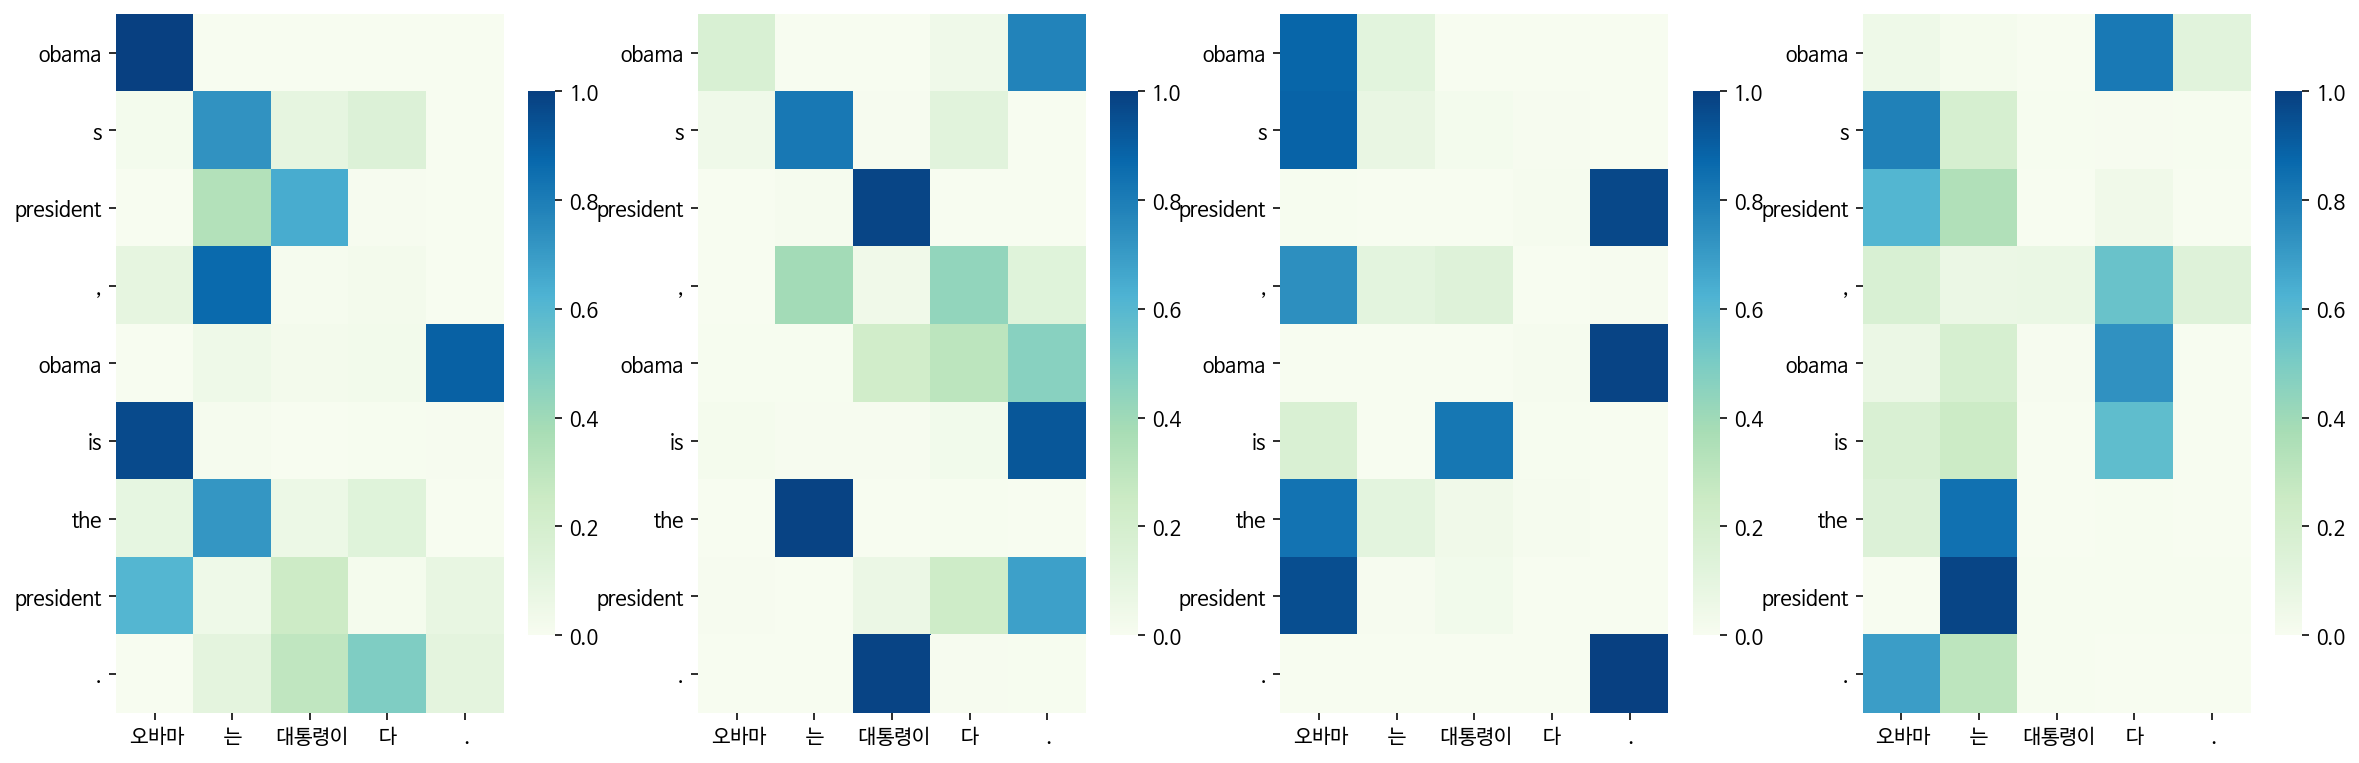

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is acid blanket .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take that need action coffee need for drink coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seventeen other members of the dead were wounded in the square of the brunt of the dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 21]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama would president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is fine .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so do need for coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven others were wounded in the track .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 22]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama was president obama by president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is inner city citruly cited .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is not needed to coffee coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven dead were hit with seven dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 23]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receive across the president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : he is acidson
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so far need has been coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of seven people were killed , the person was killed on monday .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 24]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama first receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : parts of the city to have aciden
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so  need to be coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven members of the two dead were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 25]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives around . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is fine quiet , he is seeing over the protest .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so need to take coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people of the dead were killed in .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 26]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama the president was president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is aciding .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so called need .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 27]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city of american cigarettes this is acid .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : need to take or need . percent .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people were killed , police said sunday .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 28]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama would do a president for obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is own fast moving over to the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : need to drink coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seventeen people were killed and six wounded .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 29]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama would make president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is acided .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : how she need to take about coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people watched people were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 30]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , obama said .
Encoder Layer 1


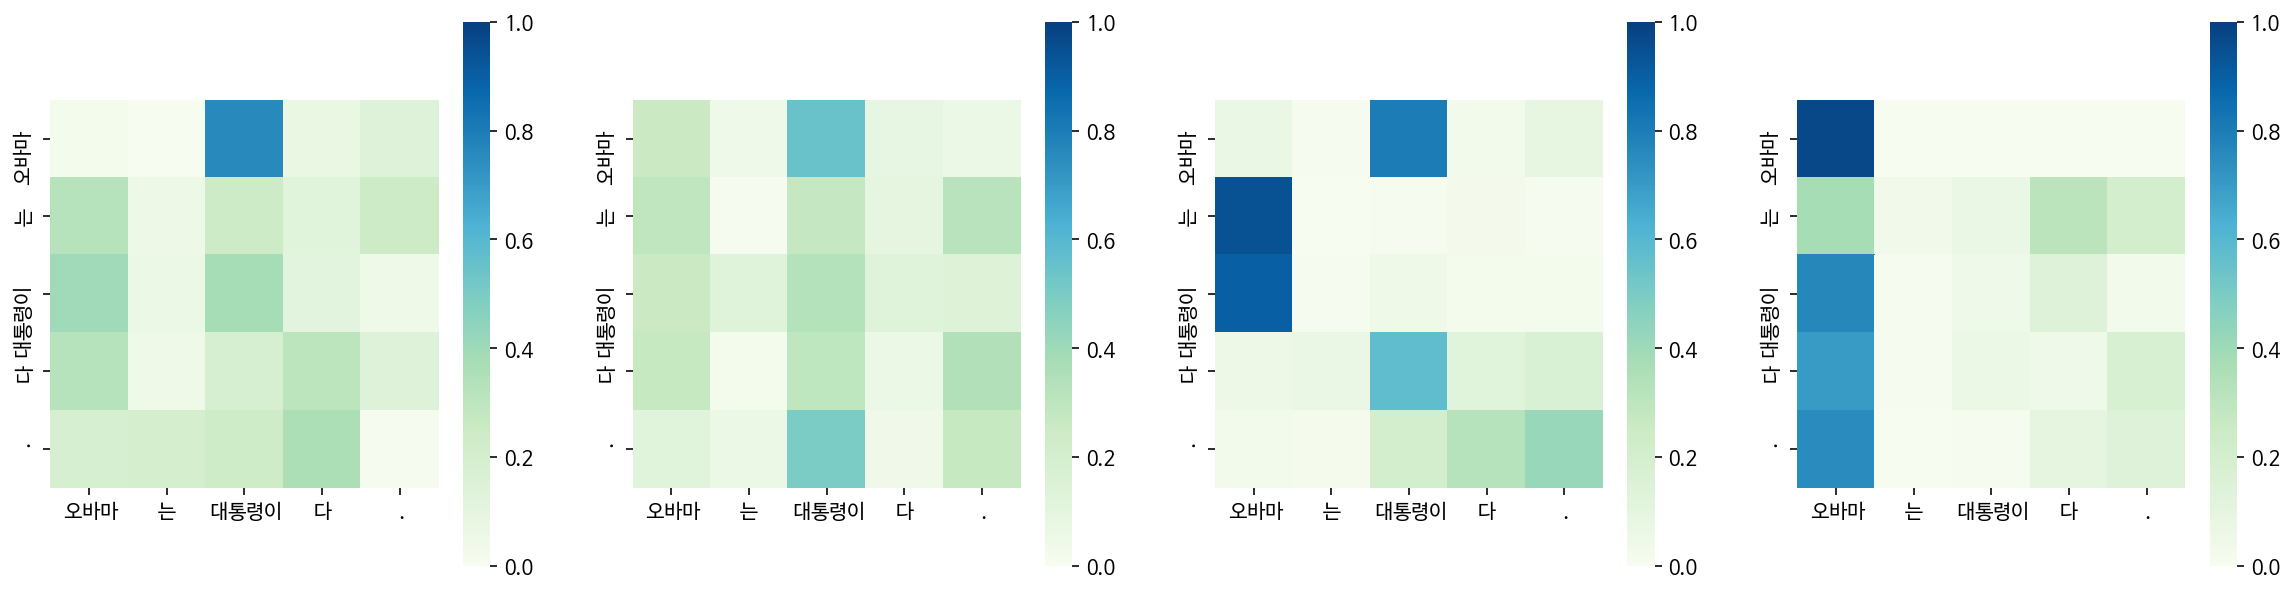

Encoder Layer 2


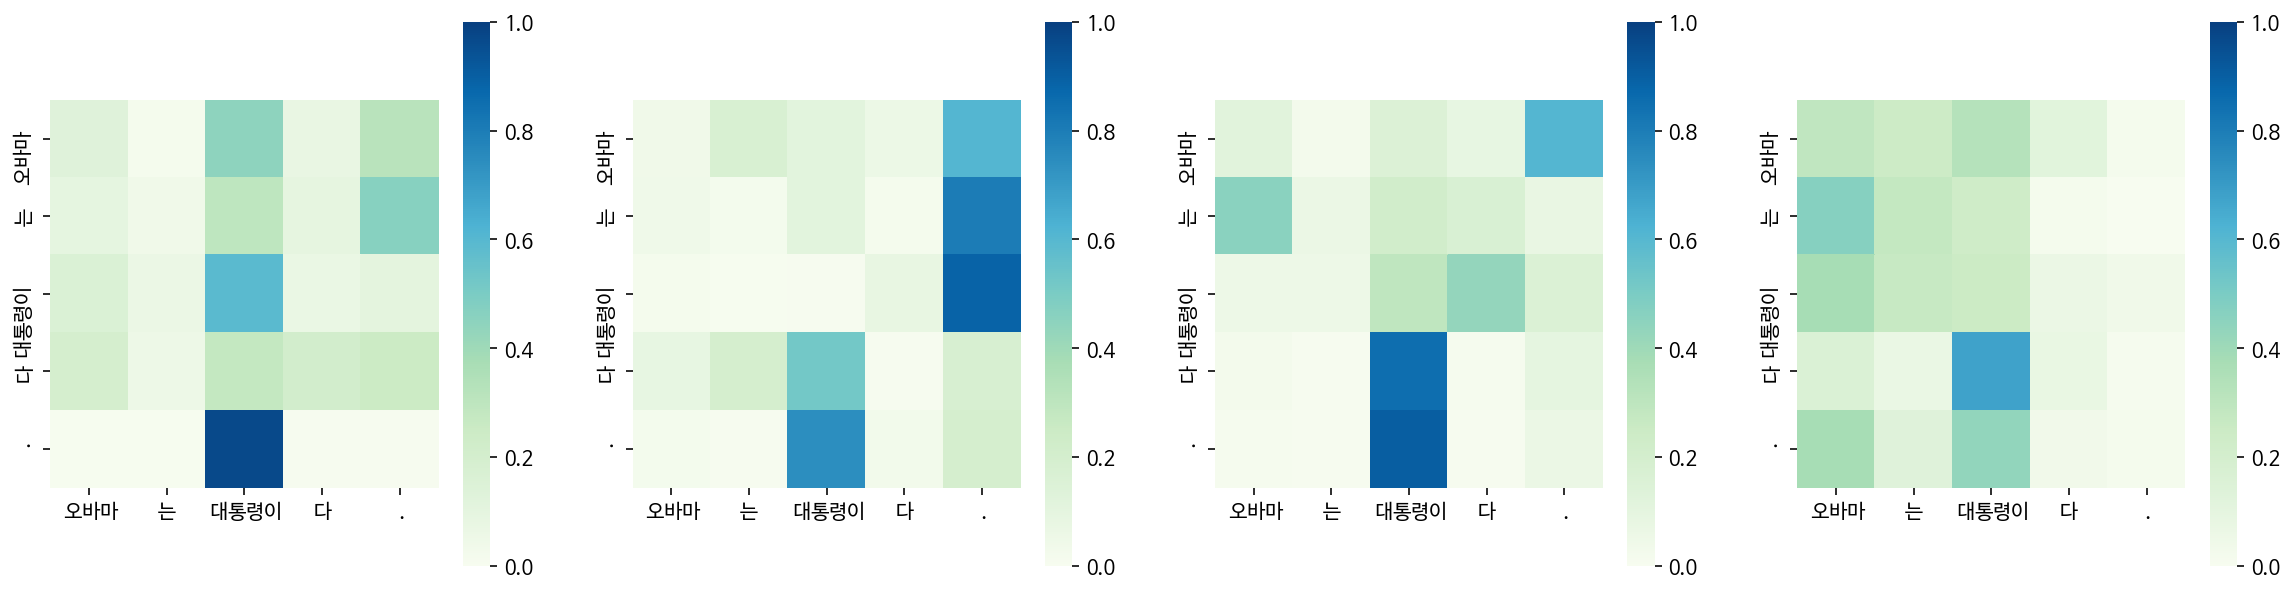

Decoder Self Layer 1


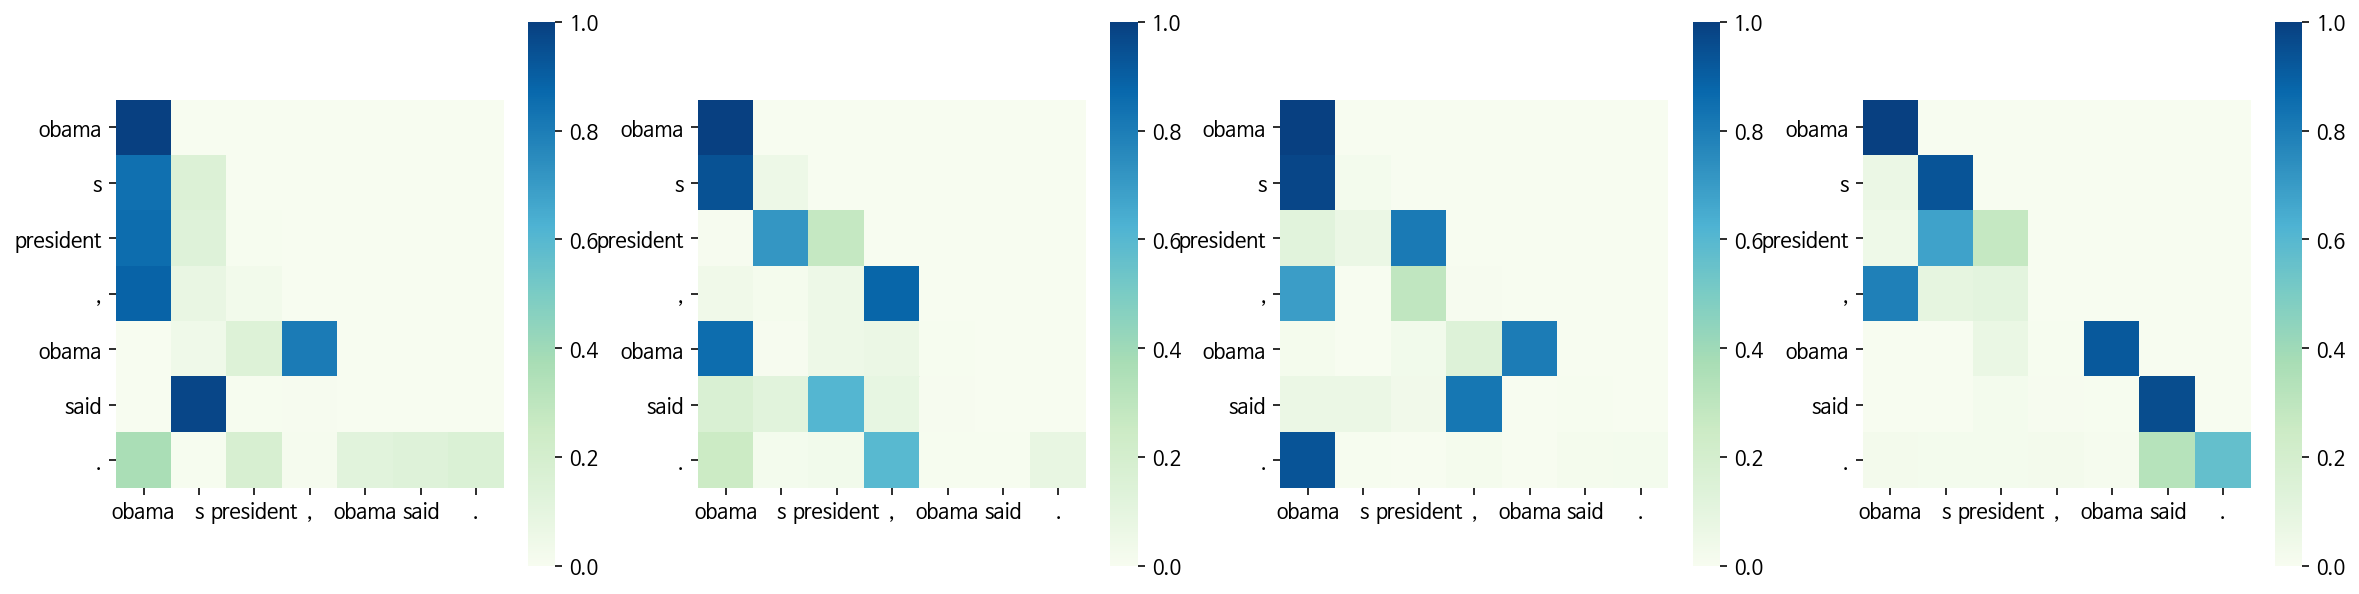

Decoder Src Layer 1


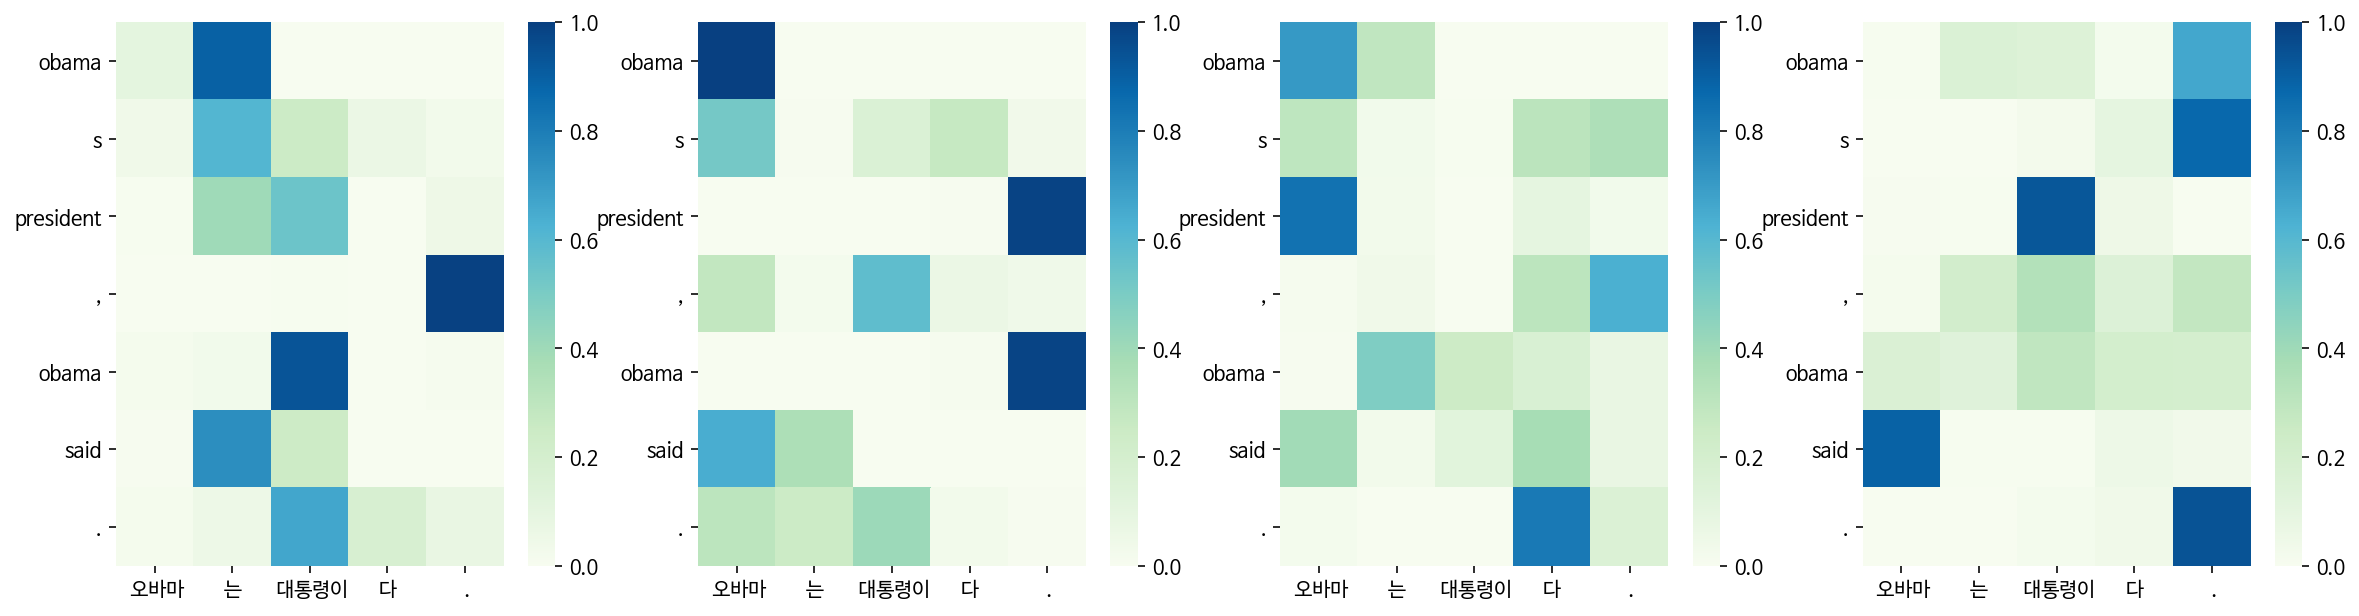

Decoder Self Layer 2


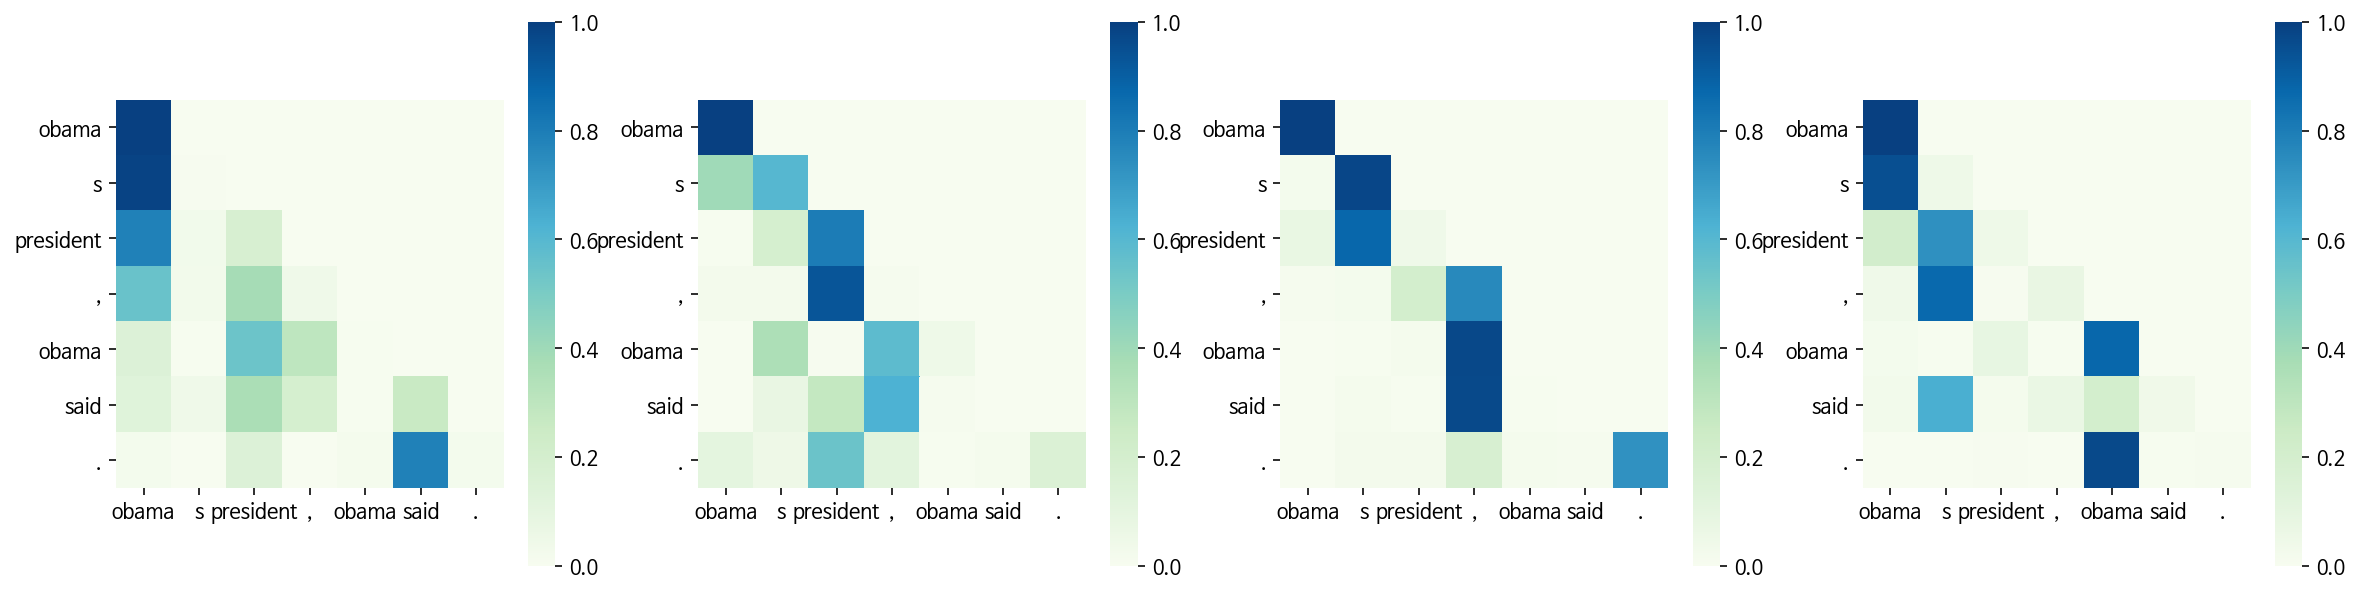

Decoder Src Layer 2


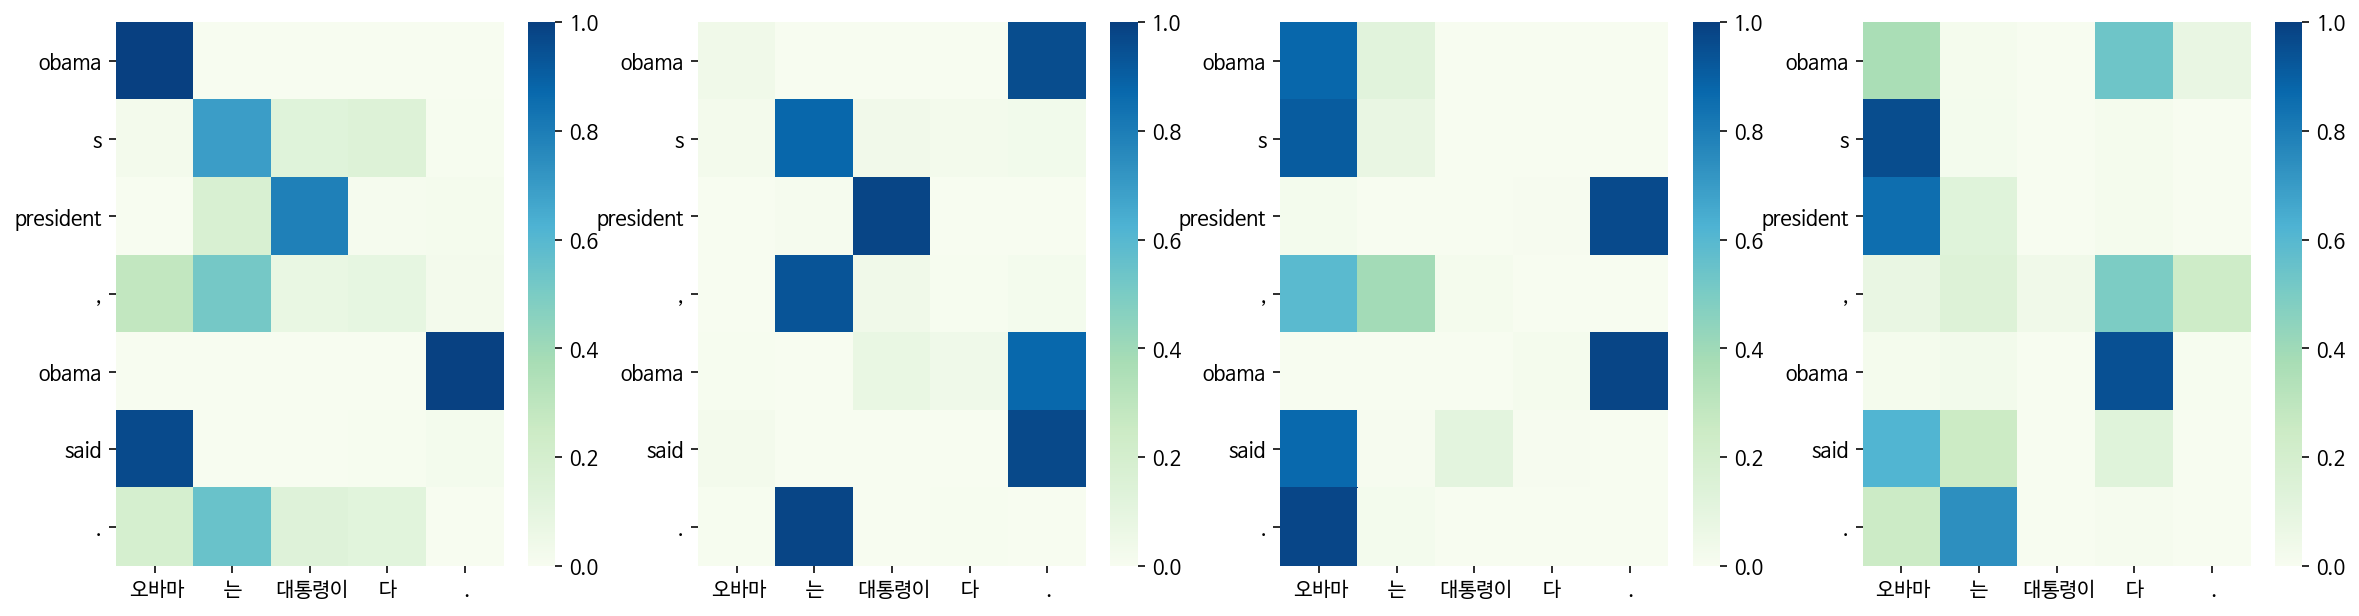

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : active cityism cities
🇰🇷 : 커피는 필요 없다.
🇺🇸 : need to vary or she need about coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seventeen people watched the dead were still missing .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 31]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : do not be caught to america s urban van .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so that needed coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seventeen percent of the fatality toll in iraq was scheduled to separate the still rise .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 32]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama would make president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : parts of the city subsequent acids in urban city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so called need for coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people watched people were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 33]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , obama says obama has a president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cities for their drink .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so called coffee need for people need to do need .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seven person deaths were among seven pastors .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 34]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama would president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cited the city of water .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so because for coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people were killed in the dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 35]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cities acid moved to .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so called for those need to drink .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seventeen people were killed and the dead were among the dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 36]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is good for about urban .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so that needed  need to be needed .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seven dead were killed in the dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 37]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives a president . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : while the city is acid good .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : need to do need coffee need not need coffee need .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven more than people were killed and a half dozens were later .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 38]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : while watch for the city is acidic , the city s health .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so called for coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 39]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives the president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : while the city is acided in the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : how czech adventurer need to need to take coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the dead were wounded .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 40]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
Encoder Layer 1


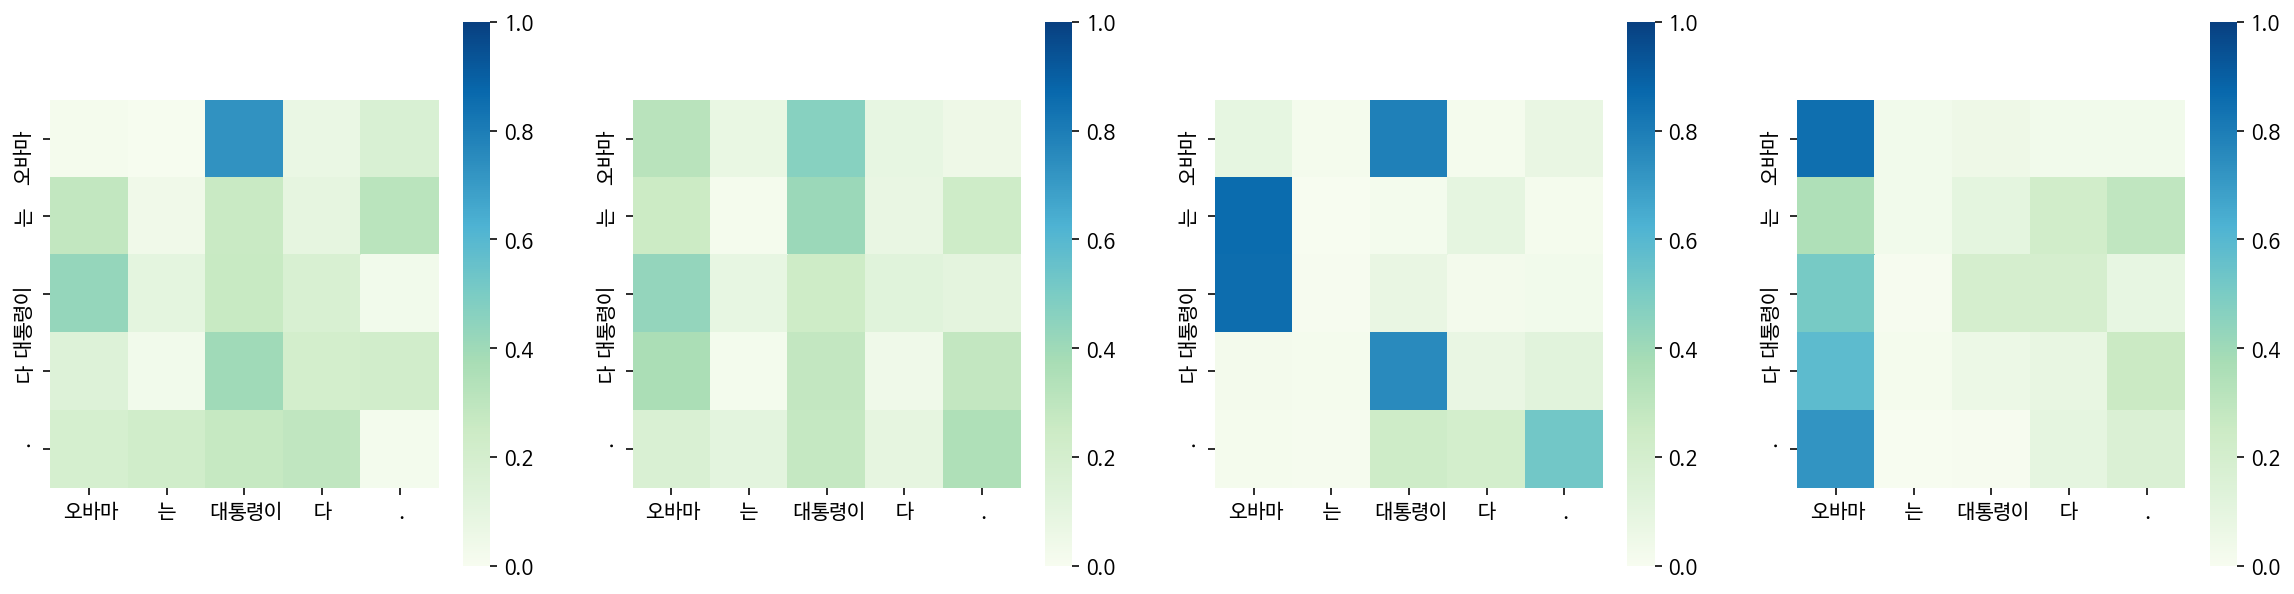

Encoder Layer 2


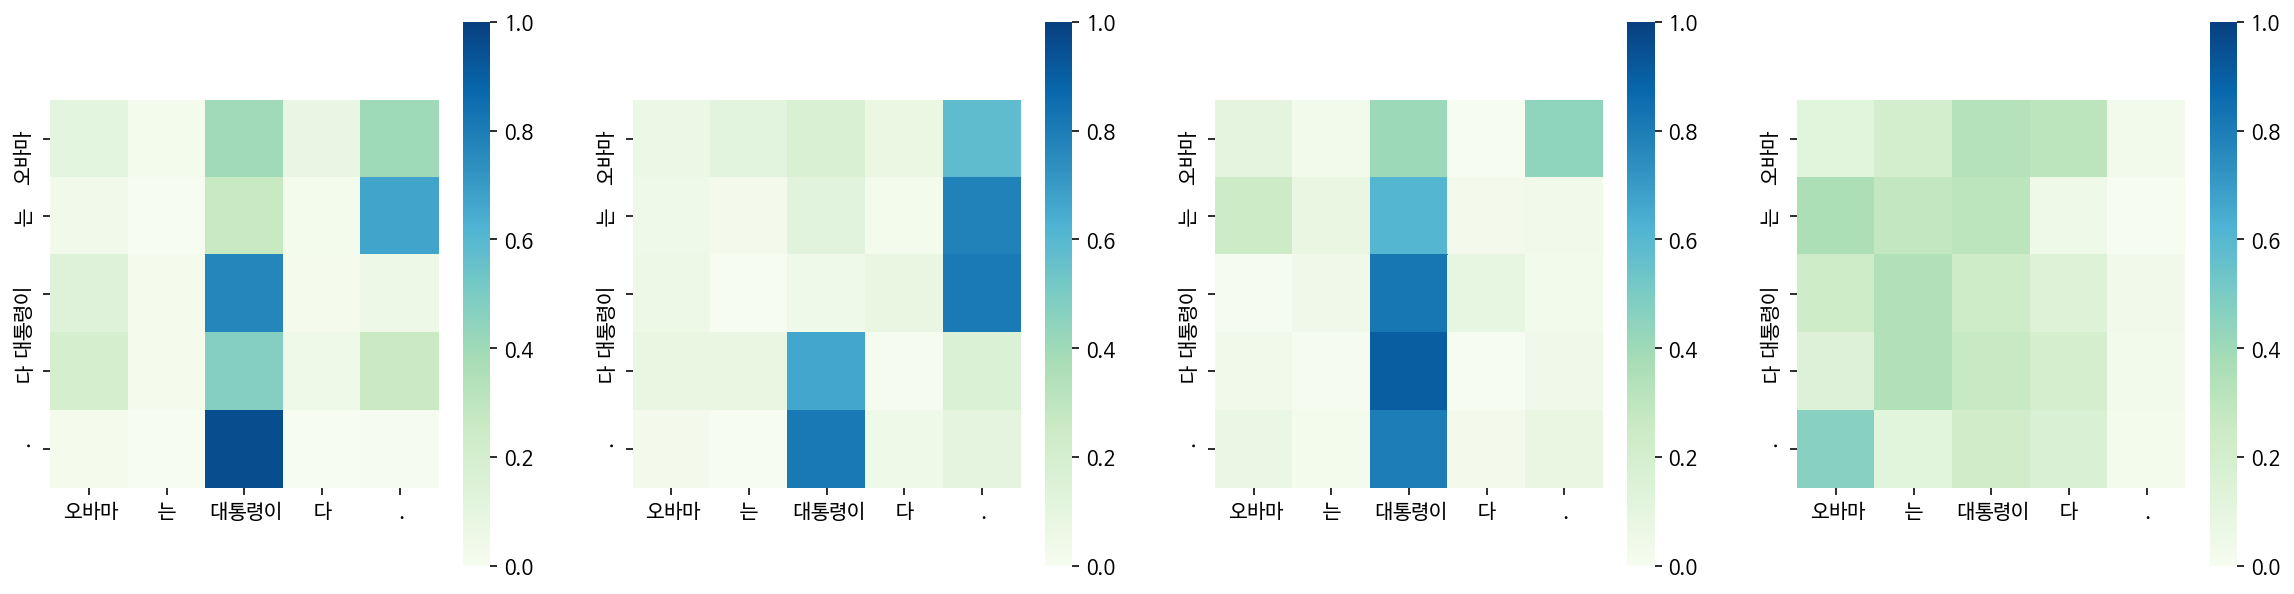

Decoder Self Layer 1


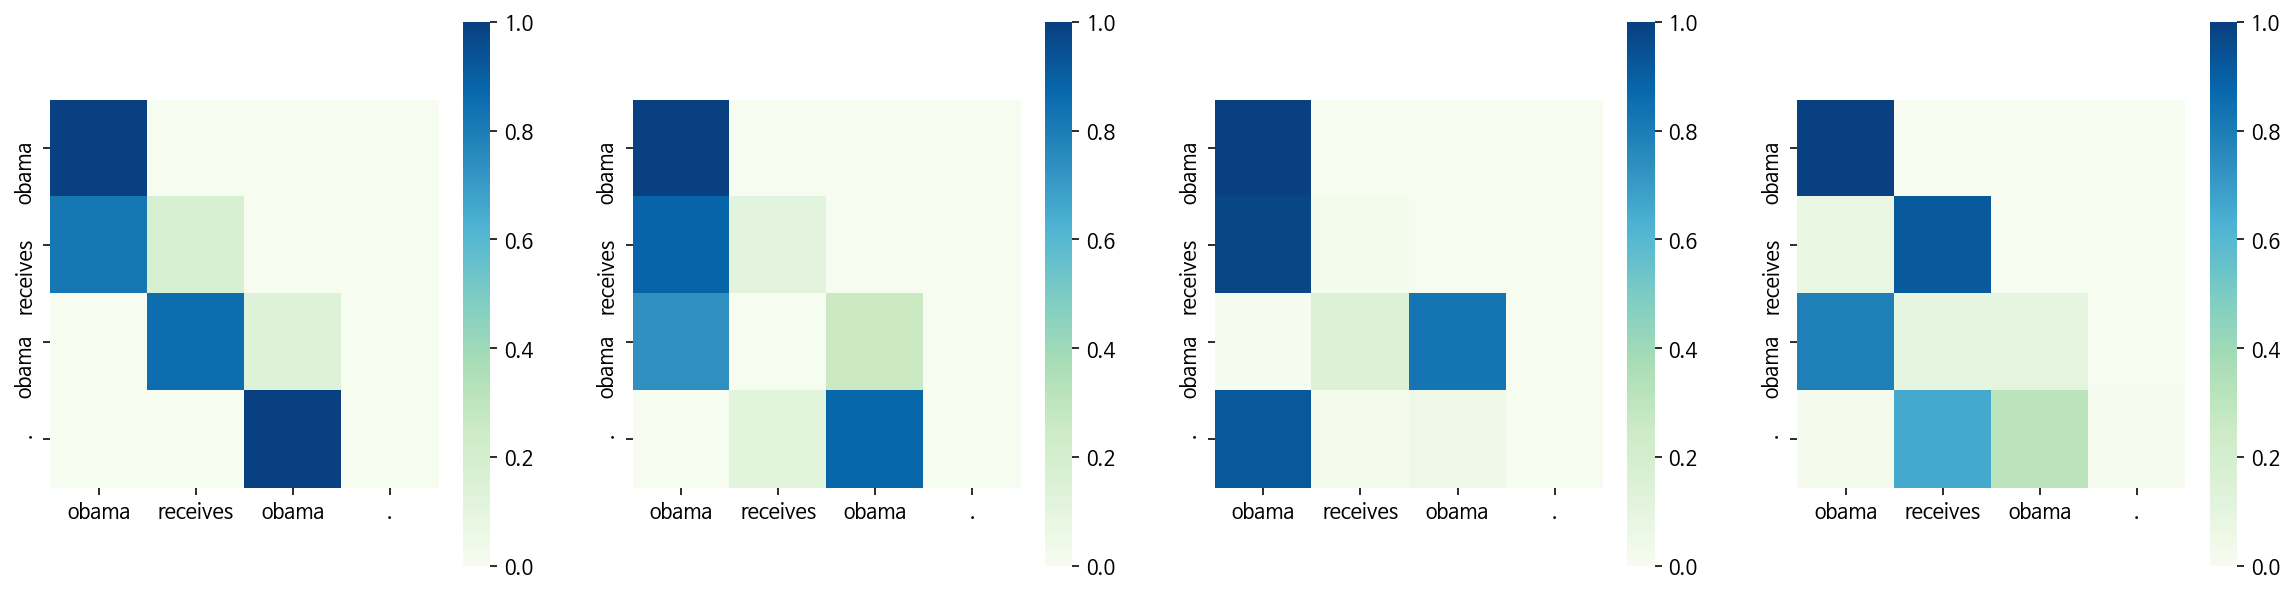

Decoder Src Layer 1


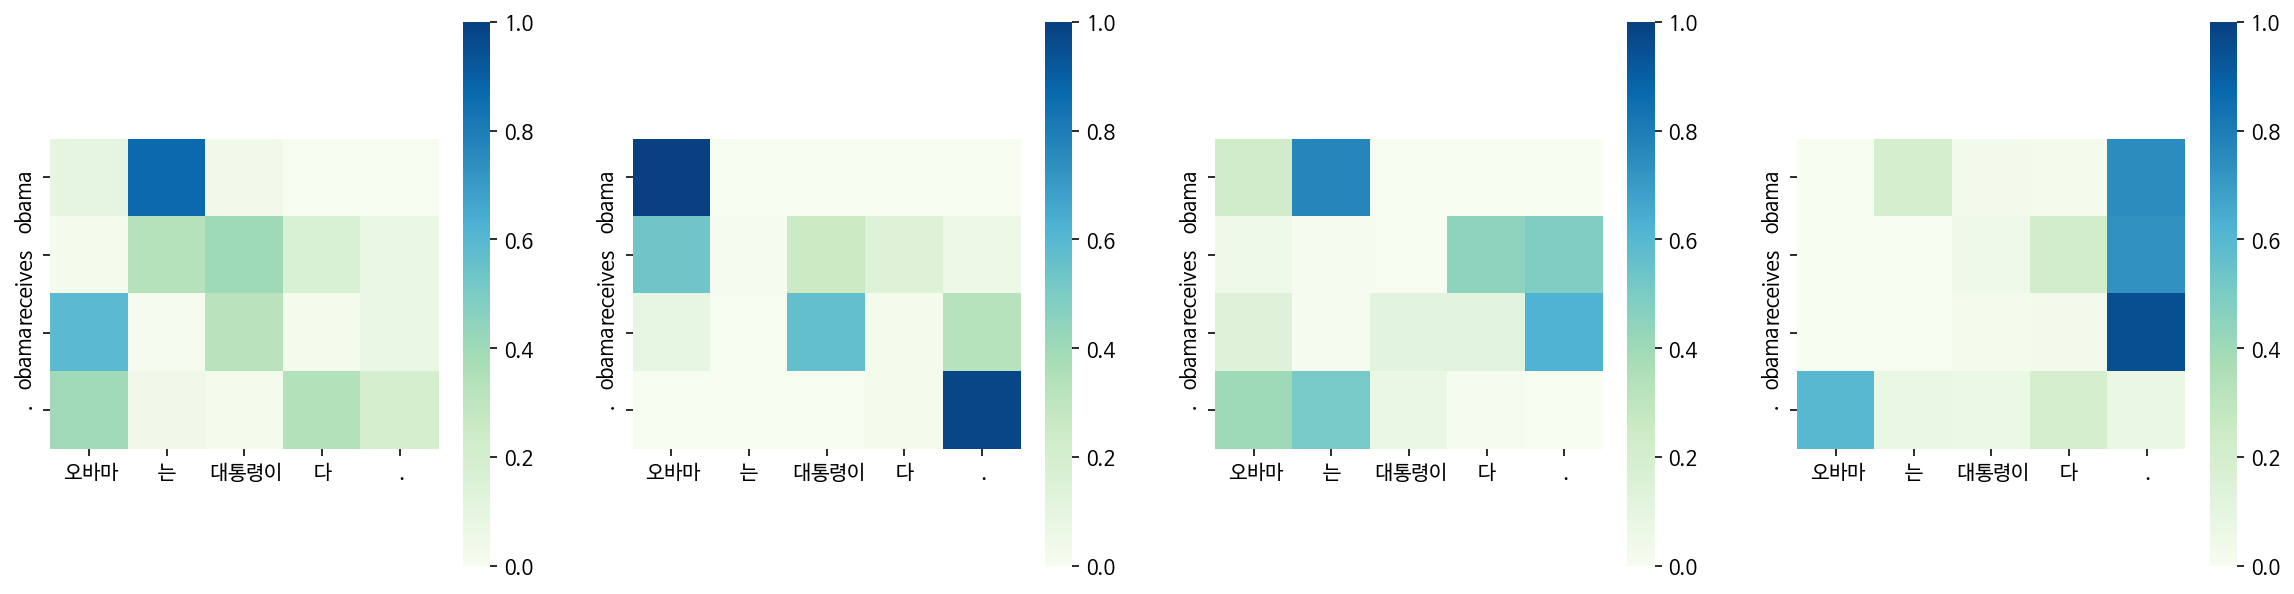

Decoder Self Layer 2


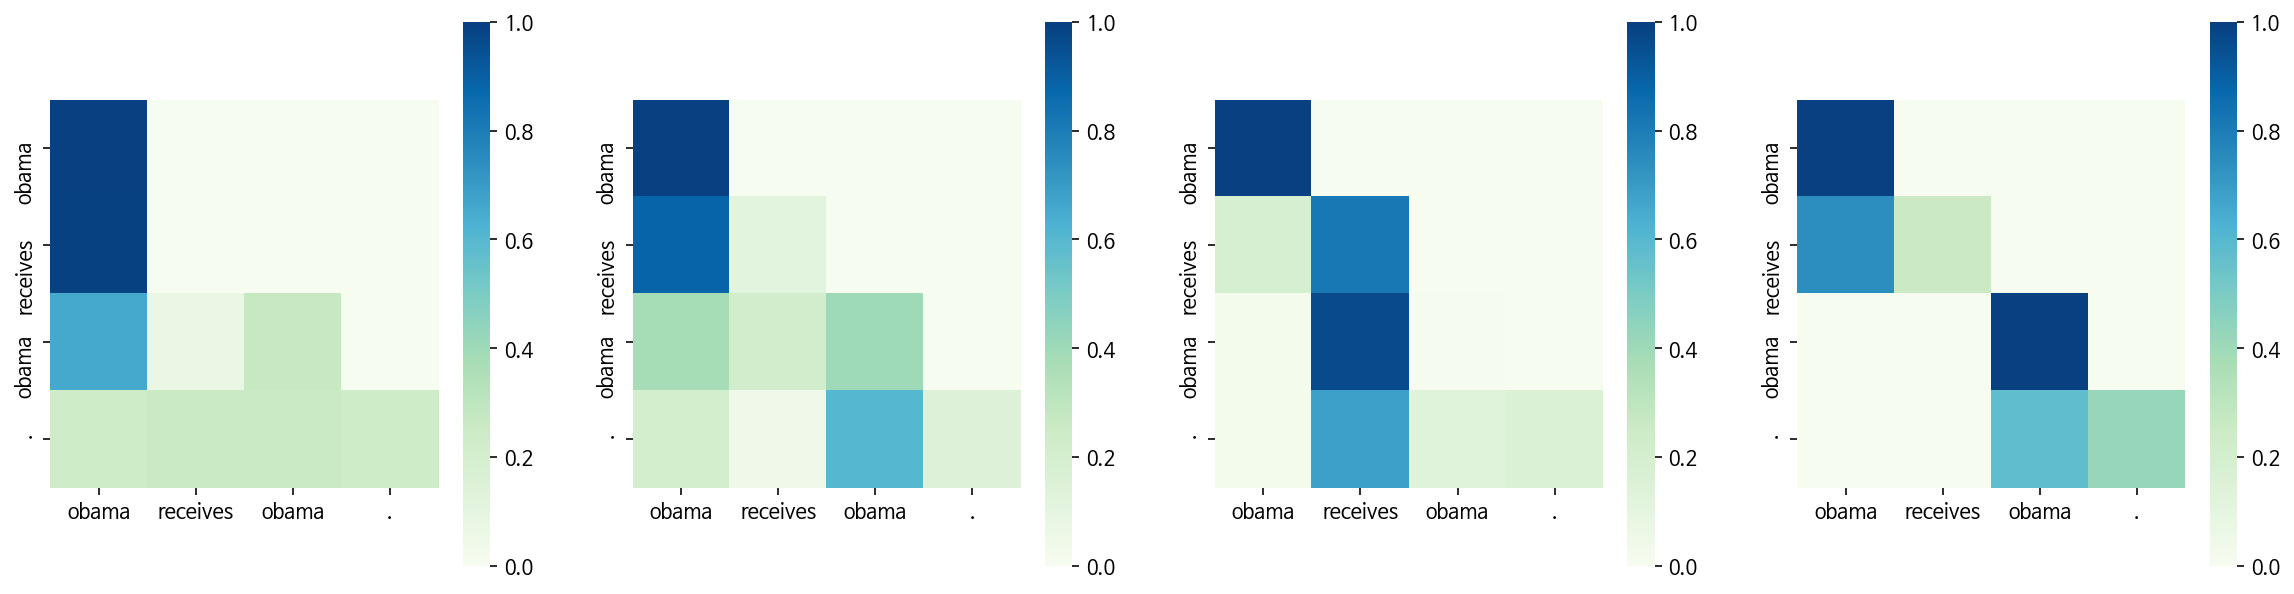

Decoder Src Layer 2


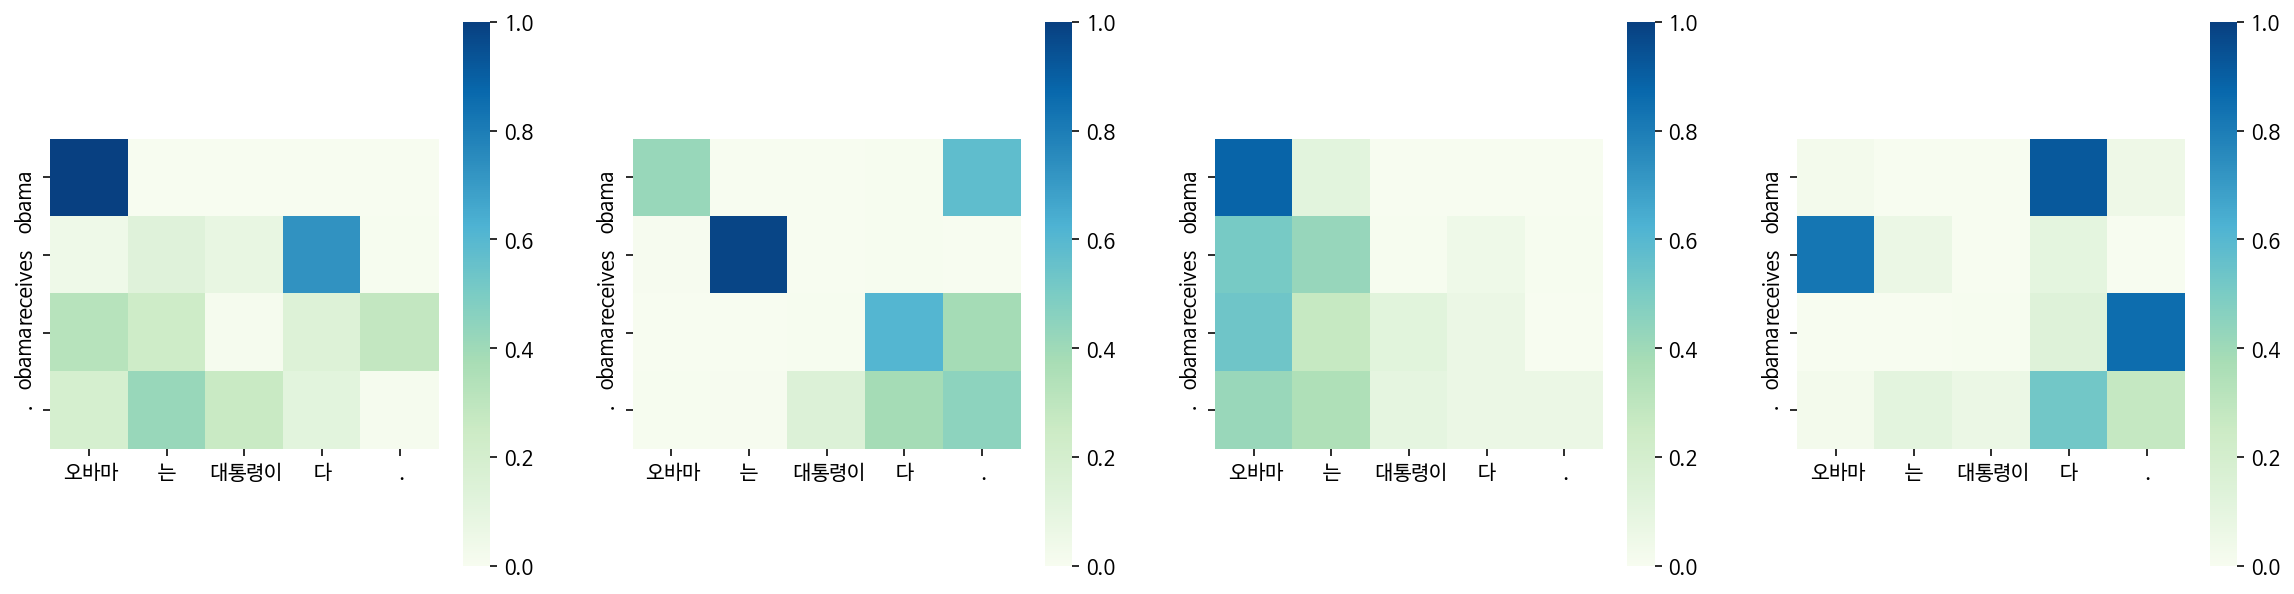

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : while the city is for about the city to become .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : need to be needed to need coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , the dead daily toll on separates .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 41]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives a . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : while the city is part of the city each city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : none need for coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed in the square two dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 42]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives president obama s president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : while the city is acid
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so  need to fend off needs
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people took a seven dead people sunday .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 43]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , obama say .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : while the city is acid on .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so take that would need action .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people of iraq were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 44]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : while the city is acid on .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so called for coffee a coffee need .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seventeen people were then killed six minors , the ministry of national unions was assigned to the army of nine nationals .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 45]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : while the city is part of a acid
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so percent said coffee need , she need to do so .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , the dead were later captured .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 46]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama s president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : while the city is part of a city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so , she needed to take coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were seven dead were reported dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 47]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : while watching the city for some places
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so she needed coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were seven dead were wounded in the mall .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 48]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives a kind of president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : it is subsequently to be citizens .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is that need for coffee coffee coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seventeen personnel were among the dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 49]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : conditions
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee did take a coffee or need to take a coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , the daily toll was .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 50]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
Encoder Layer 1


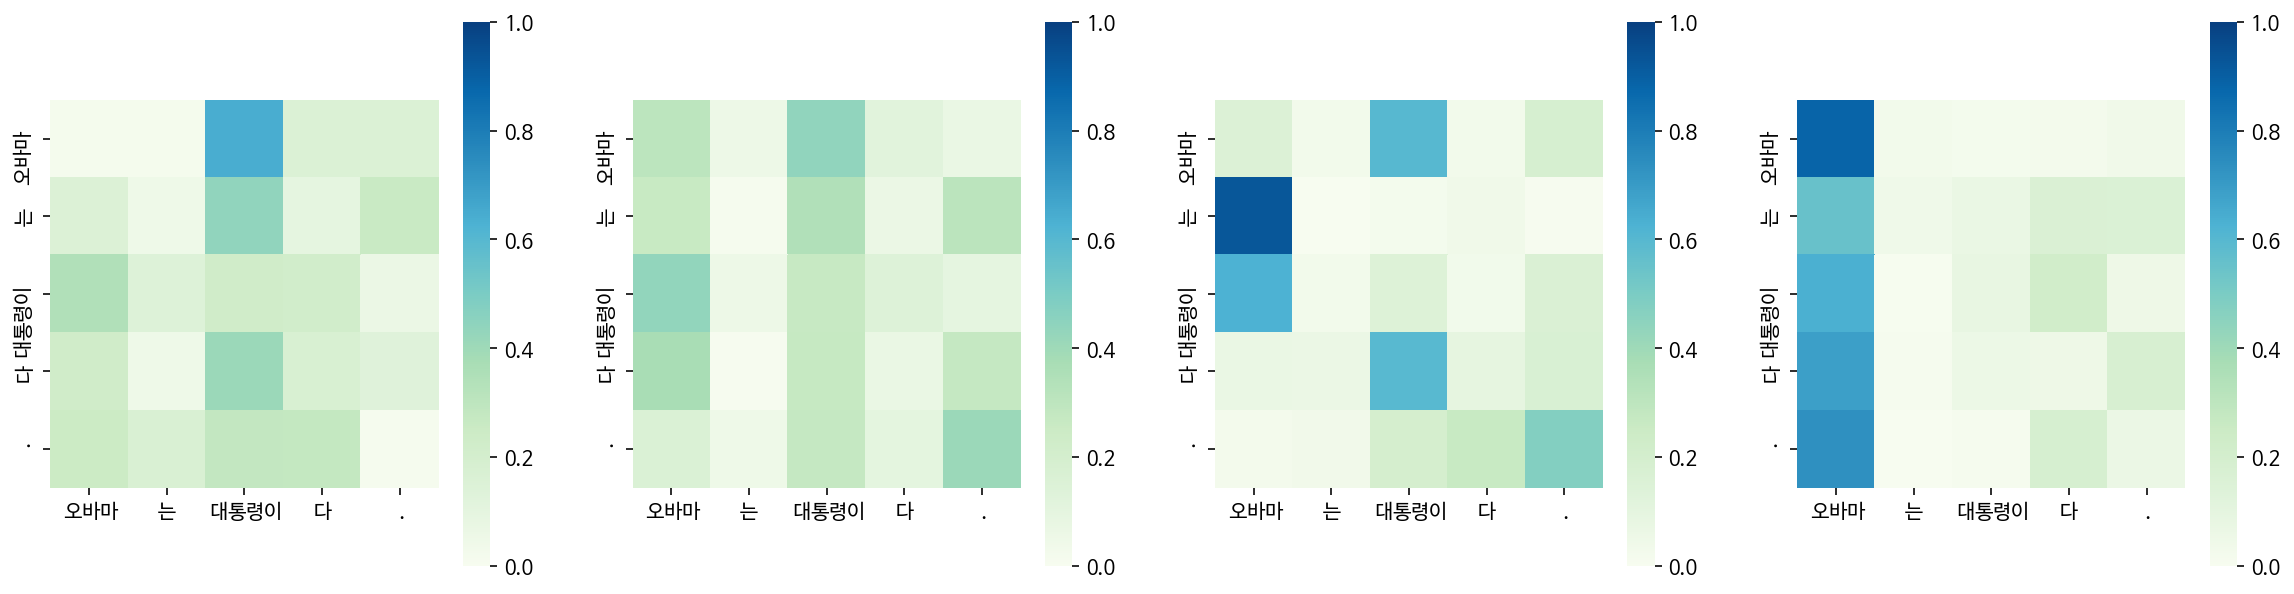

Encoder Layer 2


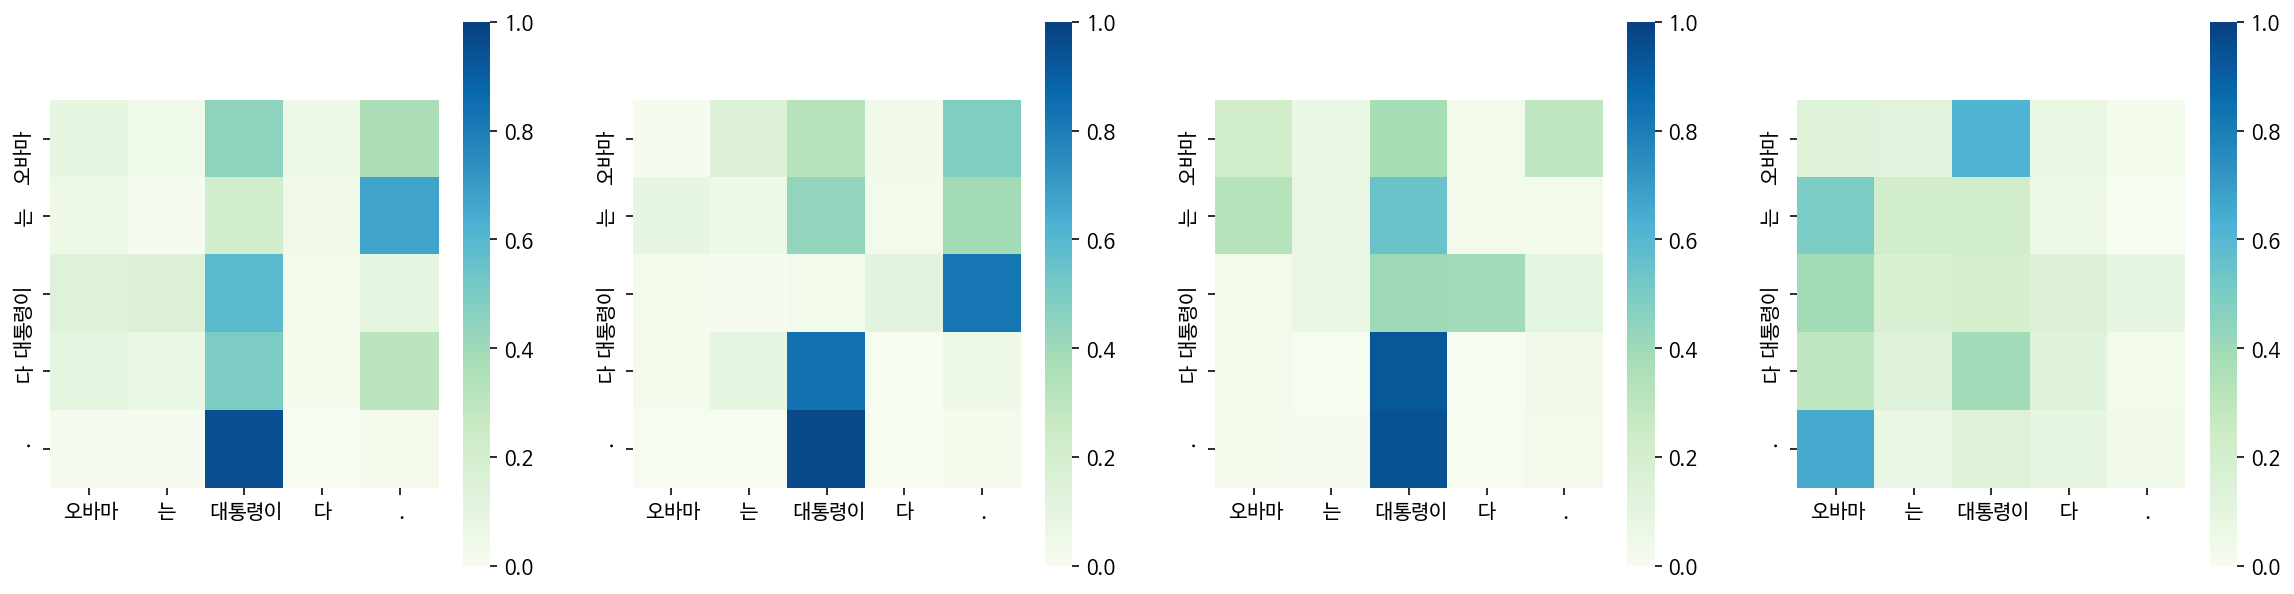

Decoder Self Layer 1


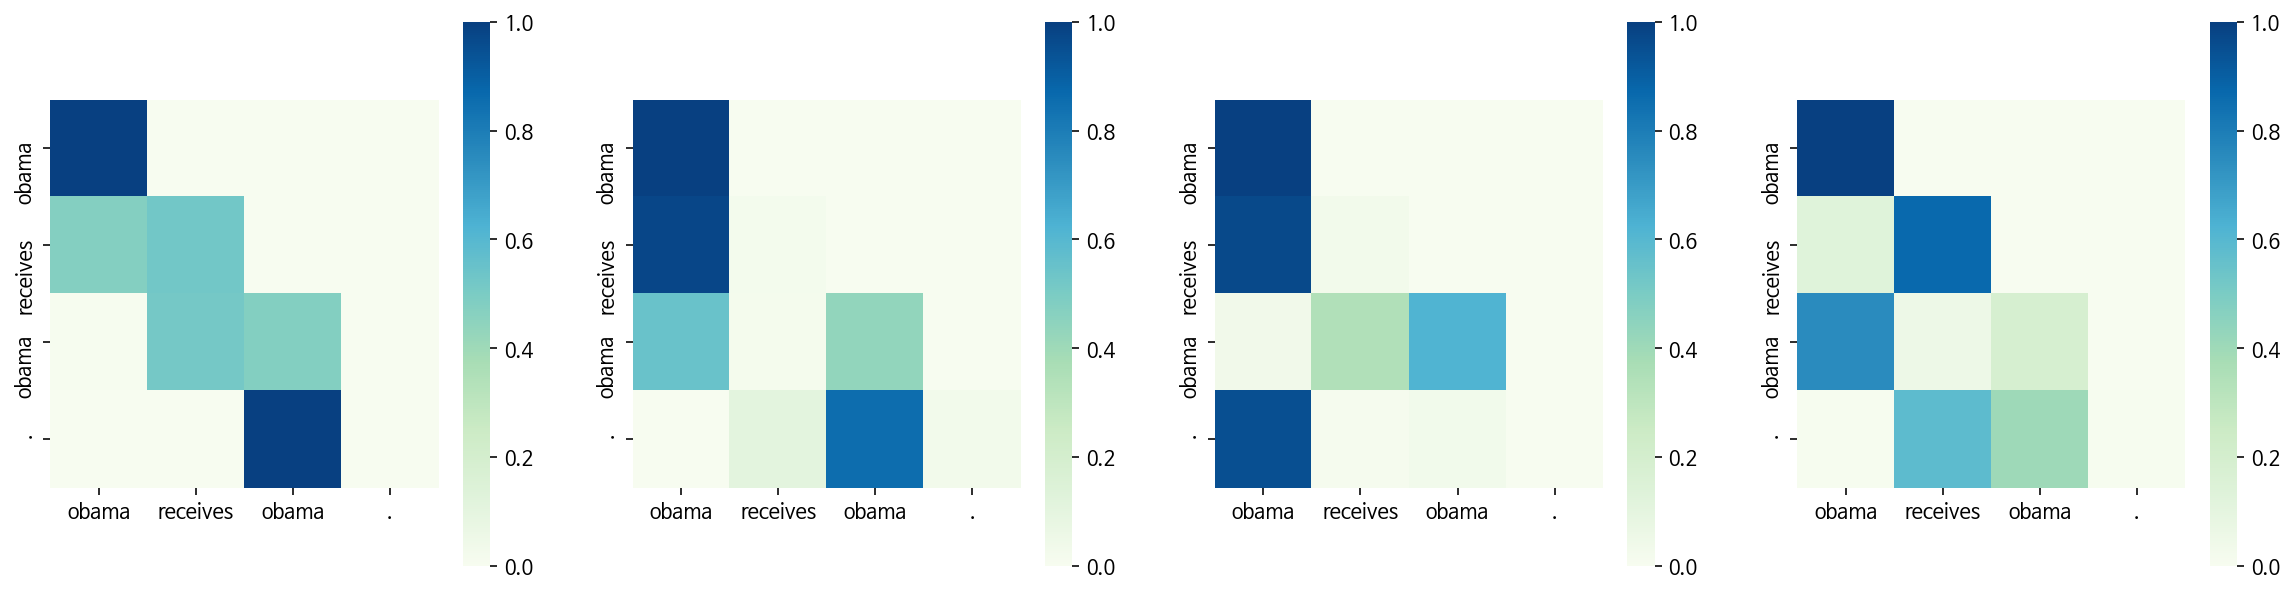

Decoder Src Layer 1


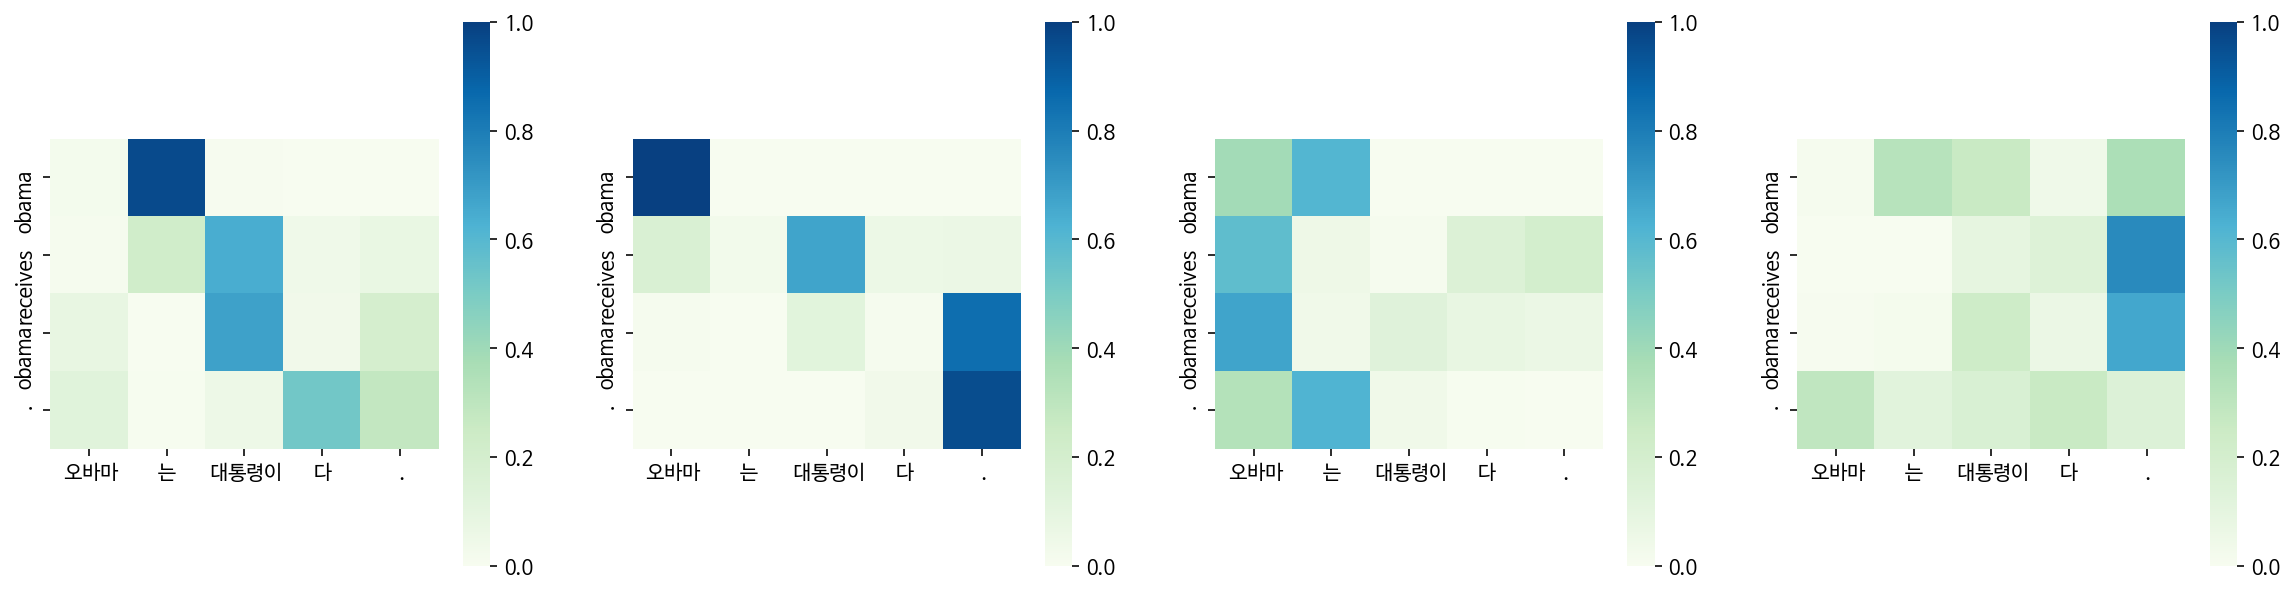

Decoder Self Layer 2


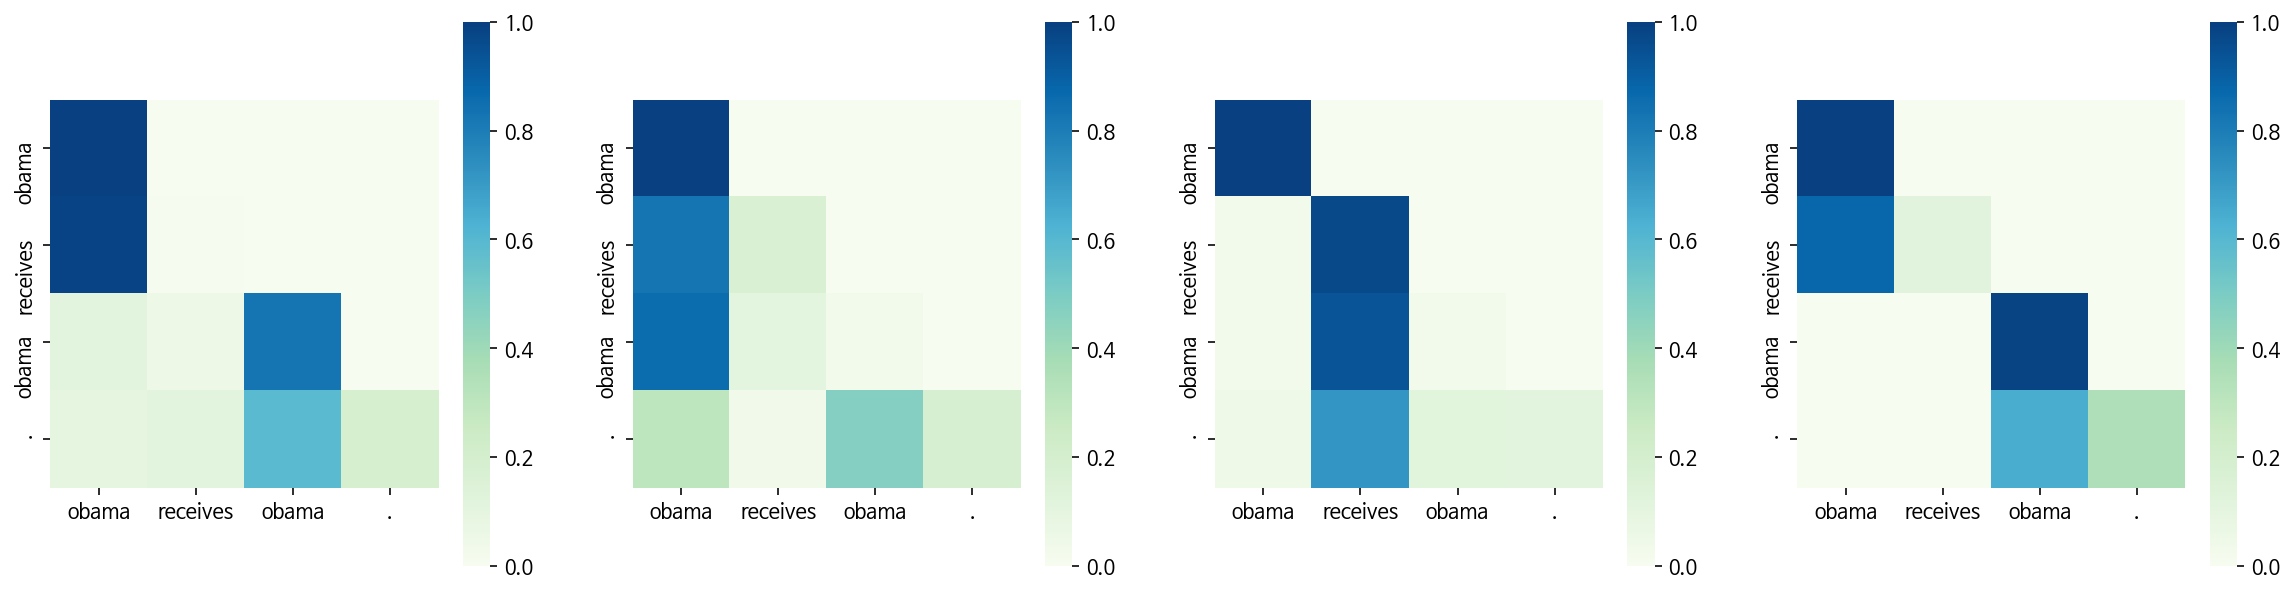

Decoder Src Layer 2


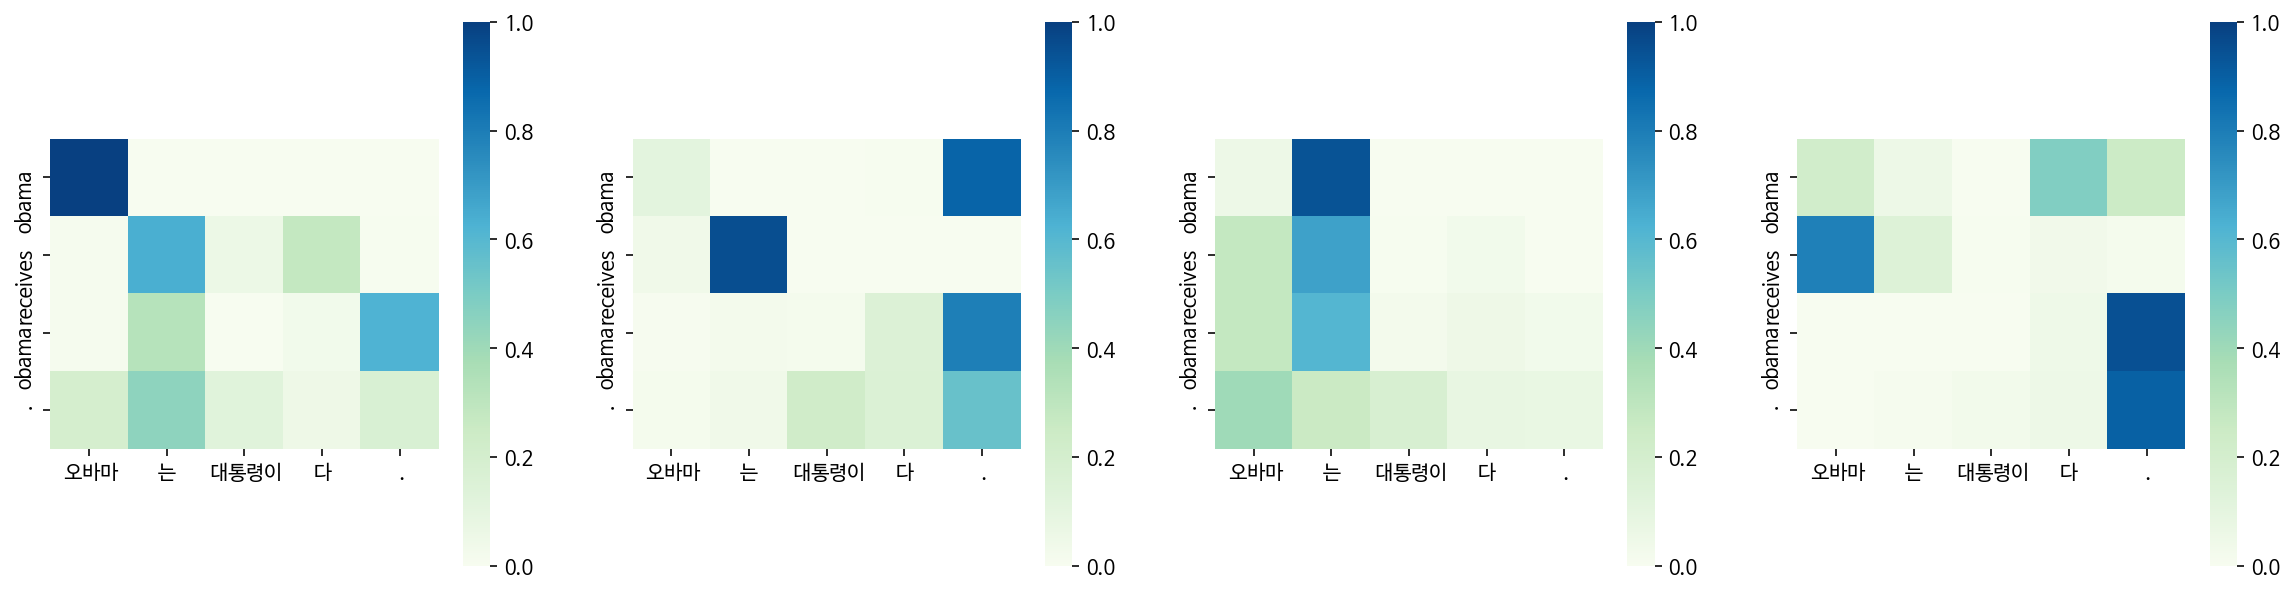

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : we are seeing to be aciden acidic
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take coffee or need to take a coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven more people were killed in the square of the contests were wounded .


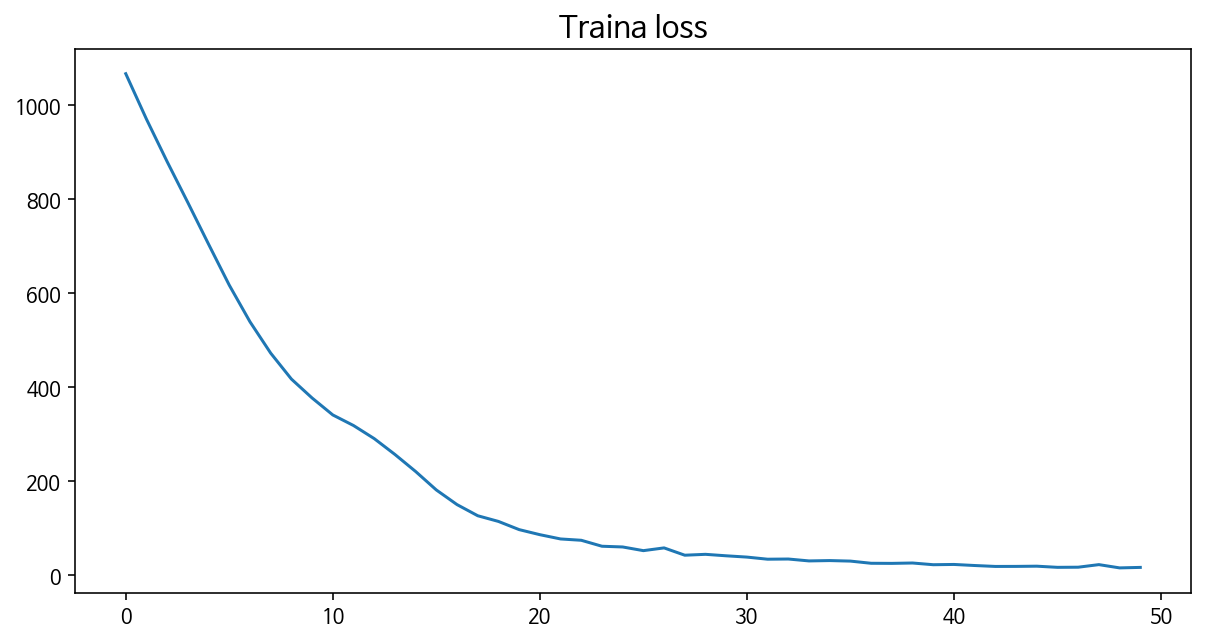

In [113]:
losses_3 = train(transformer_3, optimizer_3, enc_train, dec_train, 
                 ko_tokenizer, en_tokenizer, examples, 50, 256)
show_train_loss(losses_3)

In [114]:
print_result(transformer_3, ko_tokenizer, en_tokenizer, examples,
             n_layers=hyperparameters_3['n_layers'], 
             d_model=hyperparameters_3['d_model'], 
             n_heads=hyperparameters_3['n_heads'], 
             d_ff=hyperparameters_3['d_ff'], 
             dropout=hyperparameters_3['dropout'])

Translations
> 1. obama receives obama .
> 2. we are seeing to be aciden acidic
> 3. take coffee or need to take a coffee .
> 4. seven more people were killed in the square of the contests were wounded .

Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3


#### [TRY2] EPOCHS=100

  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 1]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : part this is part of the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : however , she need to have coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed in kind of state in the square deaths .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 2]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : while watching the city is acid
🇰🇷 : 커피는 필요 없다.
🇺🇸 : about . coffee take a coffee cup .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed in the square deaths


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 3]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives president obama for .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : while watching the city subsequently decline .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so that percent said coffee would take a .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , the daily toll .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 4]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama shouted .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : for each city is good .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : so take that she needed to take a coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , the daily toll was seven of the dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 5]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama s president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : residents the city cited urban city is over the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : that would take coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seven dead were killed , about percent of the dead were wounded .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 6]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : this city is acidon , citing the city is acidis .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : how do people need to take coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people dead were killed , the daily toll on wednesday .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 7]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama s president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : residents the city told the city is good .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : that need so coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : nine people were killed in the dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 8]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama president obama as say .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : residents the city towns higher .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : how she need to take coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven dead another death toll was dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 9]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : residents the city told the city is that of urban .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : that need to take a prospect .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , the dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 10]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama s president .
Encoder Layer 1


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


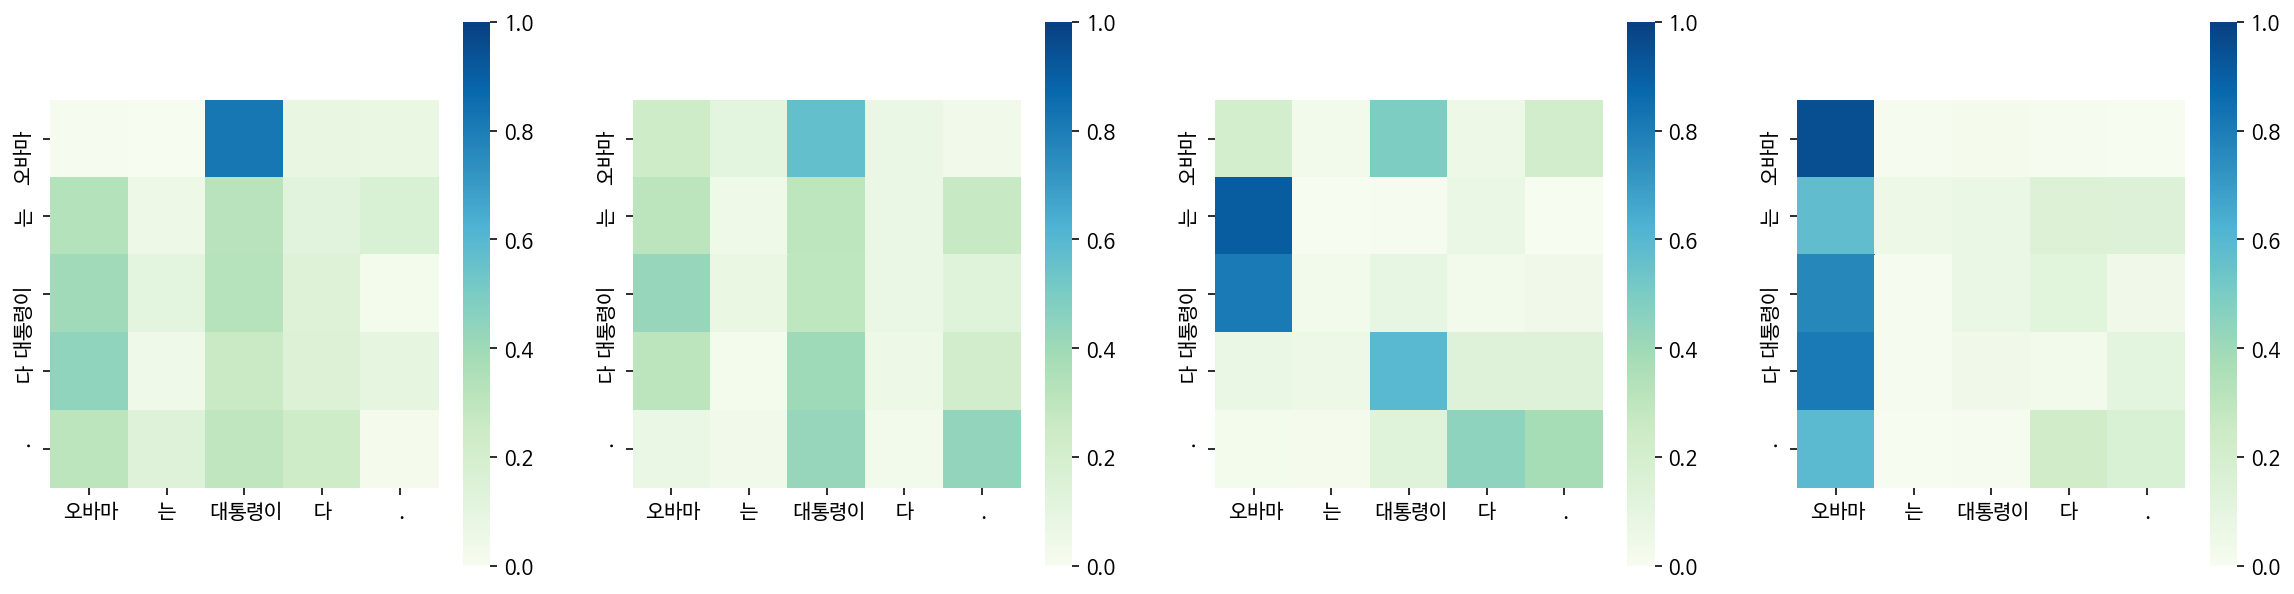

Encoder Layer 2


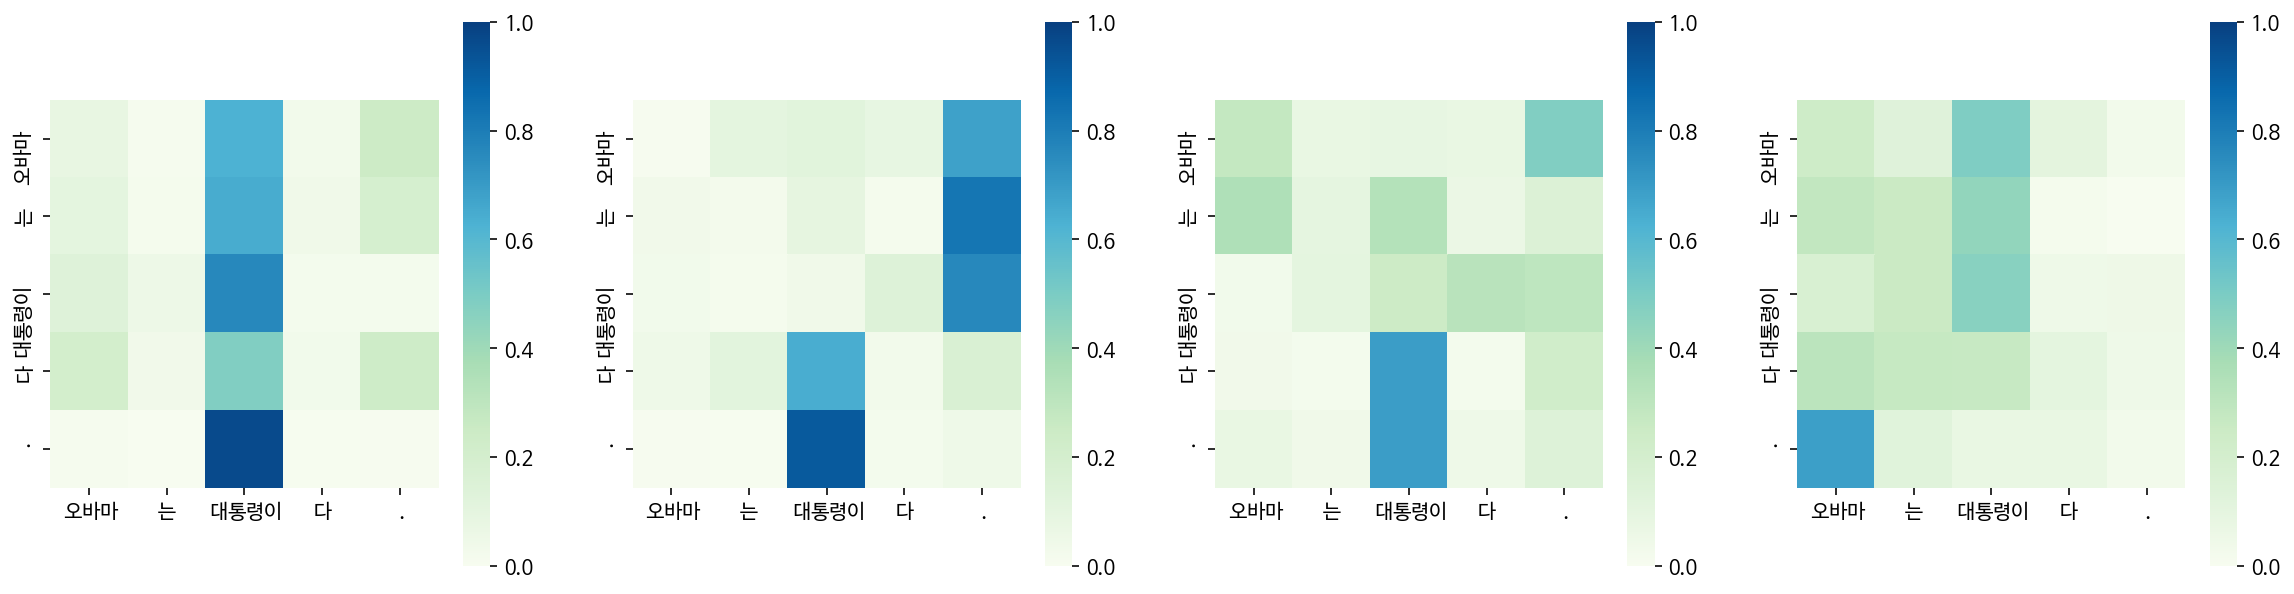

Decoder Self Layer 1


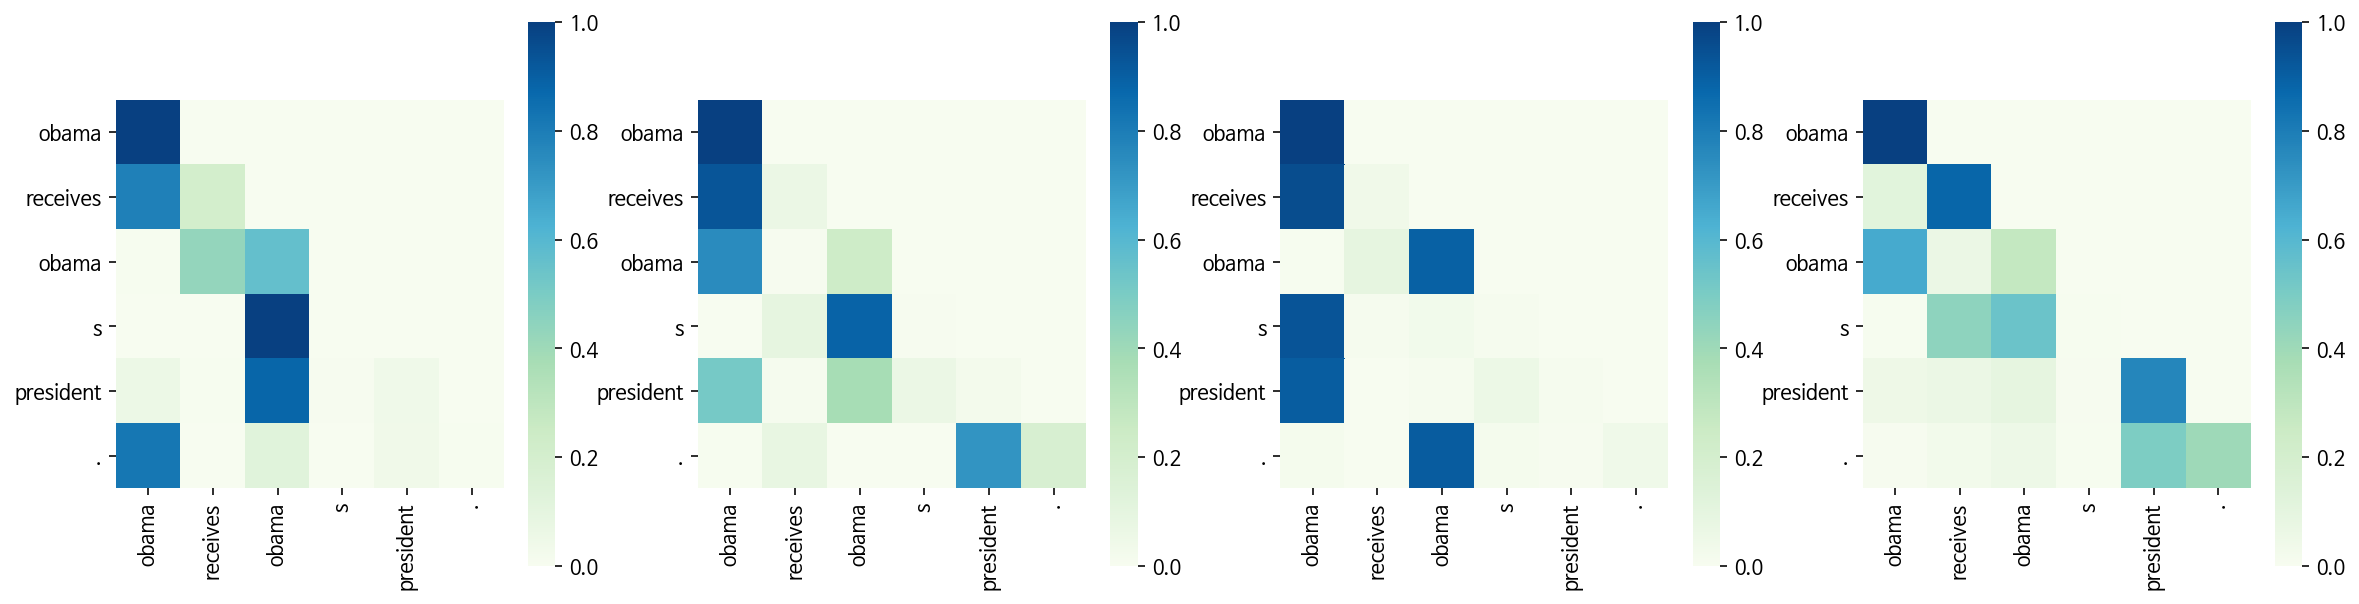

Decoder Src Layer 1


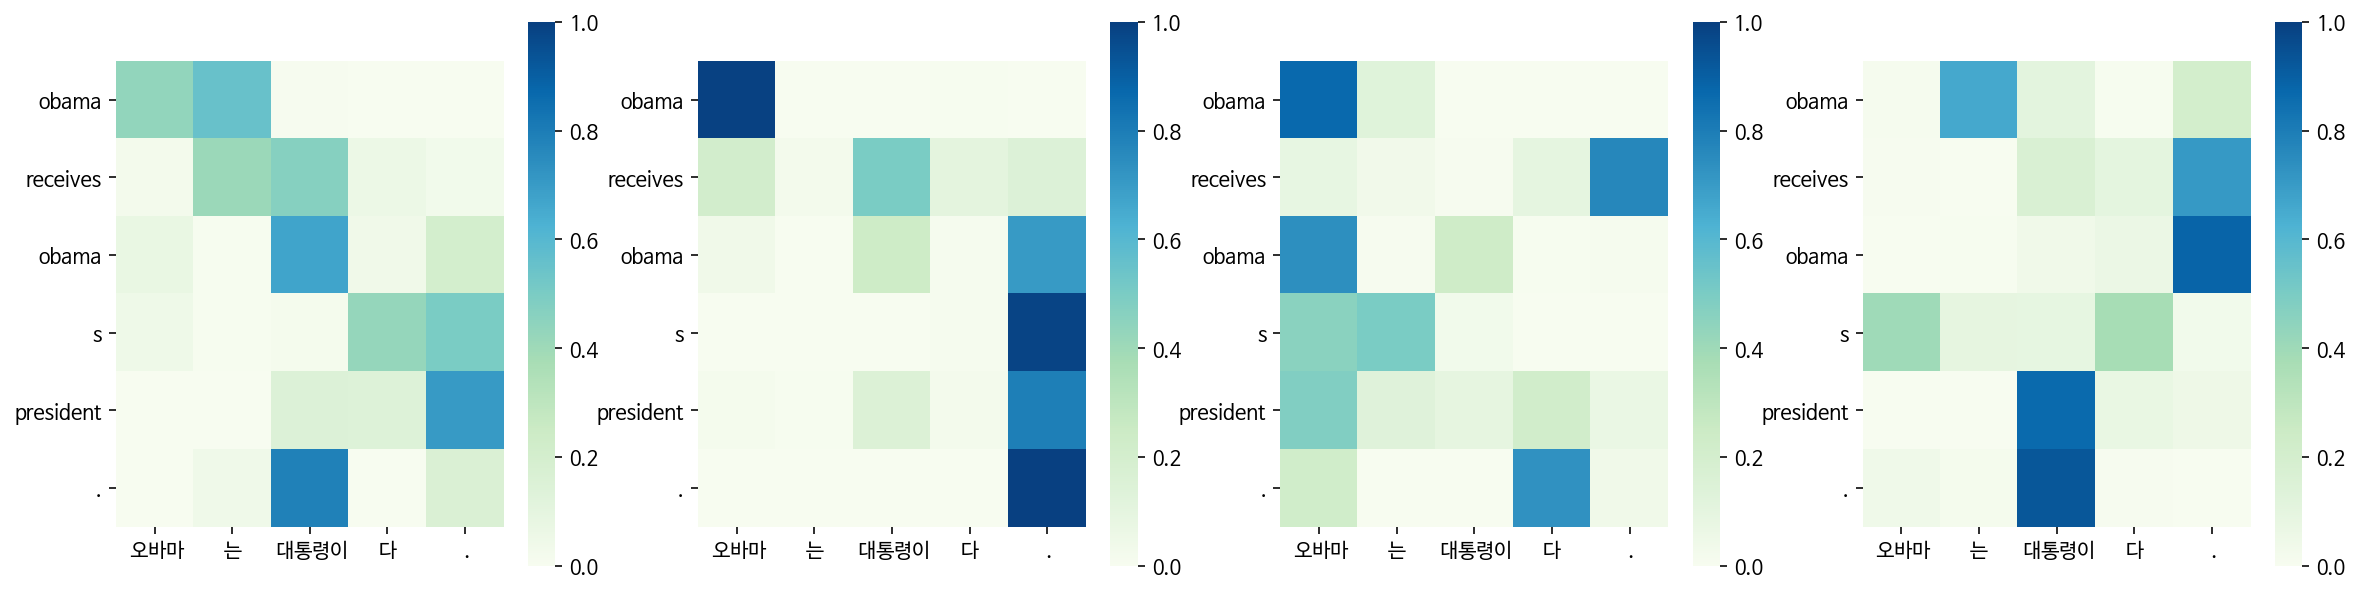

Decoder Self Layer 2


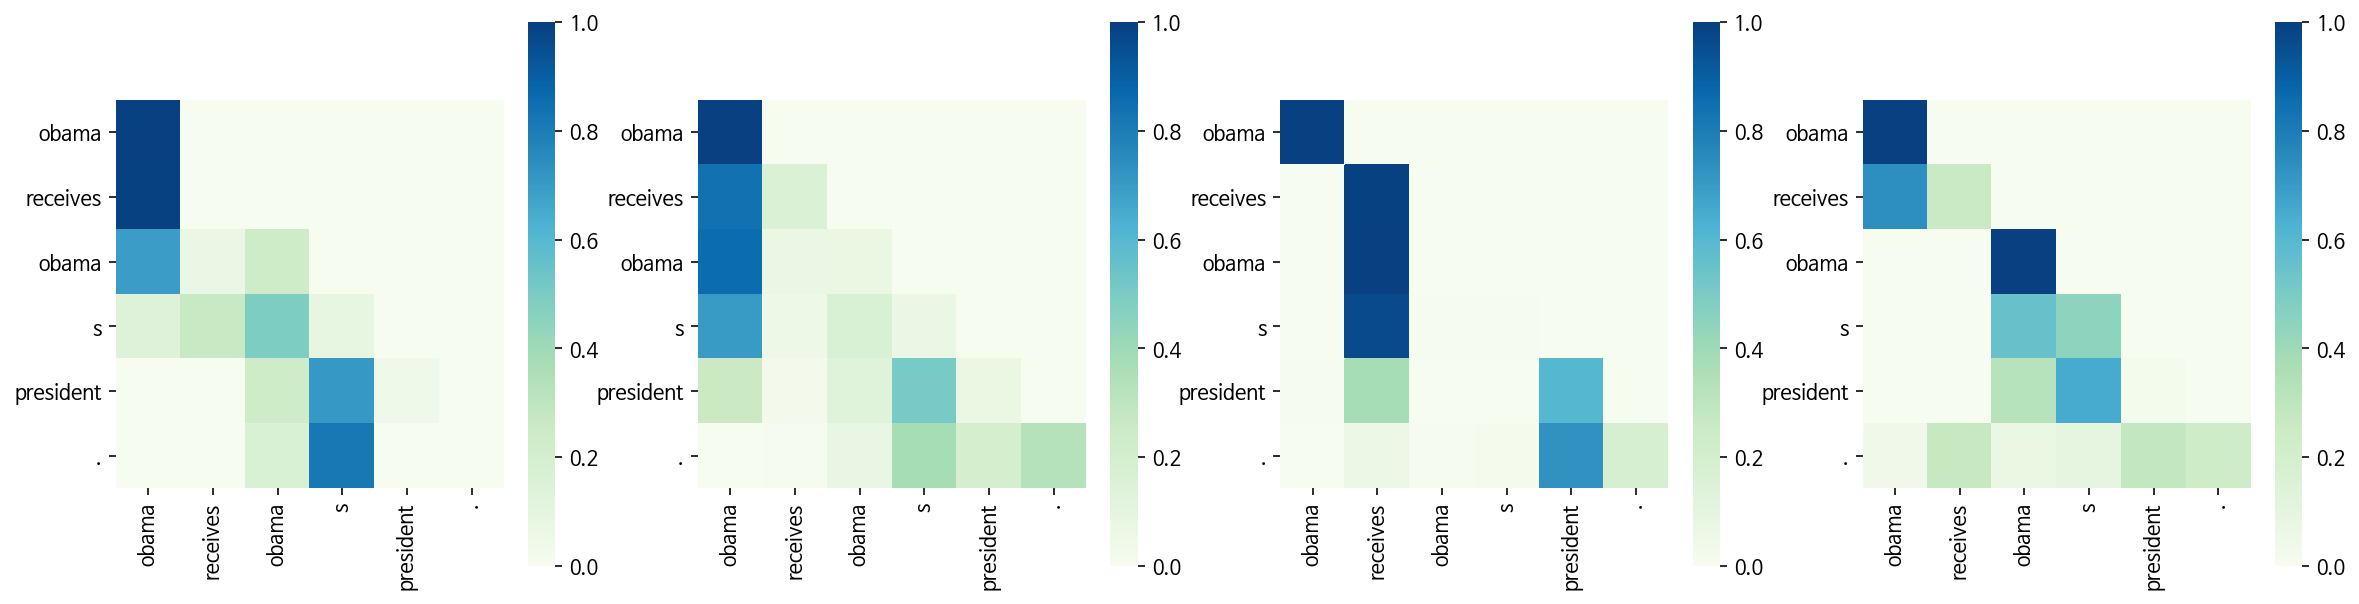

Decoder Src Layer 2


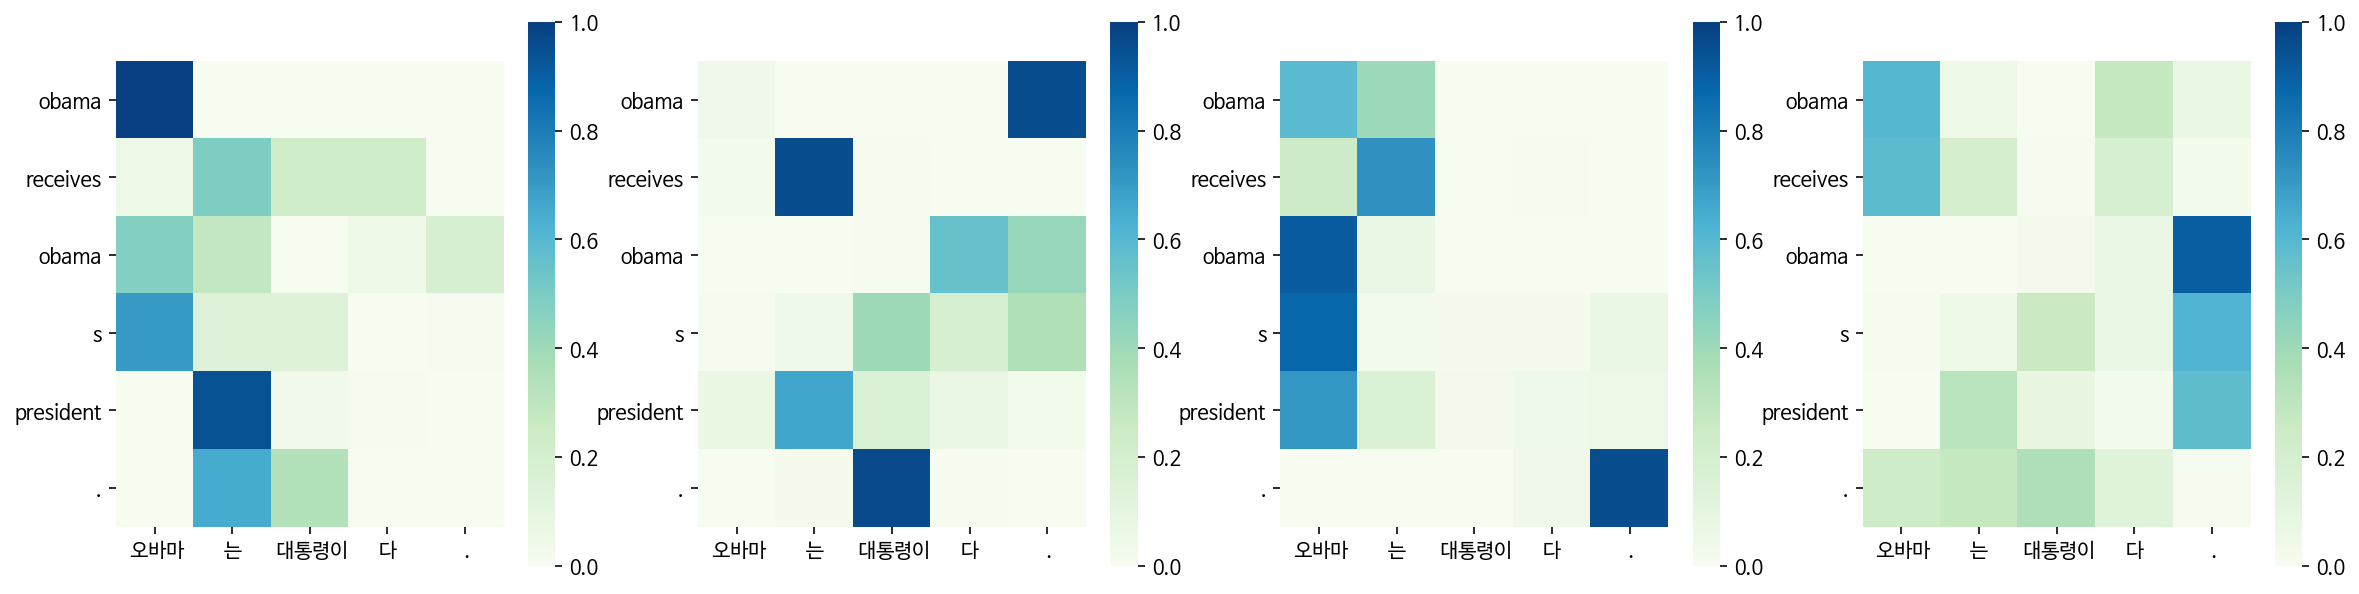

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : residents the city told the city is that of american citizens .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : need to do people need not need coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people were killed , the daily toll was dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 11]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , obama says .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : residents towns towns high stands over city cities
🇰🇷 : 커피는 필요 없다.
🇺🇸 : that is for people about .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , the dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 12]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama president obama says he s big .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : this is acid urban acid
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is yes , if need or need to coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seventers were killed , on february , then of people were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 13]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama s kind of thing .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : embassy towns and urban acid is out of urban protest .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : those who needed to fend off .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seven critical deaths .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 14]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , obama said .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : residents of the city is acid urban .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take to coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seven critical toll of the dead were staffers .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 15]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , obama said .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : residents towns city towns and towns urban congestion .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take a she needs coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people were killed , .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 16]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , says .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : this is the city towns city city towns urban acidic .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take a coffeehood
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people were killed , the daily toll was dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 17]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : this is the city cited urban acidic urbanis .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take coffee is a needed to take these coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people were killed , .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 18]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : this is the city to become a city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take that coffee is a needed , she needed .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people were killed , then of them killed people .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 19]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama would make president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : towns city towns certainly is over the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take coffee is unable to need coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , then of the dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 20]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president would make obama .
Encoder Layer 1


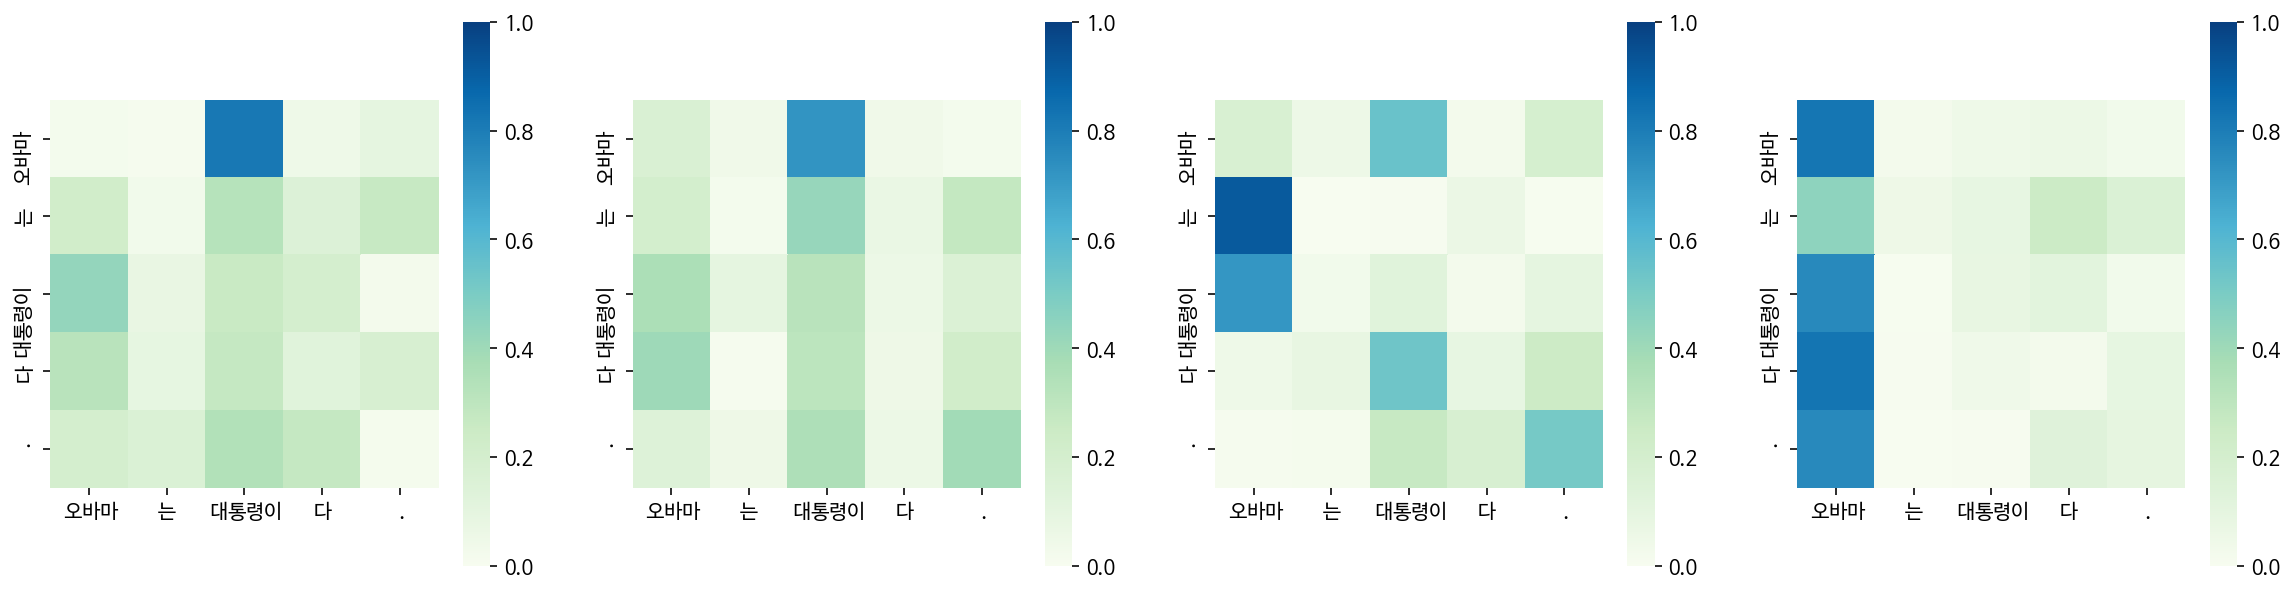

Encoder Layer 2


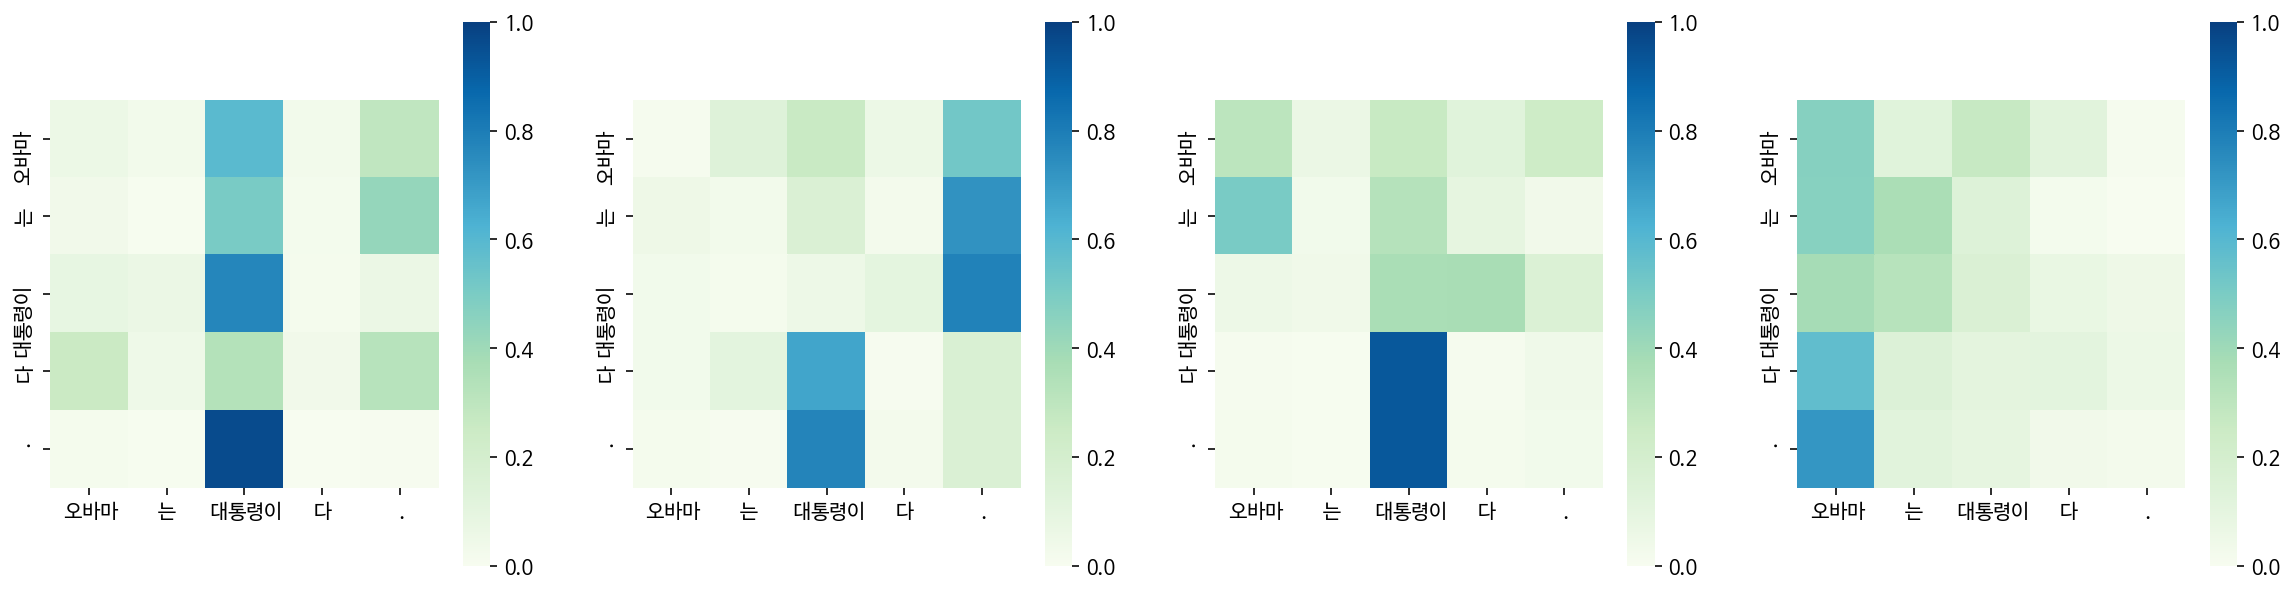

Decoder Self Layer 1


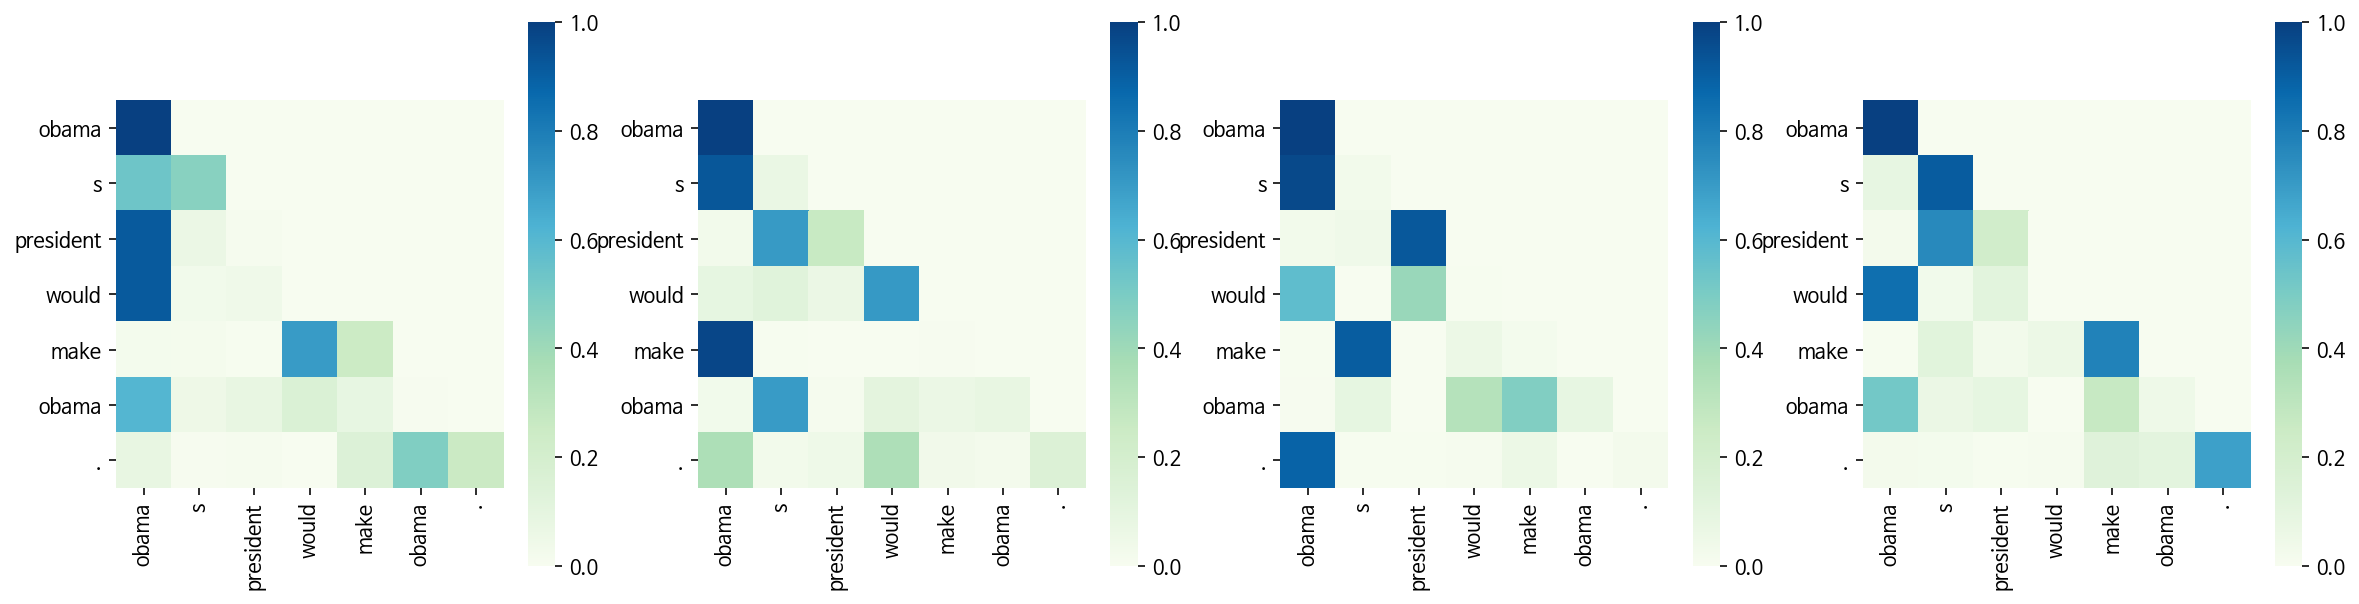

Decoder Src Layer 1


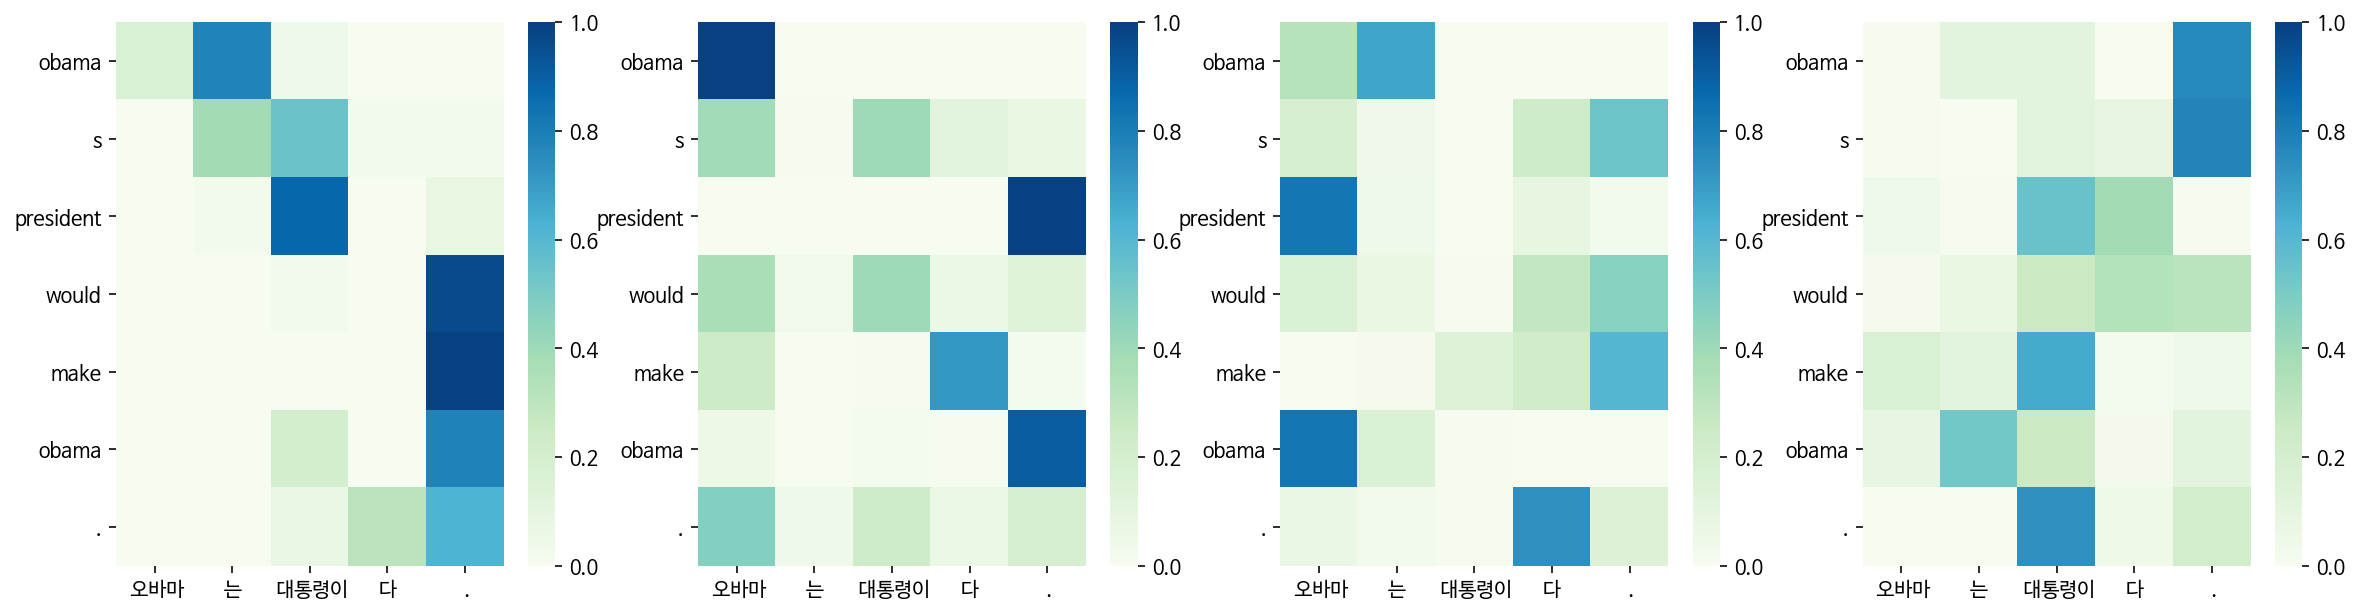

Decoder Self Layer 2


Decoder Src Layer 2


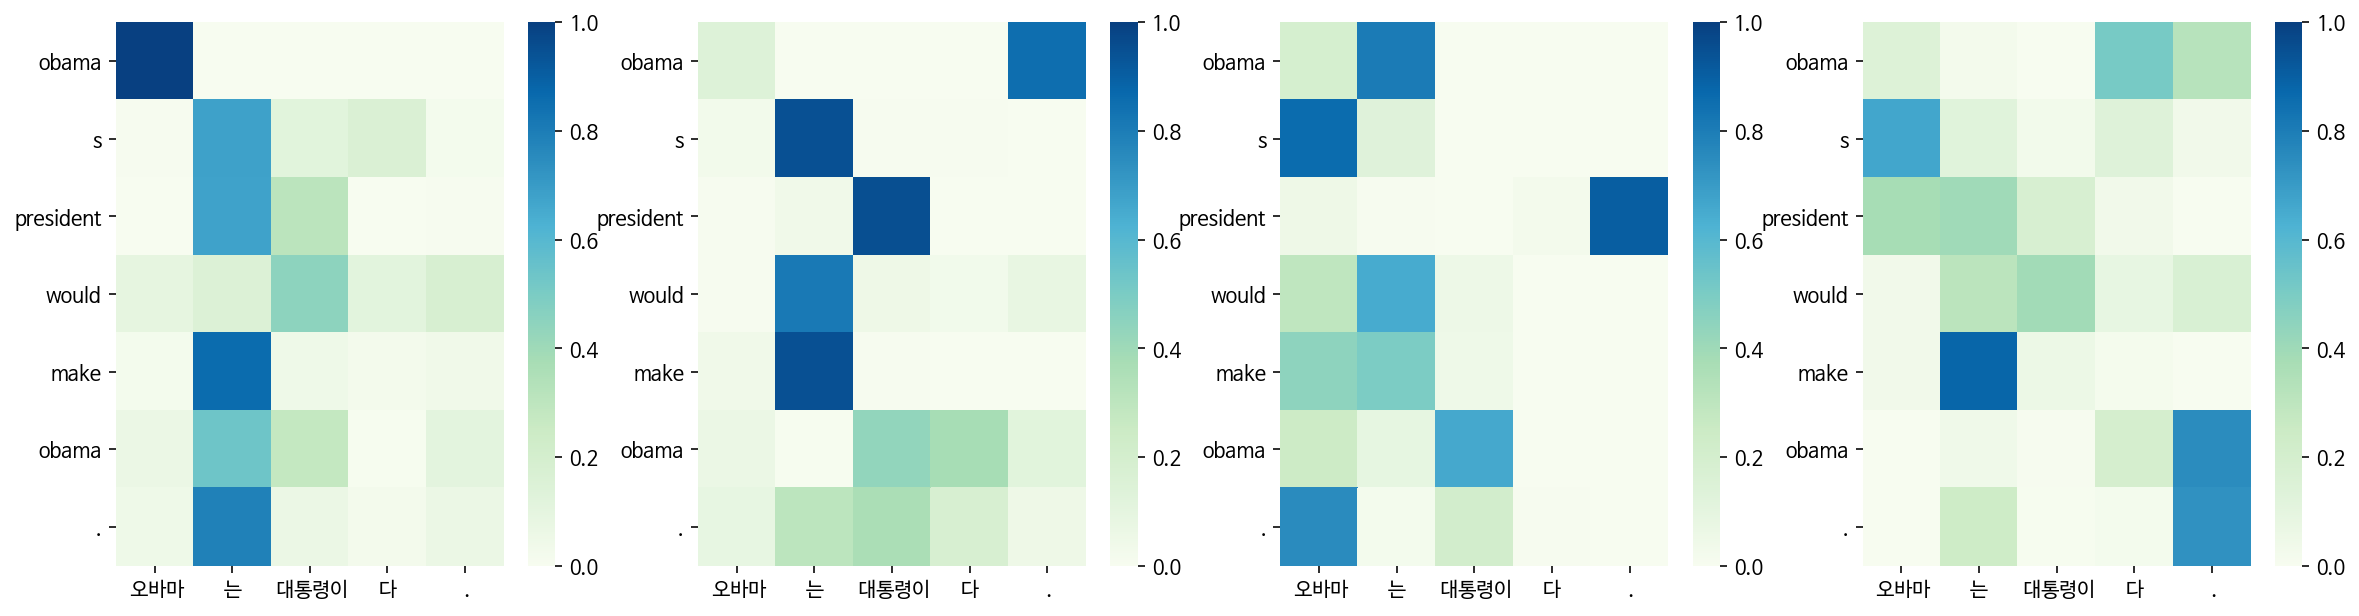

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : towns city city towns certainly hindustan
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take coffee or in the coffee is not
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , the seventh straight day of the country .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 21]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , obama said .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is acid urban .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take coffee or
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , the seventh straight storm .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 22]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , says .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cited urban city of
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take a coffee vacation or so do not need .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven coast guard forces were killed , the seven cabin during seven minutes .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 23]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president was a president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : this is acid , citing city s urban ibn .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take or closets
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven troops were killed , the seventh of the dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 24]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , says he s president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : residents towns towns urban city is acid
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take coffee or so percent her need .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven dozens of people were killed , .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 25]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president finds a president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : we are urban .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is my needed to take office or
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 26]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president was a president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cited old city mass acid
🇰🇷 : 커피는 필요 없다.
🇺🇸 : take coffee or
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven towns workers were killed , .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 27]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , says he s a candidate .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cited the old city of urban .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : even so , she needs to take coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seven unions were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 28]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama introduced obama s president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cited old towns .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is for that coffee vary .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , the seventh of the military secured people .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 29]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president would make president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cited the city health over the urban crisis .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : people don t need coffee or
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , the daily toll was dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 30]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president would make a candidate .
Encoder Layer 1


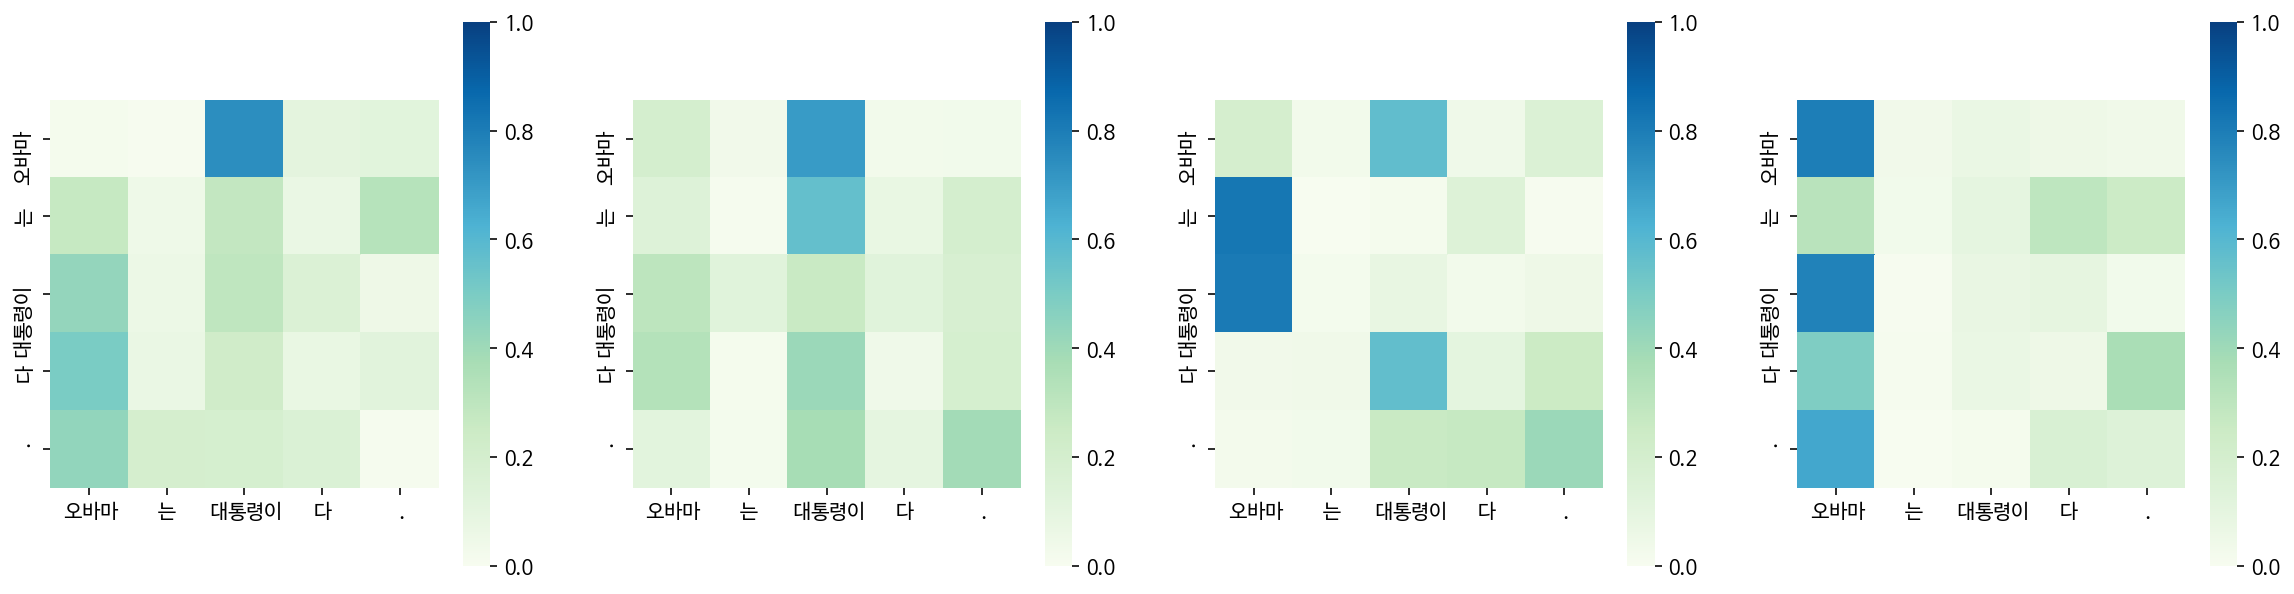

Encoder Layer 2


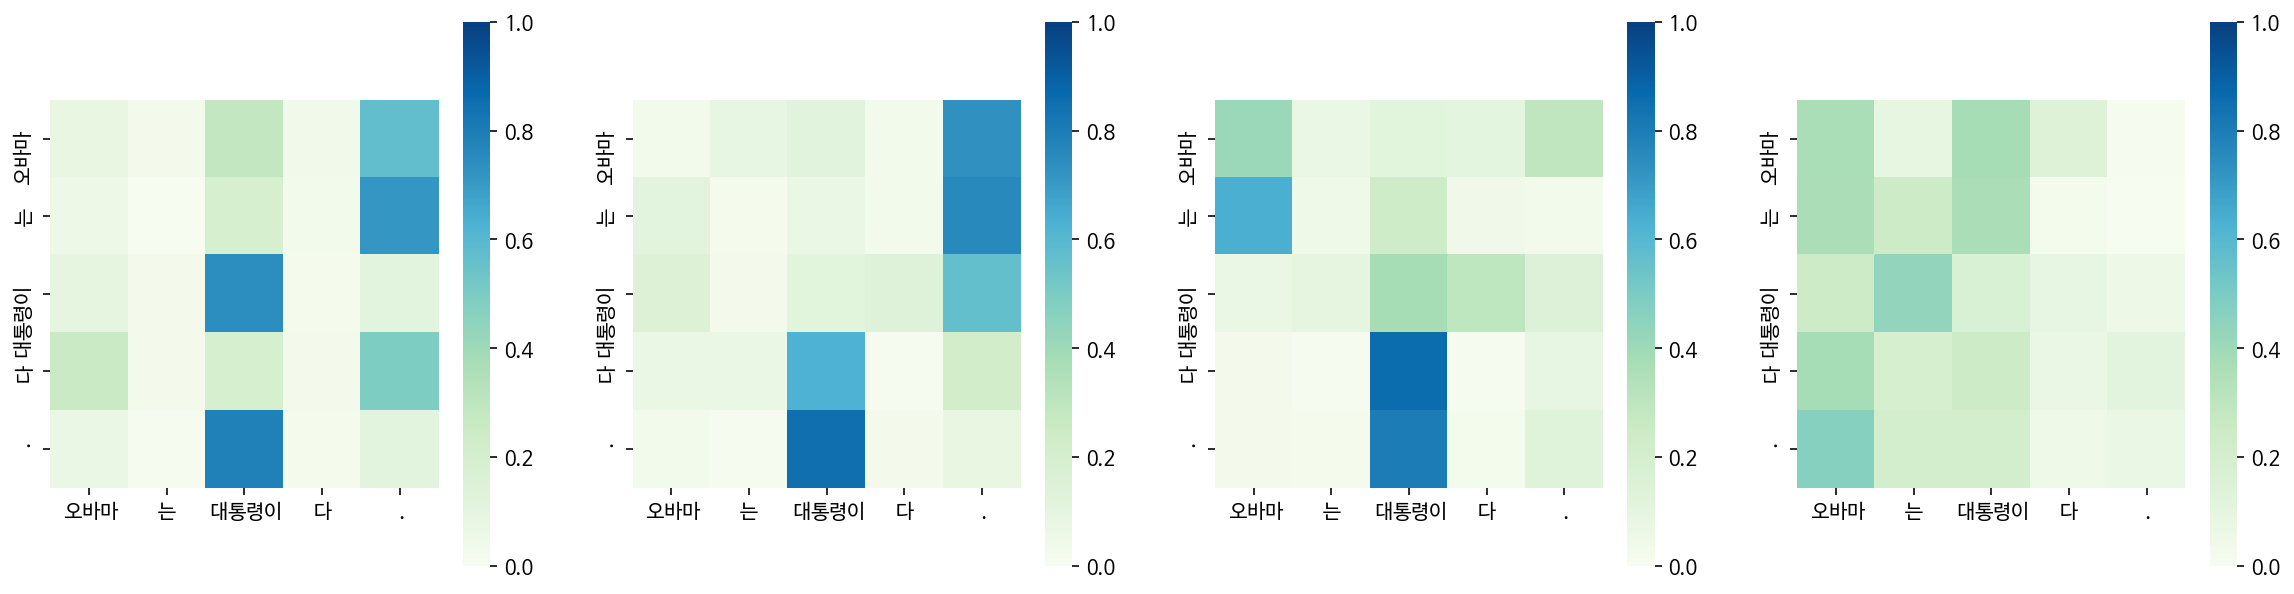

Decoder Self Layer 1


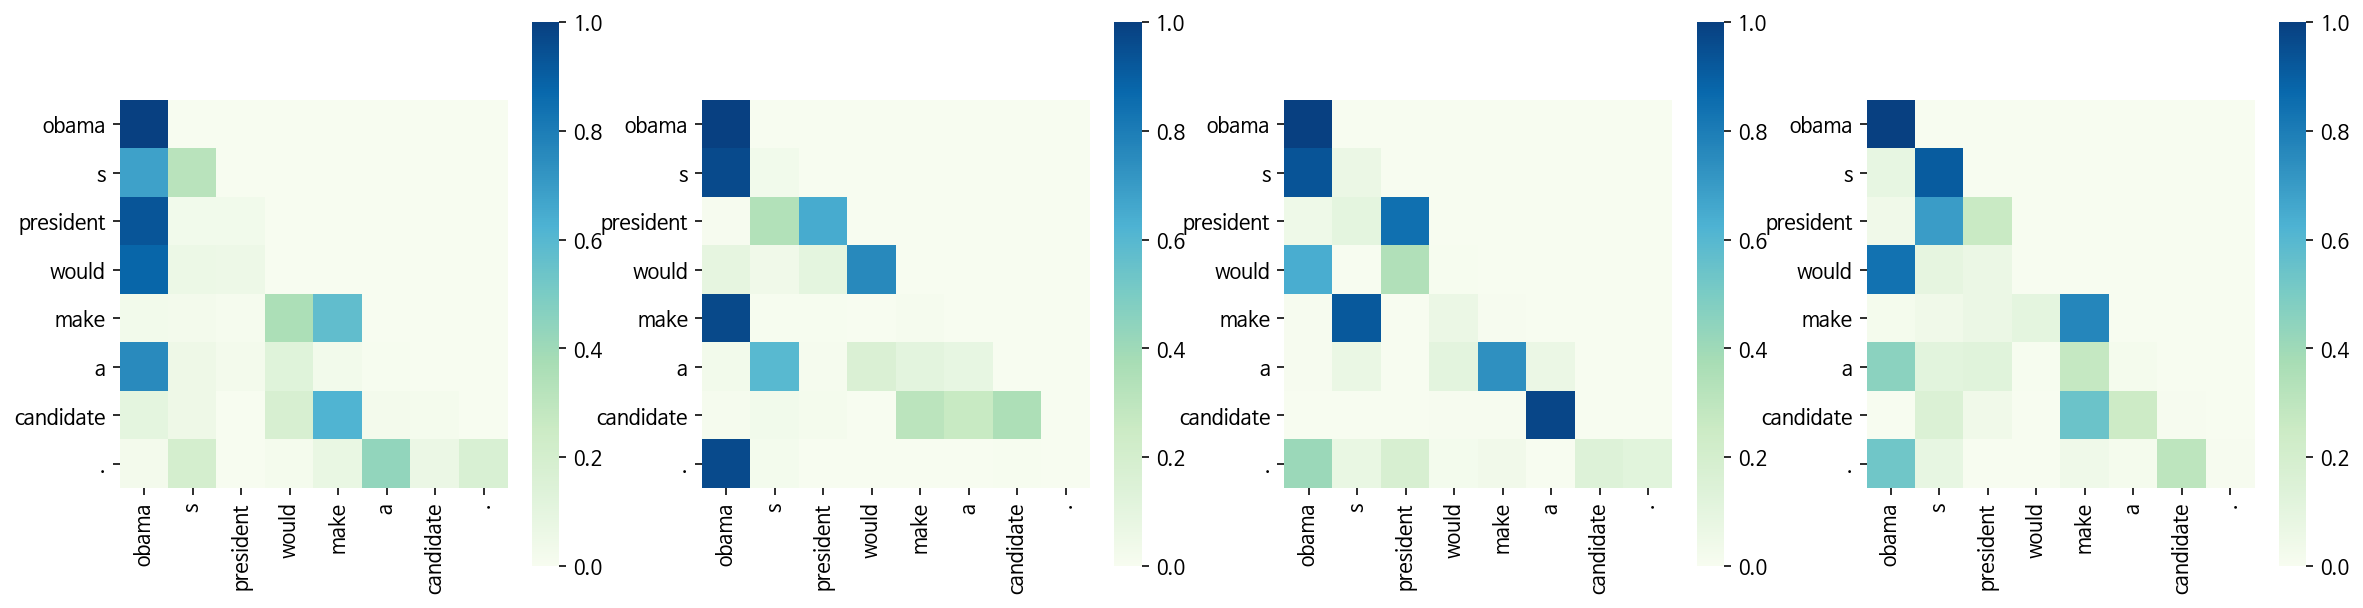

Decoder Src Layer 1


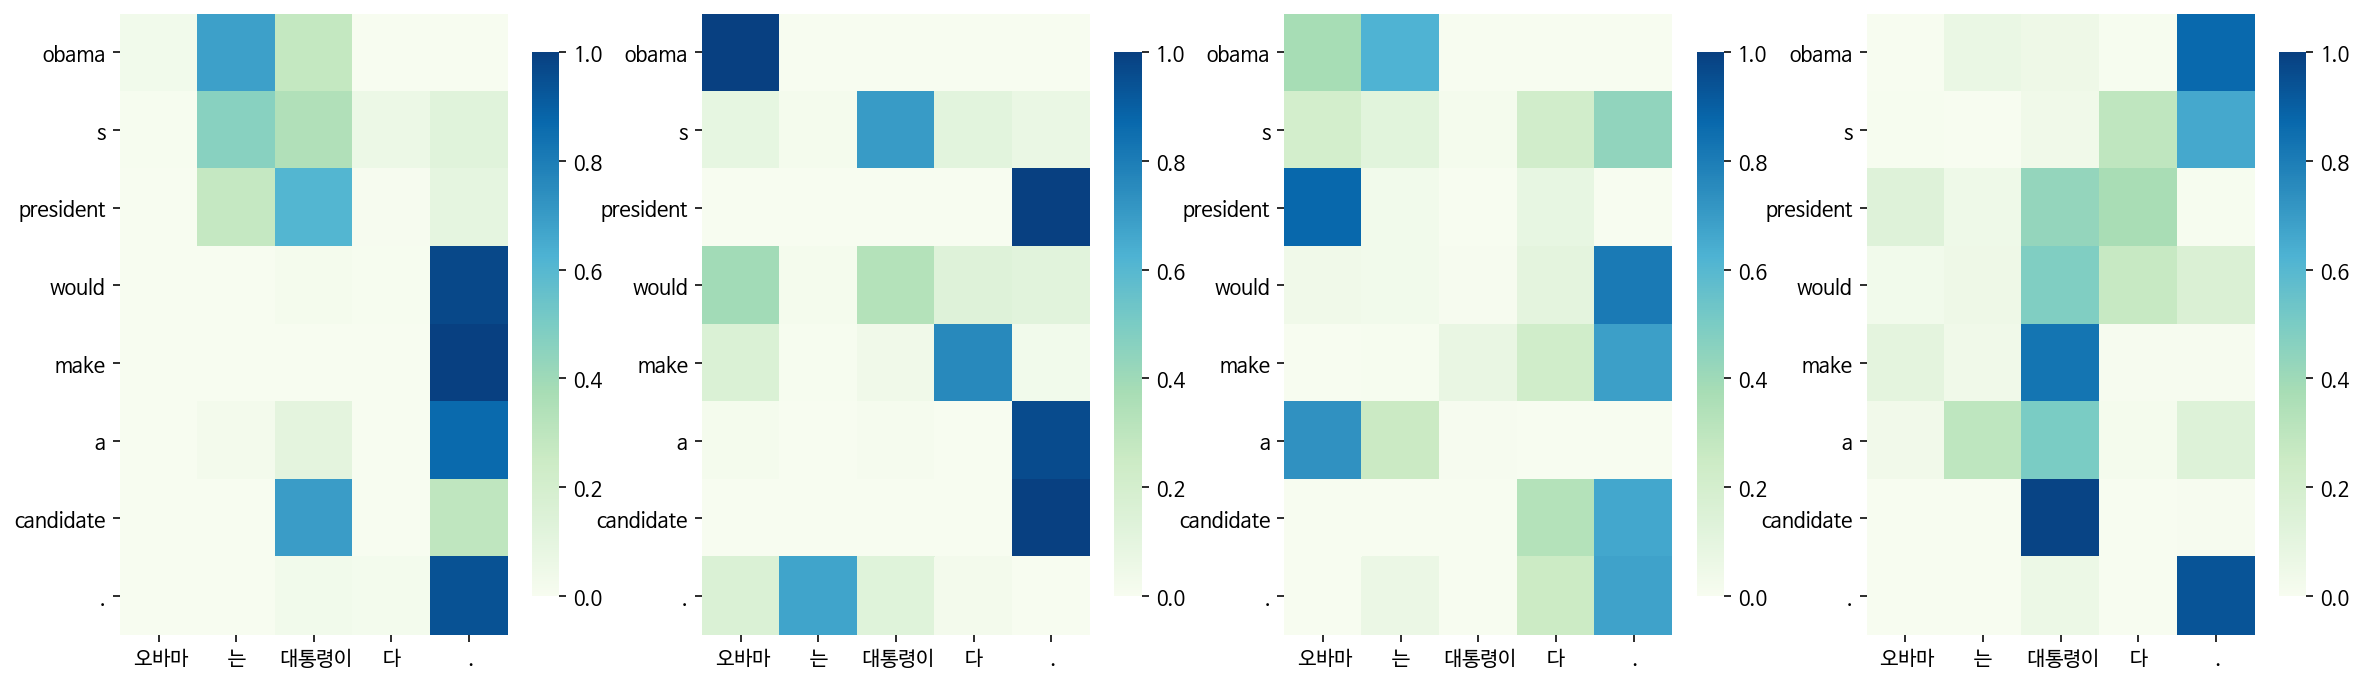

Decoder Self Layer 2


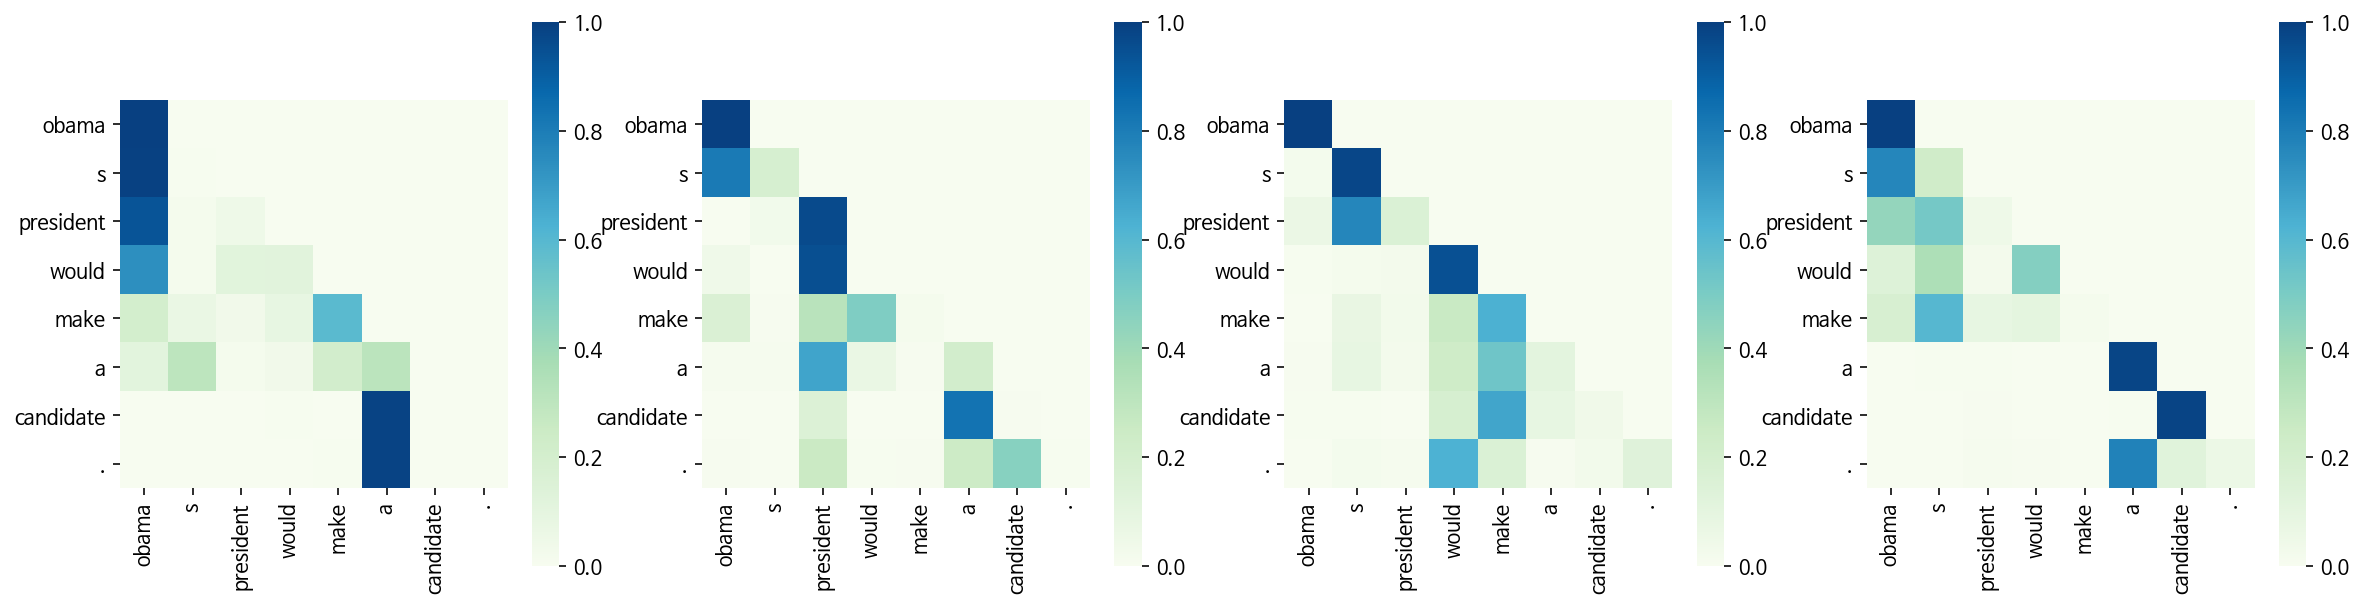

Decoder Src Layer 2


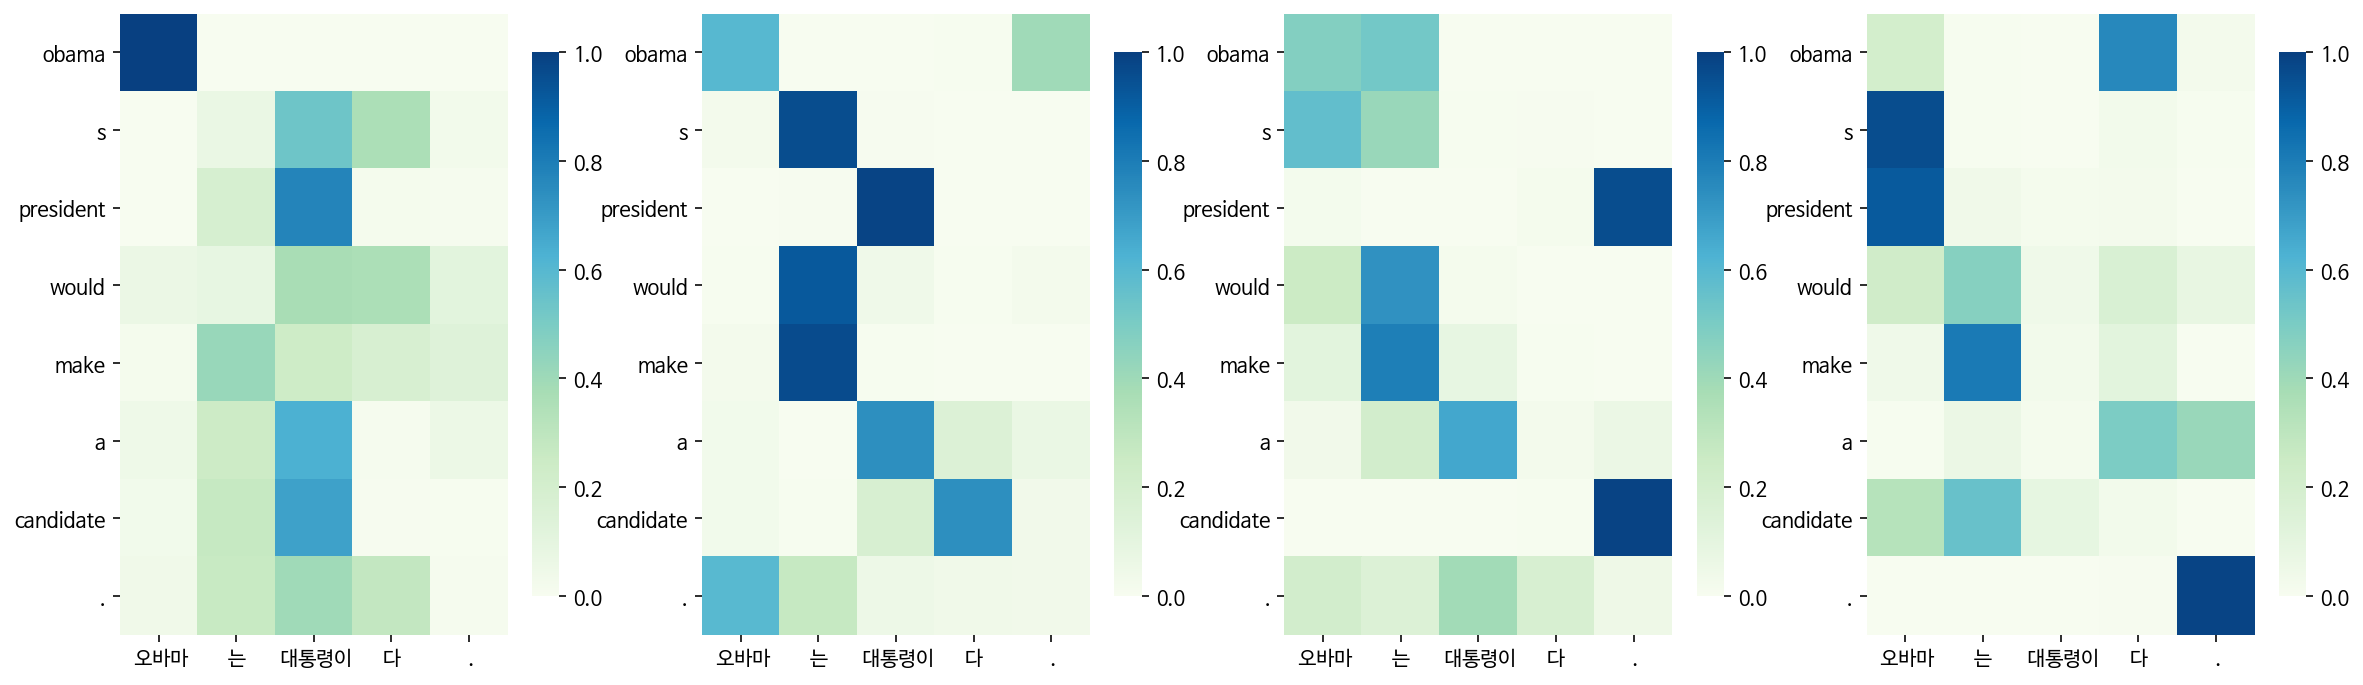

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cities are safe .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : that coffee is about .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven moved people over five dozens of them


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 31]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , says he s president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cited the cities over the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : drink coffee is for that coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the dead were killed , police and six members of the dead were recorded .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 32]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives his party s president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : embassy was hurt .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : for that coffee is for
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the dead were killed , about a dozen cabinet


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 33]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama s own tremendous president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : this is acid , city s city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : that is for coffee take a floor .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seven missiles were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 34]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama introduced his president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city also sustained to meet .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : that s what s gives coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seven cabinet members were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 35]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cities are citizens .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : that s what needs to do people need not need to coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seven admitted wednesday .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 36]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president would make his term .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cited the city to see how man .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is for that coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven civilians were killed .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 37]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is watching the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : about .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seven gulf of the dead were .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 38]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama receives a slight edge of president obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cities are fine .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : no need for coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people were killed , .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 39]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama was a president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cities are watching the city over the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : drink coffee is for people needed
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people dead were killed , the daily toll was dead .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 40]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama was a president .
Encoder Layer 1


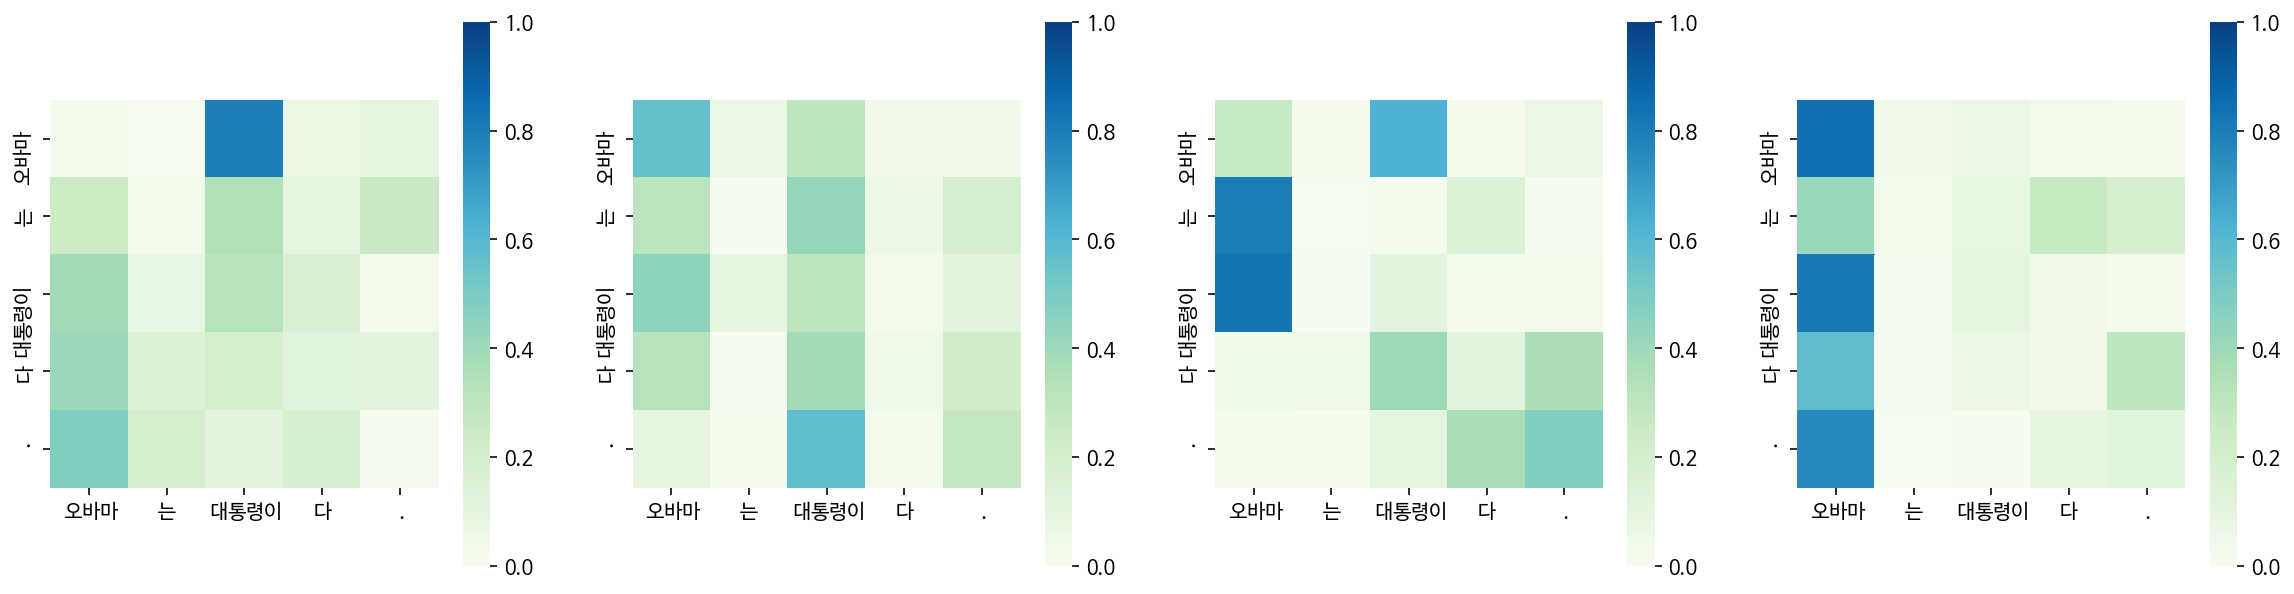

Encoder Layer 2


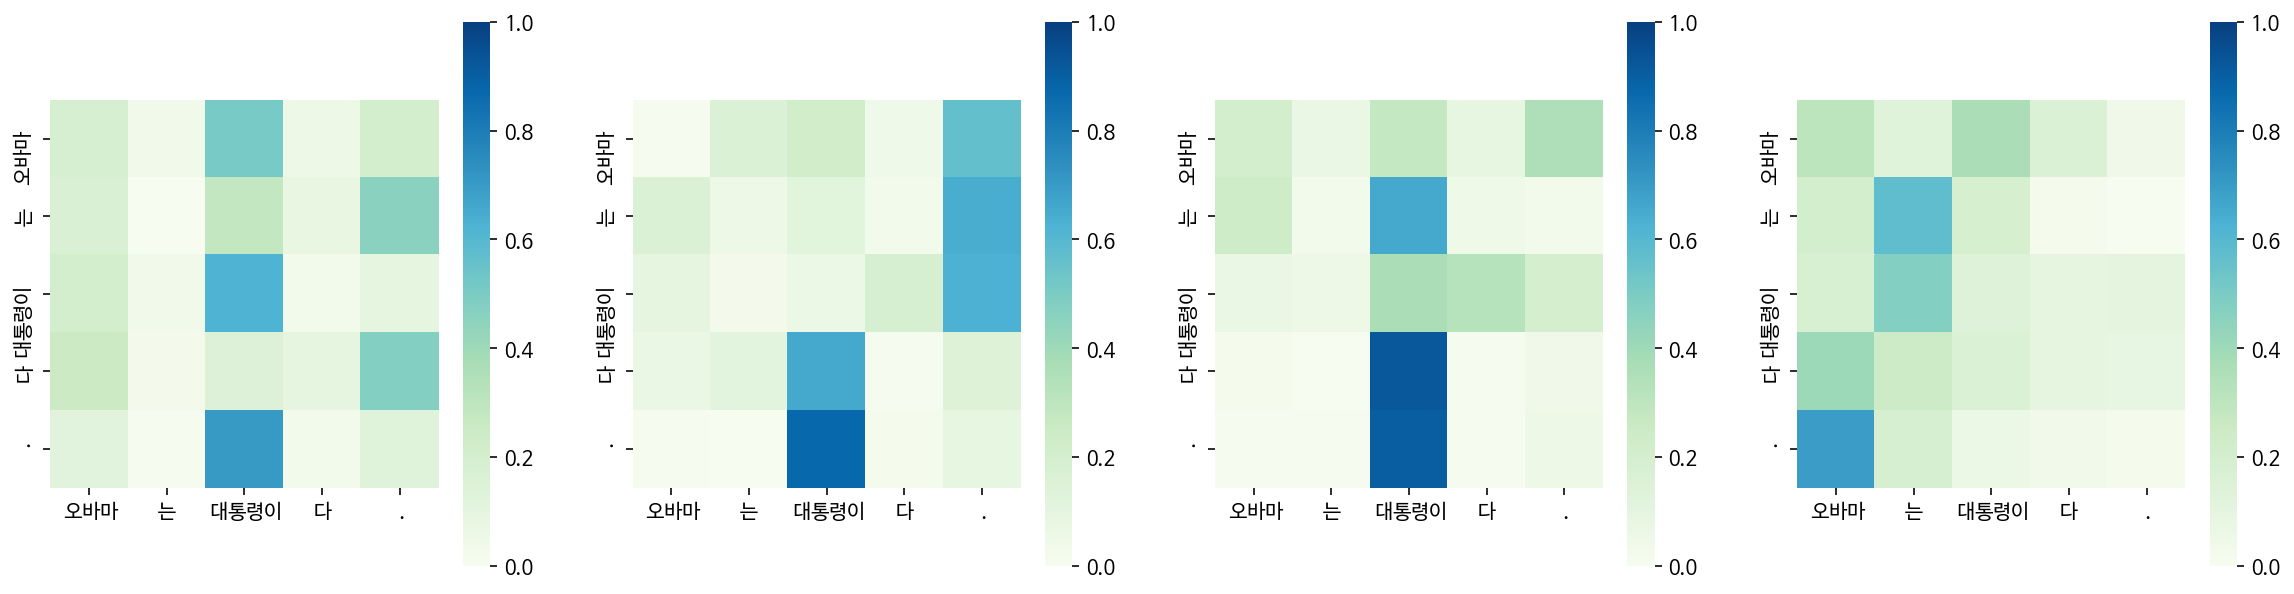

Decoder Self Layer 1


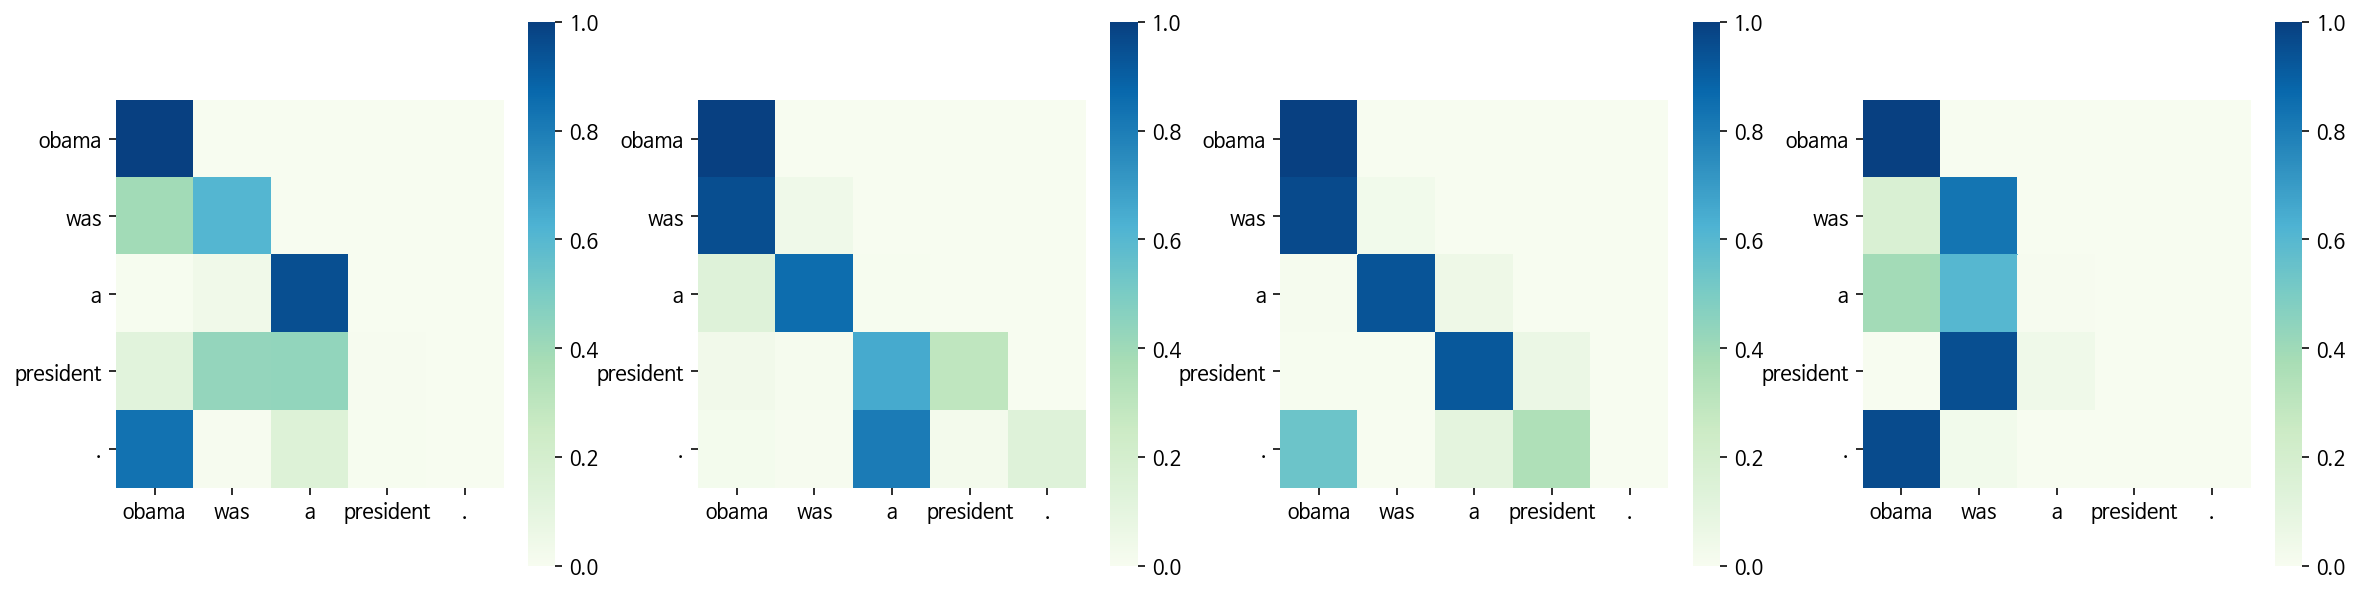

Decoder Src Layer 1


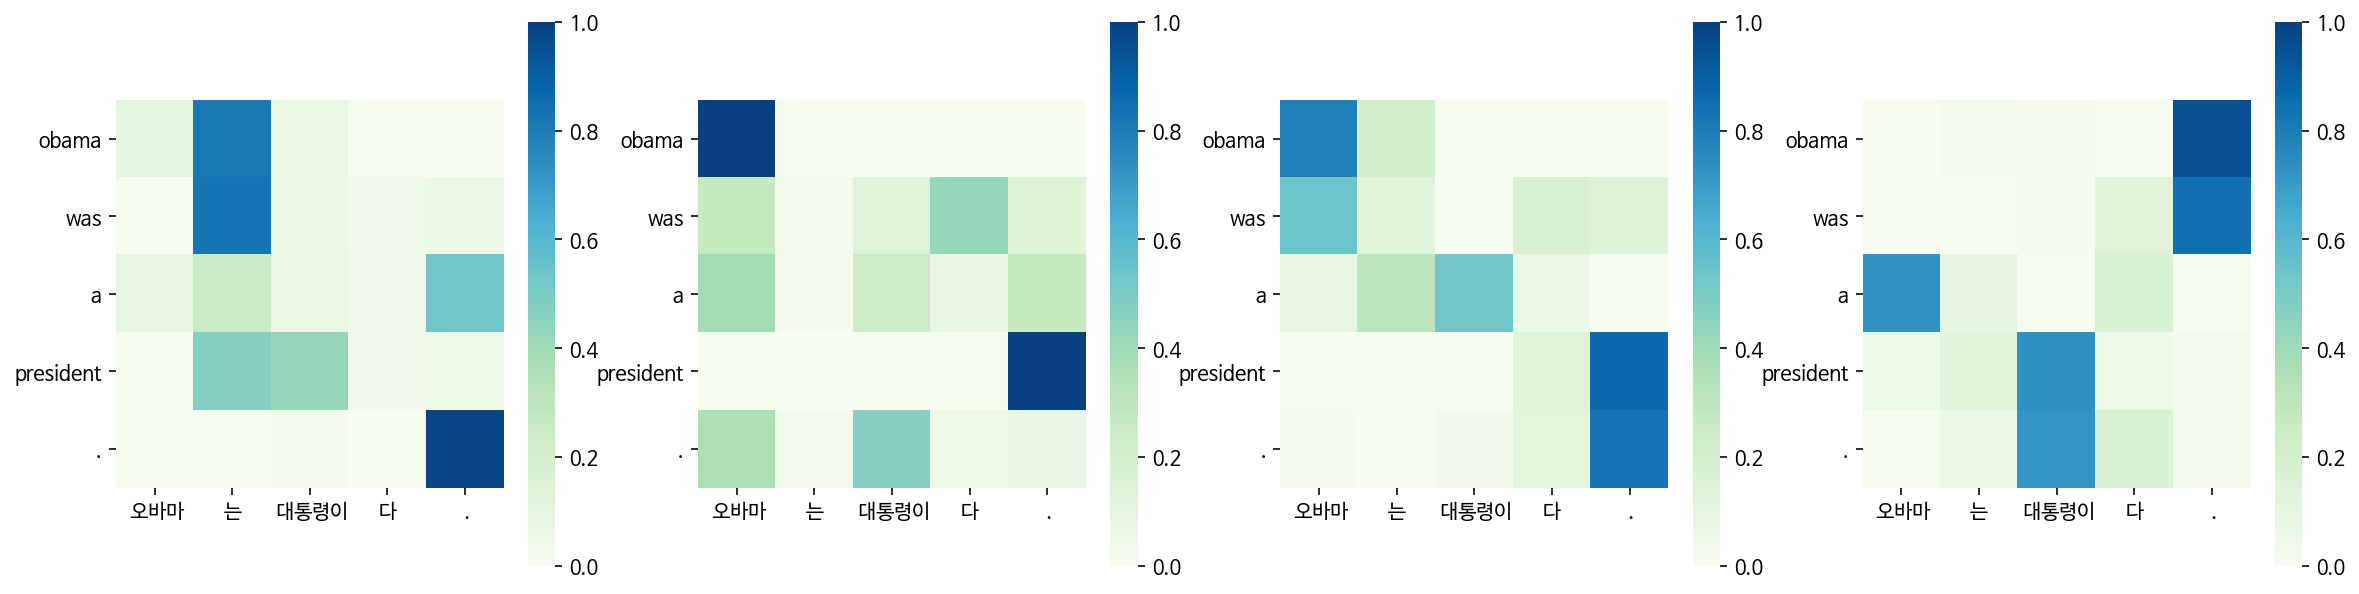

Decoder Self Layer 2


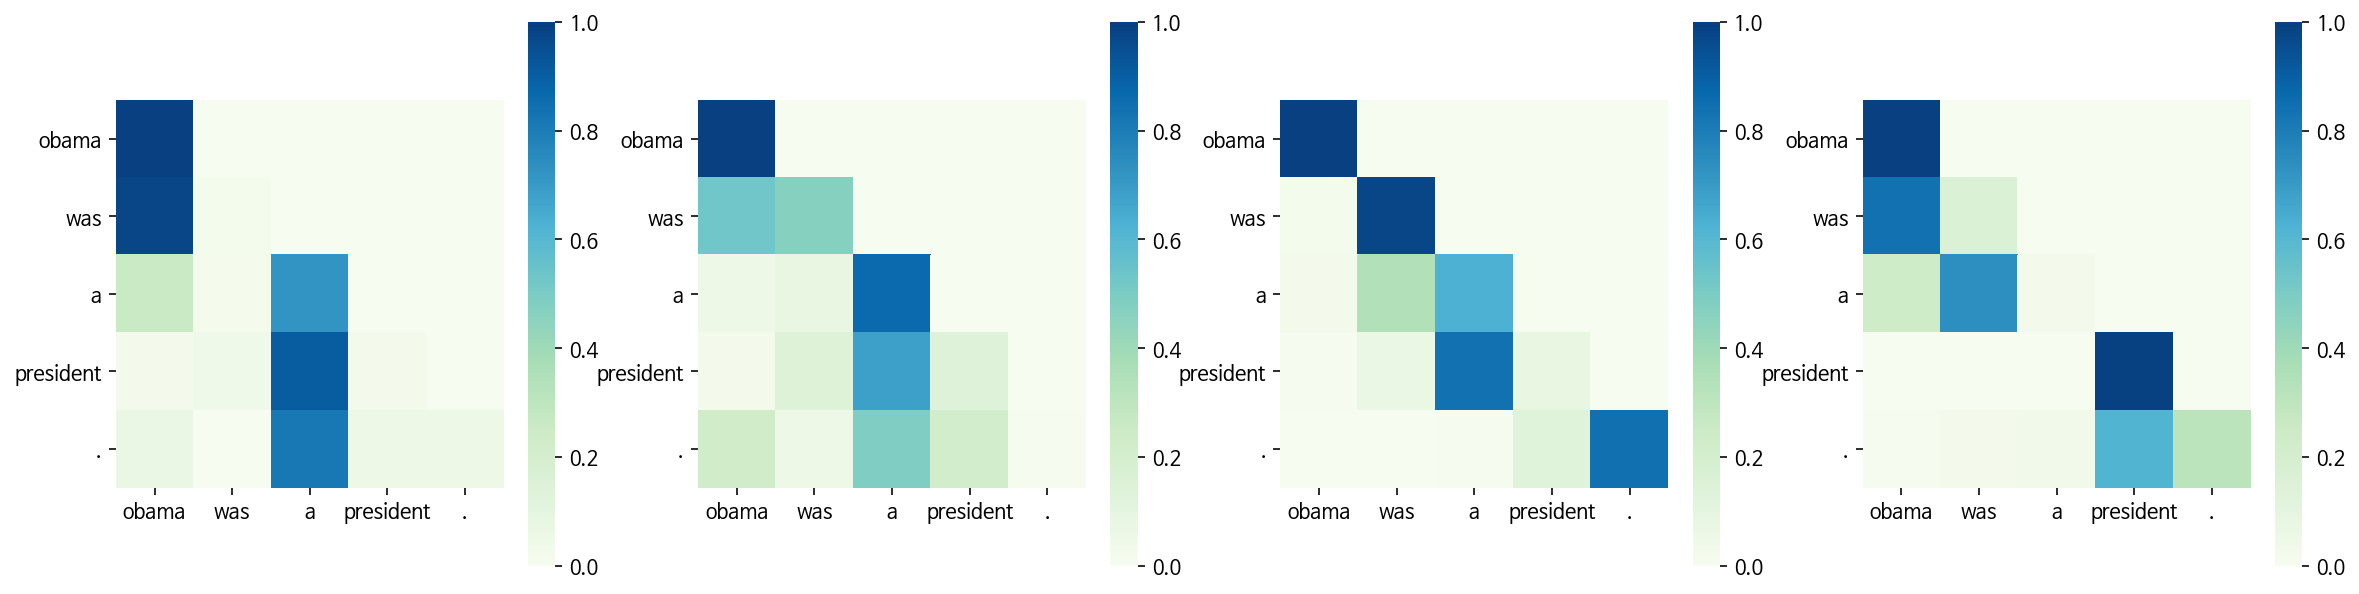

Decoder Src Layer 2


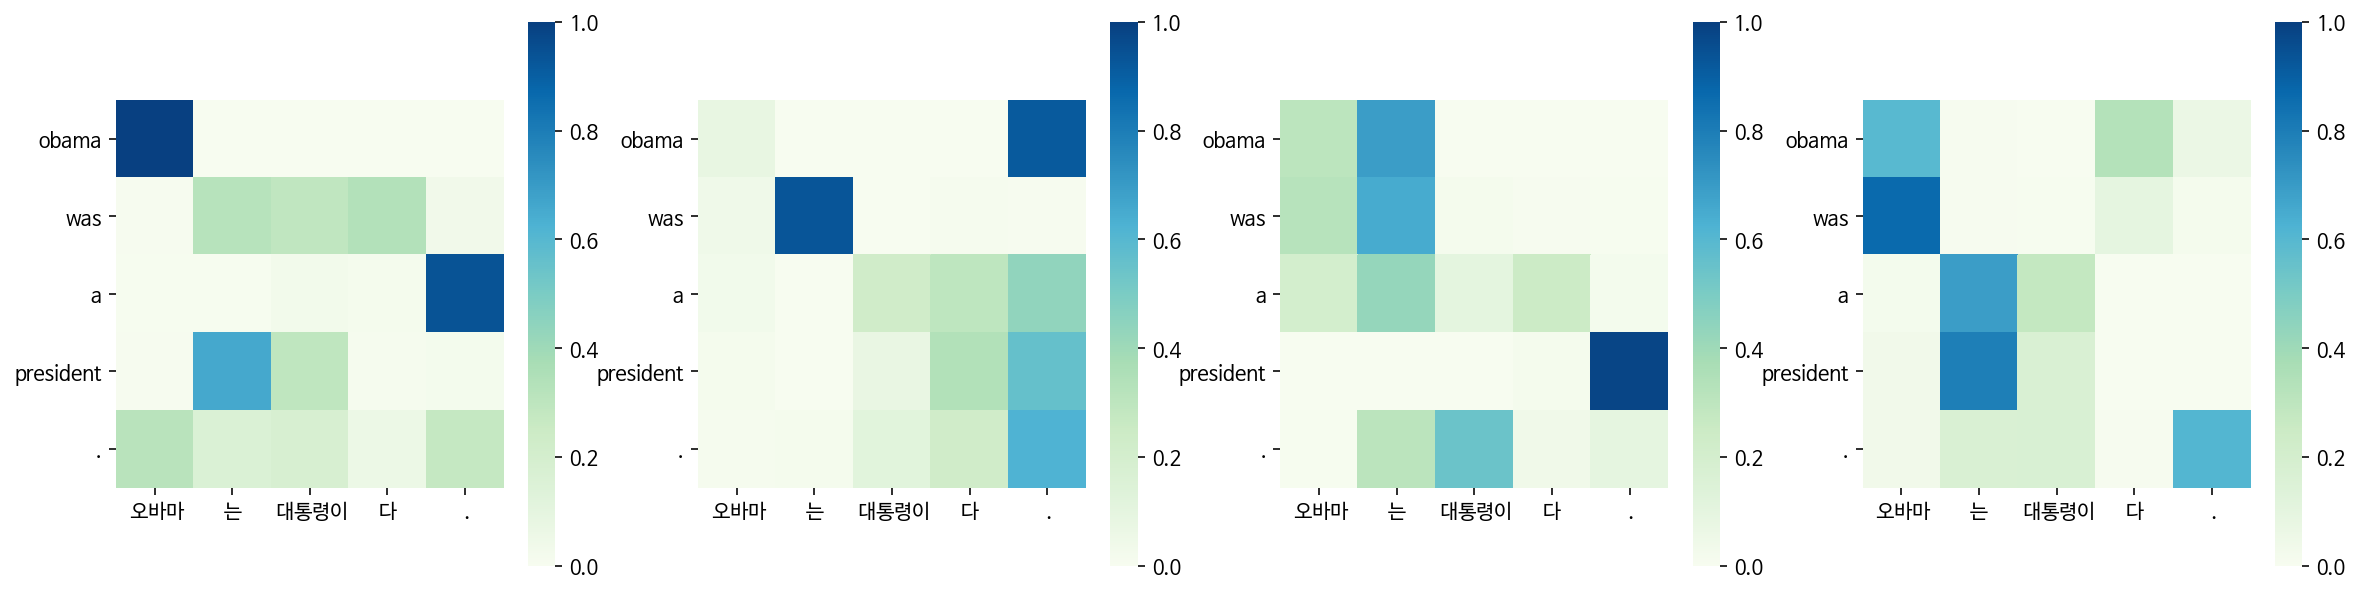

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is watching the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : that is for coffee you need a coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the people dead were killed , .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 41]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama was a president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is acidily acid keeps on city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : drink coffee is for people who needed to be needed .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seven cabinet members hit the island .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 42]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama was a president for the president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is unusually up to
🇰🇷 : 커피는 필요 없다.
🇺🇸 : nevertheless , she needed coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed on the ground against seven sunday , the dead said .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 43]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , obama said .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city s cited the city over the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : nevertheless , the coffee conservatives would need a coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 44]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama was a president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cities are growing urban city
🇰🇷 : 커피는 필요 없다.
🇺🇸 : people coffee are unable to need .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seven displaced people were killed , .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 45]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , obama says .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city cities in urban crisis .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : people coffee or so need a coffee house .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , the daily toll


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 46]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama was a president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city parts of the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : no coffee is people for that coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven delegates were killed people , overnight .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 47]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama president obama is a president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : residents of the city of kiev .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : people coffee or so , she needed to say .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of people were killed , the daily toll mounted .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 48]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama said he was president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : conditions are ethnic albanians
🇰🇷 : 커피는 필요 없다.
🇺🇸 : people need to me to win coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven of the seven missiles were killed , .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 49]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , obama said .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : conditions are charles .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : nevertheless , the smith is asked .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , .


  0%|          | 0/252 [00:00<?, ?it/s]

[EPOCH = 50]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s president , says he s president .
Encoder Layer 1


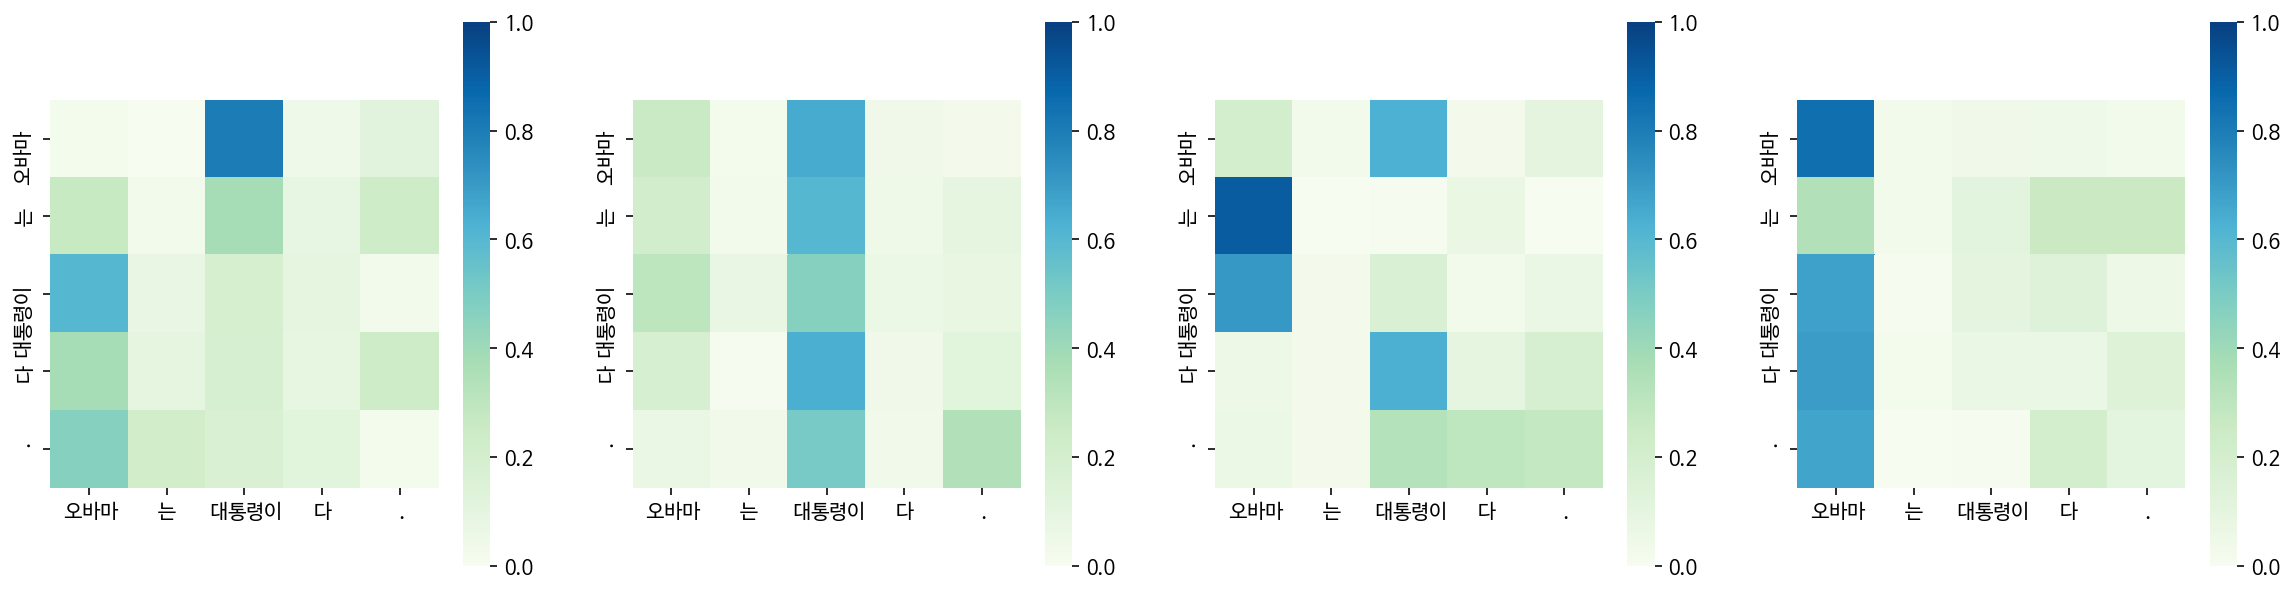

Encoder Layer 2


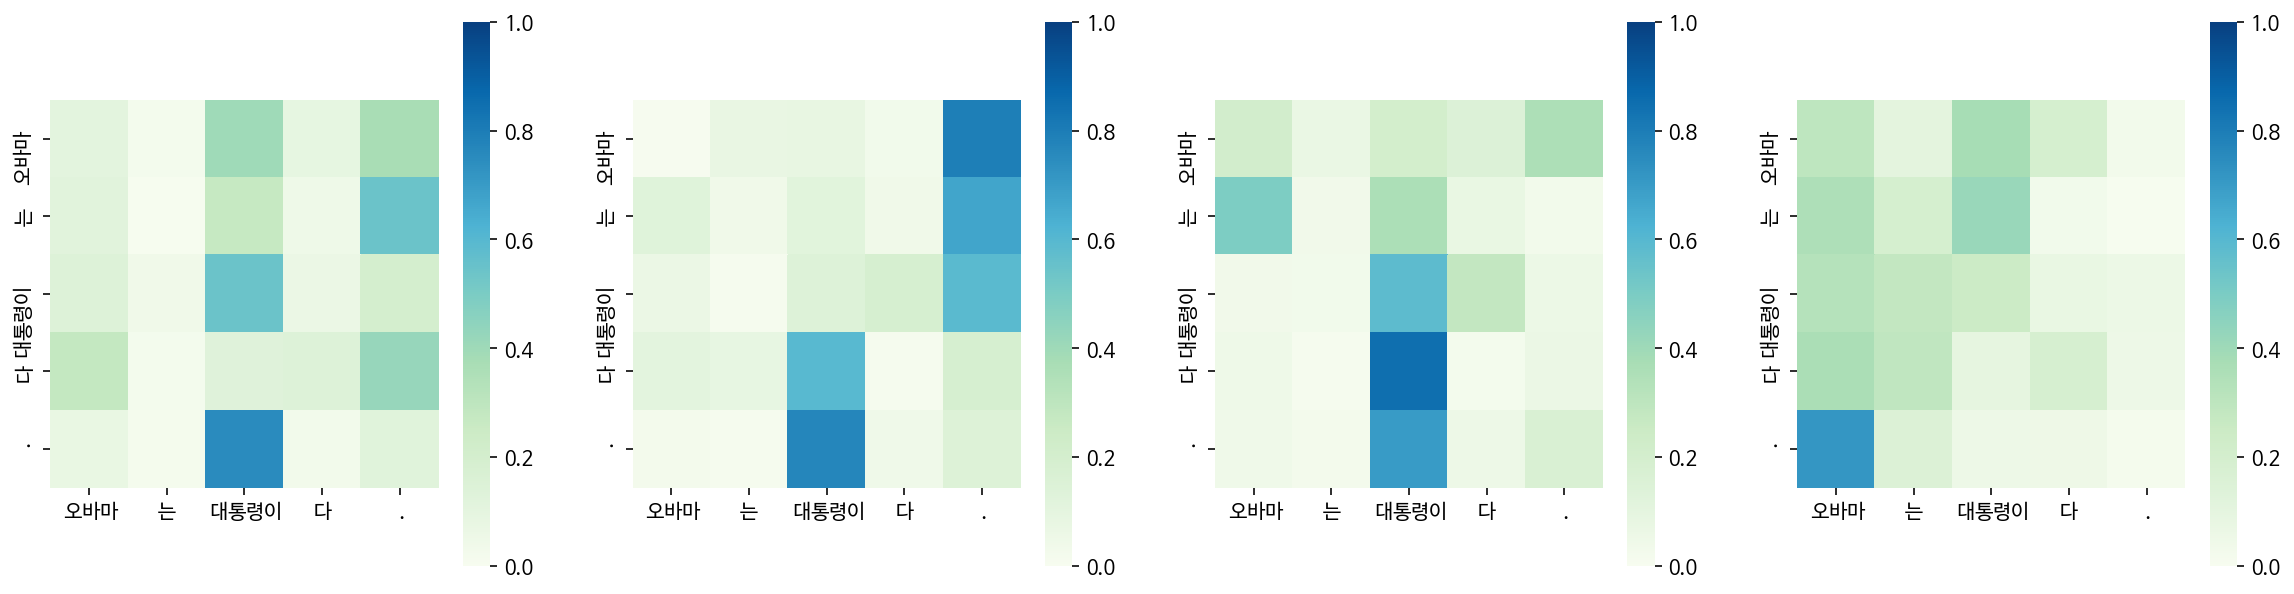

Decoder Self Layer 1


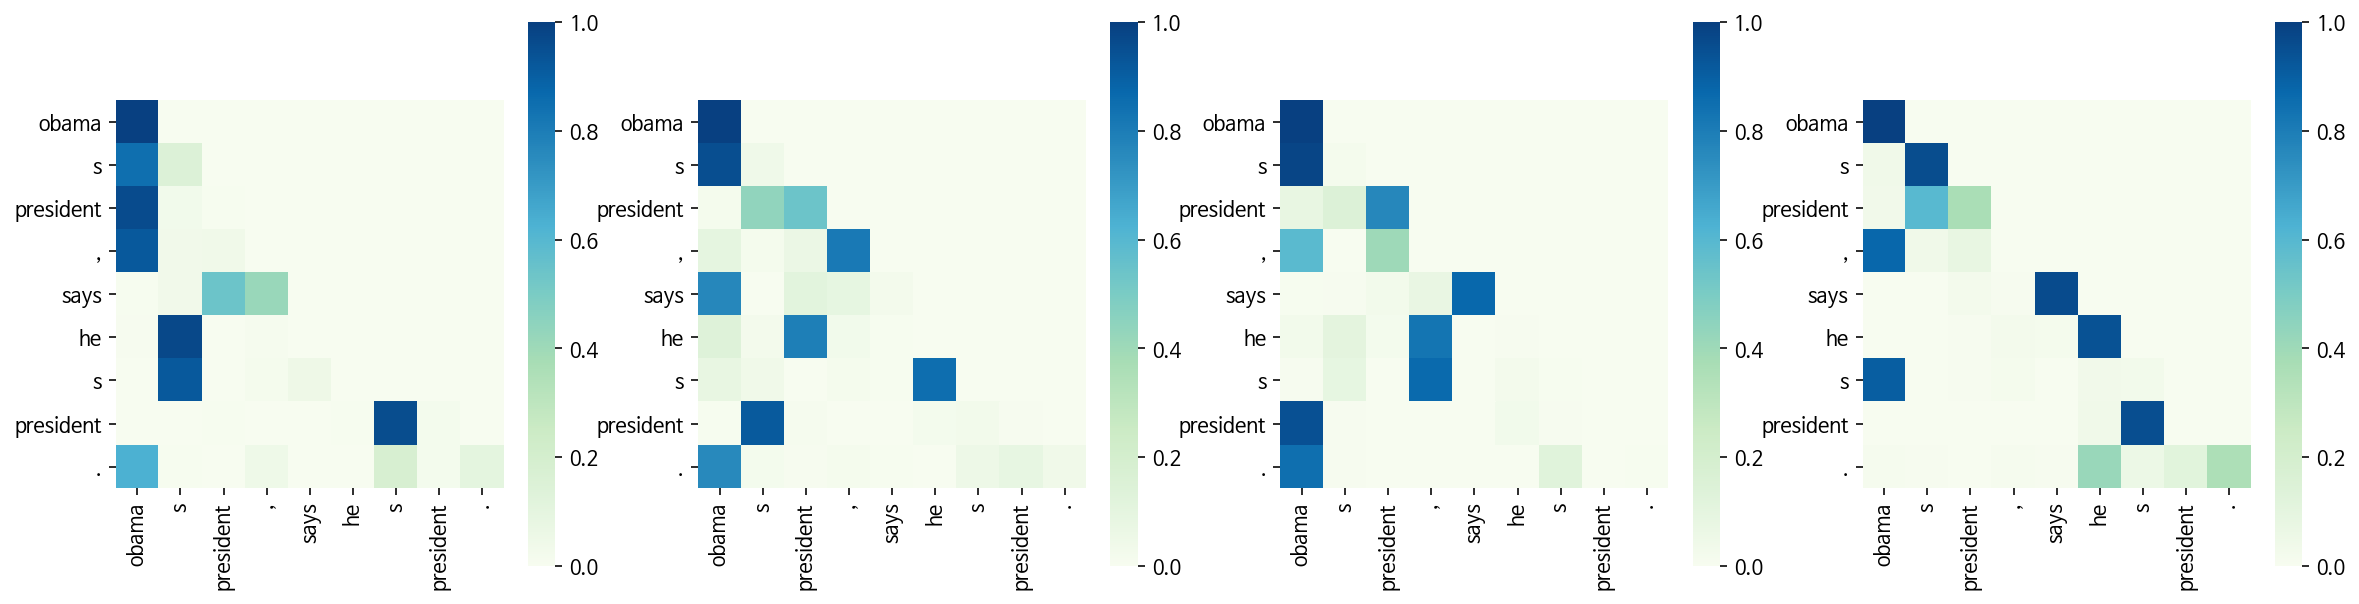

Decoder Src Layer 1


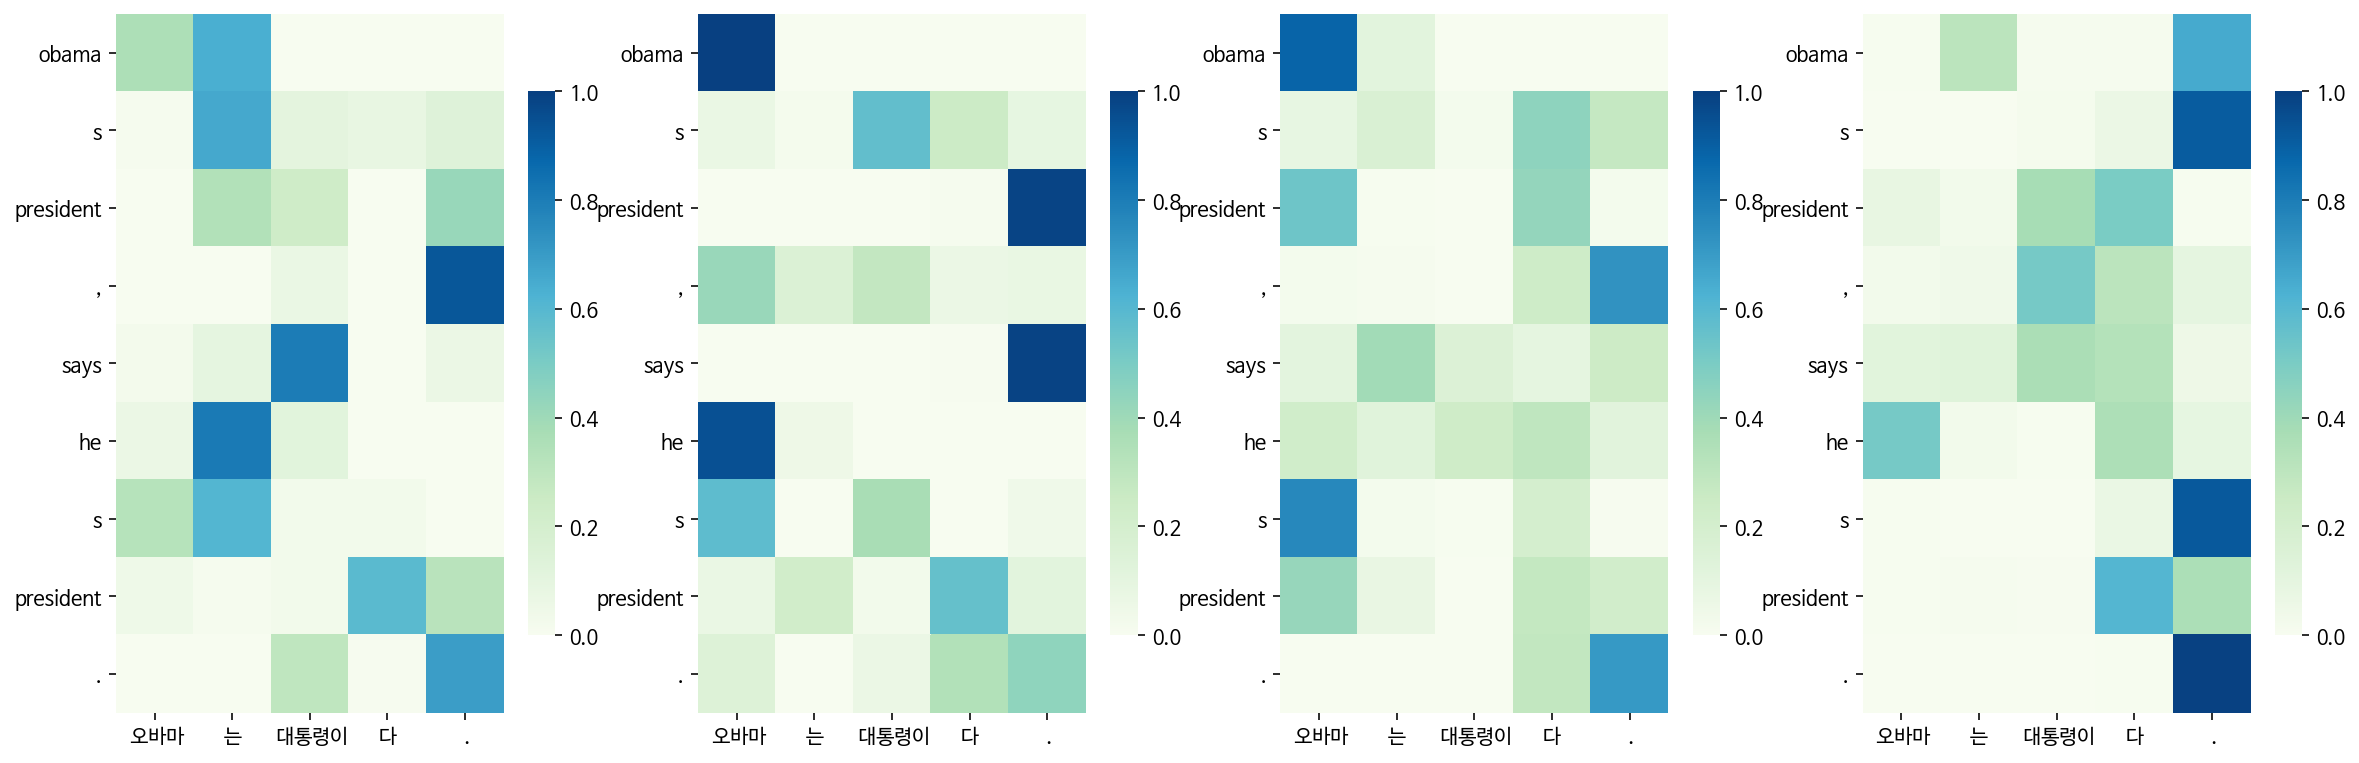

Decoder Self Layer 2


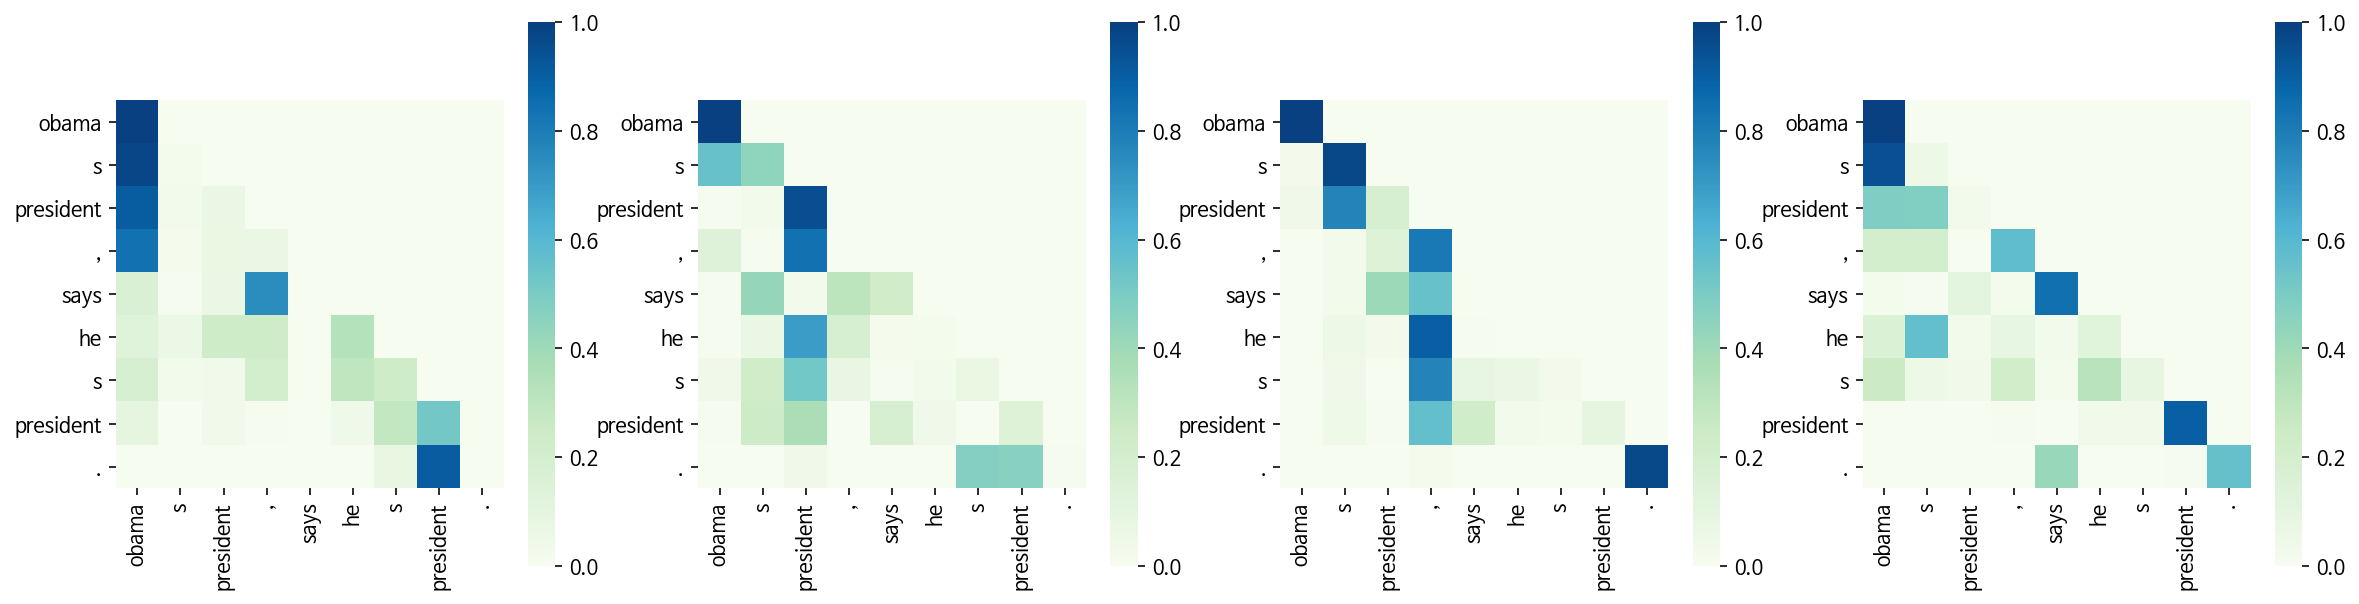

Decoder Src Layer 2


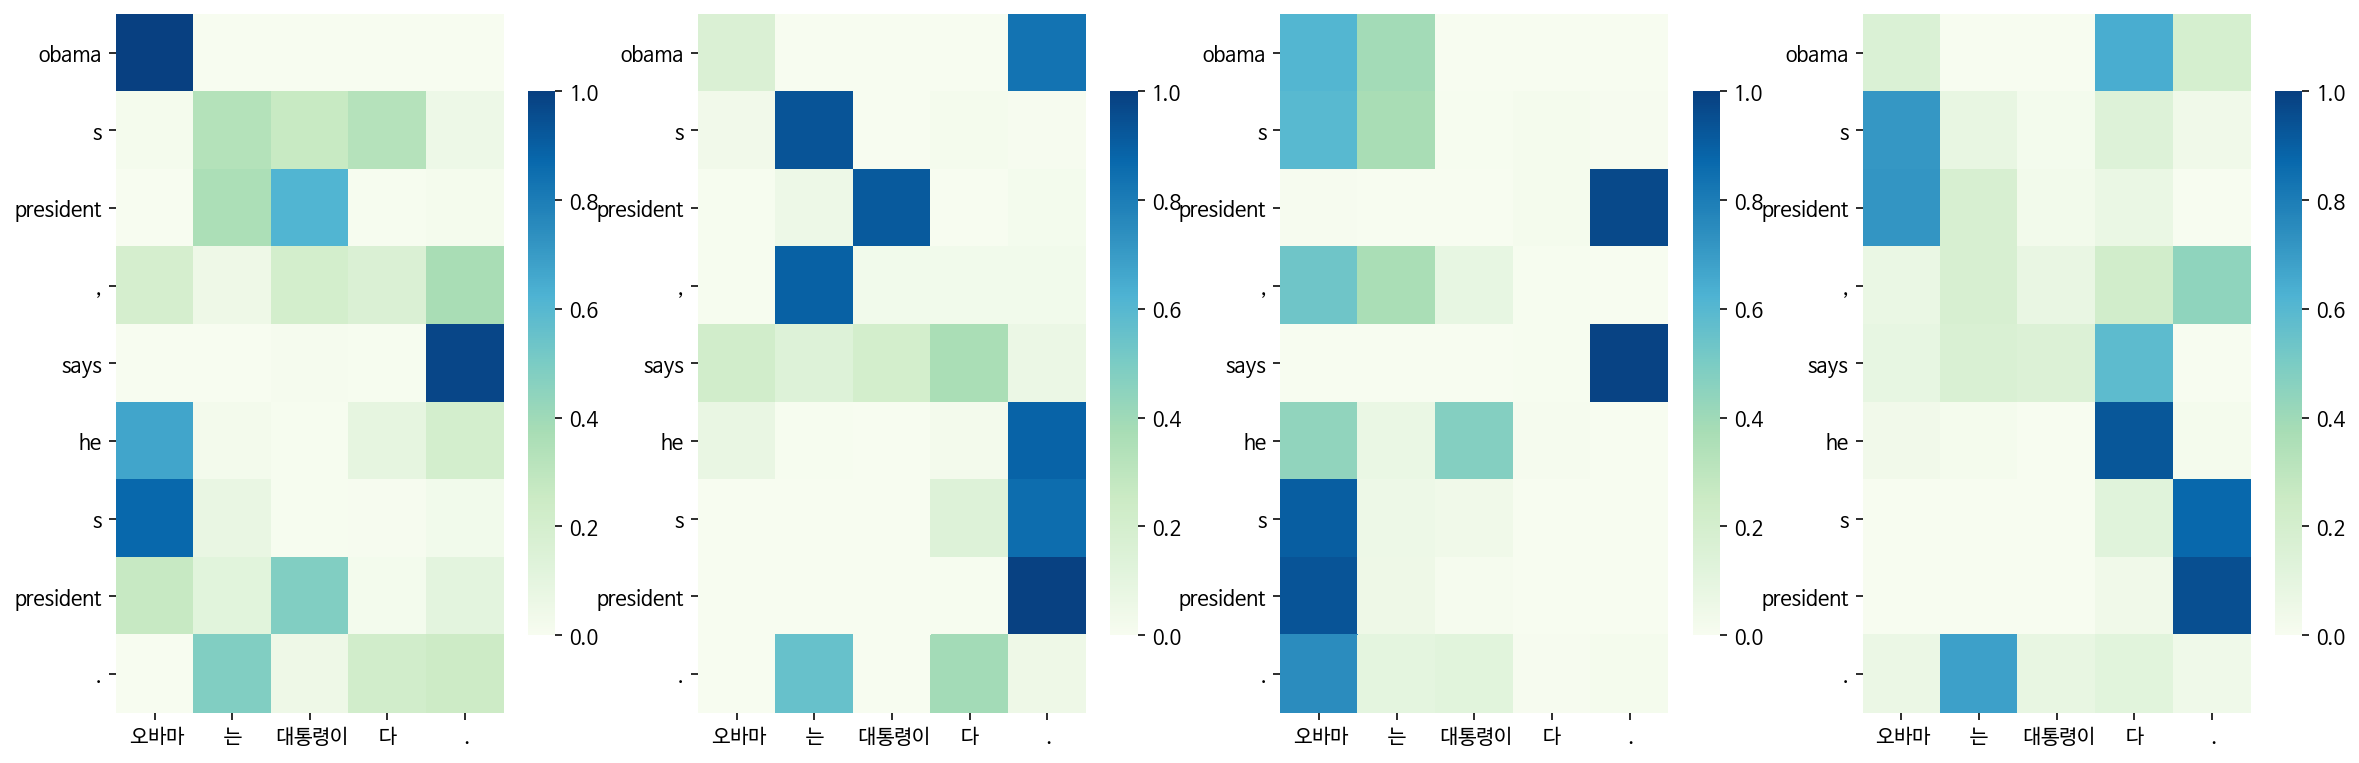

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : residents the city to see the scuffle .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : never needed
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : seven people were killed , troops and over a four day .


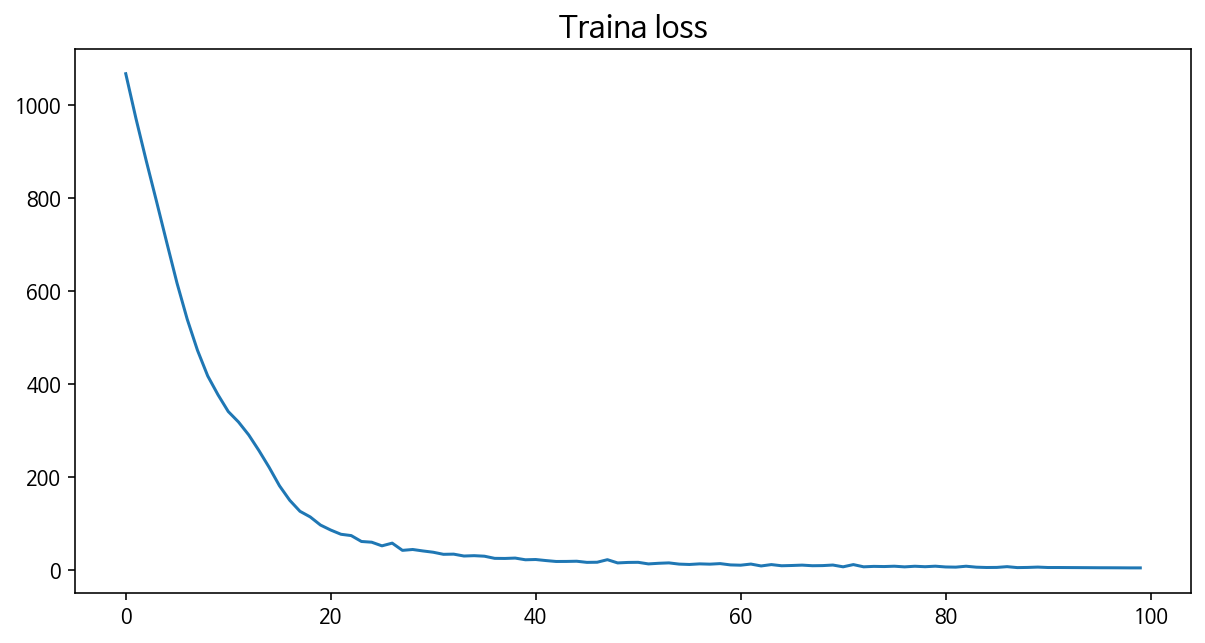

In [115]:
losses_3_100 = train(transformer_3, optimizer_3, enc_train, dec_train, 
                     ko_tokenizer, en_tokenizer, examples, 50, 256)
show_train_loss(losses_3 + losses_3_100)

이전 결과들 보다 훨씬 좋은 결과를 보여주고 있다. 뒤에 불필요한 단어들이 붙기는 하였지만, `일곱 명의 사망자가 발생했다.`를 `seven people were killed` 로 번역한 것은 괄목할 성과라고 볼 수 있다.

## Step 5. 결론
---

### 프로젝트 평가

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다. 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.
    - 전처리 과정이 지시 사항대로 이루어졌다.
2. Transformer 번역기 모델이 정상적으로 구동된다. Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.
    - Transformer 모델이 정작적으로 구동되며 학습이 진행되었다
    - 입력으로 한국어 문장을 받아 영어 문장을 출력하는 번역 기능이 정상적으로 작동하였다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다. 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.
    - 핵심단어에 대한 번역은 이루어졌지만, 제대로 된 문장이 생성되지 못하였다.